In [1]:
import csv
import cv2 as cv

import numpy as np
import pandas as pd
import os

from glob import glob
import matplotlib.pyplot as plt
from keras import backend as K

from keras.applications import inception_v3, inception_resnet_v2, mobilenet, resnet50, vgg16
from keras.layers import dot, Dense, GlobalAveragePooling2D, Lambda, Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import RMSprop, SGD

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Import test image csv information

Test folder: /storage/data/humpback-whale-challenge/test
# of test images: 15610


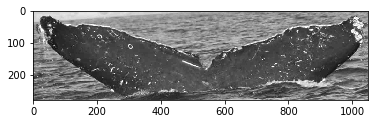

In [2]:
data_dir = '/storage/data/humpback-whale-challenge'
test_dir = 'test'

test_dict = dict()

print("Test folder: %s" %(os.path.join(data_dir,test_dir)))

for i, fn in enumerate(glob(os.path.join(data_dir,test_dir,'*.jpg'))):
    # print(fn)
    test_dict[i] = fn

img = cv.imread(os.path.join(data_dir,test_dir,"326b70e9.jpg"))
img = np.array(img,dtype=np.float32)/255
# print(img)
plt.imshow(img,)

print("# of test images: %s" %str(len(test_dict)))

## Import whale database information from training set

In [3]:
train_csv = 'train.csv'
train_dir = 'train'
df = pd.read_csv(filepath_or_buffer=os.path.join(data_dir,train_csv))

train_classes = df.groupby("Id").size()
print("\n# of unique database classes: %d" %train_classes.shape[0])

# create dictionary mapping labels to image filenames
db_img_filenames = df["Image"].tolist()
db_labels = df["Id"].tolist()
db = dict(zip(db_labels,db_img_filenames))

# remove new_whale key from dictionary
del db["new_whale"]
print("# of unique database classes: %d" %len(db))


# create dictionary mapping label index to label
labels_dict = {}
for i, label in enumerate(db.keys()):
    labels_dict[i]=label

# print(str(len(labels_dict)))


# of unique database classes: 4251
# of unique database classes: 4250


## Create database encodings

In [4]:
# load image from disk
def load_img(fn):

    # print(os.path.join(data_dir,fn))

    img = cv.imread(filename=os.path.join(fn),flags=0)
    img = cv.resize(src=img, dsize=(224,224), dst=img)
    img = np.array(img, dtype=np.float32)
    img /=  255
    img = np.stack((img,img,img),axis=-1)

    return img

# load training images into database
def create_db_array():
    
    arr = []
    
    for db_fn in db.values():
        db_img = load_img(os.path.join(data_dir,train_dir,db_fn))
        arr.append(db_img)
    
    arr = np.array(arr, dtype=np.float32)    
    print(arr.shape)
        
    return arr
  
# choose pre-trained base network that generates a (n,1) feature vector for an input image
def create_pre_trained_base(input_shape, base_id):
    
    # Inception-v3
    if base_id is 0:
        base = inception_v3.InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'Inception-V3'

    # MobileNet
    elif base_id is 1:
        base = mobilenet.MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'MobileNet'

    # Inception-ResNet-v2
    elif base_id is 2:
        base = inception_resnet_v2.InceptionResNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'InceptionResNet-v2'

    # ResNet50
    elif base_id is 3:
        base = resnet50.ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'ResNet50'

    # VGG16
    elif base_id is 4:
        base = vgg16.VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
        base_name = 'VGG16'

    top = GlobalAveragePooling2D()(base.output)
    model = Model(inputs=base.input, outputs=top, name='base_model')
    
    print("\nBase Network: %s" % base_name)

    return model


db_arr = create_db_array()
  
base_id = 4  # 0 = Inception-v3, 1 = MobileNet, 2 = Inception-ResNet-v2, 3= ResNet50, 4=VGG16
img_shape = (224,224,3)
base_model = create_pre_trained_base(input_shape=img_shape, base_id=base_id)

db_encoding = base_model.predict(x=db_arr, batch_size=32, verbose=1)
print("\nDatabase Encoding: "+str(db_encoding.shape))
print("Database Size: "+str(db_encoding.nbytes/1e9))

(4250, 224, 224, 3)
58892288/58889256 [==============================] - 3s 0us/step

Base Network: VGG16
4250/4250 [==============================] - 44s 10ms/step

Database Encoding: (4250, 512)
Database Size: 0.008704


## Define Siamese Network

In [5]:
weights_dir = 'weights'
weights_filename = 'traingen_wts3.h5'

# calculate cosine distance b/t feature vector outputs from base network
def cos_distance(feat_vects):

    K.set_epsilon(1e-07)
    epsilon = K.epsilon()

    x1, x2 = feat_vects

    result = K.maximum(x=dot(inputs=[x1, x2], axes=1, normalize=True), y=epsilon)

    return result

# create a siamese model that calculates similarity b/t two feature vectors
def create_siamese_model(input_shape, enable_saved_wts=True):
    encoding_a = Input(shape=input_shape, name='input_a')
    encoding_b = Input(shape=input_shape, name='input_b')

    fc1_a = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc1_a')(encoding_a)
    fc1_b = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc1_b')(encoding_b)

    distance = Lambda(function=cos_distance, name='cos_distance', )([fc1_a, fc1_b])

    prediction = Dense(units=1, activation='sigmoid', kernel_regularizer=l2(l=0.0000), name='sigmoid')(distance)

    model = Model(inputs=[encoding_a, encoding_b], outputs=prediction, name='siamese_model')

    if enable_saved_wts is True:
        model.load_weights(filepath=weights_filename,by_name=True)
        print("Loaded weights: %s" %weights_filename)
        
    return model


encoding_shape = db_encoding.shape[1:]
siamese_model = create_siamese_model(encoding_shape)
siamese_model.compile(optimizer=RMSprop(),loss="binary_crossentropy")
print(siamese_model.summary())

Loaded weights: traingen_wts3.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
fc1_a (Dense)                   (None, 2048)         1050624     input_a[0][0]                    
__________________________________________________________________________________________________
fc1_b (Dense)                   (None, 2048)         1050624     input_b[0][0]                    
____________________________________________________________________________

## Test Evaluation

In [9]:
# return top-N database predictions
def find_topN(predictions, N):

    # find N indices with the highest similarity predictions
    idxs_topN = np.argsort(predictions)[-N:]

    labels = []
    similarities = []

    # check if maximum prediction is <= 0.5. If so, assign "new_whale" class to top-1 prediction
    idx_max = idxs_topN[N-1]
    if predictions[idx_max] <= 0.5:
        labels.append("new_whale")
        similarities.append(-1)
        stop_idx = 0
    else:
        # labels.append(labels_dict[idx_max])
        stop_idx = -1

    for i in range(N-1,stop_idx,-1):
        idx = int(idxs_topN[i])
        labels.append(labels_dict[idx])
        similarities.append(predictions[idx])

    return labels, similarities

# load training images into database
def create_pairs(test_enc,db_encoding):
    
    arr = []
    # test_enc=np.reshape(a=test_enc,newshape=(512,))
    # print(test_enc.shape)
    
    for enc in db_encoding:
        arr.append([test_enc[0],enc])
        # print(enc.shape)
    
    # print(str(len(arr)))
    arr = np.array(arr,np.float32)    
    # print(arr.shape)
        
    return arr

# save top 5 results to csv file
def save_results(final_predictions):
    
    csv_fn = 'test_set_predictions_2018_07_05.csv'

    with open(csv_fn, 'w') as f:
        writer = csv.writer(f, delimiter=',')

        for name, labels in final_predictions:
            l_concat = " ".join(labels)
            # print(l_concat)
            writer.writerow([name,l_concat])
    
    print("Saving top-5 predictions to %s" %csv_fn)

        
n_test = len(test_dict)
n_db = len(db)
results = np.zeros(shape=(n_test,n_db),dtype=np.float32)
final_predictions = []
N = 5

# iterate through all test image and db combinations
for i, test_img_fn in enumerate(test_dict.values()):
    
    # if i > 25:
       # break
    
    test_img = load_img(test_img_fn)
    test_img = np.reshape(a=test_img, newshape=(1,224,224,3))
    test_enc = base_model.predict(x=test_img, batch_size=1, verbose=0)
    # print("test encoding shape: " +str(test_enc.shape))
    
    offset = len(test_dir)+len(data_dir)+2
    print("\nImage %d: %s" %(i,test_img_fn[offset:]))
    
    eval_pair = create_pairs(test_enc,db_encoding)
    # print(eval_pair.shape)
    prediction = siamese_model.predict(x=[eval_pair[:,0],eval_pair[:,1]], batch_size=32, verbose=1)
    results[i][0:n_db] = np.transpose(prediction)
    # print(100*results[i][0:10])
        
    # print(100*results[i][0:10])

    topN_ids, topN_values = find_topN(results[i],N)
    final_predictions.append([test_img_fn[offset:],topN_ids])
    
    
    print("Top %d Predictions: %s" %(N,str(topN_ids)))
    print("Top %d Similarities: %s" %(N,str(topN_values)))
    
    # save every 100 images
    if i%500==0:
        save_results(final_predictions)

save_results(final_predictions)


Image 0: 1a5c10f5.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_d1b13bb', 'w_8fec0dd', 'w_b2f1afa', 'w_fd1308e', 'w_7914111']
Top 5 Similarities: [0.93653804, 0.93636453, 0.8649048, 0.8602535, 0.8531838]
Saving top-5 predictions to test_set_predictions_2018_07_05.csv

Image 1: 6c681c2d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4f37147', 'w_532e2cc', 'w_1431f4b', 'w_0b3b659', 'w_0de84f0']
Top 5 Similarities: [0.98355514, 0.92801017, 0.92552483, 0.915838, 0.913582]

Image 2: 1758efcb.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_11f6df1', 'w_e17b0f1', 'w_b6c4efa', 'w_24212f5', 'w_d1bbde9']
Top 5 Similarities: [0.9853833, 0.9846674, 0.9794509, 0.97849655, 0.97687155]

Image 3: 689b9fde.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_1e1a051', 'w_269b090', 'w_5646ae9', 'w_aff0877', 'w_0aae8c1']
Top 5 Similarities: [0.9437824, 0.92981

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8968506', 'w_4fdaa2a', 'w_73bed18', 'w_c98f439', 'w_ca813c2']
Top 5 Similarities: [0.9676436, 0.86690617, 0.8437545, 0.83611125, 0.8022229]

Image 34: 2db9f459.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_395d578', 'w_68820e8', 'w_cece268', 'w_95af6a2', 'w_9e4a26f']
Top 5 Similarities: [0.97317344, 0.97216976, 0.9713949, 0.97052425, 0.97015196]

Image 35: 6b0d4cb5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_43eea34', 'w_c1b3568', 'w_5eda687', 'w_65e2424', 'w_4e11add']
Top 5 Similarities: [0.9891356, 0.97566164, 0.97481173, 0.9719116, 0.9622285]

Image 36: 3bb0b5bd.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5e3d9d0', 'w_61b87f9', 'w_bd43538', 'w_7185713', 'w_790c2aa']
Top 5 Similarities: [0.97635376, 0.96901524, 0.9643515, 0.9610189, 0.9577636]

Image 37: f9bd1f71.jpg
4250/4250 [=======


Image 67: 9ae3785d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_06ff732', 'w_d141590', 'w_3ca387d', 'w_1d84278', 'w_f71bac2']
Top 5 Similarities: [0.95807457, 0.9361763, 0.9158964, 0.9129783, 0.9128729]

Image 68: fc3a540c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b0362e2', 'w_89e451c', 'w_5919cf7', 'w_693c9ee', 'w_eb0a6ed']
Top 5 Similarities: [0.9830346, 0.9812011, 0.97425765, 0.97209406, 0.9673464]

Image 69: aae703e2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_867c363', 'w_452f14f', 'w_95874a5', 'w_c26b92a', 'w_272259b']
Top 5 Similarities: [0.99007785, 0.9749513, 0.9730576, 0.96374214, 0.9522413]

Image 70: e82537d9.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_592782d', 'w_f932abc', 'w_b0fde68', 'w_eac205a', 'w_94a4216']
Top 5 Similarities: [0.97685164, 0.9754498, 0.9724097, 0.9639511, 0.9629787]

Image 71: d96c23a1.jp

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a29719a', 'w_11138db', 'w_4a38a9f', 'w_53859b2', 'w_414a0d7']
Top 5 Similarities: [0.95018214, 0.94646734, 0.92132217, 0.91688174, 0.9094578]

Image 102: dad24756.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_941581c', 'w_89f4a0c', 'w_46b211d', 'w_b5d8846', 'w_bb79fb8']
Top 5 Similarities: [0.9501311, 0.938864, 0.9288273, 0.9203454, 0.91259104]

Image 103: 5d97b3bf.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f207f7d', 'w_33e89be', 'w_da1cc7a', 'w_60c5ba0', 'w_c926fc3']
Top 5 Similarities: [0.98875, 0.9852144, 0.9828705, 0.981646, 0.980261]

Image 104: b3310265.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5d86f98', 'w_d3ab153', 'w_4133134', 'w_733f161', 'w_73185e4']
Top 5 Similarities: [0.9640756, 0.957151, 0.9503729, 0.9439849, 0.9273252]

Image 105: e13bf974.jpg
4250/4250 [==============


Image 135: ba49f50d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d0cecd5', 'w_f90b695', 'w_3580734', 'w_6f211a9', 'w_1d37fb6']
Top 5 Similarities: [0.9768637, 0.96515775, 0.9639484, 0.9573487, 0.91730034]

Image 136: 43d4c3e4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ace5d0c', 'w_024358d', 'w_0ad6137', 'w_0c3295a', 'w_515d21d']
Top 5 Similarities: [0.9858154, 0.97913766, 0.9781794, 0.9762564, 0.9709009]

Image 137: 4a49baaa.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a1114ee', 'w_2b8e175', 'w_e0e133a', 'w_e39371c', 'w_2dc2ef2']
Top 5 Similarities: [0.9581452, 0.9552556, 0.94787914, 0.9471659, 0.93998134]

Image 138: 22b32757.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_759b647', 'w_58bca3c', 'w_c102acf', 'w_2a04ceb', 'w_941ca6a']
Top 5 Similarities: [0.9875, 0.9658283, 0.9447072, 0.9031146, 0.90073806]

Image 139: 2b84cc10.


Image 169: 62cecb2e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_eec1133', 'w_aa7a302', 'w_b4ad62f', 'w_4a4546c', 'w_89ca343']
Top 5 Similarities: [0.981914, 0.931105, 0.9252788, 0.9124153, 0.9059819]

Image 170: 65c29365.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5444df0', 'w_cae7677', 'w_46b211d', 'w_cd22b23', 'w_0f2f6e6']
Top 5 Similarities: [0.93936634, 0.9050798, 0.88365525, 0.873356, 0.8566509]

Image 171: 314accb4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_865c2ba', 'w_449a34e', 'w_f4fc8cc', 'w_c8126db', 'w_741861e']
Top 5 Similarities: [0.9666766, 0.9631759, 0.9596674, 0.9565363, 0.95595247]

Image 172: 00fbb200.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_905bf30', 'w_ff1b64c', 'w_86ff8a6', 'w_4fb3c95', 'w_76599c3']
Top 5 Similarities: [0.9913539, 0.9885867, 0.98849106, 0.9883088, 0.98809963]

Image 173: d04c18c7.j


Image 203: 52253a93.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_74adf0b', 'w_22b8a16', 'w_49c640f', 'w_c39c56e', 'w_997582c']
Top 5 Similarities: [0.970414, 0.95862937, 0.94046867, 0.9395418, 0.93386567]

Image 204: 7aa1d41d.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_8f3cb68', 'w_73185e4', 'w_837646b', 'w_1fb42f1', 'w_65428d9']
Top 5 Similarities: [0.9835776, 0.97919446, 0.97435486, 0.97054434, 0.9640351]

Image 205: 0743e630.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_679f2eb', 'w_a58f64d', 'w_51652ee', 'w_6ee7470', 'w_a25d46c']
Top 5 Similarities: [0.95561564, 0.9458455, 0.93936515, 0.93839943, 0.9238589]

Image 206: b7793a88.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_11ca856', 'w_2018f6c', 'w_67de30b', 'w_0b4429c', 'w_6f2c662']
Top 5 Similarities: [0.9766666, 0.9724272, 0.97186995, 0.96864367, 0.9681733]

Image 207: 86

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c9abb54', 'w_6554826', 'w_5646ae9', 'w_e964ae8', 'w_b280692']
Top 5 Similarities: [0.9659149, 0.9483463, 0.9447305, 0.93863994, 0.9332681]

Image 237: 59c2670c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_068f5bd', 'w_5f0960c', 'w_d47e2e3', 'w_0f41afe', 'w_598b8ab']
Top 5 Similarities: [0.95821655, 0.9519516, 0.94807655, 0.94411564, 0.9398592]

Image 238: bb3b8b13.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_816d344', 'w_9688819', 'w_934736d', 'w_030294d', 'w_f98d12b']
Top 5 Similarities: [0.95980275, 0.95922095, 0.9589748, 0.95645624, 0.95405066]

Image 239: 192f4021.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a54e7c1', 'w_ca4ca6f', 'w_2f8aed7', 'w_3f550fa', 'w_bc18612']
Top 5 Similarities: [0.9706297, 0.95677334, 0.9458091, 0.9424313, 0.9404698]

Image 240: fd3fb596.jpg
4250/4250 [====


Image 270: 779815fd.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_e62b5d8', 'w_3fffc61', 'w_8d46cef', 'w_89e159a', 'w_715d152']
Top 5 Similarities: [0.96823055, 0.9613475, 0.9593619, 0.9530199, 0.95166457]

Image 271: 3c001e73.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_425da9a', 'w_798bf53', 'w_599d0df', 'w_04c841c', 'w_639aed5']
Top 5 Similarities: [0.9833745, 0.9662257, 0.9644466, 0.9579131, 0.95568484]

Image 272: edb6818b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_cc699e6', 'w_89317b0', 'w_5624f08', 'w_a3dfe32', 'w_a687e28']
Top 5 Similarities: [0.9432604, 0.93855965, 0.92954355, 0.921475, 0.92003554]

Image 273: 19bf598d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e3c0ae5', 'w_8bc3f0a', 'w_62ca7c8', 'w_1f606cf', 'w_3172910']
Top 5 Similarities: [0.96484864, 0.96436477, 0.9589842, 0.95852476, 0.9430302]

Image 274: e941


Image 304: c5823d04.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b067417', 'w_a866824', 'w_fbbc8ba', 'w_b2e1722', 'w_f9bd832']
Top 5 Similarities: [0.98516035, 0.98421186, 0.9815886, 0.98152244, 0.9807973]

Image 305: b52b2287.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d89b29e', 'w_f78c287', 'w_62f299e', 'w_4a81594', 'w_ccbc782']
Top 5 Similarities: [0.96458155, 0.95500845, 0.9400505, 0.93360186, 0.9316838]

Image 306: 85a55a3f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b8ea509', 'w_b066aa6', 'w_e17b0f1', 'w_19aeb9c', 'w_a866824']
Top 5 Similarities: [0.9859385, 0.9836264, 0.9819822, 0.978634, 0.9734996]

Image 307: 64212afb.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7f3a122', 'w_b932b22', 'w_2f6e76c', 'w_08d1ccd', 'w_fd628f1']
Top 5 Similarities: [0.9008199, 0.89070994, 0.8884111, 0.8719405, 0.86011195]

Image 308: 19464


Image 338: 725bf756.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_826eb44', 'w_2c19c4a', 'w_f104523', 'w_e6b3dd4', 'w_10bea88']
Top 5 Similarities: [0.97888947, 0.9527192, 0.95154107, 0.9458752, 0.9414849]

Image 339: c8bf8015.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_514c62c', 'w_9989964', 'w_8b22583', 'w_a16b600', 'w_a59221a']
Top 5 Similarities: [0.98207927, 0.9819754, 0.9819412, 0.9803961, 0.9801926]

Image 340: 165880b0.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4a38a9f', 'w_a29719a', 'w_8717ef3', 'w_f79b3f9', 'w_fbbf84a']
Top 5 Similarities: [0.9865741, 0.97959703, 0.9757912, 0.9730525, 0.9628502]

Image 341: 4eb9749a.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_8b1ca89', 'w_6c42496', 'w_1a2b4f2', 'w_ab4cae2', 'w_17136dc']
Top 5 Similarities: [0.9775968, 0.96720403, 0.9650975, 0.96383804, 0.9631405]

Image 342: 07175e

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bc18612', 'w_8ba2066', 'w_796eebc', 'w_6438b7d', 'w_87050a3']
Top 5 Similarities: [0.988103, 0.9842317, 0.9782615, 0.97570837, 0.9692533]

Image 373: c583628f.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_f2ef6f8', 'w_c3aaa3a', 'w_72e70e5', 'w_aef3680', 'w_e2bf793']
Top 5 Similarities: [0.9778927, 0.97313356, 0.9681521, 0.96727484, 0.9660096]

Image 374: dcb1689d.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_cd1f1ed', 'w_313b78a', 'w_07a425f', 'w_7ab9a17', 'w_e93d181']
Top 5 Similarities: [0.9713982, 0.9650598, 0.9490708, 0.9416875, 0.93645674]

Image 375: b3da821b.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_f792125', 'w_3b02089', 'w_b089088', 'w_e2ddc60', 'w_23dce10']
Top 5 Similarities: [0.9857451, 0.97414804, 0.9702322, 0.96100944, 0.9608375]

Image 376: 0ed10f63.jpg
4250/4250 [========

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_07e92ee', 'w_37372db', 'w_83df8d5', 'w_f37508c', 'w_414a0d7']
Top 5 Similarities: [0.9842328, 0.97206205, 0.9689811, 0.9665649, 0.96605045]

Image 407: 79d8d3b1.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_b6d4901', 'w_f054e7a', 'w_1e674e6', 'w_40e3ee7', 'w_3dc5e74']
Top 5 Similarities: [0.8824331, 0.8461892, 0.8325674, 0.7710367, 0.75389266]

Image 408: 34cd7ded.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_285da1a', 'w_2b939eb', 'w_7324cf5', 'w_81ff1c5', 'w_e2241ce']
Top 5 Similarities: [0.9649465, 0.9525034, 0.9489614, 0.9398478, 0.93526566]

Image 409: dadb12cb.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_70e49bc', 'w_f44277f', 'w_7f867ec', 'w_395d578', 'w_d76d3bb']
Top 5 Similarities: [0.9808158, 0.98034614, 0.9789307, 0.9776929, 0.9752499]

Image 410: f6a2c881.jpg
4250/4250 [========


Image 440: 36303a54.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_ea96346', 'w_4f103de', 'w_af6c7e2', 'w_3f754d6', 'w_49b425b']
Top 5 Similarities: [0.97552353, 0.96409243, 0.9640202, 0.9579348, 0.9543366]

Image 441: 3ce9d2b2.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_844f032', 'w_86b9dfd', 'w_e0efc4f', 'w_7c44934', 'w_5a6bf1f']
Top 5 Similarities: [0.8945583, 0.87546897, 0.8485545, 0.78979313, 0.7818774]

Image 442: dba9aa05.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_f48b91b', 'w_f6e5eca', 'w_7b5d0f0', 'w_2957331', 'w_1ecfe96']
Top 5 Similarities: [0.9801615, 0.96661544, 0.9499593, 0.93878007, 0.934635]

Image 443: 64b07dc2.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_f4e84c1', 'w_01cbcbf', 'w_5e43abb', 'w_663a0d7', 'w_b793570']
Top 5 Similarities: [0.9678799, 0.96158326, 0.9586779, 0.95809287, 0.956795]

Image 444: 3fa19e


Image 474: ad422025.jpg
4250/4250 [==============================] - 0s 49us/step
Top 5 Predictions: ['w_69a9f72', 'w_03b5e9a', 'w_fcfcf68', 'w_6e120c4', 'w_fe5e78b']
Top 5 Similarities: [0.9724096, 0.9652492, 0.9650595, 0.96209806, 0.96165764]

Image 475: 4ee5075e.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_58a2388', 'w_2527790', 'w_39043c9', 'w_5059889', 'w_5ea3410']
Top 5 Similarities: [0.97079605, 0.9634311, 0.9515408, 0.9500541, 0.94862515]

Image 476: b5ae7f67.jpg
4250/4250 [==============================] - 0s 50us/step
Top 5 Predictions: ['w_ba39446', 'w_552ec4e', 'w_97f5054', 'w_1e3ce01', 'w_7417ab0']
Top 5 Similarities: [0.88107383, 0.866949, 0.83344704, 0.8227316, 0.8149565]

Image 477: 1cca0373.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4e85c68', 'w_075aa6e', 'w_d382236', 'w_a687e28', 'w_e39dcea']
Top 5 Similarities: [0.9129792, 0.8753328, 0.80682147, 0.7954285, 0.79122704]

Image 478: 2e088

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_e4616da', 'w_cd788c3', 'w_9b318aa', 'w_f4844e7', 'w_4c4c001']
Top 5 Similarities: [0.96201915, 0.9358244, 0.92833924, 0.87204117, 0.84311837]

Image 508: d80b1004.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_15427c3', 'w_fa9c3d8', 'w_7248590', 'w_5ba417d', 'w_a8bc2bc']
Top 5 Similarities: [0.9526921, 0.9424354, 0.9398853, 0.93410087, 0.9296278]

Image 509: 413ab823.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_715d152', 'w_6418af0', 'w_1ecfe96', 'w_42cc88d', 'w_d4251cb']
Top 5 Similarities: [0.9835143, 0.97295636, 0.96776104, 0.966508, 0.9663812]

Image 510: 04735120.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_a4b6a86', 'w_44a6b62', 'w_25e2bc9', 'w_d889b6a', 'w_41c0098']
Top 5 Similarities: [0.9756232, 0.96763706, 0.9593488, 0.94638723, 0.94447744]

Image 511: 83c6fc40.jpg
4250/4250 [====


Image 541: 346edebe.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_69e88da', 'w_f3f84d7', 'w_e39371c', 'w_244bd92', 'w_53e9072']
Top 5 Similarities: [0.9413728, 0.93813497, 0.9379284, 0.93074197, 0.92240393]

Image 542: 17fea02f.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_4b16688', 'w_ab39440', 'w_6da177a', 'w_009dc00', 'w_0c8a724']
Top 5 Similarities: [0.9840921, 0.983285, 0.9828724, 0.9804811, 0.9800137]

Image 543: 38c965ea.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_2b28681', 'w_1e6559e', 'w_490c8a0', 'w_01ab6dc', 'w_64830fa']
Top 5 Similarities: [0.9544283, 0.9528754, 0.93667346, 0.92547673, 0.92270154]

Image 544: 092c1806.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_36ac97f', 'w_62c3998', 'w_1aea445', 'w_3f90907', 'w_7ca11d6']
Top 5 Similarities: [0.9837948, 0.9775534, 0.96231914, 0.952908, 0.9294452]

Image 545: 2f19b5f

Top 5 Predictions: ['w_ca3bb23', 'w_33f5747', 'w_7b1686d', 'w_c2a602a', 'w_0626e4d']
Top 5 Similarities: [0.9759696, 0.9742225, 0.9735878, 0.9726332, 0.96960497]

Image 575: 4d316efb.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_e69cef0', 'w_5b576a0', 'w_9577f88', 'w_059e347', 'w_b6e6392']
Top 5 Similarities: [0.92370963, 0.895287, 0.86260635, 0.77331114, 0.761176]

Image 576: 1c05fdeb.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_e101deb', 'w_c3ce041', 'w_e17c752', 'w_4af3e4e', 'w_52e7cf6']
Top 5 Similarities: [0.98013294, 0.9767239, 0.97269815, 0.970595, 0.9677591]

Image 577: 8c02c522.jpg
4250/4250 [==============================] - 0s 49us/step
Top 5 Predictions: ['w_a3dfe32', 'w_f544197', 'w_f8024be', 'w_c8d20aa', 'w_c91f758']
Top 5 Similarities: [0.979107, 0.9427342, 0.9392171, 0.9376904, 0.93253]

Image 578: 7de6944c.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_8

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_e1f55ad', 'w_ad8bc47', 'w_65efe4d', 'w_544d0c1', 'w_3222bdb']
Top 5 Similarities: [0.98017234, 0.97757906, 0.9707218, 0.96778697, 0.9654026]

Image 609: 26228155.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_ab4cae2', 'w_d2be6cc', 'w_d5ec83f', 'w_e613f12', 'w_17136dc']
Top 5 Similarities: [0.9846133, 0.9802706, 0.97633046, 0.97239673, 0.9722731]

Image 610: f97aecd3.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2dcbf82', 'w_3350425', 'w_8ba2066', 'w_9a94e29', 'w_bf69a19']
Top 5 Similarities: [0.9806728, 0.9760509, 0.9736226, 0.9720301, 0.971377]

Image 611: 61f5c530.jpg
4250/4250 [==============================] - 0s 49us/step
Top 5 Predictions: ['w_9ad963f', 'w_29c286a', 'w_d52bc74', 'w_8740039', 'w_73321ab']
Top 5 Similarities: [0.96536016, 0.9588014, 0.94465995, 0.9416799, 0.936211]

Image 612: 3a5ce927.jpg
4250/4250 [========


Image 642: c2a088c9.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_7bcc2d6', 'w_49a3a96', 'w_7285eb3', 'w_2870b33', 'w_0b04c08']
Top 5 Similarities: [0.9804427, 0.9762082, 0.9744649, 0.96992433, 0.96594095]

Image 643: d1258c8a.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_6f580eb', 'w_4696a5a', 'w_78948b5', 'w_ebb16ab', 'w_5f7c402']
Top 5 Similarities: [0.9565668, 0.9467418, 0.94299465, 0.9408423, 0.9402314]

Image 644: 97dd51fe.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_a1350a7', 'w_78a6f56', 'w_303518a', 'w_c22307d', 'w_8dcd784']
Top 5 Similarities: [0.983957, 0.9685533, 0.9638687, 0.95856386, 0.95707107]

Image 645: ef378839.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_8166c79', 'w_9c449e2', 'w_2707bcd', 'w_7d7d108', 'w_068f5bd']
Top 5 Similarities: [0.964795, 0.9562203, 0.9481488, 0.9443571, 0.9404263]

Image 646: 8ec67dd6.


Image 676: 7e87ece8.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_c7d76c6', 'w_23526cb', 'w_e39371c', 'w_87acd5c', 'w_1f6e1db']
Top 5 Similarities: [0.94327134, 0.9408026, 0.9262688, 0.92484266, 0.90990794]

Image 677: 6969d75a.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6a3ca27', 'w_773509f', 'w_e34abbe', 'w_778ee6e', 'w_212ad82']
Top 5 Similarities: [0.97793794, 0.97708696, 0.9767049, 0.9703692, 0.9689892]

Image 678: 60c21a04.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_b1a4f29', 'w_656afeb', 'w_a43fcbb', 'w_a4d41b4', 'w_ca4ca6f']
Top 5 Similarities: [0.935854, 0.9330602, 0.92008793, 0.9169589, 0.91462916]

Image 679: 168ddf93.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_5dcbb74', 'w_193b7e3', 'w_dd76ce2', 'w_dc97dc3', 'w_dfacbe7']
Top 5 Similarities: [0.9686036, 0.9562969, 0.9307593, 0.9160559, 0.9057257]

Image 680: e9ae17


Image 710: fae3e38d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_740dfd4', 'w_895007f', 'w_3c7b2e6', 'w_cad1a8d', 'w_cff28c4']
Top 5 Similarities: [0.92673725, 0.91187835, 0.8820384, 0.8786248, 0.8710466]

Image 711: 8e2d52af.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0ebd514', 'w_099c712', 'w_f18af3b', 'w_895c722', 'w_d3ef4b2']
Top 5 Similarities: [0.98689485, 0.9783474, 0.97671926, 0.97361165, 0.9730185]

Image 712: 4146aa4d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9065f2e', 'w_d7ddf9c', 'w_37f17ad', 'w_dfd3f5e', 'w_2c75202']
Top 5 Similarities: [0.98277414, 0.9769493, 0.9737083, 0.9730075, 0.9681807]

Image 713: ae96e8ee.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2b930da', 'w_3f904cf', 'w_4808f0a', 'w_37f17ad', 'w_f28de05']
Top 5 Similarities: [0.9733348, 0.94353515, 0.92272466, 0.9161401, 0.91511506]

Image 714: c3d

Top 5 Predictions: ['w_c2474a2', 'w_a59221a', 'w_a4f77bd', 'w_fbbc8ba', 'w_e2e56e9']
Top 5 Similarities: [0.98783106, 0.9819313, 0.97995526, 0.977429, 0.9753121]

Image 744: 27f7f348.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_9291cdf', 'w_8244367', 'w_7233641', 'w_a646643', 'w_8cd7651']
Top 5 Similarities: [0.9698855, 0.9377911, 0.9368304, 0.93510157, 0.9265857]

Image 745: 4a37850c.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_dfec7a3', 'w_6418af0', 'w_7e5cc5e', 'w_aca9607', 'w_900f9eb']
Top 5 Similarities: [0.96482885, 0.96403974, 0.9597919, 0.9594695, 0.9576314]

Image 746: f5988315.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_5dddfbe', 'w_e00a916', 'w_dc81791', 'w_29c286a', 'w_7f4a1f1']
Top 5 Similarities: [0.9589577, 0.94943684, 0.9304687, 0.9168657, 0.9149275]

Image 747: d0440188.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: 


Image 777: a44325fd.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2dcbf82', 'w_d47e2e3', 'w_2fdee7b', 'w_00d8453', 'w_bf69a19']
Top 5 Similarities: [0.97264636, 0.9524769, 0.94793963, 0.9454698, 0.94370174]

Image 778: edf11234.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1a5e7a2', 'w_76d84e2', 'w_f054e7a', 'w_0ac6a0a', 'w_7e253e1']
Top 5 Similarities: [0.9770059, 0.9475027, 0.938485, 0.9316662, 0.9268034]

Image 779: 04b0f138.jpg
4250/4250 [==============================] - 0s 50us/step
Top 5 Predictions: ['w_44f0fa2', 'w_585e948', 'w_c8af414', 'w_030294d', 'w_25fdcfb']
Top 5 Similarities: [0.9886622, 0.9739811, 0.97376925, 0.96904516, 0.96776575]

Image 780: 7882f7a2.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_0b7e949', 'w_bb79fb8', 'w_ed5a7c6', 'w_d96c946', 'w_e3f51ec']
Top 5 Similarities: [0.9557217, 0.9481313, 0.9424078, 0.92566067, 0.9233935]

Image 781: e26fa1


Image 811: bd4dd941.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_9e559ff', 'w_6df35bf', 'w_32475a1', 'w_e4f1fcc', 'w_a464d28']
Top 5 Similarities: [0.97870696, 0.9741557, 0.97345155, 0.955931, 0.9551572]

Image 812: 388ba4ee.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_157ba16', 'w_1c3e5da', 'w_e3b2cfa', 'w_9a94e29', 'w_4659acf']
Top 5 Similarities: [0.9647755, 0.96350014, 0.96096426, 0.9492786, 0.9422081]

Image 813: d4e36e5b.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_3ca387d', 'w_37bd99a', 'w_00cb685', 'w_8b6fd36', 'w_71e6583']
Top 5 Similarities: [0.9707262, 0.96659654, 0.9630915, 0.9610583, 0.95262605]

Image 814: 6386c3da.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_50d2084', 'w_b64126b', 'w_2f1e886', 'w_651cbb7', 'w_89973e5']
Top 5 Similarities: [0.9852282, 0.9817315, 0.97895104, 0.977484, 0.97653276]

Image 815: 4a58bc

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3331656', 'w_095f58d', 'w_dd393cb', 'w_19ca2c6', 'w_faf538a']
Top 5 Similarities: [0.94809747, 0.9468139, 0.930761, 0.91888595, 0.9139144]

Image 845: 4b5e982b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_147b62b', 'w_0ebd514', 'w_a0838d1', 'w_3dd1a87', 'w_b618751']
Top 5 Similarities: [0.9824843, 0.97960234, 0.9790622, 0.9788462, 0.9730129]

Image 846: a77e5660.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3dc5e74', 'w_97666c8', 'w_cf3c233', 'w_ccca0db', 'w_f48b91b']
Top 5 Similarities: [0.9635267, 0.960005, 0.9589725, 0.9574586, 0.94685364]

Image 847: 7baf63df.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_46540b1', 'w_c0d494d', 'w_3e9d82e', 'w_b34793e', 'w_fcda065']
Top 5 Similarities: [0.9764079, 0.95348454, 0.95325136, 0.9495367, 0.9468159]

Image 848: 52d8e58e.jpg
4250/4250 [=========


Image 878: a009828c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4c4c001', 'w_9b318aa', 'w_1703ee5', 'w_5cb5e65', 'w_b1d6681']
Top 5 Similarities: [0.90920293, 0.8471815, 0.81872606, 0.81333244, 0.77766055]

Image 879: 5226e451.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c0a4c9d', 'w_8aab1d4', 'w_86ff8a6', 'w_0408054', 'w_ff1b64c']
Top 5 Similarities: [0.9779703, 0.9755685, 0.9740244, 0.97354126, 0.9733175]

Image 880: 8a9cf7e5.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_c5d7c03', 'w_b3cc032', 'w_17d5eb9', 'w_313b78a', 'w_1310342']
Top 5 Similarities: [0.9793331, 0.9748123, 0.9706478, 0.9705151, 0.96574146]

Image 881: a49ecbfd.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_32d99b4', 'w_8f6b207', 'w_bc5f0f5', 'w_02a768d', 'w_0ae998f']
Top 5 Similarities: [0.939616, 0.91831386, 0.9162037, 0.91616696, 0.9141011]

Image 882: e9235

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3f2a05c', 'w_fe96bef', 'w_1d0e29a', 'w_2e10179', 'w_5fc5ea5']
Top 5 Similarities: [0.9592257, 0.9342372, 0.93226457, 0.9264962, 0.90800387]

Image 912: fef843df.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_552a16e', 'w_72c15c4', 'w_8b6fd36', 'w_f183341', 'w_d9adb4f']
Top 5 Similarities: [0.9827558, 0.9618077, 0.96030205, 0.9601045, 0.9570752]

Image 913: fb20c7f2.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_d080f35', 'w_a7c6cf3', 'w_7394d75', 'w_6092d5c', 'w_46dcce7']
Top 5 Similarities: [0.9503351, 0.941466, 0.9017273, 0.88515997, 0.8668313]

Image 914: afc70c06.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b0a5c8d', 'w_4af3e4e', 'w_b197b5c', 'w_e101deb', 'w_fae3939']
Top 5 Similarities: [0.9715405, 0.9706453, 0.9492077, 0.9485443, 0.9483768]

Image 915: 6aa69084.jpg
4250/4250 [==========


Image 945: 07725434.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9b00e07', 'w_5619521', 'w_9d704ab', 'w_f18df18', 'w_7c943ab']
Top 5 Similarities: [0.9769234, 0.97680557, 0.970931, 0.9680577, 0.96005607]

Image 946: 63cace96.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3076d8c', 'w_3ae3603', 'w_d4eb9ed', 'w_93a4f60', 'w_3d8c865']
Top 5 Similarities: [0.9891186, 0.96177375, 0.96047765, 0.9580646, 0.9494719]

Image 947: 58780a2d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f1177c9', 'w_5b672ea', 'w_3bc8a47', 'w_ae1db8a', 'w_a2f5cc0']
Top 5 Similarities: [0.9356114, 0.93483454, 0.9057469, 0.9049912, 0.8922066]

Image 948: 50983bb6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2f1e886', 'w_3a7d86d', 'w_b64126b', 'w_3c304db', 'w_29d2cec']
Top 5 Similarities: [0.9851569, 0.9809449, 0.9808545, 0.97194326, 0.9718283]

Image 949: a4998c6

Top 5 Predictions: ['w_3136deb', 'w_980bb1a', 'w_5acfa65', 'w_15eae33', 'w_17e592c']
Top 5 Similarities: [0.93772024, 0.9187523, 0.90223426, 0.8396035, 0.8326467]

Image 979: d207e5f7.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_5bc7e7f', 'w_799556e', 'w_ab6bb0a', 'w_0bc1db0', 'w_fdc8bf6']
Top 5 Similarities: [0.99178606, 0.9916102, 0.98788667, 0.98694474, 0.9811429]

Image 980: 1ee25b72.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_b96d4e0', 'w_b17f9ea', 'w_099c712', 'w_3af4e73', 'w_211aa88']
Top 5 Similarities: [0.9894103, 0.9851002, 0.9803842, 0.9796525, 0.9713694]

Image 981: 39c8a23b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ae27ddc', 'w_690fc6b', 'w_08d1ccd', 'w_fbbf84a', 'w_8717ef3']
Top 5 Similarities: [0.97531676, 0.9618647, 0.9592495, 0.949222, 0.9370842]

Image 982: df4d9645.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8244367', 'w_7f999ff', 'w_5d732da', 'w_e64c9a6', 'w_3c9f80b']
Top 5 Similarities: [0.88643336, 0.8278722, 0.81370133, 0.8127981, 0.80248946]

Image 1013: 11ba0f75.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2f97ce6', 'w_4114553', 'w_87c4190', 'w_d7760f0', 'w_87e00c8']
Top 5 Similarities: [0.9716869, 0.965826, 0.9563941, 0.93038374, 0.926328]

Image 1014: a7b716d4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3881300', 'w_25a38b8', 'w_b5144b0', 'w_e88388a', 'w_27736a0']
Top 5 Similarities: [0.9502376, 0.9135868, 0.877303, 0.8719282, 0.8642499]

Image 1015: 0b140b48.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c97ece6', 'w_4ce0510', 'w_d20befa', 'w_0819271', 'w_b9d27c6']
Top 5 Similarities: [0.9017578, 0.8711456, 0.85807794, 0.8364159, 0.83524555]

Image 1016: 8fbc4751.jpg
4250/4250 [======

Top 5 Predictions: ['w_2c1dafa', 'w_a8da4a3', 'w_c786765', 'w_fd9264d', 'w_0aae8c1']
Top 5 Similarities: [0.9870265, 0.98584586, 0.98555946, 0.98427445, 0.98372066]

Image 1046: dae63cfe.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e54feba', 'w_68fb716', 'w_ba0d756', 'w_17ee910', 'w_8c618e1']
Top 5 Similarities: [0.94708604, 0.9432714, 0.9279332, 0.9279064, 0.92298204]

Image 1047: 508f802c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4b95330', 'w_ff1b64c', 'w_d984eb7', 'w_82ed7a7', 'w_d68d206']
Top 5 Similarities: [0.99123925, 0.9835766, 0.97549576, 0.9754515, 0.97384757]

Image 1048: 62c2b603.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_05b2ddd', 'w_b067417', 'w_a866824', 'w_11f6df1', 'w_b6c4efa']
Top 5 Similarities: [0.9881153, 0.9849348, 0.9833867, 0.97880083, 0.9764847]

Image 1049: 7f40d547.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Pred


Image 1079: 39fcc2b1.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1717a13', 'w_847b884', 'w_aed8c22', 'w_591db29', 'w_648a9a8']
Top 5 Similarities: [0.9696778, 0.96652746, 0.96362466, 0.95689833, 0.95662737]

Image 1080: 83a0d1dc.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2b1e2f5', 'w_53ef628', 'w_9947243', 'w_9b804bd', 'w_303518a']
Top 5 Similarities: [0.9775479, 0.9651272, 0.96282244, 0.9520309, 0.9488111]

Image 1081: faf7aed1.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3650949', 'w_8f28757', 'w_f03ca16', 'w_ae92124', 'w_64a51a4']
Top 5 Similarities: [0.9823157, 0.9764956, 0.9734267, 0.9675346, 0.9665994]

Image 1082: 4ca45ac1.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_adc62bc', 'w_f0bb383', 'w_960b6f0', 'w_1efd2a9', 'w_1dc6d62']
Top 5 Similarities: [0.92702985, 0.8959023, 0.8614876, 0.8452329, 0.84013706]

Image 1083: 

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_4a38a9f', 'w_f79b3f9', 'w_ab6bb0a', 'w_ef7cdd5', 'w_53859b2']
Top 5 Similarities: [0.9778787, 0.9677724, 0.9636156, 0.95850265, 0.95725125]

Image 1113: 6cc260bf.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9d65e55', 'w_ce269ec', 'w_a4f1419', 'w_5d50ea2', 'w_beab972']
Top 5 Similarities: [0.9764326, 0.9594607, 0.9589419, 0.95129675, 0.9464373]

Image 1114: 5ee8fe81.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5619521', 'w_f18df18', 'w_9b00e07', 'w_7c943ab', 'w_2f54c3c']
Top 5 Similarities: [0.99208826, 0.99008113, 0.9835812, 0.9816034, 0.9811762]

Image 1115: fe92cdc4.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_a3dfe32', 'w_21a1bdb', 'w_cc699e6', 'w_5e04db0', 'w_7133c9d']
Top 5 Similarities: [0.9719725, 0.9539165, 0.9359128, 0.9345724, 0.92680186]

Image 1116: 1ff2552e.jpg
4250/4250 [===

Top 5 Predictions: ['w_403f92f', 'w_17a0832', 'w_ccfdb00', 'w_afd55ad', 'w_fc622c0']
Top 5 Similarities: [0.9740283, 0.9734528, 0.9497683, 0.9471915, 0.9401222]

Image 1146: 65944b86.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c98f439', 'w_549fbeb', 'w_21a1bdb', 'w_98b86d9', 'w_50db782']
Top 5 Similarities: [0.892545, 0.88282734, 0.84373707, 0.8276405, 0.8201236]

Image 1147: 7385f709.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_0471bdf', 'w_8f3cb68', 'w_73185e4', 'w_5d86f98', 'w_ebe0ad5']
Top 5 Similarities: [0.9737197, 0.97295976, 0.9719911, 0.97139525, 0.96928567]

Image 1148: 573d250d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_90ec71a', 'w_fe6f08d', 'w_c9111ac', 'w_dcb1f2a', 'w_abc2eda']
Top 5 Similarities: [0.99122953, 0.92923874, 0.92720854, 0.90636104, 0.9060063]

Image 1149: eb2bf500.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predic


Image 1179: 8fb6197c.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_9caed77', 'w_f460394', 'w_5deefd9', 'w_a1b985a', 'w_4e8f84d']
Top 5 Similarities: [0.98604834, 0.9845739, 0.97812265, 0.9748845, 0.9724959]

Image 1180: 8aad35fa.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a422d00', 'w_7649712', 'w_b3e6069', 'w_e53334f', 'w_c068ed3']
Top 5 Similarities: [0.9580037, 0.95786566, 0.95152926, 0.94667196, 0.94662005]

Image 1181: 3d9c1c1c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_efbb71a', 'w_263e243', 'w_df092eb', 'w_f2d87b0', 'w_bbf20b4']
Top 5 Similarities: [0.97554624, 0.97292435, 0.97057813, 0.9692479, 0.969092]

Image 1182: 5f4ec6a8.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6dc88a6', 'w_e3c119c', 'w_a1237e3', 'w_f83b1f9', 'w_a2f5cc0']
Top 5 Similarities: [0.8125109, 0.8094861, 0.7891959, 0.78291494, 0.78120565]

Image 118

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_28ce17c', 'w_7ab9a17', 'w_ae1db8a', 'w_31980d6', 'w_9c383c8']
Top 5 Similarities: [0.98637134, 0.9850986, 0.98388624, 0.98138165, 0.97764677]

Image 1213: c4822e88.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_cef1b93', 'w_29c9595', 'w_b440303', 'w_5d0a13f', 'w_847b884']
Top 5 Similarities: [0.9878692, 0.9820817, 0.97693765, 0.9763983, 0.9738998]

Image 1214: 61885268.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d7de1ee', 'w_ca6a771', 'w_4848a3c', 'w_3355365', 'w_6f580eb']
Top 5 Similarities: [0.96413666, 0.9628263, 0.92514783, 0.9048787, 0.8982038]

Image 1215: 2c9d0cd2.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4a78bf2', 'w_07a425f', 'w_705a70b', 'w_773509f', 'w_6a3ca27']
Top 5 Similarities: [0.9708971, 0.9684839, 0.96755546, 0.95807856, 0.95802766]

Image 1216: 2d245ebe.jpg
4250/4250 

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_adc6e1b', 'w_5f47726', 'w_8b1cd49', 'w_c13a4e3', 'w_2386a5a']
Top 5 Similarities: [0.98151326, 0.97868675, 0.9784355, 0.9770323, 0.9705458]

Image 1246: 293979c2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_72c15c4', 'w_def505e', 'w_ee24bac', 'w_6547e12', 'w_f746a73']
Top 5 Similarities: [0.97598207, 0.9734019, 0.95798093, 0.9436731, 0.94200987]

Image 1247: abcdb655.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7029235', 'w_44ef2b8', 'w_e21da76', 'w_961ba76', 'w_6f211a9']
Top 5 Similarities: [0.9240272, 0.91808957, 0.91777533, 0.91147107, 0.89452416]

Image 1248: 60bf1c80.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_e2d0aaa', 'w_d26cc27', 'w_2466659', 'w_3d187b5', 'w_5fc5ea5']
Top 5 Similarities: [0.9863294, 0.9839865, 0.9799003, 0.97847635, 0.9769479]

Image 1249: 00944069.jpg
4250/4250 

4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_979dc10', 'w_38770cd', 'w_3278f8c', 'w_4ec7c66', 'w_69185bb']
Top 5 Similarities: [0.98756534, 0.98329043, 0.9827223, 0.9783232, 0.9774163]

Image 1279: 64e134a0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7e8305f', 'w_6e120c4', 'w_a34c992', 'w_8e23e4c', 'w_eff7e35']
Top 5 Similarities: [0.9509504, 0.90826535, 0.9012904, 0.8990532, 0.89600563]

Image 1280: d3225aa0.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2b485a8', 'w_bbc2a14', 'w_c11932e', 'w_f50ee01', 'w_80fff4d']
Top 5 Similarities: [0.9792285, 0.97218305, 0.96858203, 0.96415883, 0.9632899]

Image 1281: f486550b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_58bca3c', 'w_759b647', 'w_941ca6a', 'w_c102acf', 'w_2a04ceb']
Top 5 Similarities: [0.98329043, 0.9655024, 0.9380106, 0.93544036, 0.92551684]

Image 1282: a372d6ea.jpg
4250/4250 

Top 5 Predictions: ['w_88f693b', 'w_5af7a9c', 'w_6f2309d', 'w_224000c', 'w_ca3bb23']
Top 5 Similarities: [0.98611164, 0.98333573, 0.98020214, 0.9794311, 0.9780326]

Image 1312: e378438c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6865ccb', 'w_7af28d7', 'w_6a3ca27', 'w_07a425f', 'w_d35355e']
Top 5 Similarities: [0.97609645, 0.94643825, 0.9120134, 0.91098106, 0.9109599]

Image 1313: 7d9394b3.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_f70f725', 'w_f5b8faf', 'w_4cc3219', 'w_1b1c4f1', 'w_7b5d0f0']
Top 5 Similarities: [0.98235023, 0.9677889, 0.96283823, 0.9592462, 0.9569327]

Image 1314: 5ff24b35.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_434195c', 'w_c690728', 'w_a54e7c1', 'w_dd90e0a', 'w_1cca86d']
Top 5 Similarities: [0.97289914, 0.9592904, 0.9381319, 0.9344495, 0.9319051]

Image 1315: 577fdeee.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predi


Image 1345: 289b66e5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_19aeb9c', 'w_3f754d6', 'w_b8bfaf1', 'w_8ddc642', 'w_fc7cc24']
Top 5 Similarities: [0.94562906, 0.93456835, 0.9286046, 0.91637206, 0.91469413]

Image 1346: dd202366.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6c7bd1c', 'w_3076d8c', 'w_6badfcf', 'w_b454f70', 'w_681dba6']
Top 5 Similarities: [0.96879107, 0.9622164, 0.9614058, 0.9610057, 0.9565247]

Image 1347: 8ea04989.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c207f9d', 'w_eb34c4d', 'w_f0db0ba', 'w_b2b74f0', 'w_0fc4835']
Top 5 Similarities: [0.9803595, 0.97091955, 0.9653615, 0.952027, 0.95136786]

Image 1348: 1faa051d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9caed77', 'w_c6439b8', 'w_af890ad', 'w_5deefd9', 'w_7d4cb72']
Top 5 Similarities: [0.9823053, 0.9813809, 0.97598255, 0.97487533, 0.9735163]

Image 1349:

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2863d51', 'w_2fdee7b', 'w_4659acf', 'w_8238d51', 'w_f229b69']
Top 5 Similarities: [0.9857438, 0.98537457, 0.97684723, 0.97270447, 0.9706597]

Image 1379: 54c94743.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_f2e9eb1', 'w_aa67f17', 'w_1772ed2', 'w_ae1db8a', 'w_773509f']
Top 5 Similarities: [0.9715602, 0.96989137, 0.9639039, 0.9602315, 0.9544407]

Image 1380: de592ff8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2d57dce', 'w_b1a8107', 'w_98baff9', 'w_da6d50b', 'w_ccbc782']
Top 5 Similarities: [0.9799698, 0.9658797, 0.9656529, 0.96305835, 0.9620677]

Image 1381: 4fe4c7c8.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b283b00', 'w_d6a9529', 'w_1392cde', 'w_2f8aed7', 'w_e7e6ef2']
Top 5 Similarities: [0.93718743, 0.93450975, 0.93001246, 0.9297327, 0.9264152]

Image 1382: 04f6c3e3.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4be8a3e', 'w_4fe4078', 'w_be20b46', 'w_1da7080', 'w_ab39440']
Top 5 Similarities: [0.9575476, 0.9569334, 0.9497771, 0.94887906, 0.9445146]

Image 1413: 38711142.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a89920b', 'w_46ec664', 'w_7f81114', 'w_057c418', 'w_3166a4d']
Top 5 Similarities: [0.9748532, 0.9718598, 0.96405953, 0.9586964, 0.9552381]

Image 1414: ff9f4d0c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9854838', 'w_e0818df', 'w_514c62c', 'w_6fcceaf', 'w_8b1d546']
Top 5 Similarities: [0.9603241, 0.9381602, 0.9380923, 0.93688846, 0.9341264]

Image 1415: 9bc0a286.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0853262', 'w_50d2084', 'w_309a2b3', 'w_cf24f84', 'w_b64126b']
Top 5 Similarities: [0.98070335, 0.95357966, 0.95216423, 0.94376236, 0.94215554]

Image 1416: c8419f56.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3076d8c', 'w_8158b1f', 'w_0d8fb3f', 'w_684ca15', 'w_ed5cdab']
Top 5 Similarities: [0.9859335, 0.97749, 0.9765985, 0.9660999, 0.96284664]

Image 1446: 522e9a99.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_9dc6e7f', 'w_715d152', 'w_dce3192', 'w_c30959a', 'w_97666c8']
Top 5 Similarities: [0.97480744, 0.96976054, 0.96789104, 0.965583, 0.9598069]

Image 1447: 08511c82.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2cb8996', 'w_5557280', 'w_1af5d59', 'w_dee1df3', 'w_25fdcfb']
Top 5 Similarities: [0.97594225, 0.9695365, 0.9686064, 0.9679996, 0.955666]

Image 1448: 8a17f82e.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7bf3a5c', 'w_8f3cb68', 'w_f69889f', 'w_d434526', 'w_1fb42f1']
Top 5 Similarities: [0.9673873, 0.9636985, 0.96049964, 0.9604817, 0.9527295]

Image 1449: 57dd15c8.jpg
4250/4250 [=======


Image 1479: a44ce39a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_7459706', 'w_0988bbb', 'w_458f0aa', 'w_5102893', 'w_7fc15e6']
Top 5 Similarities: [0.9821784, 0.96925294, 0.9599907, 0.9569766, 0.95256644]

Image 1480: 1ff4e67c.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_4e03f66', 'w_9e4a26f', 'w_3050553', 'w_cece268', 'w_db0ad01']
Top 5 Similarities: [0.9845738, 0.98162353, 0.98068607, 0.9767223, 0.97657233]

Image 1481: f3fe579b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b3655a6', 'w_a533837', 'w_c774326', 'w_ffb4e3d', 'w_6361632']
Top 5 Similarities: [0.966166, 0.944767, 0.9385257, 0.9340602, 0.9309414]

Image 1482: 0fe322ec.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b089088', 'w_a14d6d8', 'w_fd9264d', 'w_52eecb4', 'w_10bea88']
Top 5 Similarities: [0.9782005, 0.97049755, 0.96638894, 0.9658173, 0.9611806]

Image 1483: 03

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7b442c4', 'w_3a94311', 'w_518129a', 'w_c87b956', 'w_2c1634b']
Top 5 Similarities: [0.9707196, 0.96605545, 0.96085215, 0.9590237, 0.95897096]

Image 1513: 8b2b5ad2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_19c29aa', 'w_53951e6', 'w_53f48f6', 'w_9c449e2', 'w_068f5bd']
Top 5 Similarities: [0.89168805, 0.85049987, 0.84030557, 0.82089263, 0.7966967]

Image 1514: 4976f8c4.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_25e2bc9', 'w_7ae398c', 'w_c4c8491', 'w_7637760', 'w_c26f6db']
Top 5 Similarities: [0.98130196, 0.97920954, 0.97017306, 0.95572, 0.954763]

Image 1515: c9f18706.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a14d6d8', 'w_56f2b1e', 'w_a3a65b3', 'w_1e4e7a4', 'w_0103030']
Top 5 Similarities: [0.97954696, 0.9699795, 0.9696304, 0.95646715, 0.940965]

Image 1516: 270d9835.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_dce3192', 'w_864cc78', 'w_7a3a328', 'w_3fffc61', 'w_1ecfe96']
Top 5 Similarities: [0.9825561, 0.97114325, 0.9672782, 0.9657944, 0.9642041]

Image 1547: 92abd4dc.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_db2baec', 'w_4b87cba', 'w_c751211', 'w_42cc88d', 'w_c0560ac']
Top 5 Similarities: [0.983639, 0.977001, 0.9758508, 0.9591306, 0.95610774]

Image 1548: 789868af.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_831f124', 'w_76c2a95', 'w_fcfcf68', 'w_6e120c4', 'w_7d19608']
Top 5 Similarities: [0.9828252, 0.9760944, 0.9754788, 0.9595701, 0.94828105]

Image 1549: 0feb37c0.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4a1e58b', 'w_503ff17', 'w_9122179', 'w_e63fbbe', 'w_0ce3ccc']
Top 5 Similarities: [0.9286825, 0.9166975, 0.9127533, 0.9056808, 0.9034193]

Image 1550: ad6f8813.jpg
4250/4250 [========


Image 1580: dcf8ca21.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_715d152', 'w_4cc3219', 'w_dce3192', 'w_1ecfe96', 'w_5dd4772']
Top 5 Similarities: [0.97881454, 0.94353324, 0.9331511, 0.93266517, 0.93055075]

Image 1581: f7d36111.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_53f48f6', 'w_068f5bd', 'w_059e347', 'w_9c449e2', 'w_53951e6']
Top 5 Similarities: [0.963654, 0.931505, 0.9264105, 0.92520344, 0.9056596]

Image 1582: 5ccdd6b6.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_11ca856', 'w_0b4429c', 'w_1274a11', 'w_41ed8e8', 'w_da6d50b']
Top 5 Similarities: [0.99023247, 0.9898761, 0.9866752, 0.98399144, 0.9838886]

Image 1583: b40f608c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c0560ac', 'w_01b2250', 'w_bc18612', 'w_a4da0b3', 'w_7b5d0f0']
Top 5 Similarities: [0.99177, 0.98660815, 0.98502445, 0.98368245, 0.98214275]

Image 1584: 

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_46ec664', 'w_f6c23d5', 'w_655efb0', 'w_ca94288', 'w_076c122']
Top 5 Similarities: [0.9657059, 0.9636492, 0.9587657, 0.95712924, 0.95617366]

Image 1614: 3d933bda.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_00b621b', 'w_2341d0a', 'w_4af3e4e', 'w_fd6e8d2', 'w_b0a5c8d']
Top 5 Similarities: [0.984059, 0.95476353, 0.9512931, 0.94621986, 0.94184655]

Image 1615: d130cc71.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7ed0d17', 'w_5a6bf1f', 'w_0981144', 'w_ef7cdd5', 'w_6aa5e66']
Top 5 Similarities: [0.9851495, 0.97485924, 0.91382843, 0.89039433, 0.8870959]

Image 1616: df2cbddd.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8fab53d', 'w_ffa78a5', 'w_a33e1c3', 'w_0de84f0', 'w_0b3b659']
Top 5 Similarities: [0.97907263, 0.9715982, 0.9697906, 0.9688381, 0.9629497]

Image 1617: 82d5e745.jpg
4250/4250 [=

Top 5 Predictions: ['w_37372db', 'w_d3f5be3', 'w_fbbf84a', 'w_5297ab3', 'w_83df8d5']
Top 5 Similarities: [0.9876638, 0.9833575, 0.9829647, 0.9807724, 0.977536]

Image 1647: 3edfb3ac.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_b738048', 'w_e34abbe', 'w_773509f', 'w_7af28d7', 'w_6a3ca27']
Top 5 Similarities: [0.945892, 0.9275088, 0.8822398, 0.8803194, 0.8762137]

Image 1648: dd604a5b.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_b8fdb8e', 'w_b9d27c6', 'w_74cde8b', 'w_66c1b54', 'w_ff7630a']
Top 5 Similarities: [0.98616344, 0.98182297, 0.98108095, 0.97967094, 0.9772983]

Image 1649: 6920efe3.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_59461a4', 'w_32037e2', 'w_8c1dab2', 'w_7f81114', 'w_1a5beb9']
Top 5 Similarities: [0.966343, 0.9601018, 0.9539374, 0.95275265, 0.94876325]

Image 1650: 0a91423b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6166c99', 'w_da9254f', 'w_3881300', 'w_bc7e06a', 'w_09558d4']
Top 5 Similarities: [0.9369142, 0.9331635, 0.92683536, 0.9200303, 0.91990954]

Image 1681: a0509e2d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c58b474', 'w_6a2c07f', 'w_cece268', 'w_f3e948c', 'w_cfddb15']
Top 5 Similarities: [0.9465436, 0.942875, 0.9275556, 0.92568505, 0.9131019]

Image 1682: 19c48ad2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_43eea34', 'w_17cb04d', 'w_8b2cc42', 'w_5eda687', 'w_170bacc']
Top 5 Similarities: [0.9889811, 0.97333175, 0.9676903, 0.96466035, 0.93875724]

Image 1683: d6810576.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4403803', 'w_e8a8d85', 'w_2071a4c', 'w_8de6989', 'w_8f6b207']
Top 5 Similarities: [0.9606864, 0.9555764, 0.9555262, 0.9489132, 0.94891286]

Image 1684: 08e418d4.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0853262', 'w_bbad9a2', 'w_3350425', 'w_78999a6', 'w_e7e6ef2']
Top 5 Similarities: [0.96088517, 0.95563567, 0.95414966, 0.94673723, 0.9464071]

Image 1714: 513da9dc.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0beef28', 'w_ca94288', 'w_64d8a6d', 'w_1ed4dde', 'w_b9ee5ec']
Top 5 Similarities: [0.97992706, 0.9608401, 0.9565095, 0.9483159, 0.94687617]

Image 1715: f7019c16.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_4b83ce2', 'w_1fd0d0e', 'w_7554f44', 'w_d1bbde9', 'w_d5ec83f']
Top 5 Similarities: [0.9882436, 0.9821295, 0.98053014, 0.9788649, 0.97763115]

Image 1716: b31e3add.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_17377c9', 'w_0466071', 'w_d3c8520', 'w_962164f', 'w_29cf24b']
Top 5 Similarities: [0.95567787, 0.9478502, 0.94448227, 0.9386651, 0.9143206]

Image 1717: 21598dcb.jpg
4250/4250 

Top 5 Predictions: ['w_a3cd405', 'w_ef30115', 'w_79185c2', 'w_b05f565', 'w_540fd73']
Top 5 Similarities: [0.9860007, 0.9852027, 0.9786709, 0.97807467, 0.9778399]

Image 1747: 3db2d351.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_62ec01b', 'w_175536a', 'w_881f3c4', 'w_6e120c4', 'w_642bd9e']
Top 5 Similarities: [0.94634914, 0.94437706, 0.9430766, 0.93362933, 0.92528605]

Image 1748: 28d6ff20.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b4ad62f', 'w_4a1e58b', 'w_fc433f7', 'w_5014d6c', 'w_f75302f']
Top 5 Similarities: [0.95962346, 0.943393, 0.92529136, 0.9137301, 0.9038017]

Image 1749: 37255666.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b624ed1', 'w_7d2d70c', 'w_707a3c3', 'w_ba17206', 'w_1f2a32a']
Top 5 Similarities: [0.97948575, 0.9732828, 0.95947146, 0.9561434, 0.9526028]

Image 1750: 9f0d2f7b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predic


Image 1780: 74c3d75c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_715d152', 'w_42cc88d', 'w_232e5bd', 'w_b729b1f', 'w_5e0e662']
Top 5 Similarities: [0.9773602, 0.9690533, 0.96749395, 0.9660613, 0.96540546]

Image 1781: d44dc8cb.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4c8e7ae', 'w_44f66a7', 'w_206742f', 'w_a400ddd', 'w_ace34dc']
Top 5 Similarities: [0.9742778, 0.9486431, 0.93992347, 0.9381719, 0.93649685]

Image 1782: 498264da.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_cd1f1ed', 'w_b3cc032', 'w_a2f5cc0', 'w_f714476', 'w_e115a81']
Top 5 Similarities: [0.8944418, 0.88080174, 0.86122715, 0.85567033, 0.8554309]

Image 1783: 7d332169.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b970272', 'w_ca4ca6f', 'w_7b5d0f0', 'w_9438980', 'w_4142305']
Top 5 Similarities: [0.97067696, 0.96895695, 0.96734667, 0.9625951, 0.96204853]

Image 17

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b890652', 'w_ef7755e', 'w_0e30df6', 'w_dfec7a3', 'w_51969d2']
Top 5 Similarities: [0.97031444, 0.9648726, 0.9647322, 0.9623252, 0.9570483]

Image 1814: 9144be14.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_89ca343', 'w_3af4e73', 'w_4195fc3', 'w_c58b474', 'w_8141223']
Top 5 Similarities: [0.9393331, 0.9346959, 0.9339883, 0.93239266, 0.92632014]

Image 1815: 2301fb5c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e282300', 'w_19e8a2d', 'w_010a1fa', 'w_4c049c1', 'w_fc61767']
Top 5 Similarities: [0.9686411, 0.96305704, 0.9584913, 0.9581286, 0.9568203]

Image 1816: c0608b9f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e4f1fcc', 'w_55c9a3b', 'w_ea6651e', 'w_490b224', 'w_93dcf76']
Top 5 Similarities: [0.9771188, 0.9757042, 0.96478236, 0.9572182, 0.9518241]

Image 1817: fc0c2db5.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0aae8c1', 'w_f30d2bd', 'w_8d88c82', 'w_2c1dafa', 'w_a8da4a3']
Top 5 Similarities: [0.98404306, 0.9820201, 0.97699934, 0.97679365, 0.9764583]

Image 1847: 1cbfe28b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b8236d6', 'w_505a141', 'w_16ea0b2', 'w_1ed4dde', 'w_85b0d73']
Top 5 Similarities: [0.9923889, 0.98622155, 0.9834893, 0.9775449, 0.97670174]

Image 1848: 653dfa4f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_21dfc18', 'w_2527790', 'w_637f363', 'w_f774c8b', 'w_5966fff']
Top 5 Similarities: [0.9501721, 0.9447765, 0.94301546, 0.9369272, 0.9282505]

Image 1849: 408ccf48.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_307065e', 'w_41da937', 'w_52a081c', 'w_ca8bfb4', 'w_429e9ad']
Top 5 Similarities: [0.9704508, 0.9564135, 0.9162912, 0.9058424, 0.88356763]

Image 1850: 1cf388fa.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0c93f94', 'w_f48b91b', 'w_8cba529', 'w_cf3c233', 'w_7b5d0f0']
Top 5 Similarities: [0.9628923, 0.95101696, 0.9267084, 0.9189035, 0.91673684]

Image 1880: e3dc2020.jpg
4250/4250 [==============================] - 0s 30us/step
Top 5 Predictions: ['w_f563449', 'w_3063bf4', 'w_61e1076', 'w_fc67b72', 'w_19a5685']
Top 5 Similarities: [0.9810095, 0.96806103, 0.9674808, 0.9669114, 0.9517455]

Image 1881: 788a08b0.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_064ab78', 'w_e74980b', 'w_97666c8', 'w_a966a67', 'w_bdafa8d']
Top 5 Similarities: [0.96813565, 0.95775026, 0.9571047, 0.95034844, 0.945084]

Image 1882: fcc8db36.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8719b04', 'w_f3bd33a', 'w_4a1e58b', 'w_f5b8faf', 'w_992c775']
Top 5 Similarities: [0.975745, 0.9740123, 0.9732044, 0.96472824, 0.9616274]

Image 1883: 27ed473d.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_d95069e', 'w_7417b12', 'w_f9a09c6', 'w_4e52a49', 'w_a1237e3']
Top 5 Similarities: [0.96927655, 0.96642905, 0.93534917, 0.93533444, 0.9318996]

Image 1913: 1a12eb86.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6865ccb', 'w_d7760f0', 'w_d35355e', 'w_773509f', 'w_31980d6']
Top 5 Similarities: [0.9822901, 0.9605128, 0.91489357, 0.90713876, 0.9059347]

Image 1914: d7975578.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2356a6d', 'w_62d76c2', 'w_931ade2', 'w_97768ee', 'w_7bdfc11']
Top 5 Similarities: [0.94081104, 0.93575484, 0.93442875, 0.9340725, 0.9276909]

Image 1915: 7f3ed146.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_67bfdf5', 'w_8ba2066', 'w_711d58c', 'w_6fcceaf', 'w_9854838']
Top 5 Similarities: [0.961856, 0.960232, 0.9597503, 0.95883787, 0.9573807]

Image 1916: 4f30ebee.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_8861715', 'w_147b62b', 'w_b618751', 'w_0ebd514', 'w_5eb0ca9']
Top 5 Similarities: [0.98622525, 0.9852533, 0.970788, 0.97066015, 0.96958196]

Image 1946: 4e168c7e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_09f9fd3', 'w_77e3e0f', 'w_a3885dc', 'w_964c1b3', 'w_f0d8be1']
Top 5 Similarities: [0.9693852, 0.9693382, 0.9673207, 0.9420292, 0.9415722]

Image 1947: 87395f8b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b426ff3', 'w_5d50ea2', 'w_69e88da', 'w_636638f', 'w_1eafe46']
Top 5 Similarities: [0.98200375, 0.97543937, 0.9618033, 0.9609558, 0.9580523]

Image 1948: fee69976.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0b7e949', 'w_bb79fb8', 'w_ed5a7c6', 'w_d96c946', 'w_e3f51ec']
Top 5 Similarities: [0.9557217, 0.9481313, 0.9424078, 0.92566067, 0.9233935]

Image 1949: af094fe0.jpg
4250/4250 [====

Top 5 Predictions: ['w_e685c80', 'w_4848a3c', 'w_16d1b32', 'w_3608443', 'w_1fc874a']
Top 5 Similarities: [0.98092675, 0.95799625, 0.9520535, 0.942844, 0.9246681]

Image 1979: 77819f25.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0d2dc7e', 'w_f763429', 'w_61fbb66', 'w_82ed7a7', 'w_8abcb09']
Top 5 Similarities: [0.99334806, 0.97509027, 0.967924, 0.9649693, 0.9455274]

Image 1980: 5ec9a2c2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9a2d56b', 'w_fe95ab8', 'w_c0a4c9d', 'w_2c3f440', 'w_db474c7']
Top 5 Similarities: [0.99109143, 0.98916537, 0.9879915, 0.9877116, 0.9865029]

Image 1981: 36da7eca.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b2cded6', 'w_1fb42f1', 'w_f0612be', 'w_fb94a5a', 'w_6dd7c3d']
Top 5 Similarities: [0.95191216, 0.93100727, 0.91683424, 0.8934256, 0.8912274]

Image 1982: cb67d669.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predict

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_660195e', 'w_f4e0748', 'w_e594616', 'w_c5e6997', 'w_b6d4901']
Top 5 Similarities: [0.9769001, 0.97678375, 0.9737975, 0.9640744, 0.95994025]

Image 2012: 99dd7db7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0cb6294', 'w_ace8c54', 'w_94ba67d', 'w_9c61d57', 'w_7c44934']
Top 5 Similarities: [0.91506237, 0.9013557, 0.8532189, 0.8438931, 0.80787086]

Image 2013: 7dcc9789.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9874f0d', 'w_ac851eb', 'w_1e7bb93', 'w_9e22ded', 'w_ad8bc47']
Top 5 Similarities: [0.9634212, 0.9592559, 0.95172167, 0.9482324, 0.930704]

Image 2014: 1f35985e.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3cfeb1a', 'w_2c19c4a', 'w_bd61ca9', 'w_23b9dcb', 'w_79f5620']
Top 5 Similarities: [0.98502433, 0.9753455, 0.96803087, 0.9673171, 0.9566978]

Image 2015: b6958bae.jpg
4250/4250 [===

Top 5 Predictions: ['w_2e27b77', 'w_2c6fe6f', 'w_20548a7', 'w_8cf18ac', 'w_0626e4d']
Top 5 Similarities: [0.8967913, 0.8848568, 0.8736874, 0.8690621, 0.8607961]

Image 2045: f4f14576.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0e25cf2', 'w_54a5871', 'w_a155149', 'w_4696a5a', 'w_97666c8']
Top 5 Similarities: [0.9704085, 0.9165659, 0.9163257, 0.90717804, 0.89233464]

Image 2046: 69d6cf2d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5bc7e7f', 'w_fdc8bf6', 'w_0bc1db0', 'w_799556e', 'w_ab6bb0a']
Top 5 Similarities: [0.99110013, 0.9907731, 0.9902716, 0.98379576, 0.98093754]

Image 2047: 9ec107f4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_718bffc', 'w_392bee3', 'w_4a35b7b', 'w_93d42a1', 'w_a8da4a3']
Top 5 Similarities: [0.9460542, 0.9445045, 0.92006886, 0.9054867, 0.8919022]

Image 2048: be811ebc.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predicti


Image 2078: a9f75f9f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_193b7e3', 'w_5dcbb74', 'w_dd76ce2', 'w_8b5885d', 'w_490b224']
Top 5 Similarities: [0.94274676, 0.9201949, 0.91546786, 0.89812326, 0.8964596]

Image 2079: d2b325e5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2168906', 'w_2486665', 'w_ef30115', 'w_a21cc97', 'w_09d654f']
Top 5 Similarities: [0.98490673, 0.9701047, 0.9579678, 0.95564044, 0.9546831]

Image 2080: 04a5b7d8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bc8d634', 'w_6aad777', 'w_3172910', 'w_08ddb50', 'w_2356a6d']
Top 5 Similarities: [0.96695596, 0.9373358, 0.9367942, 0.89751416, 0.8904171]

Image 2081: 2bfe94aa.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_de5b417', 'w_133ecf4', 'w_c926fc3', 'w_9564830', 'w_5c59d12']
Top 5 Similarities: [0.9727275, 0.96674, 0.96216273, 0.96123815, 0.95899737]

Image 2082:

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_91e06de', 'w_eec1133', 'w_740dfd4', 'w_63db6f9', 'w_2ac069f']
Top 5 Similarities: [0.9386044, 0.8976432, 0.8892302, 0.8825658, 0.881721]

Image 2112: 93f3c60b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a335e80', 'w_12cdfbd', 'w_4b87cba', 'w_7e253e1', 'w_40e3ee7']
Top 5 Similarities: [0.97605217, 0.94096947, 0.93605494, 0.8448064, 0.8292386]

Image 2113: 9bf66e17.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ac8329d', 'w_0ba62fd', 'w_4cba6b2', 'w_3f754d6', 'w_42c631a']
Top 5 Similarities: [0.9872808, 0.9846709, 0.9755053, 0.97355664, 0.97015667]

Image 2114: 5dc39aa6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_aae82f8', 'w_17ee910', 'w_f70f725', 'w_2fd79c1', 'w_cf092f5']
Top 5 Similarities: [0.9741247, 0.95471185, 0.95369864, 0.95040554, 0.9455139]

Image 2115: a9be28ad.jpg
4250/4250 [==

Top 5 Predictions: ['w_44fc081', 'w_7427ace', 'w_0981144', 'w_6a3210a', 'w_ef7cdd5']
Top 5 Similarities: [0.98156494, 0.9804088, 0.97346884, 0.9722322, 0.9700787]

Image 2145: 4a54adfc.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_95dd5d2', 'w_2cb8996', 'w_25fdcfb', 'w_bc5beaa', 'w_6249155']
Top 5 Similarities: [0.98558295, 0.9772044, 0.9501749, 0.9476378, 0.9466959]

Image 2146: abbe379c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4a78bf2', 'w_5a29f9d', 'w_95874a5', 'w_1772ed2', 'w_27633c3']
Top 5 Similarities: [0.9795308, 0.9706934, 0.9669786, 0.9619564, 0.9602281]

Image 2147: 59458ec7.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a0838d1', 'w_53ed912', 'w_29cc48b', 'w_43c0762', 'w_428d61d']
Top 5 Similarities: [0.98099685, 0.9795839, 0.97511214, 0.96945536, 0.966606]

Image 2148: 1db42333.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictio

4250/4250 [==============================] - 0s 30us/step
Top 5 Predictions: ['w_a7f3698', 'w_588d5d7', 'w_7d4cb72', 'w_e4b5d0b', 'w_82ed7a7']
Top 5 Similarities: [0.9436254, 0.9315103, 0.9251125, 0.9176433, 0.9157301]

Image 2179: 28c81ea7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_43966a3', 'w_740dfd4', 'w_06b6f60', 'w_7b035cc', 'w_38a3f72']
Top 5 Similarities: [0.97989583, 0.9714336, 0.95333487, 0.94794244, 0.93622375]

Image 2180: e99cfc49.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5fc0120', 'w_04feee0', 'w_7f999ff', 'w_532e2cc', 'w_68a3df0']
Top 5 Similarities: [0.9895545, 0.9390685, 0.9361596, 0.9136303, 0.8965744]

Image 2181: 3f521aec.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_0c883eb', 'w_fe4c603', 'w_ce7c6c0', 'w_7214e98', 'w_7b1686d']
Top 5 Similarities: [0.9740295, 0.9505728, 0.9449009, 0.9415127, 0.9331217]

Image 2182: 92c12700.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_881f3c4', 'w_22f0a7d', 'w_3da62f8', 'w_17e592c', 'w_91b5f87']
Top 5 Similarities: [0.9557907, 0.9547318, 0.93739814, 0.925962, 0.9242179]

Image 2213: 6b59b585.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_23d3818', 'w_3f754d6', 'w_b8bfaf1', 'w_76d5723', 'w_5d86dc6']
Top 5 Similarities: [0.9678058, 0.928488, 0.92442083, 0.9121707, 0.9075832]

Image 2214: 681f7b74.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_db2c158', 'w_5e78545', 'w_eb5b6aa', 'w_5f4d992', 'w_59db39b']
Top 5 Similarities: [0.9074712, 0.8997699, 0.8711, 0.85625386, 0.8440977]

Image 2215: 33543009.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_064ab78', 'w_0853262', 'w_50d2084', 'w_97666c8', 'w_e7e6ef2']
Top 5 Similarities: [0.9816605, 0.96230674, 0.96135294, 0.9563708, 0.94569355]

Image 2216: 1ae3c47f.jpg
4250/4250 [========


Image 2246: 4922ad38.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6545984', 'w_0f41afe', 'w_a1a8680', 'w_e6d3a57', 'w_c167245']
Top 5 Similarities: [0.92714685, 0.9251055, 0.8751129, 0.84595525, 0.8437606]

Image 2247: 2bf7fb01.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_9dcf002', 'w_8e16693', 'w_449503f', 'w_effd0ea', 'w_9d2ded8']
Top 5 Similarities: [0.9728987, 0.9705228, 0.9622984, 0.96210873, 0.95891666]

Image 2248: b994ddf3.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_f0612be', 'w_1fb42f1', 'w_de4daff', 'w_b69eb76', 'w_9023f3b']
Top 5 Similarities: [0.98003954, 0.95629483, 0.9527924, 0.94719374, 0.9450191]

Image 2249: fd42f774.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_a2e2f8e', 'w_ae27ddc', 'w_65efe4d', 'w_690fc6b', 'w_544d0c1']
Top 5 Similarities: [0.99244654, 0.9742654, 0.9665581, 0.96349186, 0.95668554]

Image 225

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9122179', 'w_56bbc91', 'w_ae07541', 'w_f83b1f9', 'w_fc15159']
Top 5 Similarities: [0.9801323, 0.88318175, 0.87829936, 0.84751356, 0.83648884]

Image 2280: 587b4691.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ba302c8', 'w_be1f35d', 'w_3e1bdd0', 'w_ea96346', 'w_a25caa9']
Top 5 Similarities: [0.95990515, 0.94917613, 0.9364856, 0.93380225, 0.93342394]

Image 2281: 38265898.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_efe57c7', 'w_9122e43', 'w_8bde95b', 'w_4790f64', 'w_b4369cc']
Top 5 Similarities: [0.9826461, 0.9495368, 0.94767195, 0.9318205, 0.9252474]

Image 2282: db148642.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3e1bdd0', 'w_ba302c8', 'w_777f59a', 'w_49a7077', 'w_fb99d39']
Top 5 Similarities: [0.97774076, 0.9728618, 0.9632179, 0.962606, 0.949576]

Image 2283: 8fccfbc9.jpg
4250/4250 [=

Top 5 Predictions: ['w_23dce10', 'w_8c23123', 'w_ea96346', 'w_2dbb0fe', 'w_ac87f37']
Top 5 Similarities: [0.97645366, 0.9641653, 0.9411921, 0.9382412, 0.93595105]

Image 2313: 0409a4de.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_bc9dc37', 'w_84feae3', 'w_f4e84c1', 'w_2b3fe8e', 'w_f5a2610']
Top 5 Similarities: [0.9602737, 0.95980954, 0.9590248, 0.9578103, 0.9559192]

Image 2314: fef5a915.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c0560ac', 'w_f6e5eca', 'w_4b87cba', 'w_7b5d0f0', 'w_7a3a328']
Top 5 Similarities: [0.9746653, 0.9679157, 0.9652856, 0.95892006, 0.95789254]

Image 2315: 315d4c7f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c0560ac', 'w_7b5d0f0', 'w_6c899ff', 'w_01b2250', 'w_2957331']
Top 5 Similarities: [0.98754615, 0.98441124, 0.9739249, 0.9721009, 0.96827525]

Image 2316: 6b027159.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predic


Image 2346: f002012a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ffcd98e', 'w_585e948', 'w_030294d', 'w_74de378', 'w_6bea436']
Top 5 Similarities: [0.98766255, 0.97507477, 0.9655647, 0.9623814, 0.95359975]

Image 2347: f810092f.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_e428015', 'w_cf3c233', 'w_f3e948c', 'w_e62a48d', 'w_6e7262e']
Top 5 Similarities: [0.97067046, 0.9615646, 0.9607445, 0.9522105, 0.94211555]

Image 2348: 1d5c2c9e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_dd8299b', 'w_0899118', 'w_02c2248', 'w_a85a3c9', 'w_c3ff6f2']
Top 5 Similarities: [0.98910064, 0.9744167, 0.9599728, 0.95350087, 0.94239885]

Image 2349: 863589d3.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d915632', 'w_8d91f88', 'w_974ecab', 'w_7ab1759', 'w_e5c4335']
Top 5 Similarities: [0.96578026, 0.9654447, 0.95901877, 0.9477309, 0.9412638]

Image 235

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_050d056', 'w_ad1d93b', 'w_5810973', 'w_9b6d597', 'w_d686541']
Top 5 Similarities: [0.93247485, 0.91180325, 0.8972354, 0.8949563, 0.89494216]

Image 2380: c7365bcc.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_985877e', 'w_279b255', 'w_dcb4be9', 'w_de5b417', 'w_9564830']
Top 5 Similarities: [0.9827015, 0.97200894, 0.97033477, 0.9688412, 0.96624184]

Image 2381: addce260.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_60c5e7e', 'w_8f2fb79', 'w_faa4239', 'w_a3d72f9', 'w_8e55648']
Top 5 Similarities: [0.9564171, 0.94827056, 0.94493407, 0.9398418, 0.9001353]

Image 2382: d3e61914.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3dc5e74', 'w_1aea445', 'w_8e92baa', 'w_62c3998', 'w_4b87cba']
Top 5 Similarities: [0.9825661, 0.9722802, 0.9323461, 0.92850435, 0.9068313]

Image 2383: ee2d942a.jpg
4250/4250 [

4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_b8fdb8e', 'w_66c1b54', 'w_0e737d0', 'w_86b9dfd', 'w_74cde8b']
Top 5 Similarities: [0.9847607, 0.98467165, 0.97541445, 0.9732554, 0.9729767]

Image 2413: f38791d6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_26f9f95', 'w_e4f1fcc', 'w_ea6651e', 'w_490b224', 'w_fcd8828']
Top 5 Similarities: [0.97718436, 0.9740138, 0.96986145, 0.9694607, 0.9667664]

Image 2414: a1c8d582.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_71e6583', 'w_def505e', 'w_79774a5', 'w_06ff732', 'w_a846944']
Top 5 Similarities: [0.9865572, 0.9848542, 0.98357546, 0.974147, 0.97154063]

Image 2415: 2047e2b2.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2cb8996', 'w_0f2f6e6', 'w_cae7677', 'w_e5d6443', 'w_1af5d59']
Top 5 Similarities: [0.9715673, 0.96877253, 0.96850115, 0.9614772, 0.95979565]

Image 2416: 6421a7bb.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fd07344', 'w_b6886e5', 'w_cf092f5', 'w_11adaae', 'w_3b5403b']
Top 5 Similarities: [0.96419895, 0.95170784, 0.9473069, 0.934026, 0.9310376]

Image 2446: a859fafd.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_490b224', 'w_55c9a3b', 'w_5dcbb74', 'w_ccf547c', 'w_6863829']
Top 5 Similarities: [0.97525656, 0.9643088, 0.9623133, 0.95659804, 0.9562005]

Image 2447: 1e80cca3.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_dd76ce2', 'w_71bfc77', 'w_2bdd2df', 'w_711d58c', 'w_8b5885d']
Top 5 Similarities: [0.97788423, 0.9600283, 0.95604616, 0.9380847, 0.9332236]

Image 2448: b8845cef.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_cd01afb', 'w_e33bb21', 'w_1d38877', 'w_f63d8b0', 'w_8dcd784']
Top 5 Similarities: [0.96205634, 0.94978064, 0.94282824, 0.92939794, 0.9233717]

Image 2449: 4cc24d3e.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2669d75', 'w_8a2793e', 'w_ba39ad5', 'w_acc33ca', 'w_d080f35']
Top 5 Similarities: [0.9849969, 0.97415483, 0.9691205, 0.9553392, 0.95151484]

Image 2479: c0a97327.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d8f0f46', 'w_7b770ec', 'w_77e1d3f', 'w_0f8b515', 'w_d175300']
Top 5 Similarities: [0.8188926, 0.81535614, 0.79709184, 0.7378333, 0.7363865]

Image 2480: ac36b3e2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9b6d597', 'w_d686541', 'w_89d9c03', 'w_86b3f04', 'w_2e10179']
Top 5 Similarities: [0.9510391, 0.9493566, 0.917118, 0.9157684, 0.91305053]

Image 2481: e62d6780.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d7760f0', 'w_87e00c8', 'w_2d99a0c', 'w_39776da', 'w_23e4e61']
Top 5 Similarities: [0.9815856, 0.9770861, 0.9674531, 0.954501, 0.9508583]

Image 2482: 1163f1fc.jpg
4250/4250 [======

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7a8ce5a', 'w_a33e1c3', 'w_8643ba3', 'w_41fa033', 'w_ffa78a5']
Top 5 Similarities: [0.97295207, 0.97292006, 0.9720604, 0.9702481, 0.9687446]

Image 2512: 063a8ecd.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6e1b161', 'w_6a7478d', 'w_014a645', 'w_fae3939', 'w_97e9f7f']
Top 5 Similarities: [0.97659, 0.9749074, 0.9708956, 0.96989095, 0.9698037]

Image 2513: 200c628b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d35355e', 'w_933f65c', 'w_4114553', 'w_778ee6e', 'w_6a3ca27']
Top 5 Similarities: [0.98391783, 0.9589659, 0.95109636, 0.93759656, 0.92830473]

Image 2514: 13bc5d66.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b067417', 'w_05b2ddd', 'w_3dd1a87', 'w_74207f0', 'w_34a0eab']
Top 5 Similarities: [0.9930809, 0.98389107, 0.97596836, 0.97507995, 0.97376764]

Image 2515: 1f3d04ca.jpg
4250/4250 [

Top 5 Predictions: ['w_31b020c', 'w_58a2388', 'w_ae1db8a', 'w_3bc8a47', 'w_3565288']
Top 5 Similarities: [0.93449306, 0.89047456, 0.8609051, 0.85067517, 0.8488437]

Image 2545: 540405f4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d35355e', 'w_4dd966d', 'w_552ec4e', 'w_933f65c', 'w_f2a7635']
Top 5 Similarities: [0.952954, 0.94364727, 0.9369776, 0.91368455, 0.8794139]

Image 2546: 0f9856b9.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_8861715', 'w_9438980', 'w_2f8aed7', 'w_147b62b', 'w_71c7322']
Top 5 Similarities: [0.9598734, 0.9443671, 0.94345975, 0.92463505, 0.9214412]

Image 2547: f56c5c93.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f2d87b0', 'w_e62a48d', 'w_38ef4a3', 'w_4142305', 'w_efbb71a']
Top 5 Similarities: [0.9658065, 0.9604661, 0.93582416, 0.9336978, 0.9327445]

Image 2548: c4ff538c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predict


Image 2578: 6bc3103d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e6d3a57', 'w_92be3ca', 'w_f81c626', 'w_3455b23', 'w_aae82f8']
Top 5 Similarities: [0.93992615, 0.9119202, 0.91123706, 0.9090235, 0.90461355]

Image 2579: 2bbda4a5.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_1fb42f1', 'w_00fbb4e', 'w_de4daff', 'w_8b9672e', 'w_ab1c859']
Top 5 Similarities: [0.9763639, 0.9564552, 0.9530662, 0.9462868, 0.9453998]

Image 2580: 390a779b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8cb7c5e', 'w_a3868fb', 'w_6c42496', 'w_6affb63', 'w_1a2b4f2']
Top 5 Similarities: [0.97367233, 0.9661895, 0.96396327, 0.9631824, 0.961877]

Image 2581: c288c81d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4684a3f', 'w_01c2cb0', 'w_6d7c852', 'w_adb041c', 'w_9122e43']
Top 5 Similarities: [0.986419, 0.97517663, 0.9549394, 0.95122147, 0.9504051]

Image 2582: 35

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4e52a49', 'w_a22f338', 'w_e54feba', 'w_8238d51', 'w_6aad777']
Top 5 Similarities: [0.9672533, 0.9621306, 0.9613675, 0.95889795, 0.9542492]

Image 2612: f83b52ae.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7ab9a17', 'w_9c383c8', 'w_a22afc6', 'w_817f022', 'w_8201aa8']
Top 5 Similarities: [0.968852, 0.9657065, 0.9650696, 0.95911175, 0.9580709]

Image 2613: 30d250ef.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_690fc6b', 'w_ae27ddc', 'w_544d0c1', 'w_cf25b86', 'w_fe8233d']
Top 5 Similarities: [0.99002165, 0.9864872, 0.97497976, 0.97383094, 0.97378135]

Image 2614: f4b2a931.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8ab8687', 'w_55c9a3b', 'w_7649712', 'w_7b442c4', 'w_ada188f']
Top 5 Similarities: [0.97353405, 0.9611897, 0.95683587, 0.95667285, 0.9536338]

Image 2615: 9ad5fe52.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c98f439', 'w_ca813c2', 'w_099ab25', 'w_06f85b2', 'w_e6d3a57']
Top 5 Similarities: [0.9847889, 0.9603017, 0.9425865, 0.9320082, 0.92293096]

Image 2645: 0c1045b0.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0654dd9', 'w_4d358e5', 'w_95c7d1b', 'w_1d53d9c', 'w_7d4cb72']
Top 5 Similarities: [0.92043376, 0.911591, 0.88883567, 0.869072, 0.85889065]

Image 2646: 22521eb5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d6fdb03', 'w_a232f9e', 'w_c6fceea', 'w_86cc90f', 'w_8e4abc9']
Top 5 Similarities: [0.8960695, 0.8627227, 0.836163, 0.8269625, 0.80168957]

Image 2647: b2f10c43.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7a336b4', 'w_9dc4181', 'w_9a0c14d', 'w_40a8760', 'w_2dbb0fe']
Top 5 Similarities: [0.94869995, 0.9294673, 0.92466366, 0.89991856, 0.87704504]

Image 2648: 13428a0c.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_d0cecd5', 'w_1854334', 'w_0467840', 'w_1e674e6', 'w_b38374a']
Top 5 Similarities: [0.968404, 0.9523668, 0.93809557, 0.91296566, 0.9026284]

Image 2678: 763c96a5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6737f89', 'w_0824736', 'w_73b26b7', 'w_e6d0696', 'w_b6efe77']
Top 5 Similarities: [0.98704916, 0.9546226, 0.95148796, 0.9511883, 0.94250613]

Image 2679: 7a15ab31.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_cd01afb', 'w_593485f', 'w_e0cb9c5', 'w_ec95acb', 'w_aed8c22']
Top 5 Similarities: [0.9502767, 0.9500845, 0.9402909, 0.9399228, 0.9393965]

Image 2680: e13d71d6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_29f00ae', 'w_72e70e5', 'w_e8c35dc', 'w_4bf5cf7', 'w_2111212']
Top 5 Similarities: [0.9475021, 0.92159265, 0.9172834, 0.88419574, 0.88050306]

Image 2681: d491794b.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4057481', 'w_b8bfaf1', 'w_45e8ea5', 'w_cb38960', 'w_679f2eb']
Top 5 Similarities: [0.9612584, 0.9539042, 0.94810617, 0.9359171, 0.93330044]

Image 2711: c22bc176.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3fc7f1e', 'w_c133ea8', 'w_ca4ca6f', 'w_fd94a56', 'w_f208155']
Top 5 Similarities: [0.97779024, 0.9674548, 0.96259683, 0.95847625, 0.93707937]

Image 2712: 51b303b4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0ad6137', 'w_cbd271b', 'w_4759be5', 'w_3549f7a', 'w_d3f5be3']
Top 5 Similarities: [0.9440099, 0.9210514, 0.8990638, 0.89322925, 0.87740743]

Image 2713: 2044846f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0175a35', 'w_3565288', 'w_cdc21df', 'w_8533569', 'w_3650949']
Top 5 Similarities: [0.974232, 0.96674657, 0.94949317, 0.94617075, 0.94294804]

Image 2714: 9cb3a7bf.jpg
4250/4250

Top 5 Predictions: ['w_7dc3fae', 'w_81ff1c5', 'w_24823e2', 'w_79581d3', 'w_bdd0576']
Top 5 Similarities: [0.96252805, 0.95777357, 0.9538518, 0.9527871, 0.9487876]

Image 2744: 8e47069e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0b7e949', 'w_5ee752a', 'w_1d05772', 'w_ed5a7c6', 'w_dd5df89']
Top 5 Similarities: [0.95183474, 0.92545015, 0.83874387, 0.83662444, 0.8260374]

Image 2745: f1713546.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a494171', 'w_1fc874a', 'w_d9d4088', 'w_81df82e', 'w_650bd05']
Top 5 Similarities: [0.9644394, 0.9598593, 0.95394135, 0.9490246, 0.9416446]

Image 2746: 6138cf1d.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_41da937', 'w_4c8e7ae', 'w_ace34dc', 'w_429e9ad', 'w_050bdac']
Top 5 Similarities: [0.93426776, 0.90752065, 0.9054591, 0.8831304, 0.873781]

Image 2747: d8efc55e.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predic


Image 2777: bdf86b00.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8db45b7', 'w_6c803bf', 'w_b29214f', 'w_f031837', 'w_6e47e0e']
Top 5 Similarities: [0.94061726, 0.93218005, 0.9110055, 0.906018, 0.90009]

Image 2778: 83d06cb9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d2be6cc', 'w_e0818df', 'w_d5ec83f', 'w_118d911', 'w_6375873']
Top 5 Similarities: [0.98124105, 0.9809671, 0.9773137, 0.97683275, 0.97658587]

Image 2779: 090ded85.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d88da6d', 'w_93a4f60', 'w_25fdcfb', 'w_ed5cdab', 'w_684ca15']
Top 5 Similarities: [0.963419, 0.9617368, 0.95829153, 0.95710677, 0.95068717]

Image 2780: 4bc46614.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_dc97dc3', 'w_397e3db', 'w_8bdc211', 'w_39f2064', 'w_c97ece6']
Top 5 Similarities: [0.9381185, 0.9290323, 0.92297524, 0.91105056, 0.9058757]

Image 2781: 8

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3a9ee71', 'w_41d32aa', 'w_a1350a7', 'w_6ba46a1', 'w_f9d27ad']
Top 5 Similarities: [0.9868335, 0.98029065, 0.97776186, 0.9638192, 0.96152294]

Image 2811: d0c9c8d3.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_fd698a3', 'w_42addf7', 'w_1b224c1', 'w_b96c08e', 'w_af76f1e']
Top 5 Similarities: [0.9644556, 0.9195192, 0.86324257, 0.84425056, 0.76713693]

Image 2812: b54537e1.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0e25cf2', 'w_e74980b', 'w_0853262', 'w_97666c8', 'w_51969d2']
Top 5 Similarities: [0.97253937, 0.95985943, 0.95063484, 0.94578373, 0.93150824]

Image 2813: a7b5dc4f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0ebd514', 'w_f18af3b', 'w_3dd1a87', 'w_d3ef4b2', 'w_b067417']
Top 5 Similarities: [0.95335793, 0.9524319, 0.95102215, 0.94969827, 0.9428927]

Image 2814: f639c3a1.jpg
4250/4

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7eb2c7c', 'w_dee6441', 'w_f71bac2', 'w_372909c', 'w_2870b33']
Top 5 Similarities: [0.9760326, 0.96527505, 0.95933384, 0.9540518, 0.951038]

Image 2844: 94dd4893.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_37372db', 'w_414a0d7', 'w_2c75202', 'w_07e92ee', 'w_750dc93']
Top 5 Similarities: [0.98364973, 0.9759325, 0.97562206, 0.970828, 0.96865404]

Image 2845: d0f3d444.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3dc5e74', 'w_6f580eb', 'w_c2580ef', 'w_4cc3219', 'w_8e92baa']
Top 5 Similarities: [0.9872155, 0.94477594, 0.9425357, 0.93088627, 0.93036455]

Image 2846: 7661e131.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ca4ca6f', 'w_d0cecd5', 'w_4142305', 'w_b7d5069', 'w_2f8aed7']
Top 5 Similarities: [0.9568624, 0.9487741, 0.94286364, 0.92942095, 0.92049724]

Image 2847: 7e74530e.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_77e3e0f', 'w_09f9fd3', 'w_f0d8be1', 'w_2a32d3d', 'w_91572bb']
Top 5 Similarities: [0.9826239, 0.9603968, 0.95950294, 0.93257135, 0.92631865]

Image 2877: 9ccee81d.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_f104523', 'w_a7c6cf3', 'w_56743d6', 'w_7394d75', 'w_acc33ca']
Top 5 Similarities: [0.96497893, 0.9477111, 0.94448245, 0.9400178, 0.91667694]

Image 2878: 7868ed88.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8861715', 'w_771d855', 'w_5ad2030', 'w_488f836', 'w_3af4e73']
Top 5 Similarities: [0.9794201, 0.96132034, 0.95600134, 0.934683, 0.9344932]

Image 2879: de9138a0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a8990f1', 'w_3cada3d', 'w_fe2aa66', 'w_fb7a56b', 'w_ba63af5']
Top 5 Similarities: [0.98122174, 0.97943145, 0.97908276, 0.9764756, 0.97050697]

Image 2880: 88dc8815.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_88c4d5e', 'w_147b62b', 'w_0ebd514', 'w_b6c4efa', 'w_db7e2c5']
Top 5 Similarities: [0.9829177, 0.9813705, 0.9802775, 0.9757336, 0.97563756]

Image 2910: 5620c8a4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fe36b07', 'w_a5f6c33', 'w_522ba14', 'w_6e5b022', 'w_5c32d2a']
Top 5 Similarities: [0.93945104, 0.9221253, 0.9160586, 0.91265506, 0.89609426]

Image 2911: 318cb36e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1d0e29a', 'w_3f2a05c', 'w_c7d76c6', 'w_31a93e7', 'w_5b5a85d']
Top 5 Similarities: [0.9561462, 0.9453621, 0.912503, 0.8971874, 0.89106923]

Image 2912: 049b46d5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fe054f3', 'w_272259b', 'w_e27cf3f', 'w_1772ed2', 'w_cb5ea24']
Top 5 Similarities: [0.973066, 0.9454699, 0.9311077, 0.9076481, 0.9001363]

Image 2913: ef598f10.jpg
4250/4250 [======

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_3fe1eb9', 'w_da2efe0', 'w_8867074', 'w_da63cba', 'w_db2baec']
Top 5 Similarities: [0.9766308, 0.9663913, 0.96509606, 0.96505064, 0.9624375]

Image 2944: db7c2abc.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0b7e949', 'w_9dcf002', 'w_9d2ded8', 'w_b678944', 'w_96d9eaf']
Top 5 Similarities: [0.9309023, 0.89100724, 0.8811962, 0.8772847, 0.8590471]

Image 2945: 4ed06e71.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a1b985a', 'w_c66638b', 'w_c20f21c', 'w_e613f12', 'w_f460394']
Top 5 Similarities: [0.98468506, 0.979624, 0.97780585, 0.97006744, 0.96923494]

Image 2946: c0c25e93.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1aea445', 'w_7ca11d6', 'w_1a5e7a2', 'w_8c961a3', 'w_19dc50f']
Top 5 Similarities: [0.9703565, 0.9639772, 0.951608, 0.9486357, 0.94346994]

Image 2947: 19c9f945.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5317c46', 'w_e6ddbd5', 'w_5f54bf3', 'w_3b90f9b', 'w_7257028']
Top 5 Similarities: [0.9544082, 0.9391918, 0.9267772, 0.9223838, 0.9187698]

Image 2977: 5ceecffc.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a85a3c9', 'w_0466071', 'w_1a9a38e', 'w_1da7080', 'w_0899118']
Top 5 Similarities: [0.9745895, 0.97340524, 0.9641373, 0.96233016, 0.9603448]

Image 2978: 5d7ca286.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_560661c', 'w_8a31e6c', 'w_770eb84', 'w_cbd49f8', 'w_0f20cbc']
Top 5 Similarities: [0.9819979, 0.9725926, 0.9518091, 0.94436413, 0.9422423]

Image 2979: 521a2caa.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_c102acf', 'w_059e347', 'w_58bca3c', 'w_227ed79', 'w_968f2ca']
Top 5 Similarities: [0.8572458, 0.8353592, 0.82488316, 0.7739001, 0.76419544]

Image 2980: 2b09eb95.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_96c141f', 'w_f4e0748', 'w_660195e', 'w_c5e6997', 'w_a400ddd']
Top 5 Similarities: [0.95741534, 0.94510674, 0.88122267, 0.87397486, 0.8457457]

Image 3010: 9f55d1b6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b066aa6', 'w_86ff8a6', 'w_b8ea509', 'w_8aab1d4', 'w_76599c3']
Top 5 Similarities: [0.98906416, 0.98897845, 0.9815973, 0.98129886, 0.97910166]

Image 3011: 9a2fcaad.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_98507b5', 'w_5a29f9d', 'w_73b26b7', 'w_9ae554b', 'w_2c46a73']
Top 5 Similarities: [0.94416875, 0.9377909, 0.9341637, 0.920991, 0.90832317]

Image 3012: ed2f1a29.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c6f1bff', 'w_82ed7a7', 'w_af9a47a', 'w_d984eb7', 'w_8431164']
Top 5 Similarities: [0.9847974, 0.97565246, 0.97553045, 0.97521454, 0.9737951]

Image 3013: 7e2967bb.jpg
4250/425

Top 5 Predictions: ['w_37223f9', 'w_ca3bb23', 'w_d09e61a', 'w_5af7a9c', 'w_1aa512b']
Top 5 Similarities: [0.96772575, 0.96464247, 0.9478923, 0.9348725, 0.9303233]

Image 3043: b47133d4.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_0ee4d6d', 'w_ae07541', 'w_338d945', 'w_b0b275e', 'w_6bbaa92']
Top 5 Similarities: [0.83909583, 0.7156653, 0.7088761, 0.6925764, 0.6842914]

Image 3044: 81b6757f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3050553', 'w_93d42a1', 'w_d663f4f', 'w_4a35b7b', 'w_9e4a26f']
Top 5 Similarities: [0.98029125, 0.97469234, 0.9645027, 0.9597241, 0.9591328]

Image 3045: f7bf7c4c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6aa5e66', 'w_92d55a6', 'w_613f90d', 'w_82c9c67', 'w_58cb087']
Top 5 Similarities: [0.9802132, 0.9796861, 0.973476, 0.97207063, 0.959849]

Image 3046: f7ea5f12.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Prediction

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f3865d6', 'w_ef7755e', 'w_3fe1eb9', 'w_0134192', 'w_309a2b3']
Top 5 Similarities: [0.98612785, 0.97663546, 0.96907616, 0.95809734, 0.9543403]

Image 3077: 9611828f.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_3f0f6ba', 'w_33f5747', 'w_5af7a9c', 'w_0b7e949', 'w_ca3bb23']
Top 5 Similarities: [0.964023, 0.95978266, 0.95941174, 0.94688225, 0.9450907]

Image 3078: 62157571.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_7e8305f', 'w_e2d0aaa', 'w_24bdae3', 'w_fe5e78b', 'w_aff0877']
Top 5 Similarities: [0.97199875, 0.9704616, 0.96289384, 0.94880885, 0.9428516]

Image 3079: 3913d3b7.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b5ea8a0', 'w_1e75406', 'w_d6255a4', 'w_9c3db0a', 'w_fe96bef']
Top 5 Similarities: [0.9553031, 0.9448269, 0.93981624, 0.9398095, 0.9273012]

Image 3080: 59e6f431.jpg
4250/4250 

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fb7a56b', 'w_3ca387d', 'w_d0157fd', 'w_187e235', 'w_5bb7ae9']
Top 5 Similarities: [0.97847044, 0.97590286, 0.97015285, 0.96705264, 0.9660642]

Image 3110: 4e7edafa.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_263e243', 'w_8d83172', 'w_f2d87b0', 'w_b05f565', 'w_5a8e397']
Top 5 Similarities: [0.9775263, 0.97547126, 0.97504926, 0.97244734, 0.97091395]

Image 3111: ae680187.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2fdee7b', 'w_4659acf', 'w_9a94e29', 'w_625a6a9', 'w_6719a5b']
Top 5 Similarities: [0.9763474, 0.9674607, 0.96464944, 0.96350956, 0.96240026]

Image 3112: 8fbc4739.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1f95205', 'w_5deefd9', 'w_520d618', 'w_0d60fdd', 'w_1eafe46']
Top 5 Similarities: [0.97444034, 0.971998, 0.96800417, 0.96681535, 0.96092904]

Image 3113: ba18418a.jpg
4250/4

Top 5 Predictions: ['w_d95069e', 'w_944f496', 'w_a1a8680', 'w_e6d3a57', 'w_2db01d5']
Top 5 Similarities: [0.9126934, 0.90517884, 0.8958297, 0.87898076, 0.87362576]

Image 3143: 6a88fcf6.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6fcceaf', 'w_9d48bcf', 'w_d7ffaf2', 'w_ebc870d', 'w_f64658b']
Top 5 Similarities: [0.9726241, 0.9726106, 0.9717628, 0.9617831, 0.95810455]

Image 3144: 380ffab8.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_61b87f9', 'w_ebc5837', 'w_f64658b', 'w_ab9fa59', 'w_a80620a']
Top 5 Similarities: [0.9803121, 0.9717451, 0.96993345, 0.969478, 0.96614856]

Image 3145: 03e2b7ab.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_db2c158', 'w_5e78545', 'w_eb5b6aa', 'w_5f4d992', 'w_59db39b']
Top 5 Similarities: [0.9074712, 0.8997699, 0.8711, 0.85625386, 0.8440977]

Image 3146: 358e6bd0.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions


Image 3176: 26ec294e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0aae8c1', 'w_1b6d34d', 'w_37374fa', 'w_1743d93', 'w_2c1dafa']
Top 5 Similarities: [0.98719215, 0.98713195, 0.9865593, 0.98608124, 0.9818903]

Image 3177: 610fa7ee.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a3dfe32', 'w_c2580ef', 'w_cc699e6', 'w_9c61d57', 'w_7133c9d']
Top 5 Similarities: [0.982405, 0.9533483, 0.9435669, 0.939582, 0.93886244]

Image 3178: 00ac0428.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3331656', 'w_a91600a', 'w_5f0960c', 'w_7538922', 'w_71e851f']
Top 5 Similarities: [0.94976676, 0.9114338, 0.90662384, 0.89085585, 0.8803305]

Image 3179: 08221ea6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ca54a51', 'w_afe953f', 'w_9de3195', 'w_898bb9a', 'w_9c5ed68']
Top 5 Similarities: [0.97462827, 0.97217315, 0.9507372, 0.9419848, 0.9399563]

Image 3180: 

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_52eecb4', 'w_c39c56e', 'w_694c109', 'w_3572b44', 'w_fd9264d']
Top 5 Similarities: [0.9859213, 0.9769522, 0.96359867, 0.9592841, 0.955642]

Image 3210: 5042f4dd.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_367b996', 'w_76c1200', 'w_0f9166e', 'w_c71bf0e', 'w_b2b073b']
Top 5 Similarities: [0.96299046, 0.93744004, 0.91341513, 0.86242694, 0.8575977]

Image 3211: 5807d36f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1a4f16e', 'w_a254eb0', 'w_6f2de72', 'w_8bc3f0a', 'w_45e8ea5']
Top 5 Similarities: [0.97675437, 0.9714695, 0.96574277, 0.9576268, 0.95742637]

Image 3212: 0d88e16a.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_b618751', 'w_a0838d1', 'w_aa9b995', 'w_5eb0ca9', 'w_53ed912']
Top 5 Similarities: [0.9766549, 0.9737627, 0.9712096, 0.97103846, 0.9665672]

Image 3213: 16e479bb.jpg
4250/4250 [=

Top 5 Predictions: ['w_df092eb', 'w_9f02482', 'w_b8dff40', 'w_57186e5', 'w_7b035cc']
Top 5 Similarities: [0.9515637, 0.9426155, 0.94066894, 0.9212974, 0.9199441]

Image 3243: bebfb75c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7c9fd46', 'w_94e071d', 'w_ddad87e', 'w_6e26345', 'w_b9417ee']
Top 5 Similarities: [0.9305671, 0.9304342, 0.9283895, 0.912532, 0.89944583]

Image 3244: 8c4f09d3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b9ee5ec', 'w_09e0cbf', 'w_07abdff', 'w_5af463d', 'w_2fd21ec']
Top 5 Similarities: [0.95991063, 0.93272316, 0.9309562, 0.92532104, 0.9235048]

Image 3245: f3ecacfe.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_c8d20aa', 'w_4cc3219', 'w_4848a3c', 'w_cf3c233', 'w_77e1ae3']
Top 5 Similarities: [0.95139027, 0.9416133, 0.9345006, 0.9323391, 0.93081737]

Image 3246: 3ac36d69.jpg
4250/4250 [==============================] - 0s 30us/step
Top 5 Predicti

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_449a34e', 'w_85f9040', 'w_2bea4c4', 'w_a8458c8', 'w_865c2ba']
Top 5 Similarities: [0.9619006, 0.9585988, 0.95411146, 0.95173377, 0.9508168]

Image 3277: f3b7865f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8f3cb68', 'w_53dbf9d', 'w_e3fbc27', 'w_0eb2886', 'w_008c602']
Top 5 Similarities: [0.9642599, 0.9427444, 0.93938434, 0.93856144, 0.9380665]

Image 3278: 5ff395ef.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2486665', 'w_a21cc97', 'w_302c025', 'w_01d6ca0', 'w_e02fe7b']
Top 5 Similarities: [0.984781, 0.98096734, 0.9742475, 0.9729329, 0.96769595]

Image 3279: 8ce725ae.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ba0d756', 'w_61b87f9', 'w_51df6ac', 'w_ab9fa59', 'w_38e088a']
Top 5 Similarities: [0.95852506, 0.9288429, 0.919101, 0.9166412, 0.88485783]

Image 3280: 03acbfc4.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_44f0fa2', 'w_25fdcfb', 'w_3076d8c', 'w_dee1df3', 'w_0d8fb3f']
Top 5 Similarities: [0.98447335, 0.9836316, 0.9809396, 0.96232915, 0.9587082]

Image 3311: a0885c94.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_52a081c', 'w_6d7c852', 'w_8740039', 'w_9122e43', 'w_20548a7']
Top 5 Similarities: [0.82087237, 0.7305024, 0.6483109, 0.6460667, 0.6227114]

Image 3312: 60759001.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_32037e2', 'w_ca40961', 'w_2ce9f0c', 'w_2482b4a', 'w_c0c1a30']
Top 5 Similarities: [0.9886563, 0.98856, 0.9882776, 0.9868002, 0.9819401]

Image 3313: a3bf7e2c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_27cf4e2', 'w_5cb5fc3', 'w_c66638b', 'w_2b0fc31', 'w_d521332']
Top 5 Similarities: [0.9756031, 0.97337997, 0.97255343, 0.96628046, 0.965136]

Image 3314: 29e73cb7.jpg
4250/4250 [======

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ae07541', 'w_7f999ff', 'w_257856f', 'w_6b7d5ad', 'w_d9562f1']
Top 5 Similarities: [0.97271854, 0.9265643, 0.92135286, 0.90592235, 0.88879526]

Image 3344: 57b971c6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_17d5eb9', 'w_aae82f8', 'w_fd3ce71', 'w_fa121c9', 'w_6418af0']
Top 5 Similarities: [0.87831044, 0.8762474, 0.86928767, 0.8293726, 0.80977124]

Image 3345: 4d5344a9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_82ed7a7', 'w_0d2dc7e', 'w_7d4cb72', 'w_5deefd9', 'w_af890ad']
Top 5 Similarities: [0.9857863, 0.9817431, 0.97751516, 0.97617143, 0.97285277]

Image 3346: 8f0c996b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2f7753e', 'w_dd5df89', 'w_b1f6e70', 'w_61d516e', 'w_2ce5ce2']
Top 5 Similarities: [0.97096014, 0.96932685, 0.959024, 0.9576932, 0.9549555]

Image 3347: 7de88806.jpg
4250/4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_dce3192', 'w_7a3a328', 'w_1ecfe96', 'w_864cc78', 'w_a4da0b3']
Top 5 Similarities: [0.9704592, 0.9615892, 0.9578333, 0.95693326, 0.954282]

Image 3377: ecc19efc.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1f10750', 'w_5cb5fc3', 'w_0cd401c', 'w_5d732da', 'w_7aaa569']
Top 5 Similarities: [0.9779724, 0.95487237, 0.9423257, 0.94182086, 0.9355455]

Image 3378: 71211185.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bd1dbed', 'w_cf3c233', 'w_9c61d57', 'w_82bb763', 'w_3dc5e74']
Top 5 Similarities: [0.96703213, 0.9532824, 0.9238763, 0.9080539, 0.8969636]

Image 3379: 95561b35.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_45461e6', 'w_aae82f8', 'w_8e93d0e', 'w_f3865d6', 'w_fd3ce71']
Top 5 Similarities: [0.9854783, 0.94326323, 0.91800976, 0.90291816, 0.9024406]

Image 3380: feb37236.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 30us/step
Top 5 Predictions: ['w_156c0db', 'w_a528ab1', 'w_32401f6', 'w_4624237', 'w_e2241ce']
Top 5 Similarities: [0.98232377, 0.97950816, 0.97025865, 0.9626407, 0.95871997]

Image 3411: 2025aea0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3c9f80b', 'w_7234b3d', 'w_257856f', 'w_886eec7', 'w_15ebbda']
Top 5 Similarities: [0.96567106, 0.96306473, 0.94347376, 0.92943037, 0.8722702]

Image 3412: af701b5b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_dab75ca', 'w_648a9a8', 'w_70715c1', 'w_823fcbb', 'w_ec95acb']
Top 5 Similarities: [0.96227986, 0.95717174, 0.94718236, 0.94489825, 0.9396702]

Image 3413: db1a6516.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_62c548b', 'w_2527790', 'w_2eb180f', 'w_0f9166e', 'w_cf3a12e']
Top 5 Similarities: [0.9314672, 0.9109426, 0.8982041, 0.8739742, 0.8457188]

Image 3414: 8f4ff13e.jpg
4250/425

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_87050a3', 'w_ebc870d', 'w_4855bd3', 'w_8dddd45', 'w_67bfdf5']
Top 5 Similarities: [0.9752821, 0.96381897, 0.96223027, 0.9564353, 0.95193213]

Image 3444: 88a66661.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_0471bdf', 'w_68a3df0', 'w_7faebe3', 'w_f6722e7', 'w_6b7d5ad']
Top 5 Similarities: [0.8018292, 0.6946906, 0.68901145, 0.6697681, 0.66725564]

Image 3445: ca6a60e4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7e841fa', 'w_eec1133', 'w_9a1d8e7', 'w_9dab60c', 'w_cc1f8bc']
Top 5 Similarities: [0.9669166, 0.9416155, 0.94068116, 0.9136292, 0.90787995]

Image 3446: f09dd1be.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_b9ee5ec', 'w_c529cf1', 'w_2b6cfa6', 'w_ce01917', 'w_d8df4e5']
Top 5 Similarities: [0.98398983, 0.96650654, 0.96327156, 0.9631283, 0.9562563]

Image 3447: b18f39de.jpg
4250/4250 


Image 3477: 88c2f58b.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_1c3e5da', 'w_157ba16', 'w_6d274b2', 'w_d9055d1', 'w_2fdee7b']
Top 5 Similarities: [0.991627, 0.9654808, 0.95190936, 0.95026135, 0.9491027]

Image 3478: fe2fc5f5.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_482d9d6', 'w_ba39446', 'w_901363f', 'w_97f5054', 'w_a400ddd']
Top 5 Similarities: [0.9786582, 0.9772006, 0.9767879, 0.97620016, 0.9739891]

Image 3479: c948e587.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_83714b7', 'w_5dfafa5', 'w_4ce0510', 'w_d33592e', 'w_f2ef6f8']
Top 5 Similarities: [0.98711663, 0.98213655, 0.9811974, 0.9796061, 0.9785638]

Image 3480: f2d2540f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_24212f5', 'w_147b62b', 'w_b6c4efa', 'w_88c4d5e', 'w_b942708']
Top 5 Similarities: [0.99211216, 0.9848823, 0.98192054, 0.9816629, 0.9799486]

Image 3481: f

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_599d0df', 'w_395f5e7', 'w_425da9a', 'w_9927328', 'w_479e3e5']
Top 5 Similarities: [0.9877451, 0.983975, 0.98322624, 0.9728663, 0.9643875]

Image 3511: 998d3273.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3af4e73', 'w_099c712', 'w_61cf42e', 'w_5ad2030', 'w_b17f9ea']
Top 5 Similarities: [0.9890437, 0.98263204, 0.9795424, 0.978203, 0.97608614]

Image 3512: 3022fa66.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_89973e5', 'w_dfec7a3', 'w_dce3192', 'w_b729b1f', 'w_0853262']
Top 5 Similarities: [0.9665503, 0.94050586, 0.93402207, 0.92212695, 0.91095716]

Image 3513: dc0c3f36.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b1c5e71', 'w_09c1e0b', 'w_4f103de', 'w_5021993', 'w_0ead9d7']
Top 5 Similarities: [0.9432043, 0.9308434, 0.89167035, 0.8626769, 0.8468258]

Image 3514: ddbf29e1.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_1a4f16e', 'w_8bc3f0a', 'w_d4bc10d', 'w_a254eb0', 'w_9ab6e50']
Top 5 Similarities: [0.97694844, 0.9699071, 0.969877, 0.96492386, 0.9571882]

Image 3544: 4156daf1.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_636638f', 'w_9f1fafb', 'w_6e120c4', 'w_b9e0ae0', 'w_91b5f87']
Top 5 Similarities: [0.9798924, 0.973882, 0.9500857, 0.9491263, 0.9490562]

Image 3545: 46d1c973.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_dace6e9', 'w_6a2c07f', 'w_059ac60', 'w_70715c1', 'w_6d3ca42']
Top 5 Similarities: [0.89928794, 0.89852965, 0.892872, 0.88485336, 0.8646182]

Image 3546: a879c1fc.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f4e84c1', 'w_711aaa1', 'w_6be343c', 'w_f5915b0', 'w_663a0d7']
Top 5 Similarities: [0.97495097, 0.9441842, 0.94314075, 0.9374795, 0.9279547]

Image 3547: 6bf0cb33.jpg
4250/4250 [=====

Top 5 Predictions: ['w_a14d6d8', 'w_22b8a16', 'w_392bee3', 'w_0103030', 'w_9269ec6']
Top 5 Similarities: [0.9808781, 0.97739077, 0.97404194, 0.96965796, 0.9657191]

Image 3577: f26e4db8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d2ab9c4', 'w_aa70bc3', 'w_5292ff4', 'w_c26b92a', 'w_4848a3c']
Top 5 Similarities: [0.9654409, 0.95148665, 0.94169426, 0.9399978, 0.9292699]

Image 3578: 0566148a.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_8244367', 'w_d686541', 'w_6193637', 'w_1431f4b', 'w_4f37147']
Top 5 Similarities: [0.9446103, 0.90566003, 0.8888217, 0.87499785, 0.8257177]

Image 3579: a8b692b6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5af463d', 'w_dcb1f2a', 'w_3f904cf', 'w_f75302f', 'w_4fa1bd5']
Top 5 Similarities: [0.9729445, 0.9686177, 0.9636746, 0.9596027, 0.95768356]

Image 3580: 13db5b85.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predic


Image 3610: 6bad2220.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c2a602a', 'w_699be3a', 'w_6ac4f07', 'w_b46bd60', 'w_adeee48']
Top 5 Similarities: [0.9683772, 0.9633107, 0.94747454, 0.9446352, 0.93854904]

Image 3611: 6563a727.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0fea5a3', 'w_b066aa6', 'w_fe95ab8', 'w_4fb3c95', 'w_8c1e2e4']
Top 5 Similarities: [0.97492254, 0.97433484, 0.9725319, 0.9660248, 0.96596557]

Image 3612: c5d7800d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0c93f94', 'w_3d0bc7a', 'w_7cfaa82', 'w_7b1eaa6', 'w_e6d3a57']
Top 5 Similarities: [0.9683985, 0.9419341, 0.92644805, 0.918207, 0.911906]

Image 3613: eb1f8290.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0674604', 'w_ec87420', 'w_175536a', 'w_7eb2c7c', 'w_af76f1e']
Top 5 Similarities: [0.9780824, 0.9748179, 0.9741056, 0.9732068, 0.9711547]

Image 3614: 606

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_92d390e', 'w_cf24f84', 'w_f70f725', 'w_2fd79c1', 'w_c30959a']
Top 5 Similarities: [0.97764605, 0.97048026, 0.9690685, 0.9660344, 0.96084577]

Image 3644: 372603d9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2ac6dd5', 'w_0ac9006', 'w_62d76c2', 'w_cfe35d4', 'w_bf65341']
Top 5 Similarities: [0.96590793, 0.94181675, 0.91505206, 0.9065413, 0.9019592]

Image 3645: f815726b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_19e5482', 'w_8f7b653', 'w_08d1ccd', 'w_03dc41c', 'w_15d7ecf']
Top 5 Similarities: [0.9261928, 0.9057107, 0.90421337, 0.90317935, 0.8912592]

Image 3646: 063b8988.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_84feae3', 'w_639aed5', 'w_82e0d98', 'w_c529cf1', 'w_f12580c']
Top 5 Similarities: [0.981764, 0.97241306, 0.9605007, 0.9599556, 0.9561997]

Image 3647: 600a7ce6.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_9a1d8e7', 'w_d037229', 'w_7e841fa', 'w_37dd956', 'w_9dab60c']
Top 5 Similarities: [0.9641822, 0.96277726, 0.9452762, 0.94410586, 0.9371401]

Image 3677: 7ed1a9ab.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6e8486d', 'w_11adaae', 'w_cf092f5', 'w_aae82f8', 'w_fa121c9']
Top 5 Similarities: [0.98128384, 0.98075336, 0.97657794, 0.9713813, 0.96573025]

Image 3678: 5e434b00.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_778ee6e', 'w_5fa315f', 'w_febafc1', 'w_e34abbe', 'w_d84e006']
Top 5 Similarities: [0.9590623, 0.90429795, 0.8959608, 0.89304143, 0.8862771]

Image 3679: b16df159.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ac69cf7', 'w_96d9eaf', 'w_9dcf002', 'w_55d6c4f', 'w_c9566b4']
Top 5 Similarities: [0.97939575, 0.9759144, 0.9667832, 0.9520993, 0.95013535]

Image 3680: b80a2feb.jpg
4250/4250 

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4142305', 'w_f70f725', 'w_b7d5069', 'w_f5b8faf', 'w_b970272']
Top 5 Similarities: [0.9862343, 0.9788367, 0.96979386, 0.96756417, 0.9623308]

Image 3710: ce5ac18a.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_690fc6b', 'w_ae27ddc', 'w_544d0c1', 'w_1e68ef5', 'w_e1f55ad']
Top 5 Similarities: [0.98955613, 0.98430955, 0.9801997, 0.9724243, 0.9673039]

Image 3711: f5c65ef1.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9288973', 'w_0e96943', 'w_1e5a146', 'w_efebfe8', 'w_afde232']
Top 5 Similarities: [0.9906267, 0.97929764, 0.97244275, 0.9697169, 0.96874005]

Image 3712: 8c302939.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d889b6a', 'w_5374a4c', 'w_cb7b682', 'w_98baff9', 'w_fa96a3d']
Top 5 Similarities: [0.9805079, 0.97990245, 0.9723342, 0.96485716, 0.96463513]

Image 3713: c6d2dbe7.jpg
4250/4250 

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_b089088', 'w_3b02089', 'w_f792125', 'w_af8cad1', 'w_081dd6e']
Top 5 Similarities: [0.9795772, 0.97455513, 0.9742071, 0.96532017, 0.9592904]

Image 3743: 2e654bc4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c551c9d', 'w_2b1e2f5', 'w_cece268', 'w_214c09a', 'w_6554826']
Top 5 Similarities: [0.9148684, 0.90974295, 0.90262854, 0.8876345, 0.8739166]

Image 3744: c0062d80.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_5bdcd94', 'w_c0648b9', 'w_7bdfc11', 'w_395d578', 'w_419d308']
Top 5 Similarities: [0.9762214, 0.9519822, 0.94045055, 0.9159378, 0.9143667]

Image 3745: 3c5b4b14.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_01ab6dc', 'w_1deadd7', 'w_b70a0c4', 'w_80e649e', 'w_ab4f3dd']
Top 5 Similarities: [0.9784967, 0.9480725, 0.9301806, 0.8671689, 0.85523]

Image 3746: 05447383.jpg
4250/4250 [======

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_392bee3', 'w_0103030', 'w_95af6a2', 'w_c786765', 'w_718bffc']
Top 5 Similarities: [0.9840236, 0.976591, 0.9752864, 0.97323835, 0.9725241]

Image 3776: 16ff9389.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_73e1d5b', 'w_4df0b12', 'w_488f836', 'w_099c712', 'w_83e0203']
Top 5 Similarities: [0.9671417, 0.9629897, 0.96288633, 0.96266216, 0.9564276]

Image 3777: e6d9cc0a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b48535f', 'w_a16b600', 'w_b2e1722', 'w_a866824', 'w_118d911']
Top 5 Similarities: [0.9879347, 0.98404413, 0.98213804, 0.980684, 0.9805608]

Image 3778: 054f8aeb.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ff2ca5c', 'w_c06dd6e', 'w_80c5f01', 'w_a59075f', 'w_524f51e']
Top 5 Similarities: [0.97950155, 0.96768147, 0.96573967, 0.96268797, 0.96208435]

Image 3779: 97545d3c.jpg
4250/4250 [=

Top 5 Predictions: ['w_b942708', 'w_1e6559e', 'w_87050a3', 'w_24212f5', 'w_bc18612']
Top 5 Similarities: [0.97551256, 0.9714235, 0.967974, 0.9645903, 0.96332896]

Image 3809: 64076924.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1c32062', 'w_4e0eaa1', 'w_65e519b', 'w_c3d523d', 'w_a4d37d5']
Top 5 Similarities: [0.9892642, 0.9840667, 0.97531086, 0.97303987, 0.97138864]

Image 3810: 180b2a0a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_71e851f', 'w_c3ff6f2', 'w_9c8e377', 'w_9ab6e50', 'w_680e011']
Top 5 Similarities: [0.90777177, 0.8980966, 0.8864642, 0.8443987, 0.83939886]

Image 3811: f9ed64cf.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_ead5d70', 'w_3d2724b', 'w_a43fcbb', 'w_4be8a3e', 'w_f014da3']
Top 5 Similarities: [0.9648896, 0.94770896, 0.9374898, 0.9252134, 0.9204145]

Image 3812: 607d3cd2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predict


Image 3842: 295b92de.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d141590', 'w_d1ffed1', 'w_b9d27c6', 'w_d20befa', 'w_66c1b54']
Top 5 Similarities: [0.98345655, 0.9784611, 0.9767899, 0.9765252, 0.97383153]

Image 3843: e2bcee81.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4427216', 'w_c9dfa13', 'w_7b5d0f0', 'w_2757f01', 'w_8601045']
Top 5 Similarities: [0.9211025, 0.89286655, 0.8919404, 0.8787513, 0.87344897]

Image 3844: fc4425f0.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a5a13d0', 'w_bd43538', 'w_b638c8f', 'w_5dc538d', 'w_8643ba3']
Top 5 Similarities: [0.99096644, 0.9854343, 0.984003, 0.9823438, 0.9811643]

Image 3845: b9beb6fd.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b0e05b1', 'w_a1114ee', 'w_c583383', 'w_77e1d3f', 'w_7c6ad05']
Top 5 Similarities: [0.9493855, 0.9302544, 0.92542577, 0.91042453, 0.90307355]

Image 3846: 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fac9864', 'w_84feae3', 'w_f2b5de1', 'w_82e0d98', 'w_639aed5']
Top 5 Similarities: [0.9864478, 0.98212034, 0.98186284, 0.9793106, 0.9791672]

Image 3876: 90b59d1b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6556c5c', 'w_77d2aea', 'w_86ff8a6', 'w_2c3f440', 'w_8aab1d4']
Top 5 Similarities: [0.9885998, 0.9863826, 0.9847453, 0.9819125, 0.9806082]

Image 3877: 19d2babc.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c102acf', 'w_759b647', 'w_e7f03cf', 'w_227ed79', 'w_1609b19']
Top 5 Similarities: [0.9706133, 0.9343802, 0.9198051, 0.90901965, 0.89534944]

Image 3878: d8ac7170.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7f4a1f1', 'w_a7f3698', 'w_f6fb689', 'w_a0fc1a7', 'w_ebf9290']
Top 5 Similarities: [0.96905756, 0.95405066, 0.9410391, 0.9349897, 0.8968093]

Image 3879: b68e867f.jpg
4250/4250 [===

Top 5 Predictions: ['w_32475a1', 'w_fae3939', 'w_a9f41fd', 'w_31446aa', 'w_a464d28']
Top 5 Similarities: [0.96311814, 0.9630744, 0.95069826, 0.95057184, 0.9488962]

Image 3909: 5fa14013.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_ca4ca6f', 'w_8534390', 'w_3fc7f1e', 'w_b970272', 'w_b7d5069']
Top 5 Similarities: [0.98054457, 0.97672117, 0.96663666, 0.9626617, 0.9621547]

Image 3910: 6b4fefe0.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_a54e7c1', 'w_f70f725', 'w_b7d5069', 'w_8238d51', 'w_71764b4']
Top 5 Similarities: [0.9806035, 0.9766244, 0.9741199, 0.972868, 0.96574146]

Image 3911: eb40c5a3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_88cb2dd', 'w_7c8620c', 'w_2957331', 'w_48bcad8', 'w_8867074']
Top 5 Similarities: [0.98266625, 0.94489014, 0.93910426, 0.93021137, 0.90999186]

Image 3912: d7f16798.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Pre


Image 3942: 63b7d744.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e1f55ad', 'w_b9e0ae0', 'w_076daec', 'w_831f124', 'w_e57b3ce']
Top 5 Similarities: [0.9635699, 0.9588676, 0.9571029, 0.94156, 0.9406217]

Image 3943: 40ced212.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_118d911', 'w_6375873', 'w_ad32646', 'w_d2be6cc', 'w_f18df18']
Top 5 Similarities: [0.9923757, 0.98985356, 0.9896291, 0.9886386, 0.9884412]

Image 3944: 21f06ad9.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_bb6afc8', 'w_e214820', 'w_bf69a19', 'w_6719a5b', 'w_9a94e29']
Top 5 Similarities: [0.9685162, 0.9618964, 0.96145046, 0.96111405, 0.9567044]

Image 3945: 8438ab2b.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_598b8ab', 'w_3a47dba', 'w_daa4876', 'w_0f41afe', 'w_2db01d5']
Top 5 Similarities: [0.9790956, 0.95793027, 0.95254374, 0.94796824, 0.94458616]

Image 3946: 97

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ad1d93b', 'w_c84551d', 'w_5810973', 'w_e64c9a6', 'w_851a7f4']
Top 5 Similarities: [0.96514267, 0.91591936, 0.86829704, 0.8670536, 0.84983677]

Image 3976: 59263515.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_4133134', 'w_5fc0120', 'w_710a3a3', 'w_d249ed6', 'w_72a1cd8']
Top 5 Similarities: [0.8524429, 0.83478445, 0.8342946, 0.8296538, 0.8028232]

Image 3977: f33f041d.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_80618a3', 'w_2957331', 'w_f48b91b', 'w_3fe1eb9', 'w_8cba529']
Top 5 Similarities: [0.961491, 0.9250537, 0.89359665, 0.87962604, 0.8706355]

Image 3978: 6da2c0c6.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_5e3d9d0', 'w_fab740d', 'w_8b1d546', 'w_0a97a25', 'w_ef2f0f0']
Top 5 Similarities: [0.9879187, 0.97835994, 0.97704893, 0.9750172, 0.9738186]

Image 3979: 5148671d.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_8158b1f', 'w_8e16693', 'w_f0b4252', 'w_36eb0b1', 'w_15db29f']
Top 5 Similarities: [0.9872881, 0.9844579, 0.9798519, 0.97921056, 0.97298235]

Image 4009: 4d5b8d47.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_82ed7a7', 'w_01d6ca0', 'w_5deefd9', 'w_7d4cb72', 'w_3d2724b']
Top 5 Similarities: [0.96747446, 0.9661799, 0.9535464, 0.9498514, 0.9486048]

Image 4010: c043d7fa.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_fe2742d', 'w_e082823', 'w_1aea445', 'w_7ca11d6', 'w_19dc50f']
Top 5 Similarities: [0.9504811, 0.945677, 0.9311845, 0.9289265, 0.9138468]

Image 4011: 887e7ad4.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_212ad82', 'w_6a3ca27', 'w_ff94ad6', 'w_2f81b85', 'w_933f65c']
Top 5 Similarities: [0.97662807, 0.9736568, 0.9686348, 0.9621564, 0.9529369]

Image 4012: b1595b8e.jpg
4250/4250 [======

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_482c51f', 'w_de51d16', 'w_c6be61e', 'w_452f14f', 'w_95874a5']
Top 5 Similarities: [0.9809184, 0.972112, 0.9710094, 0.9677104, 0.9652461]

Image 4042: d9948a81.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_9065f2e', 'w_d7ddf9c', 'w_82c9c67', 'w_613f90d', 'w_dfd3f5e']
Top 5 Similarities: [0.9873905, 0.9735361, 0.96665156, 0.95814323, 0.9466178]

Image 4043: 4fe0d71a.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_5a0d250', 'w_3c304db', 'w_b729b1f', 'w_b80a9c5', 'w_e2920e1']
Top 5 Similarities: [0.9721258, 0.9690027, 0.966958, 0.96506894, 0.95981306]

Image 4044: b15aba46.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_c90c37a', 'w_b96c08e', 'w_f369a80', 'w_1b1c32f', 'w_bdd0576']
Top 5 Similarities: [0.97099453, 0.9606654, 0.940734, 0.9329521, 0.91390634]

Image 4045: afbe35e6.jpg
4250/4250 [======

Top 5 Predictions: ['w_d2be6cc', 'w_78999a6', 'w_2ea9744', 'w_11f6df1', 'w_7ba4b5a']
Top 5 Similarities: [0.9769018, 0.9763332, 0.96574855, 0.96038514, 0.9576946]

Image 4075: 5c203982.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_9a1d8e7', 'w_7179c98', 'w_7e841fa', 'w_d037229', 'w_62c3998']
Top 5 Similarities: [0.98359007, 0.978442, 0.975995, 0.97413075, 0.97017425]

Image 4076: ac4fb427.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_0d8fb3f', 'w_482c51f', 'w_b693f13', 'w_e3caa40', 'w_bc5beaa']
Top 5 Similarities: [0.97901756, 0.9605378, 0.9602603, 0.93058246, 0.9210645]

Image 4077: 619da1bc.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_373593e', 'w_3355365', 'w_f4f3f6d', 'w_4848a3c', 'w_ca6a771']
Top 5 Similarities: [0.92987007, 0.8571949, 0.8367346, 0.7653074, 0.7428355]

Image 4078: 53cfa7a2.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predicti


Image 4108: 9664da20.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_da6d50b', 'w_f51b4bc', 'w_2d57dce', 'w_57c8da9', 'w_a4f77bd']
Top 5 Similarities: [0.99106103, 0.98925006, 0.98761785, 0.98637515, 0.9863207]

Image 4109: ab232afd.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_c90feaa', 'w_8c1e2e4', 'w_fe95ab8', 'w_c0a4c9d', 'w_cce0444']
Top 5 Similarities: [0.9807422, 0.97597814, 0.974126, 0.9680178, 0.96608627]

Image 4110: 1f0f9baf.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_0e96943', 'w_9288973', 'w_1e5a146', 'w_efebfe8', 'w_901363f']
Top 5 Similarities: [0.9908042, 0.9836495, 0.9831918, 0.9799313, 0.97733843]

Image 4111: e54bb471.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_130508d', 'w_6443ad1', 'w_10bea88', 'w_8329cea', 'w_fae3939']
Top 5 Similarities: [0.9894555, 0.9803595, 0.97993934, 0.9786405, 0.97848356]

Image 4112:

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_c241e72', 'w_a1350a7', 'w_e64ad53', 'w_735675e', 'w_23dce10']
Top 5 Similarities: [0.96056354, 0.9541252, 0.9415484, 0.9229544, 0.9216656]

Image 4142: e3e2e4d3.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_8de6989', 'w_6d274b2', 'w_136653f', 'w_5f0960c', 'w_068f5bd']
Top 5 Similarities: [0.96425825, 0.9612713, 0.957657, 0.95061207, 0.9420438]

Image 4143: e247e25d.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_a0fc1a7', 'w_dd52cfc', 'w_15d1235', 'w_64783fe', 'w_48f0410']
Top 5 Similarities: [0.96792465, 0.95416266, 0.909083, 0.9084903, 0.90689224]

Image 4144: e2814ca2.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_5aa4856', 'w_bbf20b4', 'w_1d05772', 'w_263e243', 'w_4c8244d']
Top 5 Similarities: [0.8630603, 0.85506785, 0.8317063, 0.807746, 0.7905709]

Image 4145: 4178508a.jpg
4250/4250 [=====

Top 5 Predictions: ['w_24a2923', 'w_c493795', 'w_206e903', 'w_48a5b86', 'w_6545984']
Top 5 Similarities: [0.9722962, 0.9606399, 0.9599861, 0.9569342, 0.94718164]

Image 4175: 343e90f9.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_38770cd', 'w_e8159c6', 'w_c9dfa13', 'w_f6d32e2', 'w_2ce5ce2']
Top 5 Similarities: [0.98413485, 0.9629414, 0.9608042, 0.95409703, 0.9512686]

Image 4176: 95334a4e.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_3d45268', 'w_18fbec1', 'w_d1b13bb', 'w_ba4cd1a', 'w_1a62e1f']
Top 5 Similarities: [0.9352797, 0.8771661, 0.8246166, 0.8091478, 0.80377465]

Image 4177: 741bb7bd.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8a816b1', 'w_e33bb21', 'w_3d8c865', 'w_0e4f53c', 'w_3ae3603']
Top 5 Similarities: [0.9852879, 0.9721229, 0.96445346, 0.9612092, 0.9511394]

Image 4178: 201ea0e9.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictio


Image 4208: 15e89133.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_ccb4adc', 'w_d2e1f2a', 'w_d10c9ff', 'w_ef52dd3', 'w_4f217e3']
Top 5 Similarities: [0.99258524, 0.98193616, 0.9720347, 0.9581711, 0.9500115]

Image 4209: 30003e7a.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_968f2ca', 'w_5dfafa5', 'w_a1a8680', 'w_7417b12', 'w_0f41afe']
Top 5 Similarities: [0.90491956, 0.9012599, 0.90054035, 0.8856231, 0.8798886]

Image 4210: df222b19.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_f81e77a', 'w_1a2b4f2', 'w_17136dc', 'w_6c42496', 'w_dfd7ee8']
Top 5 Similarities: [0.9839213, 0.97400075, 0.9626961, 0.9610192, 0.9601992]

Image 4211: e465d82b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_799556e', 'w_1c32062', 'w_c3d523d', 'w_0e737d0', 'w_a4d37d5']
Top 5 Similarities: [0.9855847, 0.977971, 0.9779651, 0.97784036, 0.9725811]

Image 4212: 88

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_02d7dc8', 'w_fcff830', 'w_f6d425e', 'w_05ec84e', 'w_9845f16']
Top 5 Similarities: [0.9826933, 0.97200596, 0.9709562, 0.96677554, 0.9661263]

Image 4242: cd474bfc.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_e57b487', 'w_de2c79f', 'w_c22307d', 'w_67e6b75', 'w_dace6e9']
Top 5 Similarities: [0.96578103, 0.9642964, 0.9455331, 0.9368189, 0.9360827]

Image 4243: ce19422e.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_4be8a3e', 'w_1392cde', 'w_8309df3', 'w_2850471', 'w_0466071']
Top 5 Similarities: [0.959579, 0.95489234, 0.94801193, 0.94655114, 0.9333038]

Image 4244: 44ab3baf.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_73185e4', 'w_1fb42f1', 'w_ab1c859', 'w_7bf3a5c', 'w_551f5ca']
Top 5 Similarities: [0.9656842, 0.946974, 0.9279767, 0.91973996, 0.9173866]

Image 4245: 575bea2d.jpg
4250/4250 [====


Image 4275: d048a4e2.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_cd4b506', 'w_4808f0a', 'w_43966a3', 'w_38a3f72', 'w_eec1133']
Top 5 Similarities: [0.91148776, 0.9015382, 0.8756265, 0.8577935, 0.8432059]

Image 4276: 01dfcf78.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_caf4286', 'w_a8f9a1e', 'w_68a3df0', 'w_44f66a7', 'w_2a6d006']
Top 5 Similarities: [0.9603453, 0.94440365, 0.88435346, 0.8705768, 0.8683861]

Image 4277: c04a2afe.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_2c68b75', 'w_c9dfa13', 'w_f8024be', 'w_5f9fd41', 'w_65ec378']
Top 5 Similarities: [0.9579073, 0.92798954, 0.9260429, 0.9219869, 0.9125422]

Image 4278: 7cf83313.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_8fec0dd', 'w_f19faeb', 'w_b2f1afa', 'w_5fda054', 'w_b074f5e']
Top 5 Similarities: [0.94794995, 0.9266037, 0.9170635, 0.91058916, 0.8994684]

Image 4279: c

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_2af3059', 'w_cece268', 'w_592782d', 'w_1c432e7', 'w_95af6a2']
Top 5 Similarities: [0.9844732, 0.97496074, 0.9679694, 0.9647517, 0.9642968]

Image 4309: b17f426d.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_4808f0a', 'w_37f17ad', 'w_1d4f970', 'w_d053be5', 'w_d234e6b']
Top 5 Similarities: [0.9756143, 0.97126275, 0.96013916, 0.9521849, 0.93941146]

Image 4310: b7c29be3.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_a4678de', 'w_831f124', 'w_e57b3ce', 'w_705e0fb', 'w_91b7c58']
Top 5 Similarities: [0.98615843, 0.97725415, 0.97446084, 0.97349894, 0.9723716]

Image 4311: 3b15061b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f3bd33a', 'w_123a47f', 'w_36ac97f', 'w_4a4546c', 'w_8719b04']
Top 5 Similarities: [0.9837463, 0.97820413, 0.9731664, 0.9613493, 0.9598268]

Image 4312: 645cb431.jpg
4250/4250 [

4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_c9eb806', 'w_fcdc898', 'w_2f6e76c', 'w_f4224b9', 'w_024358d']
Top 5 Similarities: [0.91077596, 0.8278734, 0.82557034, 0.8110802, 0.8092352]

Image 4342: 83fceb8a.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_961ba76', 'w_89ca343', 'w_ca6a771', 'w_0df2bde', 'w_6a2c07f']
Top 5 Similarities: [0.79616433, 0.7905616, 0.7702384, 0.7141063, 0.68723494]

Image 4343: 2d1c70bf.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_5d06bc3', 'w_6e120c4', 'w_3b99025', 'w_cf3a12e', 'w_642bd9e']
Top 5 Similarities: [0.9506623, 0.9495539, 0.90485096, 0.90272033, 0.8941525]

Image 4344: 7e3c3189.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_3a7d86d', 'w_50d2084', 'w_309a2b3', 'w_d775542', 'w_9b67e87']
Top 5 Similarities: [0.97145575, 0.9671775, 0.9566027, 0.95518136, 0.9549814]

Image 4345: 4e1f926c.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9288973', 'w_1e5a146', 'w_0e96943', 'w_0bfb109', 'w_4103f39']
Top 5 Similarities: [0.9821452, 0.97319645, 0.9677569, 0.9631816, 0.95432085]

Image 4375: 9d45b80a.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_7af28d7', 'w_773509f', 'w_d84e006', 'w_6865ccb', 'w_778ee6e']
Top 5 Similarities: [0.977817, 0.9677646, 0.9656266, 0.96300197, 0.9572704]

Image 4376: 288b5c86.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_d84e006', 'w_ff94ad6', 'w_b4a5677', 'w_ee17a08', 'w_773509f']
Top 5 Similarities: [0.96584433, 0.9539371, 0.9533237, 0.94113225, 0.9223838]

Image 4377: 3a3d5f88.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_cd4b506', 'w_c690728', 'w_d053be5', 'w_8716ad9', 'w_4408e45']
Top 5 Similarities: [0.9711133, 0.90458995, 0.8811589, 0.8402208, 0.83463115]

Image 4378: 07be0df2.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1da7080', 'w_009dc00', 'w_d4bc10d', 'w_ab39440', 'w_5824675']
Top 5 Similarities: [0.97987765, 0.9791627, 0.9754842, 0.9715291, 0.9664659]

Image 4408: f2811dd3.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_65c80dd', 'w_ad0d6ec', 'w_740dfd4', 'w_6cb31c8', 'w_7bdfc11']
Top 5 Similarities: [0.8523559, 0.7884902, 0.7876367, 0.77808434, 0.7578091]

Image 4409: da47452f.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_89ca343', 'w_867c363', 'w_98413c8', 'w_cd88a48', 'w_cc1f8bc']
Top 5 Similarities: [0.94736296, 0.9404544, 0.8895606, 0.8788593, 0.8735531]

Image 4410: d5c62412.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_9412d1b', 'w_7276f4b', 'w_8d4654f', 'w_aed1e43', 'w_e3c0ae5']
Top 5 Similarities: [0.93207544, 0.92674094, 0.9215081, 0.9185589, 0.917594]

Image 4411: 3c1f2a3a.jpg
4250/4250 [=====


Image 4441: cfd6e3a1.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d2be6cc', 'w_b48535f', 'w_f18df18', 'w_118d911', 'w_d1bbde9']
Top 5 Similarities: [0.9906102, 0.9875058, 0.9873038, 0.98730135, 0.9860146]

Image 4442: 87b6dfd5.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_244bd92', 'w_0988bbb', 'w_3565288', 'w_68fb716', 'w_f12415b']
Top 5 Similarities: [0.95945543, 0.9522891, 0.94301534, 0.93515307, 0.91692823]

Image 4443: 139c7502.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_77e1ae3', 'w_3af4e73', 'w_f054e7a', 'w_7c91fa7', 'w_bd1dbed']
Top 5 Similarities: [0.9513045, 0.94093496, 0.9017785, 0.9000184, 0.8958403]

Image 4444: 39a55c00.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_8fec0dd', 'w_d8f0f46', 'w_3f43888', 'w_c00534d', 'w_0467840']
Top 5 Similarities: [0.861707, 0.8340276, 0.8123458, 0.80517334, 0.7945525]

Image 4445: c

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6fcceaf', 'w_ebc870d', 'w_17a0832', 'w_0466071', 'w_29cf24b']
Top 5 Similarities: [0.97333217, 0.95927244, 0.95527285, 0.9530853, 0.95265496]

Image 4475: c66f7a1c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_beb62cc', 'w_35ffe80', 'w_4e8f84d', 'w_17e592c', 'w_9caed77']
Top 5 Similarities: [0.9522024, 0.94943374, 0.9440756, 0.9280353, 0.9232424]

Image 4476: 4a449fc1.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_5ad2030', 'w_4a81594', 'w_0ebd514', 'w_efbb71a', 'w_5a1b758']
Top 5 Similarities: [0.968938, 0.9675812, 0.96592927, 0.96414566, 0.9631547]

Image 4477: b8d2d541.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9dc6e7f', 'w_0853262', 'w_3c304db', 'w_97666c8', 'w_064ab78']
Top 5 Similarities: [0.9794073, 0.9719714, 0.9690899, 0.96653026, 0.96246177]

Image 4478: 5cda3994.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8534390', 'w_b820615', 'w_c1e8594', 'w_8861715', 'w_ea2385d']
Top 5 Similarities: [0.9791374, 0.97253156, 0.9581674, 0.95522517, 0.9551311]

Image 4508: c7b98945.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e428015', 'w_f3e948c', 'w_bc8d634', 'w_4a81594', 'w_c0bb183']
Top 5 Similarities: [0.9663026, 0.94954264, 0.9077034, 0.86461616, 0.8582812]

Image 4509: 32ec782d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_175536a', 'w_39043c9', 'w_d26cc27', 'w_bc3fd54', 'w_3d187b5']
Top 5 Similarities: [0.9740623, 0.97214454, 0.9691376, 0.9687301, 0.96304387]

Image 4510: d6514de9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_318e1d2', 'w_b2cded6', 'w_e3fbc27', 'w_65428d9', 'w_73185e4']
Top 5 Similarities: [0.9790612, 0.97773427, 0.9758995, 0.9748522, 0.974442]

Image 4511: 950bccf5.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_e17c752', 'w_ada188f', 'w_ffda8b2', 'w_410142f', 'w_0d0ecfb']
Top 5 Similarities: [0.9795802, 0.97404116, 0.9707155, 0.9685753, 0.96785676]

Image 4541: 7c700d96.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3dc5e74', 'w_bd1dbed', 'w_1aea445', 'w_cf3c233', 'w_867c363']
Top 5 Similarities: [0.97919595, 0.96662307, 0.9612049, 0.9516056, 0.9510345]

Image 4542: d211508a.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_9845f16', 'w_7c9fd46', 'w_d3c8520', 'w_beb62cc', 'w_fcff830']
Top 5 Similarities: [0.9717514, 0.9633097, 0.9550008, 0.9536469, 0.94909364]

Image 4543: 69bd460b.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_dbda0d6', 'w_8c1e2e4', 'w_c90feaa', 'w_fe95ab8', 'w_c0a4c9d']
Top 5 Similarities: [0.98996544, 0.9804277, 0.97954786, 0.979505, 0.9774022]

Image 4544: 2df079aa.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_559ce61', 'w_7b5d0f0', 'w_1ecfe96', 'w_651cbb7', 'w_0087fdd']
Top 5 Similarities: [0.99042374, 0.98690677, 0.98499554, 0.9849867, 0.9833735]

Image 4574: 915526a2.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6375873', 'w_d5ec83f', 'w_25db560', 'w_e0818df', 'w_d2be6cc']
Top 5 Similarities: [0.977414, 0.9742339, 0.9694977, 0.9689311, 0.96550924]

Image 4575: 3cf1a1dc.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_16d1b32', 'w_5fbef36', 'w_21a1bdb', 'w_33e7def', 'w_408c5a7']
Top 5 Similarities: [0.9017471, 0.9009242, 0.89145327, 0.8888304, 0.86584157]

Image 4576: 2c210a4b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_afd55ad', 'w_8643ba3', 'w_f8cd6b6', 'w_daa4876', 'w_5f8b9b9']
Top 5 Similarities: [0.9819771, 0.96946275, 0.9645912, 0.9623388, 0.96151644]

Image 4577: 8ed5920c.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_933f65c', 'w_639aed5', 'w_84feae3', 'w_39776da', 'w_505a141']
Top 5 Similarities: [0.9816901, 0.97644824, 0.9758277, 0.97273684, 0.97214305]

Image 4607: 2b22482e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e0cb9c5', 'w_9bcb0f8', 'w_0324b97', 'w_c11fce0', 'w_36eb0b1']
Top 5 Similarities: [0.9769121, 0.9743111, 0.96805096, 0.95383847, 0.9411242]

Image 4608: 1eb9cb3d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5cb5fc3', 'w_674e03b', 'w_1f10750', 'w_e4971dc', 'w_5d732da']
Top 5 Similarities: [0.97236395, 0.961664, 0.95819473, 0.94286746, 0.93828464]

Image 4609: a5d9e849.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b6ed5d2', 'w_cf82352', 'w_285da1a', 'w_a526492', 'w_cd02407']
Top 5 Similarities: [0.96377146, 0.95354545, 0.94975203, 0.94484246, 0.9378403]

Image 4610: d0f07fdc.jpg
4250/425


Image 4640: 7cf5219b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_dd5df89', 'w_dbc4dcc', 'w_1fc874a', 'w_f4e84c1', 'w_576db5d']
Top 5 Similarities: [0.9692309, 0.9275422, 0.9255623, 0.918938, 0.91668034]

Image 4641: 4c7c5aaf.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c786765', 'w_a14d6d8', 'w_9d83b4d', 'w_b089088', 'w_9269ec6']
Top 5 Similarities: [0.9740835, 0.96824497, 0.96405655, 0.96117204, 0.9525097]

Image 4642: d289d340.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ab4cae2', 'w_1fd0d0e', 'w_0819271', 'w_b48535f', 'w_2168ae2']
Top 5 Similarities: [0.9844967, 0.9838935, 0.9827247, 0.98166156, 0.9814596]

Image 4643: 30b6aee4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1235317', 'w_89d9c03', 'w_b170173', 'w_4b8d0c9', 'w_2e10179']
Top 5 Similarities: [0.9250786, 0.9088805, 0.90635645, 0.9004518, 0.8609935]

Image 4644: 8a

4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_7637760', 'w_e90c89f', 'w_7ae398c', 'w_8a00b09', 'w_b721e96']
Top 5 Similarities: [0.9755431, 0.9693448, 0.9625329, 0.96001506, 0.9537316]

Image 4674: ccd7f009.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fab0b50', 'w_f3b63ba', 'w_1ec0481', 'w_efaada7', 'w_3a94311']
Top 5 Similarities: [0.96766305, 0.9650494, 0.9650119, 0.95706713, 0.9496696]

Image 4675: 18a99c92.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_376a413', 'w_ebf3f26', 'w_c390258', 'w_53dbf9d', 'w_5d86f98']
Top 5 Similarities: [0.9640835, 0.94097596, 0.91442174, 0.9100907, 0.9069728]

Image 4676: 17a80540.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_afde232', 'w_ab1c859', 'w_8b9672e', 'w_373c114', 'w_c0d1701']
Top 5 Similarities: [0.9810616, 0.9748248, 0.9700963, 0.9697029, 0.96500564]

Image 4677: 8ecdbfb9.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a91600a', 'w_3331656', 'w_1703ee5', 'w_3449e4f', 'w_b6e6392']
Top 5 Similarities: [0.9681482, 0.9100437, 0.8958977, 0.8550799, 0.84239787]

Image 4707: 0ad105b9.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_84feae3', 'w_9ae554b', 'w_4c8244d', 'w_48a98d7', 'w_576db5d']
Top 5 Similarities: [0.95435363, 0.94796205, 0.9370499, 0.93235826, 0.8989878]

Image 4708: cf18eb6b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_303518a', 'w_d2e1f2a', 'w_f852d15', 'w_53ef628', 'w_ccb4adc']
Top 5 Similarities: [0.986387, 0.9412205, 0.92523277, 0.90263253, 0.853132]

Image 4709: be948472.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_efaada7', 'w_9ba06bb', 'w_5bdcd94', 'w_6121036', 'w_c887c63']
Top 5 Similarities: [0.9724544, 0.95854455, 0.9473272, 0.94683844, 0.9444215]

Image 4710: f99ab51b.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c429c2a', 'w_3cd6996', 'w_f5771d1', 'w_5f50b5e', 'w_a646643']
Top 5 Similarities: [0.98753893, 0.95425916, 0.9362698, 0.9180234, 0.9114874]

Image 4740: 248cf0d7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_831f124', 'w_fcfcf68', 'w_7d19608', 'w_76c2a95', 'w_69a9f72']
Top 5 Similarities: [0.9900086, 0.9820063, 0.9778706, 0.9763665, 0.96980065]

Image 4741: 1d170ead.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6f31916', 'w_395d578', 'w_ea6651e', 'w_95af6a2', 'w_893ccb4']
Top 5 Similarities: [0.9718697, 0.9686337, 0.96547204, 0.9650468, 0.9643621]

Image 4742: cf31aa9b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_26edeb8', 'w_bb2d34d', 'w_fa121c9', 'w_8cba529', 'w_1aea445']
Top 5 Similarities: [0.9148748, 0.9105468, 0.90600616, 0.9057054, 0.9055697]

Image 4743: 306edad0.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_86a7464', 'w_6f211a9', 'w_f90b695', 'w_b5c9946', 'w_3580734']
Top 5 Similarities: [0.9689178, 0.9423242, 0.9025926, 0.8932514, 0.88993347]

Image 4773: b0607baa.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_799556e', 'w_5bc7e7f', 'w_0bc1db0', 'w_ab6bb0a', 'w_fdc8bf6']
Top 5 Similarities: [0.9930561, 0.9872978, 0.9860659, 0.9810512, 0.9747157]

Image 4774: b4e106f0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d49402a', 'w_04feee0', 'w_e2bf793', 'w_e0bbddc', 'w_f7e6199']
Top 5 Similarities: [0.98298913, 0.9779804, 0.97436947, 0.97237676, 0.96876186]

Image 4775: 261e304f.jpg
4250/4250 [==============================] - 0s 30us/step
Top 5 Predictions: ['w_42cc88d', 'w_db2baec', 'w_2957331', 'w_ccca0db', 'w_f6e5eca']
Top 5 Similarities: [0.9866811, 0.9805219, 0.9725434, 0.97094494, 0.9702982]

Image 4776: d9327922.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_15427c3', 'w_227ed79', 'w_ad1d93b', 'w_5810973', 'w_1a229eb']
Top 5 Similarities: [0.9668077, 0.96237916, 0.9607285, 0.9566857, 0.9538273]

Image 4806: 9e6582d3.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_2e977e2', 'w_a1d95a3', 'w_44beff0', 'w_21a1bdb', 'w_5e04db0']
Top 5 Similarities: [0.94974786, 0.9428249, 0.9032871, 0.89949834, 0.8959457]

Image 4807: 0e9d9271.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c8d20aa', 'w_7b5d0f0', 'w_a335e80', 'w_3dc5e74', 'w_12cdfbd']
Top 5 Similarities: [0.90616524, 0.8658267, 0.83416784, 0.82998765, 0.8283469]

Image 4808: 05902160.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d6255a4', 'w_15427c3', 'w_b5ea8a0', 'w_3023ee5', 'w_e3fbc27']
Top 5 Similarities: [0.93346804, 0.9123014, 0.90932477, 0.90893704, 0.900288]

Image 4809: 8ba6b25d.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_31a93e7', 'w_76d2cce', 'w_4e8f84d', 'w_9caed77', 'w_5b5a85d']
Top 5 Similarities: [0.9789164, 0.9699191, 0.9694287, 0.9684976, 0.9672518]

Image 4839: 9a4ca0b5.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_69a9f72', 'w_fcfcf68', 'w_fe5e78b', 'w_831f124', 'w_7d19608']
Top 5 Similarities: [0.9941062, 0.9932151, 0.9915173, 0.98790646, 0.9851413]

Image 4840: aa8416d0.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ca56bf3', 'w_c068ed3', 'w_314d77b', 'w_e53334f', 'w_c0648b9']
Top 5 Similarities: [0.9347441, 0.926261, 0.90871024, 0.9081479, 0.89041436]

Image 4841: b2a4ed83.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ad1d93b', 'w_5810973', 'w_0eb2886', 'w_a365757', 'w_ca55545']
Top 5 Similarities: [0.9780368, 0.96310425, 0.95342535, 0.95060295, 0.9503012]

Image 4842: 53ebe3ab.jpg
4250/4250 [====

Top 5 Predictions: ['w_871e32e', 'w_1e1a051', 'w_cea99fe', 'w_14964c1', 'w_f8cd6b6']
Top 5 Similarities: [0.9700085, 0.9513862, 0.9428057, 0.9243787, 0.92185616]

Image 4872: d57c4895.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5292ff4', 'w_a3dfe32', 'w_4848a3c', 'w_ca6a771', 'w_95874a5']
Top 5 Similarities: [0.9702223, 0.9561046, 0.9360754, 0.91568345, 0.9085707]

Image 4873: 9ac5112c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_9845f16', 'w_7c9fd46', 'w_e8c4623', 'w_02d7dc8', 'w_d8e681c']
Top 5 Similarities: [0.97491044, 0.9722989, 0.9698905, 0.9669676, 0.96325964]

Image 4874: fec8698f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6257bdf', 'w_d8e681c', 'w_0d60fdd', 'w_f460394', 'w_6734e40']
Top 5 Similarities: [0.9328238, 0.92424446, 0.92041934, 0.90462524, 0.8931313]

Image 4875: e1110b60.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predict


Image 4905: b93181d3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b17f9ea', 'w_585e948', 'w_5d6786e', 'w_b96d4e0', 'w_652e069']
Top 5 Similarities: [0.98469836, 0.96203893, 0.95875955, 0.9521384, 0.9424778]

Image 4906: 14385bcb.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f4e0748', 'w_6b03eb4', 'w_96c141f', 'w_361e290', 'w_02fce90']
Top 5 Similarities: [0.9806518, 0.9781163, 0.97581565, 0.9655575, 0.95770323]

Image 4907: d5b7045b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e39371c', 'w_2dc2ef2', 'w_8309df3', 'w_3f5e7fc', 'w_4e8f84d']
Top 5 Similarities: [0.9624599, 0.9549202, 0.9515902, 0.94576293, 0.94023645]

Image 4908: f3ee0ed9.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0f2f6e6', 'w_91f80eb', 'w_01c2cb0', 'w_0df2bde', 'w_6d7c852']
Top 5 Similarities: [0.9791727, 0.9520967, 0.94579697, 0.9432685, 0.94308645]

Image 4909

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c0cfd5b', 'w_8575984', 'w_c26f6db', 'w_b1a8107', 'w_754c69f']
Top 5 Similarities: [0.98075783, 0.97999084, 0.9732785, 0.96908754, 0.96493185]

Image 4939: 002d8d81.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_29c286a', 'w_471cca4', 'w_72b0a6b', 'w_dc81791', 'w_e59294d']
Top 5 Similarities: [0.96301556, 0.9401702, 0.9225568, 0.91941196, 0.91648525]

Image 4940: c500fa1e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_008c602', 'w_d58a303', 'w_53dbf9d', 'w_5470134', 'w_a365757']
Top 5 Similarities: [0.94852316, 0.9421044, 0.9260809, 0.92365146, 0.9158995]

Image 4941: dfcff5be.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8691e58', 'w_d0874bb', 'w_7dc3fae', 'w_f478955', 'w_6992521']
Top 5 Similarities: [0.78277224, 0.7297756, 0.7233249, 0.71204394, 0.6967829]

Image 4942: 0fbd6983.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0824736', 'w_95874a5', 'w_2a939eb', 'w_c26b92a', 'w_6737f89']
Top 5 Similarities: [0.9768113, 0.94261944, 0.93548673, 0.93171906, 0.91463244]

Image 4972: fe8571e5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5abb7d5', 'w_63035d1', 'w_414f402', 'w_0e9f6d9', 'w_5b08542']
Top 5 Similarities: [0.9281546, 0.91382897, 0.9110159, 0.9006881, 0.8957282]

Image 4973: 75a22096.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_88b5d47', 'w_2184d07', 'w_681dba6', 'w_06c470d', 'w_ce7c6c0']
Top 5 Similarities: [0.9684872, 0.9496026, 0.9320949, 0.9287771, 0.9230246]

Image 4974: 02678304.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_46a4137', 'w_ccbc782', 'w_41ed8e8', 'w_900fab7', 'w_d89b29e']
Top 5 Similarities: [0.9811398, 0.98006916, 0.9696493, 0.96885574, 0.964597]

Image 4975: 89618e6e.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_e0818df', 'w_286ec5f', 'w_d2be6cc', 'w_9c70a11', 'w_17136dc']
Top 5 Similarities: [0.98152, 0.9810158, 0.97850466, 0.97688735, 0.9763965]

Image 5005: 615755df.jpg
4250/4250 [==============================] - 0s 48us/step
Top 5 Predictions: ['w_9a0c14d', 'w_da9f45c', 'w_60759c2', 'w_2e872af', 'w_09dd18c']
Top 5 Similarities: [0.94343203, 0.9356687, 0.9292969, 0.9262058, 0.8978212]

Image 5006: 65db0da1.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_770eb84', 'w_20f86e1', 'w_0dbfc31', 'w_4095207', 'w_b68d041']
Top 5 Similarities: [0.95581084, 0.91249096, 0.9078707, 0.9067437, 0.90397036]

Image 5007: 307279c8.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_61e1076', 'w_7a95674', 'w_8420f42', 'w_f563449', 'w_ba4cd1a']
Top 5 Similarities: [0.9478926, 0.92510504, 0.9225919, 0.92113554, 0.90564024]

Image 5008: 05056a76.jpg
4250/4250 [==

Top 5 Predictions: ['w_94e071d', 'w_03f060f', 'w_02d7dc8', 'w_4b8d0c9', 'w_fcff830']
Top 5 Similarities: [0.9636124, 0.96322423, 0.9518598, 0.9347182, 0.91082686]

Image 5038: 9ccecb9c.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_a8f9a1e', 'w_caf4286', 'w_056be75', 'w_2a6d006', 'w_0dc176f']
Top 5 Similarities: [0.9219444, 0.9118825, 0.8742026, 0.8647608, 0.8416668]

Image 5039: 5f40e067.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_f6b952e', 'w_ae0ab55', 'w_50e125b', 'w_8b2cc42', 'w_21745f8']
Top 5 Similarities: [0.9674855, 0.9631587, 0.95183116, 0.95139873, 0.94822276]

Image 5040: 592f90c6.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_7904cff', 'w_c0daf38', 'w_cbd49f8', 'w_fe054f3', 'w_2855124']
Top 5 Similarities: [0.97608376, 0.9736875, 0.9646498, 0.96275693, 0.9559212]

Image 5041: 8eced17a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predict


Image 5071: 7f8c7c0e.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_fba3bde', 'w_43c0762', 'w_d428980', 'w_d915632', 'w_2a18a44']
Top 5 Similarities: [0.94298416, 0.941763, 0.9411041, 0.9404947, 0.92994666]

Image 5072: 4ca00609.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f0fc693', 'w_c206494', 'w_9dc4181', 'w_ee23a5f', 'w_b089088']
Top 5 Similarities: [0.947877, 0.9352282, 0.92933893, 0.91398937, 0.9116097]

Image 5073: 739e7a0c.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_08ddb50', 'w_35c8057', 'w_91f80eb', 'w_8e55648', 'w_faa4239']
Top 5 Similarities: [0.92558926, 0.91821253, 0.89438665, 0.8758036, 0.8723751]

Image 5074: b3a90342.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_414c24a', 'w_24ac53d', 'w_0d8fb3f', 'w_bf31e4a', 'w_684ca15']
Top 5 Similarities: [0.92610735, 0.89248705, 0.8913311, 0.8810397, 0.839561]

Image 5075: d

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2a939eb', 'w_0824736', 'w_f6e5eca', 'w_a3dfe32', 'w_a335e80']
Top 5 Similarities: [0.971065, 0.9215009, 0.92018306, 0.9132423, 0.9097678]

Image 5105: 6ed053fe.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_e7aa703', 'w_aeca19c', 'w_c0f377b', 'w_78f2e92', 'w_f9038ed']
Top 5 Similarities: [0.98949033, 0.9812635, 0.9780772, 0.9728421, 0.96609133]

Image 5106: 4f35b520.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_1a29ba5', 'w_adb041c', 'w_430849b', 'w_34801a4', 'w_024358d']
Top 5 Similarities: [0.96475554, 0.93545705, 0.93335146, 0.92808044, 0.9229486]

Image 5107: 7815982f.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_e03755a', 'w_cddb3f4', 'w_e2ddc60', 'w_94a4216', 'w_3b02089']
Top 5 Similarities: [0.9416353, 0.9343736, 0.9311856, 0.92499125, 0.92414445]

Image 5108: 3815eaae.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_588d5d7', 'w_f0bb383', 'w_5cb5fc3', 'w_caf4286', 'w_733f161']
Top 5 Similarities: [0.93159574, 0.9045672, 0.88270086, 0.8793565, 0.87421536]

Image 5138: 23191ca9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fc15159', 'w_ee948c6', 'w_a2f5cc0', 'w_62ec01b', 'w_6e26345']
Top 5 Similarities: [0.86668134, 0.8647708, 0.83684784, 0.82933795, 0.8080171]

Image 5139: cb983d3d.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_e21741a', 'w_75bac95', 'w_a18d0dc', 'w_3ee8570', 'w_7c18f3c']
Top 5 Similarities: [0.9388519, 0.92001283, 0.91382813, 0.9080299, 0.9050155]

Image 5140: 0d86f408.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_fe95ab8', 'w_9a2d56b', 'w_2c3f440', 'w_c0a4c9d', 'w_8c1e2e4']
Top 5 Similarities: [0.99223524, 0.9906213, 0.9905765, 0.99016774, 0.98995835]

Image 5141: 0e899cd7.jpg
4250/4250

Top 5 Predictions: ['w_04feee0', 'w_68a3df0', 'w_d9562f1', 'w_7f999ff', 'w_a6e8d03']
Top 5 Similarities: [0.96049666, 0.91496515, 0.8934613, 0.8832282, 0.88070774]

Image 5171: 5e25a207.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_2d57dce', 'w_ffdab7a', 'w_b721e96', 'w_ed0c4cc', 'w_8a00b09']
Top 5 Similarities: [0.9094046, 0.89055824, 0.89037305, 0.8852889, 0.8844724]

Image 5172: 31198690.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_d32adcd', 'w_5ea3410', 'w_df21074', 'w_76923e4', 'w_522ba14']
Top 5 Similarities: [0.993519, 0.96627754, 0.94584674, 0.9304585, 0.9281357]

Image 5173: 1fff1e5b.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_8a98ddb', 'w_4785de7', 'w_daa4876', 'w_89d9c03', 'w_ab9fa59']
Top 5 Similarities: [0.958654, 0.9354809, 0.9334434, 0.9330147, 0.9244188]

Image 5174: 438eb644.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictio


Image 5204: c8d3aeee.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_0df2bde', 'w_6a2c07f', 'w_961ba76', 'w_89ca343', 'w_ca6a771']
Top 5 Similarities: [0.95796454, 0.90624464, 0.905746, 0.89203465, 0.8592852]

Image 5205: 53bd81ff.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_f843a8d', 'w_be32bec', 'w_86113c4', 'w_8ebbe56', 'w_c92b4f5']
Top 5 Similarities: [0.95218307, 0.920495, 0.90502626, 0.8929695, 0.8887643]

Image 5206: cb039008.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3455b23', 'w_7f999ff', 'w_257856f', 'w_7234b3d', 'w_099ab25']
Top 5 Similarities: [0.9182289, 0.9142562, 0.8730637, 0.81462234, 0.7812831]

Image 5207: 73e3c324.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_29c286a', 'w_dc81791', 'w_dfafffd', 'w_0a2af22', 'w_ebf9290']
Top 5 Similarities: [0.943568, 0.92742413, 0.90534246, 0.8668146, 0.865273]

Image 5208: a24

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_f48b91b', 'w_7b5d0f0', 'w_f6e5eca', 'w_da2efe0', 'w_c2580ef']
Top 5 Similarities: [0.96119475, 0.95954496, 0.9575129, 0.9569871, 0.9554072]

Image 5238: 1e08d17f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1fd0d0e', 'w_029013f', 'w_e17b0f1', 'w_a866824', 'w_f9bd832']
Top 5 Similarities: [0.97786444, 0.9725481, 0.97020423, 0.96435183, 0.9629447]

Image 5239: c811fd25.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_639aed5', 'w_505a141', 'w_f12580c', 'w_933f65c', 'w_39776da']
Top 5 Similarities: [0.9833839, 0.98077, 0.9785315, 0.9756998, 0.97344446]

Image 5240: 61fd4c22.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_d5ec83f', 'w_a5a13d0', 'w_b2e1722', 'w_25db560', 'w_d2be6cc']
Top 5 Similarities: [0.9868509, 0.9786274, 0.97846276, 0.97812635, 0.9757573]

Image 5241: d933e5e4.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bf4880a', 'w_7e841fa', 'w_b4a5677', 'w_d037229', 'w_015e3cf']
Top 5 Similarities: [0.9489474, 0.9312341, 0.9271592, 0.92435527, 0.92345726]

Image 5271: a1e32bb0.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_b8fdb8e', 'w_74cde8b', 'w_c3d523d', 'w_66c1b54', 'w_a4d37d5']
Top 5 Similarities: [0.98702186, 0.9825263, 0.9810131, 0.9797447, 0.9759996]

Image 5272: 51cc6dfb.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_8861f65', 'w_23d3b1c', 'w_9ba06bb', 'w_826eb44', 'w_98b57a1']
Top 5 Similarities: [0.96818966, 0.9680339, 0.96620196, 0.96259075, 0.96016806]

Image 5273: 44855cc3.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b4ad62f', 'w_d775c6f', 'w_08f1502', 'w_a22afc6', 'w_aa7a302']
Top 5 Similarities: [0.94130445, 0.93676865, 0.92813605, 0.9054736, 0.89518195]

Image 5274: cc325e66.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e4c7fac', 'w_4a78bf2', 'w_5a29f9d', 'w_639aed5', 'w_933f65c']
Top 5 Similarities: [0.96688074, 0.9630192, 0.9469344, 0.9466168, 0.9435458]

Image 5304: fde522a2.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e94a3b2', 'w_a7c6cf3', 'w_ac8329d', 'w_d080f35', 'w_3aa1da4']
Top 5 Similarities: [0.9751786, 0.9598057, 0.9487776, 0.9455592, 0.9341068]

Image 5305: 3283d1df.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9b67e87', 'w_d8384bf', 'w_65e2424', 'w_3a7d86d', 'w_f6b952e']
Top 5 Similarities: [0.97937304, 0.9747453, 0.97240216, 0.9717147, 0.9701784]

Image 5306: 704fe42f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_89973e5', 'w_be0fefb', 'w_309a2b3', 'w_351a1e1', 'w_b64126b']
Top 5 Similarities: [0.98179954, 0.9811312, 0.9795706, 0.9793681, 0.97779]

Image 5307: 2f42c740.jpg
4250/4250 [=======


Image 5337: fefaae7b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d9562f1', 'w_1905c66', 'w_fa9c3d8', 'w_f1457b5', 'w_b6ae946']
Top 5 Similarities: [0.868454, 0.83981687, 0.80443895, 0.77491456, 0.77012074]

Image 5338: 214ff4a3.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_7ca11d6', 'w_3dc5e74', 'w_26edeb8', 'w_62c3998', 'w_8cba529']
Top 5 Similarities: [0.9530199, 0.94499826, 0.9409087, 0.9374125, 0.9349023]

Image 5339: 0db2fac7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3c9f80b', 'w_257856f', 'w_7234b3d', 'w_d9562f1', 'w_776ba6e']
Top 5 Similarities: [0.9387728, 0.92869556, 0.8869258, 0.8827962, 0.81916255]

Image 5340: f3a4ec19.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_06a6351', 'w_f4844e7', 'w_dbd28fa', 'w_80245ee', 'w_b6886e5']
Top 5 Similarities: [0.94019544, 0.8691477, 0.8664526, 0.848635, 0.84583163]

Image 5341: 

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_0ad6137', 'w_2c75202', 'w_dbd28fa', 'w_80245ee', 'w_77e1d3f']
Top 5 Similarities: [0.96536815, 0.9420772, 0.91645384, 0.9118851, 0.89809716]

Image 5371: 9a0b9a8e.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_5eb0ca9', 'w_3090f78', 'w_988f6b3', 'w_0308405', 'w_d915632']
Top 5 Similarities: [0.9758386, 0.9645823, 0.95814496, 0.91985726, 0.9134073]

Image 5372: 340c77b8.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4142305', 'w_b4ad62f', 'w_aae82f8', 'w_cc009e5', 'w_38ef4a3']
Top 5 Similarities: [0.9184348, 0.9130091, 0.8289112, 0.8288253, 0.8221969]

Image 5373: b1661583.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a54e7c1', 'w_bc18612', 'w_e7e6ef2', 'w_4ebeafb', 'w_ebc870d']
Top 5 Similarities: [0.97124857, 0.9674845, 0.95895815, 0.9568851, 0.9555431]

Image 5374: 9b4ffb1e.jpg
4250/4250 [==


Image 5404: 0db6eca7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7029235', 'w_0dac526', 'w_3c8eab1', 'w_6a2c07f', 'w_da64f8d']
Top 5 Similarities: [0.9557147, 0.93003047, 0.92415756, 0.899236, 0.8489599]

Image 5405: fff31d26.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e9ac2a8', 'w_3aa2073', 'w_8f593d4', 'w_69e1d0a', 'w_5bc5e63']
Top 5 Similarities: [0.97859234, 0.9700778, 0.96666795, 0.9558761, 0.9536926]

Image 5406: 70822fa1.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_34a0eab', 'w_419226b', 'w_9605bf1', 'w_b6d09e6', 'w_8aab1d4']
Top 5 Similarities: [0.98934096, 0.98778987, 0.98582965, 0.98495656, 0.9796674]

Image 5407: 2987c014.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_79581d3', 'w_826dc6d', 'w_09f9fd3', 'w_9c5ed68', 'w_77e3e0f']
Top 5 Similarities: [0.9287184, 0.9284233, 0.9259173, 0.9135893, 0.90163857]

Image 5408:

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b6c4efa', 'w_147b62b', 'w_1a4f16e', 'w_d4bc10d', 'w_b9e116f']
Top 5 Similarities: [0.9759296, 0.9711671, 0.9702996, 0.96883595, 0.96550024]

Image 5438: a9c94a1f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_740dfd4', 'w_48a98d7', 'w_44f0fa2', 'w_585e948', 'w_5e43abb']
Top 5 Similarities: [0.9721871, 0.96958387, 0.953873, 0.94873106, 0.938837]

Image 5439: dbea348e.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f099dc8', 'w_7b39dda', 'w_f0612be', 'w_235b156', 'w_552ec4e']
Top 5 Similarities: [0.97467697, 0.9505227, 0.93580055, 0.9208416, 0.9118856]

Image 5440: 193eddf4.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_ed6da70', 'w_11f6df1', 'w_569c2c7', 'w_d1bbde9', 'w_8abcb09']
Top 5 Similarities: [0.98344696, 0.982438, 0.9774957, 0.97510874, 0.9737925]

Image 5441: cd91febe.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1894a1c', 'w_d76d3bb', 'w_d7de1ee', 'w_a965f14', 'w_ca6a771']
Top 5 Similarities: [0.9117061, 0.85856813, 0.85662174, 0.82201105, 0.8097749]

Image 5471: 2ca4a030.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a4f77bd', 'w_8b22583', 'w_10a366f', 'w_a59221a', 'w_c2474a2']
Top 5 Similarities: [0.98746186, 0.98166555, 0.98059374, 0.9773113, 0.97702074]

Image 5472: 63239b9b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1a536b2', 'w_0b4429c', 'w_3c3267c', 'w_d89b29e', 'w_895c722']
Top 5 Similarities: [0.99228776, 0.98859614, 0.98804015, 0.98796123, 0.9835571]

Image 5473: 53757ac9.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e1f55ad', 'w_b2b073b', 'w_b9e0ae0', 'w_3f2a05c', 'w_69a9f72']
Top 5 Similarities: [0.9761763, 0.97304374, 0.9430784, 0.939242, 0.9319734]

Image 5474: 4c0488e5.jpg
4250/4250


Image 5503: 977e8049.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_bbf20b4', 'w_7f40920', 'w_19ca2c6', 'w_db3621e', 'w_853c1f7']
Top 5 Similarities: [0.95702964, 0.9526446, 0.95122004, 0.948319, 0.9328493]

Image 5504: 77c48d7f.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_e33bb21', 'w_6554826', 'w_136337c', 'w_cd01afb', 'w_735675e']
Top 5 Similarities: [0.96394724, 0.9607577, 0.92195755, 0.92098624, 0.9204643]

Image 5505: da6e9eb8.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4cc3219', 'w_3dc5e74', 'w_ccca0db', 'w_11adaae', 'w_42cc88d']
Top 5 Similarities: [0.9801326, 0.9706444, 0.94634, 0.94172317, 0.9337842]

Image 5506: 864cc022.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c30959a', 'w_92d390e', 'w_4b33077', 'w_d4c25b6', 'w_cf24f84']
Top 5 Similarities: [0.9786226, 0.97851, 0.97582144, 0.9711267, 0.97044176]

Image 5507: 5d93

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_e63fbbe', 'w_43340c5', 'w_45461e6', 'w_8e93d0e', 'w_abe383e']
Top 5 Similarities: [0.89282215, 0.878706, 0.87833375, 0.87205666, 0.8668839]

Image 5537: ee42011a.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_96c141f', 'w_6b03eb4', 'w_c5e6997', 'w_941ca6a', 'w_b6d4901']
Top 5 Similarities: [0.93032277, 0.8856333, 0.87677526, 0.8708837, 0.82942134]

Image 5538: fc8baa66.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5415fcb', 'w_f3e948c', 'w_bc8d634', 'w_842623c', 'w_4a35b7b']
Top 5 Similarities: [0.98864883, 0.8196917, 0.7857066, 0.7557405, 0.74821866]

Image 5539: 01adb909.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_7e841fa', 'w_9a1d8e7', 'w_b4a5677', 'w_b7ea0df', 'w_0378699']
Top 5 Similarities: [0.9851967, 0.98491204, 0.97947675, 0.97165245, 0.9683506]

Image 5540: 6b81d3f1.jpg
4250/4250 

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_fa121c9', 'w_aae82f8', 'w_dbd28fa', 'w_58c3bf9', 'w_fd3ce71']
Top 5 Similarities: [0.9199745, 0.912131, 0.905852, 0.90391666, 0.90361404]

Image 5570: d8dc5ae5.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5a8e397', 'w_0652d70', 'w_b618751', 'w_d428980', 'w_17964ef']
Top 5 Similarities: [0.98798996, 0.98628277, 0.98599154, 0.9826765, 0.98139083]

Image 5571: aaa7c48e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d7de1ee', 'w_bb6afc8', 'w_bbd9409', 'w_efbb71a', 'w_e62a48d']
Top 5 Similarities: [0.9604079, 0.9421298, 0.93315, 0.92919004, 0.9182932]

Image 5572: d6a8377f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f6e5eca', 'w_7b5d0f0', 'w_da2efe0', 'w_0a71e87', 'w_849b126']
Top 5 Similarities: [0.98492754, 0.9839298, 0.9822496, 0.9665079, 0.96237445]

Image 5573: 7bf7e077.jpg
4250/4250 [====

Top 5 Predictions: ['w_867c363', 'w_3278f8c', 'w_73b26b7', 'w_cb5ea24', 'w_6737f89']
Top 5 Similarities: [0.9694614, 0.96104264, 0.9551472, 0.9518625, 0.9462593]

Image 5603: d444086f.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_0e9f6d9', 'w_414f402', 'w_5dd4772', 'w_63035d1', 'w_715d152']
Top 5 Similarities: [0.9668101, 0.9620737, 0.9601221, 0.95991105, 0.95626336]

Image 5604: aa4f4f99.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3f754d6', 'w_d22af00', 'w_d148982', 'w_4ae36a5', 'w_af6c7e2']
Top 5 Similarities: [0.9576631, 0.94951564, 0.93824905, 0.9370778, 0.936431]

Image 5605: 8b9489d3.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_f7fed13', 'w_aa3d7b8', 'w_9989964', 'w_1addcc2', 'w_b074cdf']
Top 5 Similarities: [0.982261, 0.98038554, 0.97866184, 0.97537076, 0.9724867]

Image 5606: f175c255.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predicti


Image 5636: 53abf9e8.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3f12226', 'w_61fbb66', 'w_e8bce8a', 'w_87782a0', 'w_8abcb09']
Top 5 Similarities: [0.99010473, 0.990008, 0.98870903, 0.987356, 0.9873399]

Image 5637: 8f82d3ce.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3fffc61', 'w_89e159a', 'w_715d152', 'w_b729b1f', 'w_7a3a328']
Top 5 Similarities: [0.963182, 0.95540124, 0.9441998, 0.9424208, 0.9355793]

Image 5638: d5cd1cf6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7af28d7', 'w_773509f', 'w_d84e006', 'w_6865ccb', 'w_778ee6e']
Top 5 Similarities: [0.977817, 0.9677646, 0.9656266, 0.96300197, 0.9572704]

Image 5639: 8cac2ac7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3fffc61', 'w_6737f89', 'w_1ecfe96', 'w_73b26b7', 'w_715d152']
Top 5 Similarities: [0.95552135, 0.95466477, 0.9515037, 0.9386609, 0.9318376]

Image 5640: 64003

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8cf18ac', 'w_2c6fe6f', 'w_20548a7', 'w_6d7c852', 'w_52a081c']
Top 5 Similarities: [0.96937, 0.94878256, 0.9391901, 0.9187701, 0.9137997]

Image 5670: 2586b566.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_8bcf29b', 'w_6ddbb81', 'w_777f59a', 'w_20548a7', 'w_fc7cc24']
Top 5 Similarities: [0.98553085, 0.97882366, 0.9266726, 0.91726446, 0.9050686]

Image 5671: c81b323d.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_717a293', 'w_f6c23d5', 'w_b29214f', 'w_6e47e0e', 'w_5c0e858']
Top 5 Similarities: [0.98536366, 0.9827359, 0.9696307, 0.96711236, 0.96416384]

Image 5672: c5c9fa0f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a19eecd', 'w_1969a9d', 'w_e7f8e67', 'w_94b4478', 'w_435ee6d']
Top 5 Similarities: [0.8864017, 0.87996495, 0.8275239, 0.8237049, 0.81591314]

Image 5673: f36e75ee.jpg
4250/4250 [==

Top 5 Predictions: ['w_77e1ae3', 'w_73b26b7', 'w_867c363', 'w_63131a3', 'w_c8d20aa']
Top 5 Similarities: [0.9762296, 0.9445854, 0.93840134, 0.93584913, 0.9300796]

Image 5703: eeb746fa.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fb94a5a', 'w_5810973', 'w_15427c3', 'w_ad1d93b', 'w_b688397']
Top 5 Similarities: [0.9701726, 0.9701287, 0.9699719, 0.9630106, 0.9587376]

Image 5704: 6addcfc9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_dfec7a3', 'w_eb8429c', 'w_aca9607', 'w_7e5cc5e', 'w_3a7d86d']
Top 5 Similarities: [0.9726627, 0.97175455, 0.9712867, 0.97076404, 0.966994]

Image 5705: 3fa15942.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_425da9a', 'w_798bf53', 'w_599d0df', 'w_04c841c', 'w_639aed5']
Top 5 Similarities: [0.9833745, 0.9662257, 0.9644466, 0.9579131, 0.95568484]

Image 5706: 838ee52e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Prediction


Image 5736: 69d3d7e4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_89973e5', 'w_dfec7a3', 'w_f3865d6', 'w_4f6fabd', 'w_19f7a8b']
Top 5 Similarities: [0.9687111, 0.9585577, 0.9543234, 0.9459702, 0.94494057]

Image 5737: c10b1ad6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6163581', 'w_5982299', 'w_24bdae3', 'w_0245a27', 'w_b604c18']
Top 5 Similarities: [0.9739499, 0.9642553, 0.94943625, 0.9488399, 0.94347775]

Image 5738: 79e740c4.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_5e43abb', 'w_ac05864', 'w_44f0fa2', 'w_48a98d7', 'w_e88388a']
Top 5 Similarities: [0.96909964, 0.9608259, 0.9581354, 0.9565052, 0.9168093]

Image 5739: ce342a2f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_33f5747', 'w_b693f13', 'w_f0b4252', 'w_e57b487', 'w_ca3bb23']
Top 5 Similarities: [0.9743959, 0.9693028, 0.9674607, 0.96675247, 0.9661152]

Image 5740: ae

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7e8fb79', 'w_ab39440', 'w_0f73c3c', 'w_1f6e1db', 'w_4176a19']
Top 5 Similarities: [0.95210373, 0.95085484, 0.94834495, 0.94755256, 0.9432933]

Image 5770: 93be6443.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_238a4ad', 'w_1746c88', 'w_8507226', 'w_34c8690', 'w_8ecd3a7']
Top 5 Similarities: [0.9502659, 0.9459337, 0.9359507, 0.9301005, 0.907516]

Image 5771: e0b0faec.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a2f5cc0', 'w_7ab9a17', 'w_9c383c8', 'w_817f022', 'w_f1177c9']
Top 5 Similarities: [0.982008, 0.97252584, 0.9640302, 0.95417297, 0.9515665]

Image 5772: 5e54060d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_93a4f60', 'w_93b64e9', 'w_f438375', 'w_934736d', 'w_3ae3603']
Top 5 Similarities: [0.94208825, 0.9292518, 0.9205002, 0.919745, 0.9031226]

Image 5773: ba96474a.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_5810973', 'w_15427c3', 'w_5f9508d', 'w_541b160', 'w_3f91e04']
Top 5 Similarities: [0.9743299, 0.9720847, 0.9693252, 0.96387446, 0.9634389]

Image 5803: 3c217407.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b6886e5', 'w_fd07344', 'w_49ae15d', 'w_e21741a', 'w_8c961a3']
Top 5 Similarities: [0.9552672, 0.93471414, 0.93261707, 0.92237556, 0.9064876]

Image 5804: 95ac04df.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2641733', 'w_c0d1701', 'w_014250a', 'w_b69eb76', 'w_73185e4']
Top 5 Similarities: [0.9712097, 0.95763427, 0.9519205, 0.9193282, 0.9101779]

Image 5805: 46ebe2d8.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3dd1a87', 'w_53ed912', 'w_43c0762', 'w_668ff55', 'w_a0838d1']
Top 5 Similarities: [0.9627398, 0.9519638, 0.94402075, 0.94355947, 0.9270694]

Image 5806: 6cb6a22b.jpg
4250/4250 [==

Top 5 Predictions: ['w_7419e4b', 'w_f96592f', 'w_54c00ad', 'w_c8af414', 'w_7ab1759']
Top 5 Similarities: [0.9763506, 0.9752685, 0.9687136, 0.9664083, 0.96416193]

Image 5836: fc5d8080.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_41da937', 'w_7a95674', 'w_b5d8846', 'w_3745f59', 'w_d3ab153']
Top 5 Similarities: [0.9633159, 0.9508652, 0.9357915, 0.9197796, 0.9084588]

Image 5837: 472b743a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_70b4610', 'w_469e847', 'w_62ca7c8', 'w_d47e2e3', 'w_068f5bd']
Top 5 Similarities: [0.96670634, 0.94981396, 0.9383328, 0.93624496, 0.8926817]

Image 5838: db78ecfa.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_fa69bb8', 'w_f60c7e8', 'w_54cd8e0', 'w_53baa9b', 'w_51df6ac']
Top 5 Similarities: [0.9496299, 0.93660617, 0.93137264, 0.89499176, 0.89026797]

Image 5839: bbdd8727.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predic


Image 5869: c698b3d5.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_ba2f2c4', 'w_b8dff40', 'w_2f8aed7', 'w_8534390', 'w_dfd7ee8']
Top 5 Similarities: [0.9746391, 0.96871644, 0.9592224, 0.9267428, 0.9263305]

Image 5870: aaed6b1c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c22307d', 'w_23dce10', 'w_de2c79f', 'w_0d85e59', 'w_9a0c14d']
Top 5 Similarities: [0.96574724, 0.9456884, 0.9455834, 0.9427102, 0.92348164]

Image 5871: 618461a5.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_a4f1419', 'w_b2b073b', 'w_9d65e55', 'w_636638f', 'w_881f3c4']
Top 5 Similarities: [0.9621231, 0.9573107, 0.95250267, 0.9504686, 0.9496543]

Image 5872: 0fa4959a.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a4d37d5', 'w_c3d523d', 'w_1c32062', 'w_65e519b', 'w_c90feaa']
Top 5 Similarities: [0.9909595, 0.98994535, 0.9882962, 0.9857451, 0.98067504]

Image 5873: 4

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_372909c', 'w_7eb2c7c', 'w_8e23e4c', 'w_af76f1e', 'w_1dd8e68']
Top 5 Similarities: [0.9604563, 0.96009856, 0.94533706, 0.93182, 0.92315936]

Image 5903: 4857dc0a.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_1fb42f1', 'w_65428d9', 'w_73185e4', 'w_941ca6a', 'w_b2cded6']
Top 5 Similarities: [0.96871734, 0.9655506, 0.93806064, 0.9303212, 0.9284603]

Image 5904: 9c5c5c13.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8534390', 'w_4fcfa4d', 'w_b8dff40', 'w_b820615', 'w_b970272']
Top 5 Similarities: [0.98830366, 0.9778267, 0.9749783, 0.9741107, 0.974049]

Image 5905: 3dec200b.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_7bf3a5c', 'w_d434526', 'w_551f5ca', 'w_8f3cb68', 'w_d249ed6']
Top 5 Similarities: [0.9822567, 0.96915025, 0.96849895, 0.96717995, 0.96078575]

Image 5906: f2b16a15.jpg
4250/4250 [==

Top 5 Predictions: ['w_715d152', 'w_3dc5e74', 'w_8cba529', 'w_4b33077', 'w_cf3c233']
Top 5 Similarities: [0.95730376, 0.95616114, 0.9500556, 0.94227195, 0.93233025]

Image 5936: 7f74b2f8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3fe1eb9', 'w_0e30df6', 'w_da63cba', 'w_0853262', 'w_cf24f84']
Top 5 Similarities: [0.9626381, 0.95432097, 0.95402485, 0.9444926, 0.94349176]

Image 5937: f62c11e5.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_ff7630a', 'w_4fb3c95', 'w_6b851b1', 'w_569c2c7', 'w_db474c7']
Top 5 Similarities: [0.9906949, 0.99059993, 0.989772, 0.9883245, 0.98761487]

Image 5938: eaa669ea.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_0819271', 'w_ed6da70', 'w_8abcb09', 'w_2168ae2', 'w_b48535f']
Top 5 Similarities: [0.990635, 0.9876583, 0.98540235, 0.98525167, 0.9843127]

Image 5939: f72dab0c.jpg
4250/4250 [==============================] - 0s 49us/step
Top 5 Predi


Image 5969: 33bb94c8.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_95af6a2', 'w_395d578', 'w_06f0fd3', 'w_7de72c5', 'w_477ccf5']
Top 5 Similarities: [0.9913618, 0.9883747, 0.98456824, 0.9834404, 0.982601]

Image 5970: 49b0e85c.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_8f2fb79', 'w_db2c158', 'w_faa4239', 'w_9c449e2', 'w_08ddb50']
Top 5 Similarities: [0.9772758, 0.9713955, 0.9548279, 0.9517906, 0.9369294]

Image 5971: 3f74813b.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_5f2b407', 'w_c1b3568', 'w_4e11add', 'w_de3cab3', 'w_29d2cec']
Top 5 Similarities: [0.98690504, 0.9607249, 0.9545764, 0.949959, 0.94498307]

Image 5972: b0ef1081.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_c666071', 'w_d0157fd', 'w_fab740d', 'w_eff7e35', 'w_f60c7e8']
Top 5 Similarities: [0.9589276, 0.95184875, 0.94064444, 0.93535155, 0.93120414]

Image 5973: 13


Image 6002: 34fe1dd8.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_02d5fad', 'w_896023f', 'w_6f2c662', 'w_c0a4c9d', 'w_35063ed']
Top 5 Similarities: [0.9807959, 0.9780166, 0.97747964, 0.9753363, 0.9747556]

Image 6003: 0447f9d8.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_8b6fd36', 'w_61b87f9', 'w_ab9fa59', 'w_67c1b6f', 'w_f183341']
Top 5 Similarities: [0.98884434, 0.9841451, 0.9802995, 0.9772973, 0.9762364]

Image 6004: f4070bc8.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_10ace22', 'w_5fcee47', 'w_800034f', 'w_7c91fa7', 'w_c6823b1']
Top 5 Similarities: [0.9313593, 0.8846296, 0.8784008, 0.835572, 0.834419]

Image 6005: e5fe6cf7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d47e2e3', 'w_00d8453', 'w_da2efe0', 'w_41afa58', 'w_029013f']
Top 5 Similarities: [0.94498986, 0.94165075, 0.93325424, 0.9324816, 0.9154555]

Image 6006: 15a3

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1c3e5da', 'w_4403803', 'w_c10ffe9', 'w_5e25f9f', 'w_974c0ea']
Top 5 Similarities: [0.9705945, 0.94331324, 0.9382435, 0.93736243, 0.9353568]

Image 6036: ab8a0fa5.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_65e2424', 'w_50e125b', 'w_c1b3568', 'w_4e11add', 'w_29d2cec']
Top 5 Similarities: [0.989629, 0.98752135, 0.9844881, 0.9840184, 0.9812971]

Image 6037: 5dd3f4fd.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_fc76ede', 'w_d97d54c', 'w_eb7c39f', 'w_b83b069', 'w_fcd8828']
Top 5 Similarities: [0.9782754, 0.9756974, 0.96397024, 0.96303123, 0.9605793]

Image 6038: a4e8bf04.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f208155', 'w_3fc7f1e', 'w_1b1c4f1', 'w_12cdfbd', 'w_a481883']
Top 5 Similarities: [0.981751, 0.9714884, 0.9707072, 0.96503556, 0.9558678]

Image 6039: a2c9d7c1.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c0560ac', 'w_6c899ff', 'w_7b5d0f0', 'w_a4da0b3', 'w_01b2250']
Top 5 Similarities: [0.99335104, 0.98599654, 0.9854429, 0.982704, 0.98244214]

Image 6070: 6001150d.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_41f0a7e', 'w_0ecff13', 'w_1652da1', 'w_8f6b207', 'w_38bcd3e']
Top 5 Similarities: [0.9433296, 0.93822587, 0.9061576, 0.8814713, 0.8765731]

Image 6071: 436f533f.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_07274b2', 'w_5f9508d', 'w_4e54fac', 'w_be4d5b8', 'w_e7f03cf']
Top 5 Similarities: [0.90025747, 0.8746889, 0.8436883, 0.8347004, 0.8274697]

Image 6072: 9c277704.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_522ba14', 'w_7417ab0', 'w_ba39446', 'w_e4616da', 'w_d2f7b3c']
Top 5 Similarities: [0.87670344, 0.8695808, 0.80311334, 0.7767581, 0.7742236]

Image 6073: 9b139d37.jpg
4250/4250 [===

Top 5 Predictions: ['w_a254eb0', 'w_8bc3f0a', 'w_9ab6e50', 'w_0467840', 'w_24212f5']
Top 5 Similarities: [0.9723408, 0.9719705, 0.94880015, 0.9384401, 0.936965]

Image 6103: 469459bf.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7ef90f7', 'w_25808d2', 'w_6c23fcc', 'w_febafc1', 'w_d84e006']
Top 5 Similarities: [0.93415225, 0.9049742, 0.9016389, 0.9004461, 0.9003015]

Image 6104: 7263046f.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_8507226', 'w_fdcfcea', 'w_6f580eb', 'w_c2580ef', 'w_d7de1ee']
Top 5 Similarities: [0.9795574, 0.9648748, 0.95961577, 0.9543975, 0.9534001]

Image 6105: 31f54b27.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_62f299e', 'w_3dd89d0', 'w_ac05864', 'w_19e5d10', 'w_20da4cf']
Top 5 Similarities: [0.95448047, 0.94142765, 0.92466795, 0.8791719, 0.867267]

Image 6106: c90e4686.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Prediction


Image 6136: 24d2f0f2.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_f2b0e93', 'w_18bd7b3', 'w_76387b4', 'w_2341d0a', 'w_9564830']
Top 5 Similarities: [0.9630316, 0.9592962, 0.94603527, 0.9297133, 0.9198867]

Image 6137: ed512a73.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_96c141f', 'w_b6886e5', 'w_f4e0748', 'w_06a6351', 'w_6b03eb4']
Top 5 Similarities: [0.9793483, 0.9737307, 0.9651239, 0.95863736, 0.9507257]

Image 6138: df3705fd.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_123a47f', 'w_8719b04', 'w_503ff17', 'w_cf00b01', 'w_4a1e58b']
Top 5 Similarities: [0.9520512, 0.9373857, 0.92500746, 0.91363746, 0.90476006]

Image 6139: d7108439.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4e11add', 'w_c1b3568', 'w_65e2424', 'w_9b67e87', 'w_6fcceaf']
Top 5 Similarities: [0.98538524, 0.9801957, 0.9662624, 0.9655925, 0.9649425]

Image 6140: 3

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f3e3ca8', 'w_87fc163', 'w_c6f1bff', 'w_c3f9618', 'w_a01d903']
Top 5 Similarities: [0.8867126, 0.88470495, 0.87428206, 0.8739066, 0.87100726]

Image 6170: 841b8ee2.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5f9508d', 'w_0eb2886', 'w_b2cded6', 'w_55ce558', 'w_65428d9']
Top 5 Similarities: [0.95992434, 0.9587855, 0.950273, 0.94969106, 0.9482769]

Image 6171: fa49be23.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7ca11d6', 'w_19dc50f', 'w_1aea445', 'w_62c3998', 'w_07a425f']
Top 5 Similarities: [0.9735913, 0.9640569, 0.96170574, 0.9555146, 0.95300096]

Image 6172: a082e603.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ba17206', 'w_d142b00', 'w_a1350a7', 'w_3f91e04', 'w_f7a0fd7']
Top 5 Similarities: [0.9756733, 0.9715337, 0.963086, 0.95950407, 0.9570434]

Image 6173: e004a474.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_de73d45', 'w_4c8e7ae', 'w_3f365f3', 'w_ba39446', 'w_4c4c001']
Top 5 Similarities: [0.9560722, 0.9247071, 0.9246493, 0.92256147, 0.9043769]

Image 6203: c940a7aa.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_11adaae', 'w_aae82f8', 'w_cf092f5', 'w_8cba529', 'w_4f38350']
Top 5 Similarities: [0.980931, 0.9638692, 0.9491658, 0.9346629, 0.9338232]

Image 6204: db276e4c.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_41afa58', 'w_8cba529', 'w_3172910', 'w_f48b91b', 'w_71764b4']
Top 5 Similarities: [0.9712198, 0.9547793, 0.9336976, 0.9160487, 0.90782154]

Image 6205: 43476a3e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e73c666', 'w_69e1d0a', 'w_6da177a', 'w_3b8b9c7', 'w_24212f5']
Top 5 Similarities: [0.9898343, 0.98965985, 0.98727417, 0.9806245, 0.9796361]

Image 6206: ff7c5f0f.jpg
4250/4250 [======

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_19e5d10', 'w_2ef900c', 'w_f53deac', 'w_8691e58', 'w_fd6f24f']
Top 5 Similarities: [0.97776103, 0.9626837, 0.95511174, 0.92715067, 0.9250887]

Image 6237: ae7c8685.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a14d6d8', 'w_9d83b4d', 'w_715c557', 'w_1e4e7a4', 'w_9269ec6']
Top 5 Similarities: [0.9492408, 0.93698937, 0.9095315, 0.90492004, 0.8824585]

Image 6238: d12b2e59.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4368c9e', 'w_2be1c9c', 'w_1d4f970', 'w_6dc88a6', 'w_a22afc6']
Top 5 Similarities: [0.9768217, 0.9626974, 0.9593123, 0.95174, 0.9470765]

Image 6239: 2977b2c7.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d2b4956', 'w_a1a8680', 'w_6545984', 'w_e6d3a57', 'w_0f41afe']
Top 5 Similarities: [0.899389, 0.8716196, 0.81782115, 0.7522688, 0.74725354]

Image 6240: f11aaf58.jpg
4250/4250 [=====


Image 6270: c613a1c3.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_9a6cbd9', 'w_b80a9c5', 'w_2957331', 'w_3c304db', 'w_80618a3']
Top 5 Similarities: [0.94407856, 0.9385151, 0.93085134, 0.9277938, 0.90264076]

Image 6271: 22ba6c4c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bfe749f', 'w_2ac069f', 'w_895007f', 'w_cff28c4', 'w_5c32d2a']
Top 5 Similarities: [0.9863629, 0.9852388, 0.95480376, 0.94746244, 0.9386426]

Image 6272: 30408a2a.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3aa2073', 'w_8c9ed42', 'w_8f593d4', 'w_2fdf63b', 'w_19aeb9c']
Top 5 Similarities: [0.97641444, 0.9511329, 0.9508515, 0.95019245, 0.9484028]

Image 6273: 34f6bb79.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4e03f66', 'w_9ba06bb', 'w_9bf57f8', 'w_419d308', 'w_3050553']
Top 5 Similarities: [0.96308976, 0.9618691, 0.96067846, 0.95917076, 0.9562577]

Image 627

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6a2c07f', 'w_9bcb0f8', 'w_e0cb9c5', 'w_b67bfeb', 'w_b693f13']
Top 5 Similarities: [0.96802706, 0.96422446, 0.9546288, 0.9538526, 0.95365036]

Image 6304: a5db454f.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_fd1cb9d', 'w_5eda687', 'w_4a43c71', 'w_21745f8', 'w_c8126db']
Top 5 Similarities: [0.97354895, 0.97070765, 0.97038853, 0.9621294, 0.95969164]

Image 6305: fe54c170.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_bed6af1', 'w_7dc3fae', 'w_94cd45e', 'w_86b3de4', 'w_5f9508d']
Top 5 Similarities: [0.9010344, 0.8568136, 0.82423276, 0.82222, 0.8005844]

Image 6306: 688d70d6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_dce3192', 'w_864cc78', 'w_3fffc61', 'w_c9dfa13', 'w_73b26b7']
Top 5 Similarities: [0.9711269, 0.9552242, 0.949433, 0.94009316, 0.9346479]

Image 6307: 99c69604.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fb89186', 'w_bd1dbed', 'w_1a5e7a2', 'w_76d84e2', 'w_1aea445']
Top 5 Similarities: [0.96815825, 0.9616031, 0.94112664, 0.9140223, 0.9030515]

Image 6338: f960a0fc.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3f0f6ba', 'w_ed10a36', 'w_f43935f', 'w_8bcf29b', 'w_ca3bb23']
Top 5 Similarities: [0.9839759, 0.97777486, 0.9715998, 0.9712209, 0.97035205]

Image 6339: ac634ac7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1606afc', 'w_6863829', 'w_490b224', 'w_c887c63', 'w_419d308']
Top 5 Similarities: [0.97932523, 0.97728354, 0.9767422, 0.9632581, 0.9540017]

Image 6340: 835508f7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_caf4286', 'w_0dc176f', 'w_68a3df0', 'w_ebe0ad5', 'w_44f66a7']
Top 5 Similarities: [0.95867693, 0.95291716, 0.93435776, 0.9306604, 0.92915803]

Image 6341: 3f6f88e4.jpg
4250/4250 

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_49b425b', 'w_5f54bf3', 'w_5021993', 'w_4f103de', 'w_f8c9150']
Top 5 Similarities: [0.95409125, 0.9503476, 0.9421512, 0.9343374, 0.9325103]

Image 6371: 29df6017.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4a78bf2', 'w_452f14f', 'w_cb5ea24', 'w_e4c7fac', 'w_272259b']
Top 5 Similarities: [0.97791505, 0.97742677, 0.9759228, 0.9727017, 0.9673094]

Image 6372: 0bbf5390.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3af4e73', 'w_5ad2030', 'w_099c712', 'w_61cf42e', 'w_8861715']
Top 5 Similarities: [0.98677444, 0.9828987, 0.97500616, 0.9699978, 0.96612996]

Image 6373: 095276e9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2d57dce', 'w_c179af9', 'w_ccbc782', 'w_b1a8107', 'w_da6d50b']
Top 5 Similarities: [0.9766718, 0.97282207, 0.9682482, 0.96429795, 0.9617268]

Image 6374: f7a19e45.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_962164f', 'w_29cf24b', 'w_5824675', 'w_0466071', 'w_17377c9']
Top 5 Similarities: [0.9628531, 0.9604488, 0.95604604, 0.9534937, 0.9442713]

Image 6404: 747475a4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b7ea0df', 'w_a5f6c33', 'w_2ac069f', 'w_9a1d8e7', 'w_9dab60c']
Top 5 Similarities: [0.97059286, 0.92870605, 0.90277946, 0.85828006, 0.8528529]

Image 6405: 23437b6a.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_de51d16', 'w_48a98d7', 'w_0740d28', 'w_482c51f', 'w_61cf42e']
Top 5 Similarities: [0.98243517, 0.96664006, 0.96623135, 0.9647232, 0.9609927]

Image 6406: 382fa599.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1d4f970', 'w_def505e', 'w_3f5e7fc', 'w_cdc21df', 'w_a22f338']
Top 5 Similarities: [0.94880116, 0.9471457, 0.9471091, 0.91957825, 0.9124377]

Image 6407: d1c43711.jpg
4250/4250 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_20f86e1', 'w_a779e16', 'w_b68d041', 'w_ebf3f26', 'w_cbedcb0']
Top 5 Similarities: [0.9873196, 0.97253156, 0.9674048, 0.9664714, 0.9381654]

Image 6438: a7ab889e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5e3d9d0', 'w_fc76ede', 'w_02b775b', 'w_ec02248', 'w_0a91f24']
Top 5 Similarities: [0.99091434, 0.9847456, 0.9793904, 0.97818726, 0.97593915]

Image 6439: a08ed709.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_80e649e', 'w_8ddc642', 'w_490c8a0', 'w_47148ca', 'w_a56d9ff']
Top 5 Similarities: [0.9841962, 0.9635544, 0.9617614, 0.959012, 0.95568615]

Image 6440: e3ff5803.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_cd01afb', 'w_8dcd784', 'w_3b90f9b', 'w_67e6b75', 'w_7294a6a']
Top 5 Similarities: [0.956183, 0.93659717, 0.9358114, 0.9311521, 0.9126134]

Image 6441: e8935343.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_dfec7a3', 'w_680b86e', 'w_b478c13', 'w_ff2c4a4', 'w_cc759cd']
Top 5 Similarities: [0.9832028, 0.98310596, 0.97823524, 0.97451437, 0.97419214]

Image 6472: 9cd5db85.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_46ec664', 'w_057c418', 'w_daf1085', 'w_127f4c6', 'w_5abb7d5']
Top 5 Similarities: [0.96081215, 0.9401842, 0.9036413, 0.9018205, 0.885956]

Image 6473: 4a2abe12.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d053be5', 'w_f774c8b', 'w_c7f1975', 'w_37f17ad', 'w_8716ad9']
Top 5 Similarities: [0.9888997, 0.97920793, 0.97324955, 0.9670396, 0.9649002]

Image 6474: 0df2de5e.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6c899ff', 'w_c0560ac', 'w_c87c10b', 'w_89e159a', 'w_7a3a328']
Top 5 Similarities: [0.99053544, 0.98751557, 0.98598725, 0.9843834, 0.98180467]

Image 6475: f38a4dae.jpg
4250/4250 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fd6f24f', 'w_6e26345', 'w_372909c', 'w_f369a80', 'w_ab039e2']
Top 5 Similarities: [0.94016016, 0.9392888, 0.9357936, 0.9347133, 0.93204623]

Image 6505: 00a5f43e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f5b8faf', 'w_992c775', 'w_4cc3219', 'w_f3bd33a', 'w_77e1ae3']
Top 5 Similarities: [0.9752803, 0.9614317, 0.92848074, 0.9190559, 0.9159303]

Image 6506: 582e471f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0a97a25', 'w_b48535f', 'w_a16b600', 'w_aa64cc1', 'w_f18df18']
Top 5 Similarities: [0.98875564, 0.98759484, 0.9853367, 0.9850214, 0.98398966]

Image 6507: efd46822.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ba0d756', 'w_01a51a6', 'w_ebc870d', 'w_b41e229', 'w_d7ffaf2']
Top 5 Similarities: [0.98285645, 0.97891116, 0.97666126, 0.9625436, 0.9623979]

Image 6508: 5d45ce73.jpg
4250/4250 [

Top 5 Predictions: ['w_b624ed1', 'w_f4f3f6d', 'w_6f504c0', 'w_38bcd3e', 'w_b1f6e70']
Top 5 Similarities: [0.9748097, 0.97441554, 0.9700088, 0.95494115, 0.95080256]

Image 6538: 2fd84efd.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_23d3b1c', 'w_3e6a161', 'w_7cd711c', 'w_0526c04', 'w_5f0a14c']
Top 5 Similarities: [0.99396485, 0.9892999, 0.98858273, 0.98724526, 0.9870243]

Image 6539: 7c524dff.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_34fd328', 'w_42cc88d', 'w_ccca0db', 'w_ef7755e', 'w_3fe1eb9']
Top 5 Similarities: [0.98054093, 0.974741, 0.967318, 0.961696, 0.9569032]

Image 6540: 7c559b68.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a048f26', 'w_3f2a05c', 'w_ba56291', 'w_c666071', 'w_5126776']
Top 5 Similarities: [0.9936147, 0.96294314, 0.9510024, 0.94764996, 0.9267157]

Image 6541: b8926b07.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predicti


Image 6571: 0d284201.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a5f7fce', 'w_4c4c001', 'w_bf3449f', 'w_de73d45', 'w_e4616da']
Top 5 Similarities: [0.9055301, 0.8482109, 0.8209999, 0.8098851, 0.8014598]

Image 6572: c8c5248d.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_f10006a', 'w_797e546', 'w_a8ec52f', 'w_251ee17', 'w_be1f35d']
Top 5 Similarities: [0.9829301, 0.98120004, 0.9779952, 0.96759003, 0.9561959]

Image 6573: 081471ad.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a3dfe32', 'w_c8d20aa', 'w_3dc5e74', 'w_c2580ef', 'w_7c91fa7']
Top 5 Similarities: [0.9458725, 0.9448648, 0.9348051, 0.92542964, 0.92090535]

Image 6574: e37669f5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1904e8c', 'w_1e5a146', 'w_9288973', 'w_de4daff', 'w_afde232']
Top 5 Similarities: [0.9770833, 0.975064, 0.9741595, 0.97337127, 0.97305036]

Image 6575: 0a

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5eb0ca9', 'w_7c91fa7', 'w_b6c4efa', 'w_9438980', 'w_0dee306']
Top 5 Similarities: [0.9814875, 0.9708763, 0.9691812, 0.9660117, 0.9637442]

Image 6605: b211e535.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0899118', 'w_962164f', 'w_7632107', 'w_17e592c', 'w_88cb2dd']
Top 5 Similarities: [0.927637, 0.9201849, 0.91815174, 0.9083393, 0.90529525]

Image 6606: c22f9ec4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c6f1bff', 'w_e613f12', 'w_82ed7a7', 'w_af890ad', 'w_7875b79']
Top 5 Similarities: [0.9857098, 0.98259705, 0.98148215, 0.9801486, 0.97727376]

Image 6607: a9c167ff.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_549fbeb', 'w_71cc46c', 'w_73bed18', 'w_1948625', 'w_2901dbf']
Top 5 Similarities: [0.9625339, 0.9527862, 0.9468268, 0.9302019, 0.90640676]

Image 6608: f85044ae.jpg
4250/4250 [====

Top 5 Predictions: ['w_7b5d0f0', 'w_0a71e87', 'w_da2efe0', 'w_559ce61', 'w_849b126']
Top 5 Similarities: [0.9679528, 0.96659106, 0.95802426, 0.9547367, 0.9508539]

Image 6638: 9bfe809c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e3fbc27', 'w_fa9c3d8', 'w_a365757', 'w_53dbf9d', 'w_73185e4']
Top 5 Similarities: [0.9601768, 0.9338517, 0.8949037, 0.894338, 0.89420074]

Image 6639: 58c36f24.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ae27ddc', 'w_690fc6b', 'w_544d0c1', 'w_cf25b86', 'w_a29719a']
Top 5 Similarities: [0.99014705, 0.9835412, 0.96937203, 0.9654808, 0.9646573]

Image 6640: 44a81ad4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_05e6ba7', 'w_f12415b', 'w_bc8d634', 'w_7538922', 'w_0ad6137']
Top 5 Similarities: [0.88915145, 0.85948324, 0.8572413, 0.84589535, 0.83980876]

Image 6641: de9855be.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predic


Image 6671: bb4bd615.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ffbd74c', 'w_c280a12', 'w_ba9bc6d', 'w_cd04e1c', 'w_626ef9f']
Top 5 Similarities: [0.9807185, 0.97106093, 0.9706516, 0.96116686, 0.9605632]

Image 6672: dd865a8c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_95af6a2', 'w_cece268', 'w_7de72c5', 'w_9e4a26f', 'w_eb9ab29']
Top 5 Similarities: [0.98977894, 0.9857174, 0.9795889, 0.9722118, 0.9663873]

Image 6673: 1ea03130.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_bf69a19', 'w_434ad6a', 'w_9a94e29', 'w_a700fc9', 'w_2dcbf82']
Top 5 Similarities: [0.98832625, 0.9876416, 0.9874206, 0.98679954, 0.98457277]

Image 6674: dc078c9e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4c25641', 'w_f60c7e8', 'w_e5edb40', 'w_e2d0aaa', 'w_3cfeb1a']
Top 5 Similarities: [0.97779435, 0.97267735, 0.95063245, 0.9435461, 0.93908733]

Image 667

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_797e546', 'w_680e011', 'w_5010531', 'w_7632107', 'w_d4bc10d']
Top 5 Similarities: [0.96047586, 0.9551673, 0.95010114, 0.94718677, 0.9451511]

Image 6705: 031ded9d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0ac9006', 'w_cfe35d4', 'w_8397970', 'w_fed0031', 'w_b99edea']
Top 5 Similarities: [0.9755123, 0.95791364, 0.95398873, 0.95067006, 0.95052516]

Image 6706: a041f387.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_1a62e1f', 'w_c0bb183', 'w_50db782', 'w_92ed15f', 'w_5c07f42']
Top 5 Similarities: [0.9825937, 0.9555419, 0.95028514, 0.94789904, 0.9414097]

Image 6707: fbc9fa39.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_831f124', 'w_a4678de', 'w_867c9e1', 'w_3cada3d', 'w_7d19608']
Top 5 Similarities: [0.97820354, 0.9759847, 0.9719526, 0.9701797, 0.9653409]

Image 6708: fdfacfec.jpg
4250/4250 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1539fee', 'w_3ac13d2', 'w_8201aa8', 'w_de3cab3', 'w_f75302f']
Top 5 Similarities: [0.9613305, 0.9314769, 0.89741063, 0.86391896, 0.8588466]

Image 6738: 81d2b98e.jpg
4250/4250 [==============================] - 0s 48us/step
Top 5 Predictions: ['w_9412d1b', 'w_7f81ba5', 'w_da63cba', 'w_7e8fb79', 'w_7276f4b']
Top 5 Similarities: [0.94619596, 0.9452701, 0.9311904, 0.9287767, 0.8956052]

Image 6739: 0c4c34d6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_bbad9a2', 'w_8861715', 'w_4a81594', 'w_ab39440', 'w_bb2c317']
Top 5 Similarities: [0.948786, 0.94762343, 0.92335445, 0.90762293, 0.89051]

Image 6740: 9fa72c86.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_5b1fa1d', 'w_bbc4e7c', 'w_71bfc77', 'w_403f92f', 'w_9845f16']
Top 5 Similarities: [0.98361754, 0.9786916, 0.9682271, 0.9629081, 0.95360047]

Image 6741: a4b52499.jpg
4250/4250 [====


Image 6771: c1ee10aa.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_3331656', 'w_6463ce8', 'w_aae82f8', 'w_0de84f0', 'w_68fb716']
Top 5 Similarities: [0.9292975, 0.9140112, 0.8930754, 0.892944, 0.88356763]

Image 6772: e7ad9817.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5ad2030', 'w_4be373e', 'w_8861715', 'w_a11d17e', 'w_a074c7e']
Top 5 Similarities: [0.9480443, 0.9381774, 0.9320665, 0.92315114, 0.90437526]

Image 6773: 9a6a3266.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_a254eb0', 'w_aed1e43', 'w_51652ee', 'w_6ce20f3', 'w_9ab6e50']
Top 5 Similarities: [0.95051914, 0.9348827, 0.92792016, 0.90842766, 0.90714204]

Image 6774: 47f19462.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a43fcbb', 'w_ac8329d', 'w_578a509', 'w_4cba6b2', 'w_5010531']
Top 5 Similarities: [0.9839333, 0.97868997, 0.9771324, 0.976428, 0.9742624]

Image 6775: e

4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_ddad87e', 'w_ab67564', 'w_4c049c1', 'w_010a1fa', 'w_2b443f8']
Top 5 Similarities: [0.9854447, 0.9845612, 0.98151875, 0.9784721, 0.97554374]

Image 6805: d77f2bae.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_51969d2', 'w_ccca0db', 'w_97666c8', 'w_42cc88d', 'w_e74980b']
Top 5 Similarities: [0.9805033, 0.97008836, 0.96822876, 0.9680886, 0.96232533]

Image 6806: 6a029ceb.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_125095f', 'w_1e9d5c7', 'w_4072313', 'w_7852bd1', 'w_1a9a38e']
Top 5 Similarities: [0.9662025, 0.9569481, 0.9408969, 0.9354734, 0.92656183]

Image 6807: 16083d79.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_0e737d0', 'w_86b9dfd', 'w_c3d523d', 'w_65e519b', 'w_a4d37d5']
Top 5 Similarities: [0.9536431, 0.93705654, 0.9338305, 0.9279452, 0.91104025]

Image 6808: f1b57b3f.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 48us/step
Top 5 Predictions: ['w_11ca856', 'w_2168906', 'w_a4f77bd', 'w_b05f565', 'w_b6d09e6']
Top 5 Similarities: [0.9881811, 0.9792574, 0.9751287, 0.9735487, 0.9686511]

Image 6838: 250dd716.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9621342', 'w_86b3de4', 'w_0f20cbc', 'w_2855124', 'w_cbd49f8']
Top 5 Similarities: [0.96867275, 0.96039855, 0.95797807, 0.9528617, 0.952658]

Image 6839: e95ea72d.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_da2efe0', 'w_da63cba', 'w_ccca0db', 'w_c2580ef', 'w_3fe1eb9']
Top 5 Similarities: [0.9792692, 0.9735063, 0.9547828, 0.9538323, 0.9528927]

Image 6840: a638f511.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_8ba2066', 'w_530f87b', 'w_6438b7d', 'w_711d58c', 'w_2850471']
Top 5 Similarities: [0.97347856, 0.9597673, 0.959033, 0.956533, 0.95554924]

Image 6841: 110ee86b.jpg
4250/4250 [=======

4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_4a43c71', 'w_f0612be', 'w_7bf3a5c', 'w_2f97ce6', 'w_655efb0']
Top 5 Similarities: [0.9429987, 0.94207597, 0.9394981, 0.93209416, 0.9078712]

Image 6871: 2b9586b7.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_ace5d0c', 'w_024358d', 'w_fe36b07', 'w_0c3295a', 'w_434195c']
Top 5 Similarities: [0.95744276, 0.9359505, 0.93285304, 0.9217185, 0.89440095]

Image 6872: ba90360a.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_e21da76', 'w_7394d75', 'w_dfacbe7', 'w_71ec55a', 'w_55c9a3b']
Top 5 Similarities: [0.92695624, 0.91337025, 0.90811765, 0.90734416, 0.90192115]

Image 6873: 089b8ed6.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_8643ba3', 'w_7a8ce5a', 'w_00cb685', 'w_eea20c4', 'w_861cc1c']
Top 5 Similarities: [0.9780807, 0.97564495, 0.97382176, 0.9731312, 0.97295785]

Image 6874: cbaa8714.jpg
4250/42

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0ac9006', 'w_b9e0ae0', 'w_4e505cc', 'w_2e328e6', 'w_d3f5be3']
Top 5 Similarities: [0.9571942, 0.9344935, 0.8610726, 0.83095723, 0.829579]

Image 6904: b5bf8e2e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e2e56e9', 'w_25db560', 'w_fbbc8ba', 'w_7142b19', 'w_afbc2d1']
Top 5 Similarities: [0.9929589, 0.9841888, 0.98286486, 0.98231894, 0.98193365]

Image 6905: 7939394c.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_be0fefb', 'w_cc759cd', 'w_309a2b3', 'w_3694c7d', 'w_de3cab3']
Top 5 Similarities: [0.98022354, 0.9800427, 0.9791287, 0.9778846, 0.9761644]

Image 6906: e62d220b.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_39f2064', 'w_ccf547c', 'w_6863829', 'w_23b9dcb', 'w_8bdc211']
Top 5 Similarities: [0.99065065, 0.98886746, 0.9830428, 0.98164475, 0.9804371]

Image 6907: 4381995b.jpg
4250/4250 [==


Image 6937: 9f4a55a5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_caf4286', 'w_ad1d93b', 'w_0dc176f', 'w_68a3df0', 'w_a950d1c']
Top 5 Similarities: [0.92215705, 0.9062596, 0.8992869, 0.8926124, 0.88537383]

Image 6938: 129ef065.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2f7753e', 'w_2a9727c', 'w_2ce5ce2', 'w_576db5d', 'w_dbc4dcc']
Top 5 Similarities: [0.98682886, 0.978753, 0.97647744, 0.9692982, 0.9685826]

Image 6939: 8722ba34.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_dce3192', 'w_1ecfe96', 'w_f6e5eca', 'w_c0560ac', 'w_42cc88d']
Top 5 Similarities: [0.98166806, 0.97937185, 0.97841144, 0.97736746, 0.97446966]

Image 6940: ff0181fd.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9bcb0f8', 'w_e0cb9c5', 'w_0d8fb3f', 'w_2811cea', 'w_c11fce0']
Top 5 Similarities: [0.9829175, 0.9789665, 0.97444713, 0.973091, 0.9678225]

Image 6941:

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b6c0c65', 'w_5d2734c', 'w_5021993', 'w_7649712', 'w_9dc4181']
Top 5 Similarities: [0.96812373, 0.9664741, 0.96228236, 0.94923896, 0.93797946]

Image 6971: fe3039bb.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_42dd100', 'w_2196938', 'w_6e7b28b', 'w_d09e61a', 'w_9287bbb']
Top 5 Similarities: [0.9848157, 0.9311692, 0.8546752, 0.84120303, 0.823952]

Image 6972: a62d5896.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_49a7077', 'w_ef67a6c', 'w_39a31a8', 'w_3e1bdd0', 'w_5f54bf3']
Top 5 Similarities: [0.96096706, 0.93345594, 0.9234851, 0.92068887, 0.9125654]

Image 6973: a11a9b6e.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_037955e', 'w_e0cb9c5', 'w_9bcb0f8', 'w_0324b97', 'w_2811cea']
Top 5 Similarities: [0.97883, 0.97833383, 0.97750187, 0.9742581, 0.9717425]

Image 6974: 00029b3a.jpg
4250/4250 [==


Image 7003: 51880745.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_ab67564', 'w_ddad87e', 'w_0f9166e', 'w_4c049c1', 'w_6e26345']
Top 5 Similarities: [0.96345896, 0.9498511, 0.94902486, 0.94857216, 0.9467425]

Image 7004: 3439c66b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f4e84c1', 'w_de51d16', 'w_576db5d', 'w_9ae554b', 'w_61cf42e']
Top 5 Similarities: [0.9826826, 0.98239636, 0.9823889, 0.9708073, 0.96098554]

Image 7005: f72e9538.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0bc1db0', 'w_fdc8bf6', 'w_5bc7e7f', 'w_a29719a', 'w_799556e']
Top 5 Similarities: [0.97616994, 0.9744299, 0.96922094, 0.96024376, 0.95809585]

Image 7006: 2b146f8e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e6d3a57', 'w_cbedcb0', 'w_3455b23', 'w_6545984', 'w_ca813c2']
Top 5 Similarities: [0.8963733, 0.888467, 0.8705436, 0.86361194, 0.8367503]

Image 7007

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_0bd3671', 'w_285da1a', 'w_2b939eb', 'w_a1fe45d', 'w_d67071c']
Top 5 Similarities: [0.9484555, 0.9467382, 0.9285618, 0.9232812, 0.9230963]

Image 7037: 73319f75.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_41f0a7e', 'w_b624ed1', 'w_3f91e04', 'w_ea4935f', 'w_541b160']
Top 5 Similarities: [0.98413855, 0.95538414, 0.9498938, 0.918452, 0.9163468]

Image 7038: a8830473.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_82bb763', 'w_c2580ef', 'w_7133c9d', 'w_3dc5e74', 'w_db9dd51']
Top 5 Similarities: [0.93915534, 0.93459785, 0.9227989, 0.91152287, 0.9017397]

Image 7039: bf2de0b3.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0fa8587', 'w_d4ab7ad', 'w_a34c992', 'w_aff0877', 'w_06dbe6b']
Top 5 Similarities: [0.9859176, 0.9827072, 0.979938, 0.9784712, 0.9711058]

Image 7040: cc123392.jpg
4250/4250 [======

Top 5 Predictions: ['w_831f124', 'w_7d19608', 'w_fcfcf68', 'w_76c2a95', 'w_fce6ab2']
Top 5 Similarities: [0.9889327, 0.98402786, 0.9821977, 0.98080516, 0.9807733]

Image 7070: 8d2c4820.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6e5b022', 'w_522ba14', 'w_045d9fc', 'w_a5f6c33', 'w_9d9913a']
Top 5 Similarities: [0.9919626, 0.98511314, 0.9763689, 0.9735564, 0.96583205]

Image 7071: f77e2d31.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f75302f', 'w_4fa1bd5', 'w_3f904cf', 'w_b7ea0df', 'w_2b930da']
Top 5 Similarities: [0.9674018, 0.9664472, 0.961994, 0.95850986, 0.95416594]

Image 7072: 5360edb9.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_5646ae9', 'w_900fab7', 'w_7c7a78c', 'w_a16b600', 'w_269b090']
Top 5 Similarities: [0.97545844, 0.9700931, 0.96819514, 0.9648882, 0.9627947]

Image 7073: 594ce649.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predict

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1b1c4f1', 'w_fd94a56', 'w_2f1e886', 'w_c133ea8', 'w_462a117']
Top 5 Similarities: [0.98448414, 0.9836859, 0.98078716, 0.98049486, 0.97648484]

Image 7104: 56541538.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c708776', 'w_10a366f', 'w_8b1d546', 'w_2863d51', 'w_9b00e07']
Top 5 Similarities: [0.9850161, 0.98396736, 0.9830467, 0.98202294, 0.98149145]

Image 7105: 1385abe3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_449a34e', 'w_a8458c8', 'w_d6f3d24', 'w_facffea', 'w_4f6fabd']
Top 5 Similarities: [0.98574394, 0.9821707, 0.98055744, 0.9769405, 0.976711]

Image 7106: 8b6c9d7d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_522ba14', 'w_5059889', 'w_daec6d3', 'w_637f363', 'w_d32adcd']
Top 5 Similarities: [0.963816, 0.9563499, 0.95500356, 0.9498948, 0.94536227]

Image 7107: 45eab0f2.jpg
4250/4250 [

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3d3c0f9', 'w_8ba9abd', 'w_4bf5cf7', 'w_aef3680', 'w_0fc4835']
Top 5 Similarities: [0.9762706, 0.97438794, 0.968216, 0.9620908, 0.95885795]

Image 7137: 96b536d2.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_95aad92', 'w_3b90f9b', 'w_303518a', 'w_b5ea8a0', 'w_b9df6da']
Top 5 Similarities: [0.9387275, 0.9006369, 0.90012985, 0.898063, 0.8917527]

Image 7138: 6bd486d7.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_9a967cb', 'w_11138db', 'w_d7ddf9c', 'w_eb0a6ed', 'w_613f90d']
Top 5 Similarities: [0.9862185, 0.98581046, 0.97765607, 0.97470504, 0.96956414]

Image 7139: 3f2a2fa2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_30660bc', 'w_a1e017f', 'w_a8bc2bc', 'w_5d96ba4', 'w_5ba417d']
Top 5 Similarities: [0.96370524, 0.92817426, 0.9204564, 0.8963337, 0.8914826]

Image 7140: 1e33eab6.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_af890ad', 'w_7875b79', 'w_d984eb7', 'w_8114b1b', 'w_777546c']
Top 5 Similarities: [0.97557384, 0.9711879, 0.97035956, 0.9693151, 0.96795774]

Image 7170: f4e00037.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_d8df4e5', 'w_82e0d98', 'w_2b3fe8e', 'w_f5915b0', 'w_84feae3']
Top 5 Similarities: [0.9738358, 0.96921074, 0.966355, 0.9631352, 0.96136206]

Image 7171: 846ddff7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_326e389', 'w_893e77a', 'w_f64cf8a', 'w_e4d3ec3', 'w_5297ab3']
Top 5 Similarities: [0.9779087, 0.97372466, 0.97017235, 0.96355426, 0.9621464]

Image 7172: 268241a9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0824736', 'w_3dc5e74', 'w_6737f89', 'w_f054e7a', 'w_c26b92a']
Top 5 Similarities: [0.9738183, 0.9497717, 0.94439477, 0.90103954, 0.878366]

Image 7173: 0e2ad534.jpg
4250/4250 [=

Top 5 Predictions: ['w_a3dfe32', 'w_7133c9d', 'w_e685c80', 'w_8507226', 'w_f8024be']
Top 5 Similarities: [0.97364557, 0.96293354, 0.961535, 0.95843804, 0.9551634]

Image 7203: ca494dd3.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6c7bd1c', 'w_6badfcf', 'w_681dba6', 'w_d417748', 'w_d4eb9ed']
Top 5 Similarities: [0.961967, 0.9359465, 0.92722404, 0.91813034, 0.91458726]

Image 7204: cd2aad98.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_e5c4335', 'w_70db713', 'w_3e57104', 'w_52b06b1', 'w_9cb529f']
Top 5 Similarities: [0.95678777, 0.94710946, 0.93457127, 0.9269601, 0.9200316]

Image 7205: 822edfb8.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_61cf42e', 'w_5e43abb', 'w_576db5d', 'w_650bd05', 'w_48a98d7']
Top 5 Similarities: [0.9579592, 0.9478318, 0.947012, 0.9323646, 0.9203293]

Image 7206: d1ae94dc.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predicti

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3dc5e74', 'w_0824736', 'w_95874a5', 'w_867c363', 'w_82bb763']
Top 5 Similarities: [0.96071357, 0.91255033, 0.90823066, 0.9060968, 0.90323985]

Image 7237: f3aa111e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0f49f09', 'w_9f638d8', 'w_4981cba', 'w_770eb84', 'w_944f496']
Top 5 Similarities: [0.77669406, 0.77484155, 0.7446612, 0.7292662, 0.7189092]

Image 7238: 760b4165.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c00534d', 'w_c6fceea', 'w_7f1f728', 'w_62ec01b', 'w_7600863']
Top 5 Similarities: [0.907325, 0.9038541, 0.8768317, 0.87086457, 0.8621714]

Image 7239: 3807b8a0.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_bc18612', 'w_3b3b9b2', 'w_c0560ac', 'w_a4da0b3', 'w_651cbb7']
Top 5 Similarities: [0.98447293, 0.97718185, 0.97292626, 0.9726078, 0.9709534]

Image 7240: c5768c6b.jpg
4250/4250 [

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_fe95ab8', 'w_4fb3c95', 'w_9a2d56b', 'w_c0a4c9d', 'w_2c3f440']
Top 5 Similarities: [0.992863, 0.99011046, 0.989846, 0.9891116, 0.9882493]

Image 7270: c7143654.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d775c6f', 'w_fa121c9', 'w_11adaae', 'w_4f38350', 'w_715d152']
Top 5 Similarities: [0.97456735, 0.9650436, 0.94097733, 0.93421763, 0.92122006]

Image 7271: a25ff0e1.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_01f9086', 'w_4b04829', 'w_1090920', 'w_f87b77b', 'w_e8159c6']
Top 5 Similarities: [0.96861714, 0.96379185, 0.9627052, 0.958687, 0.9581714]

Image 7272: 323ee2b3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2d57dce', 'w_4a35b7b', 'w_f3e948c', 'w_f78c287', 'w_93d42a1']
Top 5 Similarities: [0.9768554, 0.9702966, 0.9644728, 0.96023035, 0.94375616]

Image 7273: 8092e11b.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_79c30e7', 'w_a3d72f9', 'w_9577f88', 'w_f4ac89a', 'w_847088b']
Top 5 Similarities: [0.9334767, 0.9306053, 0.9275558, 0.9254324, 0.9249351]

Image 7303: 12095c70.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_a66b2a5', 'w_8867074', 'w_6c899ff', 'w_2957331', 'w_c751211']
Top 5 Similarities: [0.98387456, 0.96895635, 0.9658561, 0.95622313, 0.9508873]

Image 7304: a27eeace.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_816d462', 'w_c91f758', 'w_f544197', 'w_0824736', 'w_2a939eb']
Top 5 Similarities: [0.93888015, 0.9240321, 0.89299524, 0.82708216, 0.79273593]

Image 7305: 7a9c7e6c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_51969d2', 'w_ccca0db', 'w_97666c8', 'w_b6efe77', 'w_e74980b']
Top 5 Similarities: [0.98153734, 0.978585, 0.9756363, 0.95893574, 0.951152]

Image 7306: 0922c443.jpg
4250/4250 [==


Image 7336: b6ed92db.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_211aa88', 'w_125ba17', 'w_c99f5ef', 'w_e3caa40', 'w_78b325d']
Top 5 Similarities: [0.9839602, 0.97635853, 0.9732397, 0.9722516, 0.9702204]

Image 7337: deb23bc1.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_7554f44', 'w_1fd0d0e', 'w_0819271', 'w_b48535f', 'w_4b83ce2']
Top 5 Similarities: [0.98748904, 0.98668474, 0.98576236, 0.98303026, 0.98192894]

Image 7338: b80b9f69.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8459e39', 'w_ffa78a5', 'w_50a6e73', 'w_a33e1c3', 'w_d26cc27']
Top 5 Similarities: [0.982936, 0.9763425, 0.97002316, 0.9677998, 0.9650768]

Image 7339: dbd42fb3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_17cb04d', 'w_d7760f0', 'w_23e4e61', 'w_778ee6e', 'w_b05c57f']
Top 5 Similarities: [0.953352, 0.9517815, 0.9463237, 0.9001218, 0.8803375]

Image 7340: a6

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0b04c08', 'w_ffa78a5', 'w_7285eb3', 'w_a33e1c3', 'w_8459e39']
Top 5 Similarities: [0.9588679, 0.95880216, 0.9566677, 0.9551475, 0.95084244]

Image 7370: aa5052d4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_40a8760', 'w_c6fceea', 'w_24823e2', 'w_6cef37c', 'w_2cadad2']
Top 5 Similarities: [0.94652486, 0.9324962, 0.923294, 0.9150254, 0.9092256]

Image 7371: 6027272e.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_d434526', 'w_4b47559', 'w_78f2e92', 'w_fc15159', 'w_4133134']
Top 5 Similarities: [0.96399176, 0.94818676, 0.9247969, 0.9067736, 0.9015977]

Image 7372: ab3e8ffe.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_e62a48d', 'w_cf3c233', 'w_4a81594', 'w_71764b4', 'w_f3e948c']
Top 5 Similarities: [0.9383481, 0.9219051, 0.9188482, 0.91697025, 0.9083675]

Image 7373: 690b32c8.jpg
4250/4250 [====

Top 5 Predictions: ['w_2282bb8', 'w_3fc0946', 'w_a18d0dc', 'w_7763134', 'w_79f7d21']
Top 5 Similarities: [0.95367223, 0.953152, 0.94938636, 0.94883966, 0.9477486]

Image 7403: 9695157d.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_8861715', 'w_5ad2030', 'w_88c4d5e', 'w_bbad9a2', 'w_a3cd405']
Top 5 Similarities: [0.9907934, 0.9677536, 0.9471215, 0.93553925, 0.9307655]

Image 7404: 13a5ced6.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_844f032', 'w_7ed55c4', 'w_7417ab0', 'w_e0efc4f', 'w_9a5cd8e']
Top 5 Similarities: [0.88305736, 0.8794331, 0.8678784, 0.86369514, 0.8122519]

Image 7405: 06c4a3a5.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3da62f8', 'w_4e8f84d', 'w_62ec01b', 'w_affc813', 'w_03f060f']
Top 5 Similarities: [0.9644841, 0.9573676, 0.9573268, 0.9486506, 0.94341147]

Image 7406: 763ca537.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predicti


Image 7436: 623fc78f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8d88c82', 'w_d663f4f', 'w_92b35ca', 'w_06dbe6b', 'w_80c692d']
Top 5 Similarities: [0.9786233, 0.9614411, 0.9544662, 0.9521194, 0.9499195]

Image 7437: 377bbbca.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_e5893cb', 'w_a56d9ff', 'w_17411dd', 'w_b04d4f1', 'w_463b450']
Top 5 Similarities: [0.9520959, 0.9304172, 0.9302482, 0.9210891, 0.920808]

Image 7438: 63f4fab9.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_01e1223', 'w_d6e5334', 'w_5d06bc3', 'w_2c0af5e', 'w_705e0fb']
Top 5 Similarities: [0.9929777, 0.9867265, 0.9599707, 0.9545819, 0.953628]

Image 7439: f70e90dc.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_5c0e858', 'w_1875b28', 'w_655efb0', 'w_f6c23d5', 'w_2f97ce6']
Top 5 Similarities: [0.9822151, 0.977539, 0.9761292, 0.97403276, 0.9727101]

Image 7440: de9b3a6a.

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_1c32062', 'w_5919cf7', 'w_cb7d1b5', 'w_fdc8bf6', 'w_49c9417']
Top 5 Similarities: [0.9761554, 0.9609263, 0.9604142, 0.9500306, 0.94666076]

Image 7470: 07db8f14.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_70db0f2', 'w_f3d98bc', 'w_bf77b13', 'w_69e88da', 'w_520d618']
Top 5 Similarities: [0.98297125, 0.96146554, 0.95515656, 0.95237786, 0.9500481]

Image 7471: 7c495980.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e62b5d8', 'w_6418af0', 'w_c751211', 'w_b9beaf5', 'w_89e159a']
Top 5 Similarities: [0.9643334, 0.9629373, 0.95821106, 0.95380086, 0.95080703]

Image 7472: d560c0b8.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fb94a5a', 'w_eeb5fa7', 'w_fdcfcea', 'w_dea70b3', 'w_8ecd3a7']
Top 5 Similarities: [0.96672016, 0.9611932, 0.9563402, 0.9540776, 0.9493087]

Image 7473: 88154c14.jpg
4250/4250 [

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_da2efe0', 'w_7c91fa7', 'w_60c5e7e', 'w_5bc5fc1', 'w_c2580ef']
Top 5 Similarities: [0.9648277, 0.9563763, 0.9359672, 0.9113253, 0.9112152]

Image 7503: 89df1c8b.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_fa9c3d8', 'w_4439f3d', 'w_fcda065', 'w_44f66a7', 'w_b6ae946']
Top 5 Similarities: [0.9556503, 0.9355051, 0.9344046, 0.930173, 0.9124336]

Image 7504: abb322b4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bc8d634', 'w_f3e948c', 'w_6aad777', 'w_e428015', 'w_6abc013']
Top 5 Similarities: [0.9816589, 0.93820155, 0.93112916, 0.9253848, 0.8996392]

Image 7505: 5cb9ada5.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_17a0832', 'w_02c2248', 'w_3d187b5', 'w_6fa41e8', 'w_f64658b']
Top 5 Similarities: [0.98725164, 0.98166007, 0.9780105, 0.9775957, 0.97540635]

Image 7506: 5fe880c7.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d775c6f', 'w_313b78a', 'w_17d5eb9', 'w_d88328d', 'w_fa121c9']
Top 5 Similarities: [0.98161423, 0.9717637, 0.97113085, 0.9649172, 0.9646521]

Image 7536: 0ec3af86.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_5cb5fc3', 'w_4e68ddc', 'w_d49402a', 'w_04feee0', 'w_9291cdf']
Top 5 Similarities: [0.98034716, 0.9695477, 0.96696687, 0.9612966, 0.95699143]

Image 7537: 6c16a7a4.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_e8a9fb8', 'w_44cb3ee', 'w_55d6c4f', 'w_e3f7187', 'w_26bd720']
Top 5 Similarities: [0.9727782, 0.97082853, 0.95715296, 0.95000887, 0.9473779]

Image 7538: b0a6d9e9.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_29670e2', 'w_8a00b09', 'w_f3e3ca8', 'w_41c0098', 'w_88d11b1']
Top 5 Similarities: [0.9896685, 0.9605522, 0.933288, 0.8858312, 0.88378024]

Image 7539: b73c3b0a.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e7a238b', 'w_b890652', 'w_3c304db', 'w_ef7755e', 'w_b729b1f']
Top 5 Similarities: [0.9746704, 0.9713438, 0.97133374, 0.96771854, 0.96767664]

Image 7569: 38d34ca2.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_9a1d8e7', 'w_491607b', 'w_fe19618', 'w_6dc88a6', 'w_f75302f']
Top 5 Similarities: [0.97198033, 0.9696735, 0.96956754, 0.96406996, 0.962483]

Image 7570: b42aecc5.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_25fdcfb', 'w_3076d8c', 'w_cae7677', 'w_2cb8996', 'w_dee1df3']
Top 5 Similarities: [0.96150523, 0.9563111, 0.92109656, 0.9140741, 0.9053301]

Image 7571: 5ff2a3d9.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_d6b7115', 'w_23e4e61', 'w_5797d05', 'w_b8236d6', 'w_2d99a0c']
Top 5 Similarities: [0.9883301, 0.97581166, 0.9648183, 0.96338373, 0.95792156]

Image 7572: a1d99705.jpg
4250/4250 

Top 5 Predictions: ['w_a11d17e', 'w_dd5df89', 'w_7778174', 'w_6be343c', 'w_576db5d']
Top 5 Similarities: [0.93853205, 0.92215675, 0.9207124, 0.89728856, 0.892985]

Image 7602: 2cceceb5.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_175536a', 'w_7f1f728', 'w_ec87420', 'w_94e071d', 'w_8f28757']
Top 5 Similarities: [0.9865449, 0.9795929, 0.97522146, 0.97406286, 0.9721192]

Image 7603: 3fb88d12.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_88cb2dd', 'w_8867074', 'w_da2efe0', 'w_da63cba', 'w_2957331']
Top 5 Similarities: [0.9844066, 0.97132707, 0.96201044, 0.95429426, 0.9505556]

Image 7604: 7796a1f5.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_fc76ede', 'w_b61840c', 'w_0faef4d', 'w_d97d54c', 'w_e58fbe3']
Top 5 Similarities: [0.9802807, 0.97848266, 0.9772003, 0.9759905, 0.97272915]

Image 7605: 793a32d7.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predi


Image 7635: a2223bcc.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_540fd73', 'w_7ae398c', 'w_530f87b', 'w_be3c0f5', 'w_4a81594']
Top 5 Similarities: [0.9713851, 0.96493715, 0.9629258, 0.96209, 0.95819575]

Image 7636: fb454ce5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5374a4c', 'w_694c109', 'w_1b6d34d', 'w_af04ba6', 'w_68820e8']
Top 5 Similarities: [0.96252006, 0.9580748, 0.95379, 0.94975525, 0.9439776]

Image 7637: 4b13a6a5.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_014a645', 'w_5bdcd94', 'w_8201c3f', 'w_97e9f7f', 'w_6e1b161']
Top 5 Similarities: [0.97524047, 0.9745345, 0.97396654, 0.9663757, 0.96474063]

Image 7638: b14ddae7.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_1596a47', 'w_064ab78', 'w_c7b05e7', 'w_27633c3', 'w_ef89416']
Top 5 Similarities: [0.9782893, 0.97821724, 0.96784985, 0.96713245, 0.957093]

Image 7639: 2e

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2c1dafa', 'w_fd9264d', 'w_af04ba6', 'w_cdda58e', 'w_d4ab7ad']
Top 5 Similarities: [0.9927423, 0.98976105, 0.98395675, 0.98144835, 0.98112476]

Image 7669: cb868b3e.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_8dddd45', 'w_8867074', 'w_f3865d6', 'w_87050a3', 'w_3fe1eb9']
Top 5 Similarities: [0.95217496, 0.94503886, 0.9119096, 0.8978259, 0.8883172]

Image 7670: 3af14797.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3278f8c', 'w_3db53dc', 'w_2a9727c', 'w_38770cd', 'w_69185bb']
Top 5 Similarities: [0.9893895, 0.98031735, 0.9758046, 0.97115505, 0.96809566]

Image 7671: 8cc15aa4.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_3063bf4', 'w_f563449', 'w_fc67b72', 'w_381c6aa', 'w_19a5685']
Top 5 Similarities: [0.9735112, 0.97322345, 0.9682511, 0.9673456, 0.9639266]

Image 7672: 76feb562.jpg
4250/4250 

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_ba302c8', 'w_be1f35d', 'w_a25caa9', 'w_3e1bdd0', 'w_6ddbb81']
Top 5 Similarities: [0.9694415, 0.9504682, 0.9451216, 0.9238222, 0.9207501]

Image 7702: fdbc719a.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_8d3b8b6', 'w_9b318aa', 'w_22b09d0', 'w_4a43c71', 'w_a2660fd']
Top 5 Similarities: [0.96051866, 0.9372701, 0.9290671, 0.9192215, 0.9054693]

Image 7703: 42031b49.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3cada3d', 'w_2466659', 'w_6e120c4', 'w_d26cc27', 'w_91b7c58']
Top 5 Similarities: [0.98426324, 0.9816514, 0.9804269, 0.9772397, 0.9755164]

Image 7704: f628bff7.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_7324cf5', 'w_edf5f77', 'w_b9df6da', 'w_47148ca', 'w_0d733a5']
Top 5 Similarities: [0.9671126, 0.95718265, 0.9477832, 0.9462559, 0.94193727]

Image 7705: 91e5f301.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_ee948c6', 'w_b3cc032', 'w_0f00e71', 'w_62ec01b', 'w_a2f5cc0']
Top 5 Similarities: [0.9297571, 0.8681748, 0.808281, 0.7848332, 0.7708304]

Image 7735: bf3b4ea7.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_4e68ddc', 'w_6193637', 'w_f0a2e40', 'w_1431f4b', 'w_5cb5fc3']
Top 5 Similarities: [0.9649222, 0.9003401, 0.88705766, 0.88356775, 0.8622209]

Image 7736: 64d96822.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1d0e29a', 'w_3f2a05c', 'w_5fc5ea5', 'w_6163581', 'w_c666071']
Top 5 Similarities: [0.98426324, 0.98290783, 0.981185, 0.9738259, 0.96613365]

Image 7737: 3e3109c6.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_961ba76', 'w_6a2c07f', 'w_dd5df89', 'w_8141223', 'w_735675e']
Top 5 Similarities: [0.94240206, 0.92199534, 0.88266116, 0.87077886, 0.8557237]

Image 7738: 0e561e2c.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_3cada3d', 'w_d0157fd', 'w_fb7a56b', 'w_5fc5ea5', 'w_fe2aa66']
Top 5 Similarities: [0.98214906, 0.98152614, 0.98012185, 0.97981113, 0.9784532]

Image 7768: 966ff541.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_5aa4856', 'w_3090f78', 'w_aa9b995', 'w_4c8244d', 'w_8148b95']
Top 5 Similarities: [0.91973776, 0.889266, 0.88076913, 0.87598413, 0.8615681]

Image 7769: b48a752f.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_84f9c41', 'w_67e6b75', 'w_136337c', 'w_6398e9d', 'w_7f199c6']
Top 5 Similarities: [0.9481355, 0.93560296, 0.93215775, 0.93083036, 0.92399216]

Image 7770: 4eef133e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a155149', 'w_992c775', 'w_4b04829', 'w_01687a8', 'w_fe054f3']
Top 5 Similarities: [0.9063956, 0.8659808, 0.8654787, 0.8512402, 0.8459536]

Image 7771: 657e7af4.jpg
4250/4250 

Top 5 Predictions: ['w_e39371c', 'w_89d9c03', 'w_8fec0dd', 'w_8fab53d', 'w_ae92124']
Top 5 Similarities: [0.9516635, 0.9305366, 0.9229962, 0.9152239, 0.91009355]

Image 7801: a13a19f8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fd07344', 'w_b6886e5', 'w_cf092f5', 'w_11adaae', 'w_3b5403b']
Top 5 Similarities: [0.96419895, 0.95170784, 0.9473069, 0.934026, 0.9310376]

Image 7802: 434dcad3.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7d7d108', 'w_c102acf', 'w_1609b19', 'w_9c449e2', 'w_8166c79']
Top 5 Similarities: [0.95900536, 0.89083266, 0.87151396, 0.86274487, 0.85493475]

Image 7803: 81e62bee.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_71ec55a', 'w_9ab6e50', 'w_84f9c41', 'w_ca0ec7c', 'w_79413a6']
Top 5 Similarities: [0.9546676, 0.88177884, 0.86226046, 0.85874003, 0.8476204]

Image 7804: e6638231.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Pred


Image 7834: 3928988c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6abc013', 'w_6d90f45', 'w_cd4b506', 'w_0df2bde', 'w_a964291']
Top 5 Similarities: [0.9532221, 0.93948287, 0.93562335, 0.9216327, 0.91802925]

Image 7835: 1cf810eb.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_0dc176f', 'w_0471bdf', 'w_8f3cb68', 'w_ebe0ad5', 'w_73185e4']
Top 5 Similarities: [0.97992593, 0.96928877, 0.9684419, 0.96475506, 0.95473456]

Image 7836: e9169109.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7d4cb72', 'w_881f3c4', 'w_f0a2e40', 'w_5deefd9', 'w_981a39b']
Top 5 Similarities: [0.9666371, 0.96633655, 0.9630921, 0.9384788, 0.93611836]

Image 7837: c8109c31.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f022f78', 'w_2c55303', 'w_19c29aa', 'w_1703ee5', 'w_b0b275e']
Top 5 Similarities: [0.967507, 0.9526904, 0.948167, 0.93623054, 0.9074544]

Image 7838:

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3090f78', 'w_2b28681', 'w_e45da8c', 'w_6ddbb81', 'w_679f2eb']
Top 5 Similarities: [0.9433288, 0.9003329, 0.8970078, 0.8783721, 0.87813395]

Image 7868: 92ca24b7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0853262', 'w_3b3b9b2', 'w_ebc870d', 'w_3694c7d', 'w_3350425']
Top 5 Similarities: [0.9617067, 0.95310634, 0.9463538, 0.94539917, 0.94328624]

Image 7869: 99a952be.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_42af75d', 'w_afde232', 'w_5470134', 'w_73185e4', 'w_8f3cb68']
Top 5 Similarities: [0.986245, 0.965835, 0.9647866, 0.96471226, 0.96422356]

Image 7870: c08aac97.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b939998', 'w_e3fbc27', 'w_a2b8172', 'w_338b130', 'w_9023f3b']
Top 5 Similarities: [0.94898736, 0.94471925, 0.92906964, 0.9281468, 0.90154165]

Image 7871: bd7db643.jpg
4250/4250 [=

Top 5 Predictions: ['w_49308df', 'w_1908442', 'w_7c979d9', 'w_931ade2', 'w_38efce7']
Top 5 Similarities: [0.9415981, 0.911518, 0.9017291, 0.7731225, 0.76448077]

Image 7901: 43c5c3bb.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e58fbe3', 'w_57186e5', 'w_0f89e72', 'w_b61840c', 'w_f229b69']
Top 5 Similarities: [0.97787386, 0.9721735, 0.96522564, 0.96093667, 0.9604276]

Image 7902: 6d977586.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8bdc211', 'w_ccf547c', 'w_705e0fb', 'w_c068ed3', 'w_0d2dc7e']
Top 5 Similarities: [0.9604108, 0.9350486, 0.9244674, 0.9191461, 0.91436154]

Image 7903: 0c0d376e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_88cb2dd', 'w_48bcad8', 'w_cf24f84', 'w_0853262', 'w_9dc6e7f']
Top 5 Similarities: [0.9584812, 0.9225976, 0.9153421, 0.91204035, 0.90801907]

Image 7904: 7f11727e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predicti


Image 7934: 666783ea.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f53deac', 'w_d651356', 'w_dee6441', 'w_d26cc27', 'w_dd76ce2']
Top 5 Similarities: [0.9078588, 0.8826939, 0.87687546, 0.8684109, 0.86245567]

Image 7935: 14936c65.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d8e752e', 'w_3e1ccc9', 'w_0308405', 'w_6f2c662', 'w_e0e5c9e']
Top 5 Similarities: [0.9565339, 0.9429757, 0.9297727, 0.9271527, 0.9132676]

Image 7936: 1fe28642.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_44a6b62', 'w_ff7630a', 'w_569c2c7', 'w_b066aa6', 'w_ff1b64c']
Top 5 Similarities: [0.98757976, 0.9852506, 0.9851076, 0.9844274, 0.97939134]

Image 7937: 518bae25.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_fe95ab8', 'w_2c3f440', 'w_4fb3c95', 'w_542f8ca', 'w_9a2d56b']
Top 5 Similarities: [0.99287486, 0.9908082, 0.99058425, 0.99010324, 0.9893038]

Image 7938: 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6865ccb', 'w_d7760f0', 'w_b3cc032', 'w_b05c57f', 'w_07a425f']
Top 5 Similarities: [0.9707072, 0.9665139, 0.95890003, 0.9344801, 0.9290237]

Image 7968: 5c7c5f64.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4a9ee0f', 'w_6398e9d', 'w_67e6b75', 'w_e7b1cb3', 'w_c9dfa13']
Top 5 Similarities: [0.9724424, 0.9466652, 0.912594, 0.86924237, 0.8511901]

Image 7969: a33ffe36.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ba0d756', 'w_4e11add', 'w_f801078', 'w_b856fc1', 'w_d7ffaf2']
Top 5 Similarities: [0.9751336, 0.96890926, 0.9683556, 0.96784794, 0.96634734]

Image 7970: 8fa84de9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3090f78', 'w_3d45268', 'w_d5f0261', 'w_21a1bdb', 'w_6c05e3b']
Top 5 Similarities: [0.9220289, 0.8535125, 0.8212162, 0.7410678, 0.7165902]

Image 7971: 862735a2.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_95af6a2', 'w_eb9ab29', 'w_7de72c5', 'w_d76d3bb', 'w_06f0fd3']
Top 5 Similarities: [0.9858499, 0.9769189, 0.9764533, 0.9760681, 0.97606236]

Image 8002: ea9bc450.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4cc3219', 'w_c8d20aa', 'w_7b5d0f0', 'w_6737f89', 'w_77e1ae3']
Top 5 Similarities: [0.9678772, 0.95529044, 0.9513864, 0.9466867, 0.9426898]

Image 8003: 5661b601.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_db474c7', 'w_a4d37d5', 'w_c3d523d', 'w_b8fdb8e', 'w_c90feaa']
Top 5 Similarities: [0.9913952, 0.98920935, 0.9869213, 0.98659605, 0.98651916]

Image 8004: d6c5601b.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_d775c6f', 'w_1539fee', 'w_aa67f17', 'w_4f38350', 'w_6e8486d']
Top 5 Similarities: [0.9814851, 0.96679235, 0.9589929, 0.9572139, 0.93523926]

Image 8005: 3c01bad3.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_238bbbf', 'w_dbbe0d4', 'w_4114553', 'w_5a6bf1f', 'w_b588283']
Top 5 Similarities: [0.9774309, 0.9319298, 0.92907643, 0.9285243, 0.90692985]

Image 8035: a1b4320a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_099ab25', 'w_257856f', 'w_7f999ff', 'w_ec91e99', 'w_ca813c2']
Top 5 Similarities: [0.9796178, 0.9699514, 0.95442444, 0.95427233, 0.9460091]

Image 8036: ca7394f9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c26b92a', 'w_27633c3', 'w_4a78bf2', 'w_98507b5', 'w_3278f8c']
Top 5 Similarities: [0.95286155, 0.94862014, 0.9464168, 0.9354945, 0.9266148]

Image 8037: 7f16c886.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_42c631a', 'w_ac8329d', 'w_3d2724b', 'w_b14007c', 'w_a43fcbb']
Top 5 Similarities: [0.9778733, 0.9724211, 0.95170015, 0.95112145, 0.9500133]

Image 8038: 63c6d4dc.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6418af0', 'w_715d152', 'w_733fe81', 'w_4b33077', 'w_cf00b01']
Top 5 Similarities: [0.9571681, 0.9181705, 0.9176596, 0.8951794, 0.89078593]

Image 8068: 610fe9ad.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a966a67', 'w_867c363', 'w_77e1ae3', 'w_03c6d18', 'w_98507b5']
Top 5 Similarities: [0.9617945, 0.95812416, 0.94851446, 0.93598497, 0.9328938]

Image 8069: 837874e2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4a78bf2', 'w_5a29f9d', 'w_95874a5', 'w_1772ed2', 'w_27633c3']
Top 5 Similarities: [0.9795308, 0.9706934, 0.9669786, 0.9619564, 0.9602281]

Image 8070: 3ce93435.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_5e04db0', 'w_dd086b2', 'w_479cb36', 'w_dff77b6', 'w_f4219e3']
Top 5 Similarities: [0.9452691, 0.9439102, 0.9363342, 0.93379873, 0.92163634]

Image 8071: ae5d1973.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b890652', 'w_51969d2', 'w_0e30df6', 'w_e74980b', 'w_34fd328']
Top 5 Similarities: [0.981217, 0.97641534, 0.9705758, 0.9684895, 0.9552207]

Image 8101: 3373b7c5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_810c481', 'w_9146eae', 'w_f843c4d', 'w_db93738', 'w_f7d5919']
Top 5 Similarities: [0.9825598, 0.9485815, 0.94839853, 0.94785655, 0.9451923]

Image 8102: 8aedb9e4.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_7b5d0f0', 'w_ca4ca6f', 'w_c0560ac', 'w_01b2250', 'w_da64f8d']
Top 5 Similarities: [0.98070276, 0.9681121, 0.96810424, 0.95552886, 0.9521306]

Image 8103: 45cccd17.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_068f5bd', 'w_62ca7c8', 'w_3172910', 'w_53f48f6', 'w_5f0960c']
Top 5 Similarities: [0.97942364, 0.9655448, 0.948086, 0.9478032, 0.9425585]

Image 8104: 30055835.jpg
4250/4250 [====

Top 5 Predictions: ['w_8044362', 'w_6b851b1', 'w_f0db0ba', 'w_d1ffed1', 'w_d782e1b']
Top 5 Similarities: [0.9888465, 0.9880755, 0.98658586, 0.9851451, 0.984443]

Image 8134: 2a2e4fe0.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_10a366f', 'w_b638c8f', 'w_900fab7', 'w_8b22583', 'w_bd43538']
Top 5 Similarities: [0.9862374, 0.985377, 0.98298025, 0.98190767, 0.98114544]

Image 8135: 82c20991.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1703ee5', 'w_03b5e9a', 'w_430766d', 'w_9c3db0a', 'w_71e851f']
Top 5 Similarities: [0.8669487, 0.7686045, 0.75187653, 0.7213067, 0.72037923]

Image 8136: 72e5f467.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5570053', 'w_715d152', 'w_aca9607', 'w_dfec7a3', 'w_b729b1f']
Top 5 Similarities: [0.9790902, 0.9777232, 0.97108936, 0.9710726, 0.96390104]

Image 8137: 65a26507.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predicti


Image 8167: 59a00e81.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_b2b073b', 'w_e1f55ad', 'w_fce6ab2', 'w_187e235', 'w_6e120c4']
Top 5 Similarities: [0.9729321, 0.9688283, 0.9664352, 0.9661055, 0.9638395]

Image 8168: 02011e3d.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_735675e', 'w_cd01afb', 'w_e33bb21', 'w_ca6a771', 'w_adffd9c']
Top 5 Similarities: [0.96781844, 0.9154297, 0.9091892, 0.8367708, 0.8209146]

Image 8169: 32da3cf4.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_4643de5', 'w_ed10a36', 'w_7e48479', 'w_88f693b', 'w_6871147']
Top 5 Similarities: [0.9823527, 0.9723642, 0.9708236, 0.9681419, 0.96260047]

Image 8170: 852fdcdd.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2c68b75', 'w_da63cba', 'w_5bc5fc1', 'w_3172910', 'w_0853262']
Top 5 Similarities: [0.97367835, 0.95583963, 0.93050987, 0.92774993, 0.92379946]

Image 8171: 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4ebeafb', 'w_73b705e', 'w_1b1c4f1', 'w_1ecfe96', 'w_f208155']
Top 5 Similarities: [0.9552672, 0.9499236, 0.94093955, 0.9294096, 0.92699635]

Image 8201: 70f3dce3.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_65428d9', 'w_318e1d2', 'w_7e728d8', 'w_39c7462', 'w_73185e4']
Top 5 Similarities: [0.973708, 0.95773345, 0.93960106, 0.9332424, 0.9060424]

Image 8202: 91c3ffd3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d58ef7f', 'w_02d5fad', 'w_cce0444', 'w_8286350', 'w_428d61d']
Top 5 Similarities: [0.9653927, 0.96490353, 0.9530248, 0.94832546, 0.9455991]

Image 8203: eb45e7cb.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1fc874a', 'w_4403803', 'w_e3f51ec', 'w_3e75bf3', 'w_dd5df89']
Top 5 Similarities: [0.98174024, 0.97026587, 0.9659664, 0.9643597, 0.96121955]

Image 8204: 34c029c0.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_18a1bf2', 'w_80fff4d', 'w_95aad92', 'w_6ac4f07', 'w_699be3a']
Top 5 Similarities: [0.98904043, 0.98743767, 0.97846574, 0.97790354, 0.97634935]

Image 8234: 5534c67c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a51a6d6', 'w_ca94288', 'w_1ed4dde', 'w_639aed5', 'w_798bf53']
Top 5 Similarities: [0.98529184, 0.98168725, 0.9750871, 0.97383684, 0.97135276]

Image 8235: 8a1de747.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9d65e55', 'w_4be8a3e', 'w_0f9166e', 'w_39043c9', 'w_ec87420']
Top 5 Similarities: [0.9670428, 0.9620302, 0.93689716, 0.9345547, 0.9341744]

Image 8236: c96a3dc4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_eec1133', 'w_91e06de', 'w_aa7a302', 'w_3af4e73', 'w_4408e45']
Top 5 Similarities: [0.96756774, 0.9442641, 0.935564, 0.92795724, 0.9225837]

Image 8237: 43c3b3e2.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_61b87f9', 'w_f64658b', 'w_ec02248', 'w_2863d51', 'w_ab9fa59']
Top 5 Similarities: [0.9891571, 0.9869806, 0.9856193, 0.98537505, 0.98384297]

Image 8267: ae8827fb.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_27633c3', 'w_4a78bf2', 'w_e4c7fac', 'w_5a29f9d', 'w_98507b5']
Top 5 Similarities: [0.99185246, 0.9849049, 0.97703403, 0.9641609, 0.9639016]

Image 8268: 08d81886.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d6856ab', 'w_9688819', 'w_93b64e9', 'w_f4e84c1', 'w_0324b97']
Top 5 Similarities: [0.9645666, 0.9532266, 0.9415197, 0.9404731, 0.93762463]

Image 8269: 784c9052.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_733f161', 'w_68a3df0', 'w_04feee0', 'w_9291cdf', 'w_5cb5fc3']
Top 5 Similarities: [0.9758084, 0.95858437, 0.9413616, 0.9406384, 0.91436225]

Image 8270: 7d0ad94b.jpg
4250/4250 [==

Top 5 Predictions: ['w_5f4d992', 'w_b9e0ae0', 'w_65efe4d', 'w_7885601', 'w_cc5fae7']
Top 5 Similarities: [0.91221035, 0.89193857, 0.878765, 0.8733061, 0.86503696]

Image 8300: 4f0fd86e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2e2ba59', 'w_7f1f97b', 'w_b9d27c6', 'w_02b775b', 'w_c0323f5']
Top 5 Similarities: [0.9915336, 0.9894526, 0.9884271, 0.9873273, 0.9858401]

Image 8301: 90a13d7b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_75e6bf3', 'w_7bdfc11', 'w_49308df', 'w_cfe35d4', 'w_1e45a47']
Top 5 Similarities: [0.98184913, 0.9680438, 0.9466284, 0.9442221, 0.94257224]

Image 8302: 15a40594.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_04c1951', 'w_51cdd4b', 'w_7885601', 'w_b5ea8a0', 'w_d6255a4']
Top 5 Similarities: [0.9072088, 0.88664496, 0.8826803, 0.8784389, 0.8682344]

Image 8303: 35b287bc.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictio


Image 8333: 46fe1c68.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_aa7e5f4', 'w_3fc8361', 'w_7f6ce8e', 'w_7e8b270', 'w_7e253e1']
Top 5 Similarities: [0.9736848, 0.94623405, 0.9425664, 0.93796295, 0.9091624]

Image 8334: 8f6b7665.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a5f7fce', 'w_19e5482', 'w_993dbe8', 'w_d175300', 'w_f8aacbd']
Top 5 Similarities: [0.9154214, 0.9089268, 0.8723121, 0.8697185, 0.86888576]

Image 8335: 135e5729.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_227ed79', 'w_e7f03cf', 'w_2071a4c', 'w_ad1d93b', 'w_5f9508d']
Top 5 Similarities: [0.8232879, 0.80909055, 0.7804526, 0.76592433, 0.76117545]

Image 8336: 1a539580.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_db0ad01', 'w_9e4a26f', 'w_70e49bc', 'w_cece268', 'w_0c42dba']
Top 5 Similarities: [0.9847142, 0.9757355, 0.9757032, 0.9613332, 0.95748264]

Image 8337: 

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_b3e6069', 'w_dc97dc3', 'w_55c9a3b', 'w_dfacbe7', 'w_5dcbb74']
Top 5 Similarities: [0.96903193, 0.96884, 0.9537192, 0.94372964, 0.9229064]

Image 8367: 0262da48.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_211aa88', 'w_61cf42e', 'w_030294d', 'w_73e1d5b', 'w_78b325d']
Top 5 Similarities: [0.98316205, 0.9730123, 0.97046036, 0.96850455, 0.95599514]

Image 8368: ea67ef96.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_ed32859', 'w_f6411ea', 'w_17411dd', 'w_463b450', 'w_dfafffd']
Top 5 Similarities: [0.9392482, 0.93915176, 0.93332964, 0.9255303, 0.9245057]

Image 8369: 34748a6a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_44f66a7', 'w_ace34dc', 'w_d9562f1', 'w_68a3df0', 'w_0471bdf']
Top 5 Similarities: [0.94688165, 0.91617006, 0.9025105, 0.8980378, 0.8954222]

Image 8370: 64ac8eea.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ec27074', 'w_0729511', 'w_ef7cdd5', 'w_0e7cb1c', 'w_b95307d']
Top 5 Similarities: [0.85483116, 0.8462948, 0.8445442, 0.84301186, 0.8380546]

Image 8400: 983e54a7.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3ac13d2', 'w_2fd79c1', 'w_8201aa8', 'w_6e8486d', 'w_cf092f5']
Top 5 Similarities: [0.98649085, 0.9852034, 0.9696979, 0.9662507, 0.96413034]

Image 8401: 4b0e4b79.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_847088b', 'w_e430ce0', 'w_759b647', 'w_d3ab153', 'w_c102acf']
Top 5 Similarities: [0.988009, 0.9052416, 0.876375, 0.87538594, 0.8603369]

Image 8402: cb871f3b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5deefd9', 'w_520d618', 'w_f460394', 'w_7d4cb72', 'w_c3f9618']
Top 5 Similarities: [0.97609556, 0.9712135, 0.97004503, 0.96121335, 0.9610101]

Image 8403: df3a2bda.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_34801a4', 'w_c26666e', 'w_fca13e2', 'w_4620de1', 'w_95dd5d2']
Top 5 Similarities: [0.93951696, 0.93847597, 0.93313384, 0.9315375, 0.92789614]

Image 8433: 9269db0a.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_a4f77bd', 'w_ab4cae2', 'w_4b7b80b', 'w_d1ffed1', 'w_b48535f']
Top 5 Similarities: [0.97683096, 0.967261, 0.96696824, 0.96262115, 0.9538433]

Image 8434: eff2f0cd.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_dce3192', 'w_da64f8d', 'w_1ecfe96', 'w_715d152', 'w_a4da0b3']
Top 5 Similarities: [0.9853894, 0.97658825, 0.97231275, 0.97175694, 0.96899307]

Image 8435: 5b536d03.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_24bdae3', 'w_d1b90d2', 'w_7e8305f', 'w_8a997b8', 'w_b604c18']
Top 5 Similarities: [0.9597716, 0.9217573, 0.91065145, 0.89248645, 0.88454694]

Image 8436: 52288f26.jpg
4250/42

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_43eea34', 'w_9b67e87', 'w_4e11add', 'w_acff672', 'w_65e2424']
Top 5 Similarities: [0.9821535, 0.9752719, 0.9704906, 0.9646421, 0.95565283]

Image 8467: f2b0aa6c.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_cc60002', 'w_c207f9d', 'w_950b5cf', 'w_b8fdb8e', 'w_66c1b54']
Top 5 Similarities: [0.98106307, 0.95774674, 0.95765305, 0.9447846, 0.94022936]

Image 8468: 2739a0e5.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_0eb2886', 'w_b2cded6', 'w_e3fbc27', 'w_15427c3', 'w_1652da1']
Top 5 Similarities: [0.9705856, 0.9687131, 0.96477914, 0.9385439, 0.9276521]

Image 8469: f9f3f4e7.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_452f14f', 'w_867c363', 'w_1772ed2', 'w_2f7753e', 'w_1d05772']
Top 5 Similarities: [0.9859232, 0.9799028, 0.9725759, 0.971738, 0.96718204]

Image 8470: b90d170a.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_db0ad01', 'w_4a35b7b', 'w_70e49bc', 'w_ce9b95e', 'w_edcb241']
Top 5 Similarities: [0.96967274, 0.9579847, 0.9555684, 0.95498496, 0.9382082]

Image 8500: 0fb4822b.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_136337c', 'w_961ba76', 'w_cd01afb', 'w_67e6b75', 'w_7778174']
Top 5 Similarities: [0.9867199, 0.94142723, 0.9171799, 0.89108306, 0.87425184]
Saving top-5 predictions to test_set_predictions_2018_07_05.csv

Image 8501: 0d5ccab8.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_b61840c', 'w_a67a1bc', 'w_a846944', 'w_e826a6f', 'w_60eba40']
Top 5 Similarities: [0.8855076, 0.88456094, 0.86867404, 0.84500647, 0.8344987]

Image 8502: 7ab295e8.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_95874a5', 'w_867c363', 'w_77e1ae3', 'w_c26b92a', 'w_5292ff4']
Top 5 Similarities: [0.9749972, 0.96005017, 0.9341

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a1a8680', 'w_d95069e', 'w_3331656', 'w_6b7d5ad', 'w_f83b1f9']
Top 5 Similarities: [0.96291375, 0.9599169, 0.9439079, 0.93769234, 0.9279796]

Image 8533: 25f8052a.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_fac9864', 'w_639aed5', 'w_27633c3', 'w_f803b29', 'w_4114553']
Top 5 Similarities: [0.97138435, 0.9710942, 0.96257484, 0.9613244, 0.944858]

Image 8534: cb0a1771.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3aa1da4', 'w_e0c6ead', 'w_55b1d69', 'w_c663985', 'w_0ba62fd']
Top 5 Similarities: [0.98694605, 0.981281, 0.97899854, 0.9599718, 0.95491135]

Image 8535: b80cad1a.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_e08089e', 'w_395d578', 'w_b7a3e0a', 'w_7f867ec', 'w_b440303']
Top 5 Similarities: [0.97940993, 0.96305823, 0.9445717, 0.94376403, 0.9389751]

Image 8536: 0e15e587.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7b4a658', 'w_fe4c603', 'w_449503f', 'w_52c8684', 'w_24ac53d']
Top 5 Similarities: [0.9706178, 0.970318, 0.96116877, 0.9564667, 0.95645875]

Image 8566: 63496afb.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_9845f16', 'w_1f00cb7', 'w_71bfc77', 'w_c7d76c6', 'w_02d7dc8']
Top 5 Similarities: [0.97164977, 0.9688987, 0.9671631, 0.96094334, 0.958502]

Image 8567: e8c58ff0.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_8d9c6fc', 'w_5b2bb99', 'w_88e679c', 'w_47d2bc6', 'w_471cca4']
Top 5 Similarities: [0.9788882, 0.96596396, 0.9626712, 0.96145993, 0.94406444]

Image 8568: 14fc32a9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_cc699e6', 'w_6d17527', 'w_ace8c54', 'w_b6d4901', 'w_c5e6997']
Top 5 Similarities: [0.9778061, 0.95487744, 0.93202585, 0.93171203, 0.93162805]

Image 8569: 3f1ecbc5.jpg
4250/4250 [

Top 5 Predictions: ['w_059ac60', 'w_70715c1', 'w_5982299', 'w_cc22f68', 'w_80bae3a']
Top 5 Similarities: [0.9860152, 0.97844714, 0.93761617, 0.93352926, 0.93352926]

Image 8599: 1e50e6a7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d1d8f98', 'w_0e30df6', 'w_51969d2', 'w_ccca0db', 'w_3fe1eb9']
Top 5 Similarities: [0.9719533, 0.9664305, 0.9283242, 0.92114776, 0.9166342]

Image 8600: a6a83418.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_0d0bc48', 'w_a71aa99', 'w_ba2f2c4', 'w_3ee3d16', 'w_ab39440']
Top 5 Similarities: [0.9879775, 0.9672025, 0.9617718, 0.9453595, 0.9425293]

Image 8601: b45c347a.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5fda054', 'w_f83b1f9', 'w_2fd73d9', 'w_8e93d0e', 'w_c84551d']
Top 5 Similarities: [0.92881733, 0.9269946, 0.911538, 0.8939491, 0.8771623]

Image 8602: 5687fc10.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictio

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_37f17ad', 'w_4808f0a', 'w_441bd21', 'w_d053be5', 'w_83b2cab']
Top 5 Similarities: [0.97588545, 0.9751531, 0.97308844, 0.97113717, 0.97081214]

Image 8633: 38521f27.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2cdf820', 'w_38770cd', 'w_e8159c6', 'w_77607b5', 'w_c8d20aa']
Top 5 Similarities: [0.97801346, 0.9744183, 0.9730468, 0.9626464, 0.9507528]

Image 8634: 85177e9d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d2be6cc', 'w_6375873', 'w_1fd0d0e', 'w_e0818df', 'w_f18df18']
Top 5 Similarities: [0.9810678, 0.981009, 0.978967, 0.977247, 0.97647333]

Image 8635: bef46525.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e21741a', 'w_96c141f', 'w_8a438a4', 'w_58bca3c', 'w_f79563e']
Top 5 Similarities: [0.8932045, 0.82821757, 0.8094331, 0.80693763, 0.79616314]

Image 8636: e550e478.jpg
4250/4250 [===


Image 8666: af949b72.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4fa1bd5', 'w_d0874bb', 'w_f478955', 'w_2b930da', 'w_0378699']
Top 5 Similarities: [0.9894741, 0.97227854, 0.9715044, 0.9593684, 0.9531402]

Image 8667: e59d1457.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f6d425e', 'w_02d7dc8', 'w_5010531', 'w_03f060f', 'w_6734e40']
Top 5 Similarities: [0.9752024, 0.95781434, 0.9501332, 0.9392859, 0.93292356]

Image 8668: d5575add.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_01f8a43', 'w_e1f55ad', 'w_b2b073b', 'w_b9e0ae0', 'w_cf3a12e']
Top 5 Similarities: [0.9522728, 0.93784004, 0.9252693, 0.9249972, 0.89671]

Image 8669: d9ab6236.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_125ba17', 'w_895c722', 'w_78b325d', 'w_17964ef', 'w_e964ae8']
Top 5 Similarities: [0.97620356, 0.969981, 0.9696814, 0.9627723, 0.9623291]

Image 8670: 00560

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7a8ce5a', 'w_0b04c08', 'w_661dacb', 'w_7285eb3', 'w_00cb685']
Top 5 Similarities: [0.98970944, 0.98961675, 0.9861806, 0.9859388, 0.9829579]

Image 8700: 0ae413b1.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_c26f6db', 'w_7637760', 'w_b20763e', 'w_acbc912', 'w_997582c']
Top 5 Similarities: [0.9498737, 0.9479287, 0.9468357, 0.9429075, 0.94098043]

Image 8701: 1e22e115.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_e594616', 'w_660195e', 'w_b6d4901', 'w_b6886e5', 'w_94ba67d']
Top 5 Similarities: [0.98166484, 0.96685547, 0.96652156, 0.96222365, 0.96035427]

Image 8702: 9159eda5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c9dfa13', 'w_b5383b5', 'w_4a9ee0f', 'w_a38fee3', 'w_6ba46a1']
Top 5 Similarities: [0.9816996, 0.9795815, 0.95992965, 0.95678186, 0.9390277]

Image 8703: b7841491.jpg
4250/4250 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5d6786e', 'w_099c712', 'w_f2e9055', 'w_f18af3b', 'w_be3c0f5']
Top 5 Similarities: [0.98065335, 0.97981733, 0.97979, 0.97703993, 0.97530746]

Image 8733: 9321bc2b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_65139e4', 'w_22da5b6', 'w_14964c1', 'w_14ba846', 'w_d95069e']
Top 5 Similarities: [0.95133406, 0.94746083, 0.9396894, 0.9353998, 0.9244523]

Image 8734: b9cf5a90.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2cb8996', 'w_0df2bde', 'w_95dd5d2', 'w_cd22b23', 'w_34801a4']
Top 5 Similarities: [0.9540702, 0.9073806, 0.8784711, 0.87772834, 0.7899684]

Image 8735: 859ceb0e.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_afbc2d1', 'w_a700fc9', 'w_bb2c317', 'w_e41f2fa', 'w_900fab7']
Top 5 Similarities: [0.95743054, 0.9471751, 0.94059265, 0.9336804, 0.9286276]

Image 8736: e673af58.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_dfec7a3', 'w_ef7755e', 'w_89973e5', 'w_9b67e87', 'w_b890652']
Top 5 Similarities: [0.9865752, 0.9786599, 0.9720691, 0.96691227, 0.9660085]

Image 8766: 9b7a9240.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2168ae2', 'w_d2be6cc', 'w_8abcb09', 'w_861cc1c', 'w_17136dc']
Top 5 Similarities: [0.9888521, 0.98491055, 0.9847436, 0.9833015, 0.98241097]

Image 8767: ef569f83.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_68a3df0', 'w_0471bdf', 'w_4095207', 'w_5d86f98', 'w_3c9f80b']
Top 5 Similarities: [0.9472749, 0.93882835, 0.93247455, 0.9317778, 0.9304043]

Image 8768: 19ba4598.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7417b12', 'w_d95069e', 'w_a69bb2b', 'w_a33e1c3', 'w_ee24bac']
Top 5 Similarities: [0.97991097, 0.94746876, 0.9466676, 0.9430181, 0.9378065]

Image 8769: 6f71d63b.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_71cc46c', 'w_2941dd2', 'w_8a2e496', 'w_09d7946', 'w_30d8376']
Top 5 Similarities: [0.96242267, 0.8861682, 0.88545024, 0.8606455, 0.8528431]

Image 8799: 0dc92821.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e4971dc', 'w_5d732da', 'w_83714b7', 'w_5cb5fc3', 'w_f2ef6f8']
Top 5 Similarities: [0.9873885, 0.98407507, 0.9818494, 0.9764258, 0.97316414]

Image 8800: ede8d968.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_82bb763', 'w_89ca343', 'w_4848a3c', 'w_bd1dbed', 'w_ca6a771']
Top 5 Similarities: [0.95493716, 0.9338337, 0.92103446, 0.9082236, 0.9073302]

Image 8801: 32ca8d55.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_47c5b29', 'w_d663f4f', 'w_6163581', 'w_0aae8c1', 'w_b604c18']
Top 5 Similarities: [0.98991334, 0.98533416, 0.97881204, 0.9723493, 0.96507114]

Image 8802: 0382090e.jpg
4250/4250 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b6d4901', 'w_7133c9d', 'w_824f286', 'w_660195e', 'w_fa32440']
Top 5 Similarities: [0.9283488, 0.91004556, 0.9066186, 0.90257716, 0.88026226]

Image 8832: fd2ec63f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0103030', 'w_8fd5636', 'w_aff0877', 'w_d4ab7ad', 'w_9269ec6']
Top 5 Similarities: [0.98190653, 0.96922505, 0.9685565, 0.9680811, 0.9662679]

Image 8833: 4fb41003.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_2c717fb', 'w_d234e6b', 'w_21dfc18', 'w_9a967cb', 'w_f81e77a']
Top 5 Similarities: [0.98098963, 0.9652947, 0.9450791, 0.9418079, 0.9356021]

Image 8834: 6d443ca9.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_18fbec1', 'w_3d45268', 'w_2941dd2', 'w_40e3ee7', 'w_6c05e3b']
Top 5 Similarities: [0.87285537, 0.8559729, 0.84547377, 0.8216394, 0.7863337]

Image 8835: 99838a30.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_690fc6b', 'w_ae27ddc', 'w_544d0c1', 'w_cf25b86', 'w_a29719a']
Top 5 Similarities: [0.9740666, 0.9652231, 0.96385986, 0.9381367, 0.93527824]

Image 8865: 51970f48.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6dbb861', 'w_b71d930', 'w_8309df3', 'w_2173953', 'w_daa4876']
Top 5 Similarities: [0.9918642, 0.98274374, 0.9711822, 0.9688465, 0.966013]

Image 8866: ba43e4b6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5d4facb', 'w_cc8d317', 'w_ca5f17f', 'w_8bdc211', 'w_c068ed3']
Top 5 Similarities: [0.9899502, 0.98052853, 0.9744266, 0.9544358, 0.9453039]

Image 8867: 02820868.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ec91e99', 'w_c8bf168', 'w_4494645', 'w_9fd6909', 'w_1d970c9']
Top 5 Similarities: [0.98396075, 0.97546625, 0.9657298, 0.9649226, 0.9632757]

Image 8868: 3b86f7f7.jpg
4250/4250 [====


Image 8898: 7961fbdd.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_e3fbc27', 'w_a365757', 'w_09558d4', 'w_7248590', 'w_0eb2886']
Top 5 Similarities: [0.9881887, 0.98175573, 0.979459, 0.972576, 0.9663294]

Image 8899: f0b68989.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7234b3d', 'w_886eec7', 'w_3c9f80b', 'w_15ebbda', 'w_6a2328a']
Top 5 Similarities: [0.98137, 0.9748252, 0.965697, 0.96441954, 0.96214366]

Image 8900: 094304bf.jpg
4250/4250 [==============================] - 0s 30us/step
Top 5 Predictions: ['w_2dcbf82', 'w_38ef4a3', 'w_625a6a9', 'w_bbf20b4', 'w_bf69a19']
Top 5 Similarities: [0.9763798, 0.9606256, 0.95943797, 0.95210534, 0.9469821]

Image 8901: f12e2619.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c8d20aa', 'w_8141223', 'w_488f836', 'w_77e1ae3', 'w_aa9b995']
Top 5 Similarities: [0.8880561, 0.87758243, 0.8701527, 0.8654021, 0.85436165]

Image 8902: 9d868

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ba2f2c4', 'w_68a7146', 'w_da64f8d', 'w_2f8aed7', 'w_dce3192']
Top 5 Similarities: [0.9017412, 0.8742724, 0.86052877, 0.8434054, 0.8244503]

Image 8932: ab3682d8.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7538a4c', 'w_8201aa8', 'w_6ae1eaf', 'w_fe19618', 'w_817f022']
Top 5 Similarities: [0.9548669, 0.95433605, 0.9541819, 0.95201176, 0.94602114]

Image 8933: 4f40a47e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8861715', 'w_5ad2030', 'w_aa9b995', 'w_3af4e73', 'w_cf3c233']
Top 5 Similarities: [0.9573228, 0.914032, 0.90343696, 0.8934933, 0.881195]

Image 8934: ad4d541c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5bc7e7f', 'w_e55a554', 'w_0bc1db0', 'w_ba92e42', 'w_ab6bb0a']
Top 5 Similarities: [0.9790069, 0.971501, 0.96377957, 0.9585721, 0.955992]

Image 8935: 0a2108a9.jpg
4250/4250 [=======

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3dc5e74', 'w_4cc3219', 'w_ccca0db', 'w_cf3c233', 'w_f054e7a']
Top 5 Similarities: [0.98669136, 0.9754017, 0.9603294, 0.9593235, 0.95223653]

Image 8965: 3baf09a5.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_54c00ad', 'w_c8af414', 'w_b8c9a29', 'w_d4eb9ed', 'w_0b3c02c']
Top 5 Similarities: [0.98399574, 0.9790522, 0.9752524, 0.97251016, 0.96671873]

Image 8966: 97dc8e55.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7108f6d', 'w_7b035cc', 'w_4195fc3', 'w_a789d49', 'w_3b016f0']
Top 5 Similarities: [0.96516466, 0.9554786, 0.95498073, 0.9074955, 0.90217584]

Image 8967: 0a1fd0be.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b952580', 'w_5d0a13f', 'w_e08089e', 'w_b71eab2', 'w_fe4c603']
Top 5 Similarities: [0.97724724, 0.9738961, 0.9695923, 0.9652033, 0.95804375]

Image 8968: 814029ad.jpg
4250/4250 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_68820e8', 'w_80c692d', 'w_06dbe6b', 'w_3050553', 'w_40be51f']
Top 5 Similarities: [0.9772643, 0.97639865, 0.97569877, 0.974741, 0.9741856]

Image 8998: d53e855c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2356a6d', 'w_c55c9cd', 'w_08ddb50', 'w_8f2fb79', 'w_b2aa351']
Top 5 Similarities: [0.9620879, 0.95662713, 0.95651907, 0.94459826, 0.92779535]

Image 8999: c0ab78ee.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a687e28', 'w_a335e80', 'w_7e253e1', 'w_c352046', 'w_5624f08']
Top 5 Similarities: [0.96074283, 0.9548414, 0.9540545, 0.95184684, 0.93451816]

Image 9000: d9a550b4.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_89e159a', 'w_c0560ac', 'w_6c899ff', 'w_864cc78', 'w_1ecfe96']
Top 5 Similarities: [0.98758495, 0.9835513, 0.98201835, 0.9799499, 0.9773187]
Saving top-5 predictions to test_set

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5f9fd41', 'w_7763134', 'w_e685c80', 'w_3355365', 'w_8507226']
Top 5 Similarities: [0.9751865, 0.9508001, 0.95030445, 0.9476352, 0.94567347]

Image 9031: f73c1200.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_4c8e7ae', 'w_3f365f3', 'w_429e9ad', 'w_32a920b', 'w_41da937']
Top 5 Similarities: [0.9746756, 0.9669429, 0.95891327, 0.9548367, 0.9500839]

Image 9032: e5ac86fd.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ff1b64c', 'w_ff7630a', 'w_86ff8a6', 'w_4fb3c95', 'w_905bf30']
Top 5 Similarities: [0.99371886, 0.99050516, 0.98703176, 0.9864509, 0.98562324]

Image 9033: 8f6cb74d.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_05b2ddd', 'w_b066aa6', 'w_a866824', 'w_19aeb9c', 'w_74207f0']
Top 5 Similarities: [0.98376554, 0.98276216, 0.9772775, 0.97608894, 0.9743858]

Image 9034: 71fa68e6.jpg
4250/4250 

Top 5 Predictions: ['w_9b67e87', 'w_acff672', 'w_c6b5519', 'w_4e11add', 'w_c1b3568']
Top 5 Similarities: [0.9826979, 0.98132014, 0.9753509, 0.9742431, 0.97075135]

Image 9064: 687cbed4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b6c4efa', 'w_147b62b', 'w_3dd1a87', 'w_b067417', 'w_0ebd514']
Top 5 Similarities: [0.98679894, 0.98337483, 0.98253655, 0.9817266, 0.98151094]

Image 9065: 34f16ff6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_02b775b', 'w_c0323f5', 'w_2e2ba59', 'w_7c943ab', 'w_5619521']
Top 5 Similarities: [0.98934466, 0.9858591, 0.98002934, 0.9794342, 0.9787875]

Image 9066: 2f72d29c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3b0894d', 'w_078b0e7', 'w_864be50', 'w_c34afd7', 'w_e6d0696']
Top 5 Similarities: [0.97362363, 0.9686284, 0.9682283, 0.9561464, 0.9545957]

Image 9067: 6913bd4d.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predi


Image 9097: e6bfaba0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8575984', 'w_98baff9', 'w_1306632', 'w_8d88c82', 'w_ef2f0f0']
Top 5 Similarities: [0.98551905, 0.97168297, 0.9494443, 0.9327323, 0.9314261]

Image 9098: 8497633d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_da63cba', 'w_db9dd51', 'w_da2efe0', 'w_60c5e7e', 'w_f6e5eca']
Top 5 Similarities: [0.94193524, 0.94011134, 0.9303124, 0.92664135, 0.913059]

Image 9099: 99c5e1a4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_816d344', 'w_656490c', 'w_8b56cb1', 'w_158eeb9', 'w_82bab38']
Top 5 Similarities: [0.96807486, 0.940361, 0.9401476, 0.9357896, 0.9332099]

Image 9100: 7362a062.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3e75bf3', 'w_01687a8', 'w_97da401', 'w_6554826', 'w_4a9ee0f']
Top 5 Similarities: [0.82690036, 0.81063664, 0.75838953, 0.74071634, 0.73335004]

Image 9101

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_3fc8361', 'w_c124d29', 'w_3d0bc7a', 'w_aa7e5f4', 'w_8c9ed42']
Top 5 Similarities: [0.96189255, 0.9399787, 0.9210671, 0.9149399, 0.8917664]

Image 9131: a0f10fb3.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_a5431ca', 'w_2b443f8', 'w_eab49b7', 'w_e00a916', 'w_ca1850d']
Top 5 Similarities: [0.977869, 0.9737511, 0.9571505, 0.9564835, 0.94921714]

Image 9132: a3de7ee0.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_790c2aa', 'w_eb7c39f', 'w_d97d54c', 'w_9f02482', 'w_fc76ede']
Top 5 Similarities: [0.97926956, 0.9717668, 0.9655682, 0.9636931, 0.9604639]

Image 9133: f2ed5b5d.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_af8cad1', 'w_ac87f37', 'w_4f103de', 'w_ea96346', 'w_7a53e0c']
Top 5 Similarities: [0.98415405, 0.97700423, 0.9752601, 0.97299385, 0.97269756]

Image 9134: 12d7080a.jpg
4250/4250 [===

Top 5 Predictions: ['w_6f2ae72', 'w_cfe35d4', 'w_62d76c2', 'w_97768ee', 'w_8397970']
Top 5 Similarities: [0.98100233, 0.9715645, 0.970363, 0.96059334, 0.9579732]

Image 9164: eba60f18.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_0b3f313', 'w_d3857a6', 'w_469f571', 'w_1ed4dde', 'w_16ea0b2']
Top 5 Similarities: [0.9793732, 0.9782824, 0.9741993, 0.96069896, 0.96006805]

Image 9165: 68fce520.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_06f85b2', 'w_72e70e5', 'w_136ab04', 'w_6545984', 'w_e0bbddc']
Top 5 Similarities: [0.9000562, 0.8961652, 0.8940092, 0.8776349, 0.85421515]

Image 9166: 3532ab2c.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_dbc4dcc', 'w_5292ff4', 'w_46b211d', 'w_cae7677', 'w_0b7e949']
Top 5 Similarities: [0.95897675, 0.9149841, 0.91061765, 0.9102, 0.90890795]

Image 9167: 371f3fda.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Prediction


Image 9197: 9f4f83b6.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_62f804d', 'w_200a203', 'w_eb0a6ed', 'w_38a3f72', 'w_7879ee1']
Top 5 Similarities: [0.9833294, 0.97683376, 0.9590704, 0.95144707, 0.93743026]

Image 9198: f857bd7b.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_ddad87e', 'w_4c049c1', 'w_6e26345', 'w_ab67564', 'w_372909c']
Top 5 Similarities: [0.9874977, 0.97682995, 0.9765107, 0.9702013, 0.9667604]

Image 9199: a039deec.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_f64658b', 'w_ec02248', 'w_711d58c', 'w_fc76ede', 'w_157ba16']
Top 5 Similarities: [0.9876667, 0.98502076, 0.9809558, 0.9764897, 0.9753567]

Image 9200: e1159e3d.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_cc5fae7', 'w_83a922d', 'w_da9f45c', 'w_47f29cd', 'w_0d85e59']
Top 5 Similarities: [0.9930068, 0.9894992, 0.9826533, 0.9712276, 0.97054124]

Image 9201: 0

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fe36b07', 'w_522ba14', 'w_43966a3', 'w_0ad6137', 'w_9d9913a']
Top 5 Similarities: [0.9897719, 0.9531219, 0.95151806, 0.93184763, 0.9277803]

Image 9231: 79a0d802.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_715c557', 'w_ac49dc5', 'w_9d83b4d', 'w_9269ec6', 'w_4fd48e7']
Top 5 Similarities: [0.9780563, 0.97599447, 0.9742886, 0.96196723, 0.9420785]

Image 9232: 33df3cfa.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_a950d1c', 'w_03b5e9a', 'w_b9e0ae0', 'w_430766d', 'w_076daec']
Top 5 Similarities: [0.935896, 0.93484914, 0.9105783, 0.900146, 0.893459]

Image 9233: decd4108.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6a6b3b3', 'w_d3ab153', 'w_58bca3c', 'w_847088b', 'w_98ab48e']
Top 5 Similarities: [0.92188716, 0.9218449, 0.91871816, 0.9150753, 0.8634202]

Image 9234: ca5e7616.jpg
4250/4250 [=====

Top 5 Predictions: ['w_fa9c3d8', 'w_b738048', 'w_fe922c3', 'w_b8f8e69', 'w_ee17a08']
Top 5 Similarities: [0.89803153, 0.8280428, 0.8264975, 0.7932538, 0.7852917]

Image 9264: 405d8f57.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_865c2ba', 'w_4e1f7bd', 'w_b05c57f', 'w_076c122', 'w_63035d1']
Top 5 Similarities: [0.97641355, 0.9659913, 0.9650622, 0.96502566, 0.9552331]

Image 9265: ef59a89c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_569c2c7', 'w_6b851b1', 'w_7554f44', 'w_ff7630a', 'w_8044362']
Top 5 Similarities: [0.9862562, 0.98566926, 0.98505104, 0.9812702, 0.97922665]

Image 9266: 8585640f.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_4f38350', 'w_11adaae', 'w_5e0e662', 'w_ad6edbe', 'w_d775c6f']
Top 5 Similarities: [0.95780015, 0.9503811, 0.9410238, 0.9400939, 0.9381347]

Image 9267: ca31b170.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predict


Image 9297: b4e62837.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7f45825', 'w_4cff2f8', 'w_bd61ca9', 'w_a8da4a3', 'w_c48ad3e']
Top 5 Similarities: [0.97269326, 0.96336395, 0.9623659, 0.9602564, 0.96024466]

Image 9298: 1404f523.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_9c61d57', 'w_f054e7a', 'w_3dc5e74', 'w_bb2d34d', 'w_867c363']
Top 5 Similarities: [0.92962325, 0.91530627, 0.902904, 0.8716567, 0.869446]

Image 9299: 6ab66e74.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_70715c1', 'w_5966fff', 'w_ad0d6ec', 'w_028ca0d', 'w_895007f']
Top 5 Similarities: [0.9145356, 0.9023073, 0.8766895, 0.87125474, 0.84428966]

Image 9300: e05c3e7e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6f580eb', 'w_05e6ba7', 'w_93bf889', 'w_da63cba', 'w_d7de1ee']
Top 5 Similarities: [0.9790619, 0.9468391, 0.9149396, 0.91225797, 0.9024515]

Image 9301: f

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0dee306', 'w_f2d87b0', 'w_0652d70', 'w_ba0366f', 'w_b05f565']
Top 5 Similarities: [0.9534232, 0.9368254, 0.9162327, 0.9088561, 0.9085576]

Image 9331: 61fb18cc.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_62c3998', 'w_eec1133', 'w_4a4546c', 'w_b4ad62f', 'w_cf3c233']
Top 5 Similarities: [0.9647714, 0.9606636, 0.90019464, 0.8943081, 0.8921641]

Image 9332: 647fb129.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_f8aacbd', 'w_ca8bfb4', 'w_993dbe8', 'w_ba332ae', 'w_19e5482']
Top 5 Similarities: [0.8864438, 0.8743033, 0.87219906, 0.85546553, 0.85354656]

Image 9333: e37dc3f9.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_34a0eab', 'w_35453e0', 'w_ef30115', 'w_5a8e397', 'w_19aeb9c']
Top 5 Similarities: [0.97969943, 0.97841966, 0.9783829, 0.9778441, 0.97736645]

Image 9334: 2b8c566c.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_5eb0ca9', 'w_53ed912', 'w_b618751', 'w_43c0762', 'w_2a18a44']
Top 5 Similarities: [0.98437864, 0.97770613, 0.9666259, 0.9629272, 0.9546262]

Image 9364: 14ca3e87.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e594616', 'w_660195e', 'w_b6d4901', 'w_c5e6997', 'w_94ba67d']
Top 5 Similarities: [0.9896741, 0.9877586, 0.96908736, 0.9650571, 0.9394138]

Image 9365: cfb5de85.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_37dd956', 'w_ef89416', 'w_d775c6f', 'w_aa7a302', 'w_a966a67']
Top 5 Similarities: [0.9376141, 0.9361709, 0.9261128, 0.91418904, 0.9048678]

Image 9366: e8cf61d4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b624ed1', 'w_ba17206', 'w_fdcfcea', 'w_3f91e04', 'w_ea4935f']
Top 5 Similarities: [0.95763963, 0.95557064, 0.9472576, 0.9414953, 0.935396]

Image 9367: 96d85b75.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7ed0d17', 'w_7427ace', 'w_c9e1cdc', 'w_5a6bf1f', 'w_050bdac']
Top 5 Similarities: [0.97402996, 0.9520738, 0.9150213, 0.91358304, 0.9131607]

Image 9397: d494b4ec.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_895007f', 'w_76923e4', 'w_70715c1', 'w_637f363', 'w_2527790']
Top 5 Similarities: [0.9824362, 0.9266211, 0.9058661, 0.90536124, 0.90292186]

Image 9398: 3be792ce.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_984a3fa', 'w_1e31d24', 'w_941581c', 'w_2c51d33', 'w_402784d']
Top 5 Similarities: [0.9886205, 0.98624295, 0.9716006, 0.9632513, 0.96235347]

Image 9399: 0686fe51.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_2c6fe6f', 'w_0f2f6e6', 'w_20548a7', 'w_0626e4d', 'w_c6bd2bb']
Top 5 Similarities: [0.9474584, 0.9185034, 0.89178795, 0.88854617, 0.87813276]

Image 9400: 10f19dd5.jpg
4250/4250 [

Top 5 Predictions: ['w_0981144', 'w_efebfe8', 'w_6a3210a', 'w_a51b387', 'w_e55a554']
Top 5 Similarities: [0.97172225, 0.9572437, 0.9564921, 0.95398515, 0.943736]

Image 9430: 4b2412b0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ffa78a5', 'w_0b04c08', 'w_a33e1c3', 'w_7285eb3', 'w_2173953']
Top 5 Similarities: [0.9844973, 0.9778961, 0.9773407, 0.9769707, 0.9746342]

Image 9431: 6936caf4.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_ad1d93b', 'w_1e9d5c7', 'w_71e851f', 'w_19c29aa', 'w_143b201']
Top 5 Similarities: [0.9138565, 0.90145206, 0.8956817, 0.8620906, 0.8404897]

Image 9432: 67c610b4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9065f2e', 'w_d7ddf9c', 'w_dfd3f5e', 'w_046a210', 'w_82c9c67']
Top 5 Similarities: [0.97982347, 0.97484756, 0.97072923, 0.9423692, 0.937477]

Image 9433: bdc8f8c0.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Prediction


Image 9463: 1f0d10a2.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_fa121c9', 'w_338d945', 'w_d775c6f', 'w_d88328d', 'w_17d5eb9']
Top 5 Similarities: [0.963036, 0.9552921, 0.94551647, 0.93291783, 0.9265126]

Image 9464: ffd2f5fb.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_373c114', 'w_ab1c859', 'w_901363f', 'w_a400ddd', 'w_8b9672e']
Top 5 Similarities: [0.98516315, 0.95932263, 0.9411398, 0.9345029, 0.9336126]

Image 9465: 8b394737.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5a25156', 'w_87782a0', 'w_3f12226', 'w_3dd210a', 'w_0e0e856']
Top 5 Similarities: [0.98604923, 0.9845573, 0.979857, 0.9761514, 0.9693648]

Image 9466: c61cbeb1.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_71cc46c', 'w_8a2e496', 'w_7fc15e6', 'w_42f935c', 'w_8fab53d']
Top 5 Similarities: [0.94298077, 0.8794424, 0.80366933, 0.7772249, 0.7728998]

Image 9467: 1c

4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_b6886e5', 'w_fd07344', 'w_3dc5e74', 'w_8c961a3', 'w_8e92baa']
Top 5 Similarities: [0.9816533, 0.9465436, 0.90703744, 0.878254, 0.821498]

Image 9497: 83379226.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e0818df', 'w_29cf24b', 'w_fbb485b', 'w_6375873', 'w_469e847']
Top 5 Similarities: [0.98380625, 0.97737145, 0.97668004, 0.97196203, 0.9692337]

Image 9498: ee551c59.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_a4678de', 'w_e57b3ce', 'w_705e0fb', 'w_bb2501a', 'w_9d65e55']
Top 5 Similarities: [0.94788265, 0.93236727, 0.93088603, 0.90666795, 0.89194936]

Image 9499: 376d5093.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_ec02248', 'w_2863d51', 'w_8b1d546', 'w_286ec5f', 'w_c708776']
Top 5 Similarities: [0.9908359, 0.99069923, 0.9887877, 0.988036, 0.9846459]

Image 9500: 914fc077.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_dce3192', 'w_864cc78', 'w_7a3a328', 'w_3fffc61', 'w_1ecfe96']
Top 5 Similarities: [0.9825561, 0.97114325, 0.9672782, 0.9657944, 0.9642041]

Image 9530: cbfd0f3c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a26a029', 'w_4791b4c', 'w_3fc3d07', 'w_5d8c038', 'w_dbda0d6']
Top 5 Similarities: [0.9789008, 0.94607943, 0.9427098, 0.91498417, 0.8860366]

Image 9531: 56896120.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b8fdb8e', 'w_db474c7', 'w_4fb3c95', 'w_2c3f440', 'w_ff1b64c']
Top 5 Similarities: [0.9905013, 0.99008894, 0.98987716, 0.9877537, 0.9864863]

Image 9532: 85641036.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_df21074', 'w_da0f481', 'w_49c640f', 'w_cbd271b', 'w_bf14813']
Top 5 Similarities: [0.78118896, 0.77455723, 0.73672134, 0.68413794, 0.6575384]

Image 9533: fa03be5d.jpg
4250/4250 [

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9291cdf', 'w_8244367', 'w_7233641', 'w_a646643', 'w_8cd7651']
Top 5 Similarities: [0.9698855, 0.9377911, 0.9368304, 0.93510157, 0.9265857]

Image 9563: d2b8a000.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_60c5e7e', 'w_aed1e43', 'w_6572bbe', 'w_059e347', 'w_faa4239']
Top 5 Similarities: [0.97710097, 0.96771866, 0.9377109, 0.9141575, 0.9007261]

Image 9564: bc65b71c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5bc5fc1', 'w_d7de1ee', 'w_4403803', 'w_2071a4c', 'w_8166c79']
Top 5 Similarities: [0.96335286, 0.96033007, 0.9498343, 0.9382558, 0.9303651]

Image 9565: 5d8d5835.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0dee306', 'w_ccbc782', 'w_9989964', 'w_62ca7c8', 'w_0f96780']
Top 5 Similarities: [0.9755519, 0.96622044, 0.9622314, 0.9583257, 0.9516401]

Image 9566: 09badc28.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_f852d15', 'w_962164f', 'w_0899118', 'w_303518a', 'w_2c68b75']
Top 5 Similarities: [0.96069753, 0.9505433, 0.9265827, 0.89828575, 0.88526124]

Image 9596: 99e884c3.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_8bdc211', 'w_c068ed3', 'w_397e3db', 'w_6c9a524', 'w_5054c6a']
Top 5 Similarities: [0.9760454, 0.97161216, 0.964348, 0.9349173, 0.9202984]

Image 9597: 62a8abbe.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_1fb42f1', 'w_73185e4', 'w_f0612be', 'w_7bf3a5c', 'w_de4daff']
Top 5 Similarities: [0.98190826, 0.9748837, 0.9717093, 0.97162986, 0.9690067]

Image 9598: 7cd6e393.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3455b23', 'w_3d0bc7a', 'w_e7e1bd1', 'w_0c93f94', 'w_0f54cdf']
Top 5 Similarities: [0.876683, 0.8553213, 0.84439397, 0.8382865, 0.82485867]

Image 9599: 326bc3bb.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_24212f5', 'w_1a4f16e', 'w_b942708', 'w_8bc3f0a', 'w_88c4d5e']
Top 5 Similarities: [0.9884956, 0.98634887, 0.98425335, 0.97961676, 0.97870904]

Image 9629: 0fa7e5e5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2f1e886', 'w_3b3b9b2', 'w_ebc870d', 'w_bc18612', 'w_fd94a56']
Top 5 Similarities: [0.98269534, 0.97980565, 0.97379804, 0.97367984, 0.9675932]

Image 9630: f9777d78.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ccca0db', 'w_6f580eb', 'w_f21f2ec', 'w_3dc5e74', 'w_34fd328']
Top 5 Similarities: [0.9755676, 0.9578771, 0.955, 0.9510982, 0.94858325]

Image 9631: fa72788b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3f754d6', 'w_80e649e', 'w_55b1d69', 'w_490c8a0', 'w_47148ca']
Top 5 Similarities: [0.9527383, 0.9401673, 0.9395678, 0.9279174, 0.92108715]

Image 9632: 622dfe94.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_8861715', 'w_6719a5b', 'w_bbf20b4', 'w_efbb71a', 'w_4a81594']
Top 5 Similarities: [0.97841996, 0.9715825, 0.96895266, 0.96641266, 0.96322984]

Image 9662: 46f4b247.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3c0e79e', 'w_eb7c39f', 'w_6c9a524', 'w_ccfdb00', 'w_61b87f9']
Top 5 Similarities: [0.9543, 0.95386255, 0.9522209, 0.9466407, 0.94440186]

Image 9663: 68032357.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_4cc3219', 'w_8e92baa', 'w_92d390e', 'w_aca9607', 'w_5f7c402']
Top 5 Similarities: [0.9493779, 0.94087183, 0.93982875, 0.9332793, 0.93101156]

Image 9664: a72ebfd0.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_13f8407', 'w_a646643', 'w_59349ea', 'w_cbedcb0', 'w_ca813c2']
Top 5 Similarities: [0.89215446, 0.8199338, 0.776279, 0.7404507, 0.72700423]

Image 9665: 5757b61b.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0d049cf', 'w_78f2e92', 'w_ff5538f', 'w_381c6aa', 'w_408c5a7']
Top 5 Similarities: [0.9739489, 0.9721328, 0.97055256, 0.9646237, 0.9626015]

Image 9695: 8f047c48.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fa9c3d8', 'w_1c30ba6', 'w_4439f3d', 'w_48dd419', 'w_361e290']
Top 5 Similarities: [0.9806126, 0.94841015, 0.9140035, 0.898261, 0.8921766]

Image 9696: d4d9cd26.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d26cc27', 'w_3d187b5', 'w_e2d0aaa', 'w_896d91c', 'w_17a0832']
Top 5 Similarities: [0.9895286, 0.9803372, 0.97809243, 0.96569365, 0.96446997]

Image 9697: 6cb3925f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_881f3c4', 'w_2870b33', 'w_5d50ea2', 'w_187e235', 'w_17a0832']
Top 5 Similarities: [0.9607009, 0.94187564, 0.93495315, 0.9296532, 0.92881197]

Image 9698: 7d16ef69.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fe6c1f3', 'w_5d06bc3', 'w_0988bbb', 'w_896d91c', 'w_62c548b']
Top 5 Similarities: [0.9787185, 0.95942396, 0.944307, 0.9355337, 0.934558]

Image 9729: 6a569c82.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_bcad8eb', 'w_8d08f9e', 'w_4a43c71', 'w_5f2b407', 'w_b478c13']
Top 5 Similarities: [0.96668977, 0.9592971, 0.9583826, 0.94958013, 0.94903576]

Image 9730: 0de7c350.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_0d60fdd', 'w_fec6413', 'w_295b96c', 'w_d642d4e', 'w_17e592c']
Top 5 Similarities: [0.98807156, 0.9778055, 0.97779125, 0.97255725, 0.96583587]

Image 9731: 9cf4ca9b.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_1489751', 'w_0e96943', 'w_1e5a146', 'w_0bfb109', 'w_b4a223d']
Top 5 Similarities: [0.99432963, 0.98756045, 0.9804998, 0.95225203, 0.9455736]

Image 9732: 849f237b.jpg
4250/4250 [

4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_19f0b15', 'w_0156f27', 'w_d6815ff', 'w_127f4c6', 'w_69e998f']
Top 5 Similarities: [0.95675325, 0.91811085, 0.9131374, 0.90904397, 0.90803325]

Image 9762: 751f8e03.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_37523b2', 'w_d09e61a', 'w_985877e', 'w_4a0c105', 'w_c926fc3']
Top 5 Similarities: [0.9913283, 0.9540481, 0.94185066, 0.9299789, 0.92756104]

Image 9763: 19cc5a03.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_7307089', 'w_ace5d0c', 'w_024358d', 'w_0ad6137', 'w_0c3295a']
Top 5 Similarities: [0.95886934, 0.94913447, 0.94048524, 0.9170813, 0.9016093]

Image 9764: 48dfca23.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d4eb9ed', 'w_3076d8c', 'w_6c7bd1c', 'w_dee1df3', 'w_c8af414']
Top 5 Similarities: [0.9935934, 0.968782, 0.96834105, 0.9653949, 0.9647262]

Image 9765: b349707d.jpg
4250/4250 [

Top 5 Predictions: ['w_505a141', 'w_933f65c', 'w_639aed5', 'w_16ea0b2', 'w_11d8e5a']
Top 5 Similarities: [0.98347664, 0.9788551, 0.97694904, 0.9746368, 0.96914154]

Image 9795: cceb8e6e.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_e964ae8', 'w_9a94e29', 'w_157ba16', 'w_b61840c', 'w_4659acf']
Top 5 Similarities: [0.9587465, 0.9531438, 0.93508184, 0.9330077, 0.92992014]

Image 9796: c2bb3dd9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_cfddb15', 'w_c6823b1', 'w_b96d4e0', 'w_83e0203', 'w_a074c7e']
Top 5 Similarities: [0.97764254, 0.9653217, 0.9559431, 0.9493075, 0.9421397]

Image 9797: 4703d128.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e6541e4', 'w_b089088', 'w_b0fde68', 'w_9dc4181', 'w_f792125']
Top 5 Similarities: [0.9783222, 0.9753886, 0.96231526, 0.95039284, 0.93625844]

Image 9798: b567a9ff.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predi


Image 9828: 9e46d10b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fe96bef', 'w_03b5e9a', 'w_de20ab0', 'w_430766d', 'w_b170173']
Top 5 Similarities: [0.9656764, 0.96451455, 0.9554925, 0.94688666, 0.93824226]

Image 9829: 0ac52fa3.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_11adaae', 'w_34fd328', 'w_ef7755e', 'w_51969d2', 'w_cf092f5']
Top 5 Similarities: [0.98200476, 0.97731405, 0.96701664, 0.96270967, 0.9615058]

Image 9830: e078c8ee.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8e4fa60', 'w_1fc874a', 'w_35d4d83', 'w_6ba475f', 'w_f4f3f6d']
Top 5 Similarities: [0.98324305, 0.97526574, 0.9703775, 0.9701166, 0.9673683]

Image 9831: d9e4447d.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_754c69f', 'w_edcb241', 'w_06dbe6b', 'w_4a35b7b', 'w_1e45a47']
Top 5 Similarities: [0.98427725, 0.96443295, 0.9638863, 0.95189416, 0.9501618]

Image 9

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_a01d903', 'w_b2b74f0', 'w_718ce15', 'w_83accca', 'w_87fc163']
Top 5 Similarities: [0.9473349, 0.88707626, 0.8837377, 0.86954516, 0.86240774]

Image 9862: 7f4b57d4.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_4f103de', 'w_17411dd', 'w_39a31a8', 'w_8f7b653', 'w_f8c9150']
Top 5 Similarities: [0.9561756, 0.9318607, 0.9280979, 0.92729855, 0.92491925]

Image 9863: f08187c6.jpg
4250/4250 [==============================] - 0s 30us/step
Top 5 Predictions: ['w_4a81594', 'w_bbf20b4', 'w_625a6a9', 'w_08f1502', 'w_cf7eebd']
Top 5 Similarities: [0.90644544, 0.9025992, 0.8957361, 0.8914371, 0.8875638]

Image 9864: 9f8e72a7.jpg
4250/4250 [==============================] - 0s 30us/step
Top 5 Predictions: ['w_6545984', 'w_3ee3d16', 'w_25e2bc9', 'w_8cc9b05', 'w_068f5bd']
Top 5 Similarities: [0.8963026, 0.8962323, 0.88617456, 0.87495697, 0.8682684]

Image 9865: 2d11b0dd.jpg
4250/4250 [=


Image 9895: cb44bf62.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6e1b161', 'w_3ce788a', 'w_fae3939', 'w_23b9dcb', 'w_3cfeb1a']
Top 5 Similarities: [0.9909917, 0.98979306, 0.98962945, 0.9869473, 0.98650336]

Image 9896: 1eeb092c.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_77166cc', 'w_0156f27', 'w_1a70685', 'w_599d0df', 'w_98d4838']
Top 5 Similarities: [0.9318929, 0.9112068, 0.91064066, 0.9066023, 0.89688045]

Image 9897: b5aa711c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4057481', 'w_679f2eb', 'w_6c05e3b', 'w_b8bfaf1', 'w_3090f78']
Top 5 Similarities: [0.9515295, 0.9440892, 0.9323424, 0.9023912, 0.90016145]

Image 9898: c979826e.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_661dacb', 'w_0b04c08', 'w_7a8ce5a', 'w_a33e1c3', 'w_ffa78a5']
Top 5 Similarities: [0.98567224, 0.98040867, 0.97972953, 0.9706342, 0.9702771]

Image 9899

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_faf538a', 'w_b6d09e6', 'w_263e243', 'w_b05f565', 'w_8d83172']
Top 5 Similarities: [0.97454333, 0.9722415, 0.9708328, 0.9665308, 0.9615097]

Image 9929: b6239c18.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2356a6d', 'w_62d76c2', 'w_931ade2', 'w_97768ee', 'w_7bdfc11']
Top 5 Similarities: [0.94081104, 0.93575484, 0.93442875, 0.9340725, 0.9276909]

Image 9930: b5e666c6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_caf4286', 'w_68a3df0', 'w_04feee0', 'w_4e68ddc', 'w_0471bdf']
Top 5 Similarities: [0.9631596, 0.94480884, 0.92325664, 0.8943251, 0.87210476]

Image 9931: 83992e13.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f2b8caf', 'w_2cb8996', 'w_e09d8cf', 'w_3c7b2e6', 'w_e5d6443']
Top 5 Similarities: [0.96402454, 0.95719576, 0.9420066, 0.91692644, 0.9122954]

Image 9932: 81bf48d9.jpg
4250/4250 

Top 5 Predictions: ['w_8b6fd36', 'w_d9adb4f', 'w_4e52a49', 'w_dfd7ee8', 'w_fe19618']
Top 5 Similarities: [0.9731092, 0.9639829, 0.963013, 0.96131814, 0.9586758]

Image 9962: 1b8beda6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0d2dc7e', 'w_82ed7a7', 'w_fb2b2c2', 'w_7d4cb72', 'w_f0af1f8']
Top 5 Similarities: [0.98069066, 0.9756295, 0.9507013, 0.9389961, 0.93836296]

Image 9963: 295fd3ca.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_84398be', 'w_2f89dfe', 'w_65139e4', 'w_0de84f0', 'w_daa4876']
Top 5 Similarities: [0.9573336, 0.95352167, 0.946254, 0.9452046, 0.9282359]

Image 9964: 557019e3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1ecfe96', 'w_849b126', 'w_715d152', 'w_1b1c4f1', 'w_d4c25b6']
Top 5 Similarities: [0.9790147, 0.96849793, 0.965703, 0.9632532, 0.9568708]

Image 9965: 53cd0f31.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions:

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_1772ed2', 'w_cc1f8bc', 'w_c6be61e', 'w_272259b', 'w_e4c7fac']
Top 5 Similarities: [0.97483, 0.9733743, 0.9713759, 0.96922225, 0.9661075]

Image 9996: f9efcc1c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4ce0510', 'w_8ba9abd', 'w_0e0e856', 'w_aef3680', 'w_4bf5cf7']
Top 5 Similarities: [0.9767944, 0.95906985, 0.95121455, 0.94874793, 0.94767886]

Image 9997: 4530f755.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_a7f3698', 'w_588d5d7', 'w_7d4cb72', 'w_e4b5d0b', 'w_82ed7a7']
Top 5 Similarities: [0.9436254, 0.9315103, 0.9251125, 0.9176433, 0.9157301]

Image 9998: 5ccb07c5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5a6d315', 'w_7a336b4', 'w_f3b63ba', 'w_1ec0481', 'w_b20763e']
Top 5 Similarities: [0.95371985, 0.9449194, 0.9300895, 0.9158184, 0.91548645]

Image 9999: 0d93a079.jpg
4250/4250 [====


Image 10028: d56d47b4.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_78999a6', 'w_ad32646', 'w_e214820', 'w_8ba2066', 'w_1ae1386']
Top 5 Similarities: [0.97546345, 0.9729225, 0.9715011, 0.9667055, 0.96035755]

Image 10029: 4d30a27a.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7538a4c', 'w_39043c9', 'w_8b6fd36', 'w_397cb24', 'w_2527790']
Top 5 Similarities: [0.9797244, 0.97897834, 0.973735, 0.9705254, 0.9640782]

Image 10030: 5ba574a9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_be4d5b8', 'w_1b332ba', 'w_511c464', 'w_b1acbb9', 'w_0ce3ccc']
Top 5 Similarities: [0.9502871, 0.94528025, 0.9404048, 0.93484485, 0.92555463]

Image 10031: c038306f.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_a11d17e', 'w_dd5df89', 'w_7778174', 'w_6be343c', 'w_576db5d']
Top 5 Similarities: [0.93853205, 0.92215675, 0.9207124, 0.89728856, 0.892985]

Image 10

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5dcbb74', 'w_e15442c', 'w_cacfe12', 'w_490b224', 'w_3320e76']
Top 5 Similarities: [0.9673167, 0.93975854, 0.9396005, 0.9388509, 0.9344709]

Image 10062: 35759065.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a1350a7', 'w_78a6f56', 'w_86cc90f', 'w_80fff4d', 'w_f9d27ad']
Top 5 Similarities: [0.98107177, 0.97655964, 0.9713741, 0.9699536, 0.9684095]

Image 10063: ea64df85.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_773509f', 'w_28ce17c', 'w_212ad82', 'w_778ee6e', 'w_6a3ca27']
Top 5 Similarities: [0.9803315, 0.97621024, 0.9689229, 0.96711373, 0.9654016]

Image 10064: 1cc6f18e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3fffc61', 'w_715d152', 'w_d4251cb', 'w_6737f89', 'w_1ecfe96']
Top 5 Similarities: [0.9830684, 0.97453487, 0.96895987, 0.9671449, 0.9521231]

Image 10065: 6cd33f09.jpg
4250/4250

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_d67071c', 'w_cd02407', 'w_e7e1bd1', 'w_9868b95', 'w_89317b0']
Top 5 Similarities: [0.952461, 0.92749244, 0.9200079, 0.91859806, 0.9053686]

Image 10095: 9a048755.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_56743d6', 'w_d9787aa', 'w_c3ce041', 'w_7029235', 'w_7240516']
Top 5 Similarities: [0.95206124, 0.94252485, 0.9220613, 0.92152673, 0.9213961]

Image 10096: 29a2d241.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a4678de', 'w_102ab59', 'w_91b7c58', 'w_8fb79a2', 'w_bc3fd54']
Top 5 Similarities: [0.98427343, 0.98276055, 0.9794883, 0.9792717, 0.9788979]

Image 10097: 2abac975.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_51652ee', 'w_cd38536', 'w_5bdb7c2', 'w_f6fb689', 'w_a3d72f9']
Top 5 Similarities: [0.9737042, 0.97288007, 0.95932597, 0.9439107, 0.9231739]

Image 10098: 25b9e679.jpg
4250/425

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_ab6bb0a', 'w_799556e', 'w_5bc7e7f', 'w_002222a', 'w_fdc8bf6']
Top 5 Similarities: [0.9374977, 0.91759104, 0.9006434, 0.89750504, 0.8918179]

Image 10128: c809133b.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_32475a1', 'w_e4f1fcc', 'w_a9f41fd', 'w_6df35bf', 'w_3ce788a']
Top 5 Similarities: [0.974313, 0.97159505, 0.9581641, 0.95797217, 0.9565576]

Image 10129: d93330ee.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4b87cba', 'w_d4251cb', 'w_3de676c', 'w_a335e80', 'w_89e159a']
Top 5 Similarities: [0.9790212, 0.97765815, 0.97701174, 0.96935475, 0.9623932]

Image 10130: 461420bd.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ed6da70', 'w_8abcb09', 'w_d984eb7', 'w_1fd0d0e', 'w_1d53d9c']
Top 5 Similarities: [0.9860225, 0.98587334, 0.98567086, 0.9845984, 0.98164386]

Image 10131: 30238729.jpg
4250/42

4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_a3d72f9', 'w_847088b', 'w_9c449e2', 'w_d306246', 'w_73b705e']
Top 5 Similarities: [0.9496493, 0.93770283, 0.9328602, 0.90939146, 0.90274614]

Image 10161: 513ebdab.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9b00e07', 'w_5619521', 'w_9d704ab', 'w_f18df18', 'w_7c943ab']
Top 5 Similarities: [0.9769234, 0.97680557, 0.970931, 0.9680577, 0.96005607]

Image 10162: cac04b2e.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_3a9ee71', 'w_a1350a7', 'w_41d32aa', 'w_6ba46a1', 'w_303518a']
Top 5 Similarities: [0.98084086, 0.97072923, 0.94992894, 0.9458293, 0.9365618]

Image 10163: e3f48013.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_ead5d70', 'w_1eafe46', 'w_4759be5', 'w_b20763e', 'w_ce269ec']
Top 5 Similarities: [0.97574574, 0.9741468, 0.9699939, 0.96405536, 0.96065307]

Image 10164: 3d572d23.jpg
4250/4

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3320e76', 'w_f4d89bb', 'w_797e546', 'w_9dfbd27', 'w_5317c46']
Top 5 Similarities: [0.98015565, 0.97346884, 0.89672494, 0.89442563, 0.89222324]

Image 10194: e2a6b322.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_679f2eb', 'w_b96c08e', 'w_fec1fb5', 'w_84f9c41', 'w_4057481']
Top 5 Similarities: [0.94022936, 0.92107284, 0.88323486, 0.87571144, 0.87117374]

Image 10195: a0dbf223.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1ed4dde', 'w_d7760f0', 'w_505a141', 'w_39776da', 'w_9023f3b']
Top 5 Similarities: [0.9150105, 0.89113533, 0.88395953, 0.88272274, 0.8699575]

Image 10196: b3dff67c.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_59db39b', 'w_e4b5d0b', 'w_dd52cfc', 'w_6611a71', 'w_a5c5f2d']
Top 5 Similarities: [0.9096761, 0.89644456, 0.889251, 0.882279, 0.8175612]

Image 10197: 9b63204b.jpg
4250

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_e55a554', 'w_5a6bf1f', 'w_e61dd6d', 'w_238bbbf', 'w_7ed55c4']
Top 5 Similarities: [0.98726535, 0.9859942, 0.97019, 0.95964146, 0.95520353]

Image 10227: 4e8fbb05.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_97768ee', 'w_8397970', 'w_f3b63ba', 'w_cfe35d4', 'w_1e45a47']
Top 5 Similarities: [0.9860037, 0.97906244, 0.97868437, 0.97847885, 0.9772438]

Image 10228: bacb94cc.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_c583383', 'w_3f550fa', 'w_bc18612', 'w_796eebc', 'w_4855bd3']
Top 5 Similarities: [0.97721434, 0.97184676, 0.9695534, 0.9661836, 0.96613985]

Image 10229: 7db594d6.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7ed0d17', 'w_de73d45', 'w_e0efc4f', 'w_4c8e7ae', 'w_24e2654']
Top 5 Similarities: [0.9182005, 0.91793174, 0.8991709, 0.89068013, 0.88676137]

Image 10230: edd37de2.jpg
4250/4

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_f81c626', 'w_e6d3a57', 'w_aae82f8', 'w_92be3ca', 'w_7417b12']
Top 5 Similarities: [0.92033017, 0.9119768, 0.8837313, 0.8310088, 0.82139236]

Image 10260: e894e6b6.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_6a87d0d', 'w_2e10179', 'w_31a93e7', 'w_c7d76c6', 'w_d635930']
Top 5 Similarities: [0.9697434, 0.9603745, 0.9472996, 0.94655246, 0.94547117]

Image 10261: 81e546ab.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_e7f03cf', 'w_7d7d108', 'w_abe383e', 'w_f83b1f9', 'w_07274b2']
Top 5 Similarities: [0.9300151, 0.92057174, 0.90387654, 0.8615483, 0.8584153]

Image 10262: f3b0988d.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_8861715', 'w_cf3c233', 'w_bbf20b4', 'w_7f40920', 'w_4b04829']
Top 5 Similarities: [0.94119376, 0.92662466, 0.8724058, 0.8378109, 0.83258444]

Image 10263: 6bbe1ef5.jpg
4250/42

4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_47d2bc6', 'w_c133ea8', 'w_dd90e0a', 'w_b970272', 'w_656afeb']
Top 5 Similarities: [0.9831203, 0.95724624, 0.95293343, 0.9507708, 0.9492422]

Image 10293: ff179dea.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_0c93f94', 'w_4a7080a', 'w_a87ac93', 'w_57304ba', 'w_c124d29']
Top 5 Similarities: [0.9555528, 0.94993037, 0.91481733, 0.91111493, 0.90023977]

Image 10294: 51b8c278.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_a8bc2bc', 'w_86b3de4', 'w_fa9c3d8', 'w_6c8601e', 'w_15427c3']
Top 5 Similarities: [0.97513586, 0.88936234, 0.85863876, 0.85598004, 0.83122015]

Image 10295: 1fb68dd3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c6be61e', 'w_933f65c', 'w_4dd966d', 'w_95874a5', 'w_d35355e']
Top 5 Similarities: [0.9712819, 0.96508604, 0.962544, 0.96251774, 0.96049094]

Image 10296: 5ce0e1db.jpg
425

4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_16ad10e', 'w_87cb6bd', 'w_4a3032d', 'w_4a0c105', 'w_1c6d5f0']
Top 5 Similarities: [0.9668577, 0.95438546, 0.9498003, 0.9329461, 0.92037976]

Image 10326: 058491ed.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6ddbb81', 'w_40323ac', 'w_fd1a27f', 'w_f96592f', 'w_988f6b3']
Top 5 Similarities: [0.9114639, 0.8822685, 0.8439706, 0.83728755, 0.8003387]

Image 10327: 57445a5e.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_5acfa65', 'w_4f51037', 'w_87acd5c', 'w_980bb1a', 'w_83cd92b']
Top 5 Similarities: [0.97879636, 0.9373582, 0.9292365, 0.9045448, 0.90273887]

Image 10328: 8673f3ab.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0ba62fd', 'w_6f2de72', 'w_51652ee', 'w_d4bc10d', 'w_96b8436']
Top 5 Similarities: [0.9781171, 0.9658955, 0.9647544, 0.9545871, 0.9468573]

Image 10329: 030ac4a7.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7459706', 'w_102ab59', 'w_0988bbb', 'w_64a51a4', 'w_7285eb3']
Top 5 Similarities: [0.9812765, 0.9779117, 0.97516483, 0.97494984, 0.9707818]

Image 10359: e40592af.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_8861715', 'w_18fbec1', 'w_2f6a962', 'w_7b5d0f0', 'w_9438980']
Top 5 Similarities: [0.9645881, 0.936975, 0.912749, 0.9091693, 0.906466]

Image 10360: 86cb7df2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_715d152', 'w_b729b1f', 'w_db2baec', 'w_9a6cbd9', 'w_3c304db']
Top 5 Similarities: [0.9745256, 0.97411716, 0.97205216, 0.9621785, 0.9594802]

Image 10361: ff65a4e7.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_735675e', 'w_961ba76', 'w_de2c79f', 'w_89ca343', 'w_e57b487']
Top 5 Similarities: [0.94989645, 0.88739604, 0.8681711, 0.86744356, 0.86257416]

Image 10362: bfb2636b.jpg
4250/4250 [

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_867c363', 'w_2f7753e', 'w_0824736', 'w_a3dfe32', 'w_dbc4dcc']
Top 5 Similarities: [0.9738116, 0.97281295, 0.9412936, 0.9245056, 0.9212759]

Image 10392: af3516d3.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_b6c4efa', 'w_0dee306', 'w_9ab6e50', 'w_e9ac2a8', 'w_e17b0f1']
Top 5 Similarities: [0.97079146, 0.9675277, 0.967219, 0.9608838, 0.95792747]

Image 10393: 6912e71e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_718bffc', 'w_b604c18', 'w_392bee3', 'w_5982299', 'w_ee22376']
Top 5 Similarities: [0.95844656, 0.9574729, 0.95403314, 0.9482135, 0.94214475]

Image 10394: 857821d3.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_0e737d0', 'w_1ac4c38', 'w_86b9dfd', 'w_9151503', 'w_d141590']
Top 5 Similarities: [0.9707463, 0.9372269, 0.92783684, 0.9213346, 0.9145458]

Image 10395: 4e4062ec.jpg
4250/4250 

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_147b62b', 'w_b6c4efa', 'w_24212f5', 'w_b0aabf9', 'w_b942708']
Top 5 Similarities: [0.98189604, 0.9796429, 0.9790582, 0.97404283, 0.9706965]

Image 10425: f7751e23.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6e7262e', 'w_91e06de', 'w_0df2bde', 'w_961ba76', 'w_89ca343']
Top 5 Similarities: [0.9257569, 0.9111273, 0.9008694, 0.8901316, 0.8696981]

Image 10426: b22cce9d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8489554', 'w_1b224c1', 'w_21e178f', 'w_4285435', 'w_a5431ca']
Top 5 Similarities: [0.98589116, 0.97733444, 0.962462, 0.9423272, 0.91469914]

Image 10427: 3f849bc0.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_6aad777', 'w_0c70bc3', 'w_71764b4', 'w_6438b7d', 'w_f229b69']
Top 5 Similarities: [0.9765148, 0.9713478, 0.96675885, 0.96094733, 0.94873095]

Image 10428: ec875b94.jpg
4250/4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a2660fd', 'w_ff2c4a4', 'w_dfec7a3', 'w_c751211', 'w_f4844e7']
Top 5 Similarities: [0.9103779, 0.8948041, 0.87899315, 0.8757311, 0.8754611]

Image 10458: 55406f82.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8a438a4', 'w_660195e', 'w_80245ee', 'w_f4e0748', 'w_06a6351']
Top 5 Similarities: [0.9574012, 0.885726, 0.8768451, 0.8707295, 0.8679909]

Image 10459: e607220f.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_bbad9a2', 'w_1e6559e', 'w_3c8eab1', 'w_24212f5', 'w_9854838']
Top 5 Similarities: [0.97737825, 0.9482553, 0.94030654, 0.9361667, 0.9346152]

Image 10460: 31cc893c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d2e1f2a', 'w_4f217e3', 'w_303518a', 'w_c241e72', 'w_23dce10']
Top 5 Similarities: [0.982421, 0.9791788, 0.97574615, 0.9668833, 0.9649988]

Image 10461: 13994b78.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_5fc0120', 'w_04feee0', 'w_7f999ff', 'w_532e2cc', 'w_099ab25']
Top 5 Similarities: [0.9811323, 0.94282943, 0.93711275, 0.9287148, 0.9158513]

Image 10491: 0dcfb467.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_639aed5', 'w_23e4e61', 'w_933f65c', 'w_c529cf1', 'w_ca94288']
Top 5 Similarities: [0.97157246, 0.9692425, 0.9604608, 0.95337677, 0.9506238]

Image 10492: 13771cd8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_53f48f6', 'w_7c6ad05', 'w_d47e2e3', 'w_a1a8680', 'w_7417b12']
Top 5 Similarities: [0.9562484, 0.9493688, 0.9436269, 0.9418694, 0.9124474]

Image 10493: d0a44805.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b48535f', 'w_a866824', 'w_0a97a25', 'w_f9bd832', 'w_aa64cc1']
Top 5 Similarities: [0.990369, 0.986956, 0.98585886, 0.9833424, 0.9807422]

Image 10494: df9c5b04.jpg
4250/4250 [==


Image 10523: ec729497.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_34c4927', 'w_3e5069e', 'w_864be50', 'w_813c5be', 'w_057c418']
Top 5 Similarities: [0.95459807, 0.9414341, 0.9260566, 0.87922883, 0.84090906]

Image 10524: a0ecd72c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6b7d5ad', 'w_e7f03cf', 'w_d9562f1', 'w_7233641', 'w_d398969']
Top 5 Similarities: [0.94923145, 0.94809556, 0.9469604, 0.90188247, 0.89571744]

Image 10525: acf5847c.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_a3cd405', 'w_8ba2066', 'w_109fd25', 'w_b0aabf9', 'w_4659acf']
Top 5 Similarities: [0.98840255, 0.98526996, 0.979673, 0.978433, 0.97820854]

Image 10526: b6869d69.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_950b5cf', 'w_9a5cd8e', 'w_e0efc4f', 'w_5919cf7', 'w_7c44934']
Top 5 Similarities: [0.9774639, 0.9490477, 0.94263375, 0.9420326, 0.94158626]

Image

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_3331656', 'w_d7de1ee', 'w_c167245', 'w_8fec0dd', 'w_3172910']
Top 5 Similarities: [0.8671436, 0.7724479, 0.7671095, 0.7576713, 0.7397659]

Image 10557: 0d80ae6d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_992c775', 'w_cda4b05', 'w_6418af0', 'w_4b33077', 'w_715d152']
Top 5 Similarities: [0.9421928, 0.9371897, 0.9325112, 0.9225714, 0.91162485]

Image 10558: 3d320c9c.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_19c29aa', 'w_5cb5e65', 'w_59db39b', 'w_88cb2dd', 'w_f19faeb']
Top 5 Similarities: [0.95200616, 0.94941527, 0.9355943, 0.9328752, 0.91726816]

Image 10559: 1e3b05b4.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_8aab1d4', 'w_86ff8a6', 'w_b066aa6', 'w_ff1b64c', 'w_9605bf1']
Top 5 Similarities: [0.98992866, 0.98710036, 0.9813168, 0.9801326, 0.9787684]

Image 10560: 1026d4ce.jpg
4250/4250 

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_552ec4e', 'w_d35355e', 'w_4114553', 'w_b8f8e69', 'w_dbbe0d4']
Top 5 Similarities: [0.9435234, 0.93650305, 0.9296212, 0.92845863, 0.920947]

Image 10590: 7f3e5221.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_733f161', 'w_f7e6199', 'w_6b7d5ad', 'w_c98f439', 'w_6193637']
Top 5 Similarities: [0.94847995, 0.93661284, 0.9338141, 0.9329895, 0.9316743]

Image 10591: ca2a2625.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d2ab9c4', 'w_46540b1', 'w_c0d494d', 'w_7946258', 'w_3e9d82e']
Top 5 Similarities: [0.94877934, 0.9409329, 0.93601453, 0.92199486, 0.89936215]

Image 10592: e7b23328.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8d83172', 'w_b05f565', 'w_b6d09e6', 'w_b820615', 'w_263e243']
Top 5 Similarities: [0.97914803, 0.978733, 0.9733515, 0.97227556, 0.9718016]

Image 10593: 64a62b45.jpg
4250/425

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_962164f', 'w_5010531', 'w_6257bdf', 'w_680e011', 'w_7632107']
Top 5 Similarities: [0.9659918, 0.96062994, 0.96042836, 0.9584892, 0.95763963]

Image 10623: 9bbfc738.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_5e43abb', 'w_211aa88', 'w_4195fc3', 'w_83e0203', 'w_61cf42e']
Top 5 Similarities: [0.97059757, 0.97033024, 0.9664965, 0.96377045, 0.96335465]

Image 10624: 0b651283.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3fffc61', 'w_715d152', 'w_73b26b7', 'w_dce3192', 'w_1ecfe96']
Top 5 Similarities: [0.9832645, 0.97868675, 0.96463734, 0.95797265, 0.9506094]

Image 10625: c3ebd20d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e964ae8', 'w_bb6afc8', 'w_efbb71a', 'w_4a81594', 'w_9a94e29']
Top 5 Similarities: [0.98553306, 0.98085886, 0.97348243, 0.96725476, 0.96432173]

Image 10626: 2601acc5.jpg
4

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0ad6137', 'w_2c75202', 'w_dbd28fa', 'w_80245ee', 'w_77e1d3f']
Top 5 Similarities: [0.96536815, 0.9420772, 0.91645384, 0.9118851, 0.89809716]

Image 10656: bfb02cdf.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5d86f98', 'w_53dbf9d', 'w_73185e4', 'w_0471bdf', 'w_80c4153']
Top 5 Similarities: [0.9701573, 0.94753575, 0.94077706, 0.93816614, 0.9353183]

Image 10657: 3892b4c5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2863d51', 'w_2fdee7b', 'w_4659acf', 'w_8238d51', 'w_f229b69']
Top 5 Similarities: [0.9857438, 0.98537457, 0.97684723, 0.97270447, 0.9706597]

Image 10658: 43547cf4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_849b126', 'w_da2efe0', 'w_7b5d0f0', 'w_da63cba', 'w_73b705e']
Top 5 Similarities: [0.9705749, 0.9631944, 0.94978195, 0.94318765, 0.9353066]

Image 10659: 73ae982b.jpg
4250/

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_73b26b7', 'w_6737f89', 'w_98507b5', 'w_63131a3', 'w_77e1ae3']
Top 5 Similarities: [0.9446184, 0.9223695, 0.870145, 0.8527495, 0.83875656]

Image 10689: 436822ed.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_78999a6', 'w_f48b91b', 'w_7b5d0f0', 'w_4cc3219', 'w_da2efe0']
Top 5 Similarities: [0.9734842, 0.9727553, 0.9586265, 0.9566911, 0.9551025]

Image 10690: 5383d09c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7185713', 'w_5e3d9d0', 'w_bd43538', 'w_02b775b', 'w_c708776']
Top 5 Similarities: [0.98939204, 0.9851946, 0.98432493, 0.98244756, 0.98241085]

Image 10691: 22333b76.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e3fbc27', 'w_b2cded6', 'w_4378542', 'w_73185e4', 'w_b69eb76']
Top 5 Similarities: [0.96609735, 0.964533, 0.9614381, 0.956385, 0.9554598]

Image 10692: 4d201b24.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_c90c37a', 'w_3b90f9b', 'w_24823e2', 'w_cd01afb', 'w_c80d300']
Top 5 Similarities: [0.9802613, 0.97451276, 0.97161263, 0.9629992, 0.9617495]

Image 10722: ae8ce7d7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5470134', 'w_9de3195', 'w_afde232', 'w_42af75d', 'w_d66572d']
Top 5 Similarities: [0.96576136, 0.95298827, 0.95053184, 0.9417073, 0.94100386]

Image 10723: ab0e458a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3a47dba', 'w_2db01d5', 'w_7417b12', 'w_6b7d5ad', 'w_7233641']
Top 5 Similarities: [0.9371962, 0.9295724, 0.9294468, 0.9235036, 0.91612536]

Image 10724: 03036b75.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_04feee0', 'w_68a3df0', 'w_d49402a', 'w_caf4286', 'w_f0bb383']
Top 5 Similarities: [0.97422236, 0.95537436, 0.9514917, 0.91121364, 0.89628184]

Image 10725: 3ad6bcb4.jpg
4250/

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_715c557', 'w_4fd48e7', 'w_a3abc56', 'w_9d83b4d', 'w_95af6a2']
Top 5 Similarities: [0.9704799, 0.9664561, 0.9612993, 0.9566554, 0.9538396]

Image 10755: 2b925aef.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d2f7b3c', 'w_7417ab0', 'w_35063ed', 'w_6556c5c', 'w_fe87f0a']
Top 5 Similarities: [0.7535216, 0.57626927, 0.5236233, 0.5080466, 0.5043839]

Image 10756: 596edf99.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_8bdc211', 'w_ccf547c', 'w_dc97dc3', 'w_39f2064', 'w_9854838']
Top 5 Similarities: [0.9549569, 0.9437871, 0.93584037, 0.92318743, 0.8956978]

Image 10757: 8d407a4e.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_e7f03cf', 'w_73185e4', 'w_4133134', 'w_27b9e86', 'w_b69eb76']
Top 5 Similarities: [0.9590355, 0.9488855, 0.9395914, 0.92610097, 0.92575115]

Image 10758: 7f48832c.jpg
4250/4250 [

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_70b4610', 'w_fbb485b', 'w_62ca7c8', 'w_d47e2e3', 'w_598b8ab']
Top 5 Similarities: [0.9655596, 0.9607298, 0.9553438, 0.9497052, 0.9494305]

Image 10788: 5d991f49.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_efe57c7', 'w_a335e80', 'w_4b87cba', 'w_a687e28', 'w_3b0894d']
Top 5 Similarities: [0.94828683, 0.9451702, 0.934976, 0.89565146, 0.88570297]

Image 10789: b83e9371.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8861715', 'w_5ad2030', 'w_98dcedd', 'w_b970272', 'w_a11d17e']
Top 5 Similarities: [0.9698192, 0.9276138, 0.9128272, 0.9068479, 0.89789265]

Image 10790: 50cdc248.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fe2742d', 'w_eec1133', 'w_4a4546c', 'w_40cc259', 'w_61cf42e']
Top 5 Similarities: [0.9753204, 0.93708473, 0.9323802, 0.9195109, 0.91711855]

Image 10791: b3b1b041.jpg
4250/4250 [

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c13b4e6', 'w_e6b3dd4', 'w_130508d', 'w_6443ad1', 'w_85cdd9b']
Top 5 Similarities: [0.9440847, 0.9417187, 0.93966895, 0.9300659, 0.926676]

Image 10821: c0a24ac8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e594616', 'w_b6d4901', 'w_814a588', 'w_ace8c54', 'w_0a2af22']
Top 5 Similarities: [0.9714174, 0.9463296, 0.9418275, 0.9333234, 0.9187203]

Image 10822: 25ce6426.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_d35355e', 'w_552ec4e', 'w_933f65c', 'w_469f571', 'w_6361632']
Top 5 Similarities: [0.9770319, 0.9539402, 0.9503026, 0.9487088, 0.9486989]

Image 10823: 2f80c4f8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_771d855', 'w_8861715', 'w_147b62b', 'w_f18af3b', 'w_a3cd405']
Top 5 Similarities: [0.97868574, 0.9760015, 0.9565776, 0.9294007, 0.9244474]

Image 10824: ac4618b8.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5b99089', 'w_7234b3d', 'w_15ebbda', 'w_6a2328a', 'w_9a8684f']
Top 5 Similarities: [0.97833186, 0.9719739, 0.9655109, 0.96441245, 0.9568843]

Image 10854: 6b7137f5.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_4855bd3', 'w_3f550fa', 'w_42cc88d', 'w_48bcad8', 'w_bc18612']
Top 5 Similarities: [0.9858386, 0.97548735, 0.97304815, 0.97291833, 0.9673708]

Image 10855: d9ea8936.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5ee752a', 'w_c9dfa13', 'w_2ce5ce2', 'w_b6efe77', 'w_c91f758']
Top 5 Similarities: [0.9628082, 0.95550364, 0.9248276, 0.91017973, 0.90738916]

Image 10856: 40b94983.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3b0894d', 'w_864be50', 'w_e7f8e67', 'w_e39dcea', 'w_945aefe']
Top 5 Similarities: [0.9717833, 0.9538871, 0.94790655, 0.93757343, 0.9285535]

Image 10857: 481a1742.jpg
4250/4

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ccbc782', 'w_1a536b2', 'w_da6d50b', 'w_d89b29e', 'w_ffdab7a']
Top 5 Similarities: [0.990473, 0.9872366, 0.98512495, 0.981289, 0.9801595]

Image 10887: 5345fa9b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_703e39b', 'w_b59c523', 'w_8a438a4', 'w_ae07541', 'w_5014d6c']
Top 5 Similarities: [0.9011557, 0.8993278, 0.8930903, 0.8909436, 0.85606986]

Image 10888: 2b7c1563.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_75f217b', 'w_540fd73', 'w_530f87b', 'w_b2374b8', 'w_faf538a']
Top 5 Similarities: [0.97277164, 0.9700852, 0.96688175, 0.96560025, 0.96061414]

Image 10889: 11f98a30.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_02b775b', 'w_0a91f24', 'w_a8990f1', 'w_7185713', 'w_fc622c0']
Top 5 Similarities: [0.9904647, 0.9885958, 0.98822594, 0.98728824, 0.98623395]

Image 10890: fa28164f.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8e4fa60', 'w_35d4d83', 'w_556e001', 'w_b1f6e70', 'w_7763134']
Top 5 Similarities: [0.9769504, 0.9758951, 0.97513425, 0.9745866, 0.9710225]

Image 10920: 0e6430bb.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2739d94', 'w_9577f88', 'w_941ca6a', 'w_55ce558', 'w_c102acf']
Top 5 Similarities: [0.96501076, 0.951791, 0.95056266, 0.950558, 0.9502322]

Image 10921: 4db36c8b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_24a2923', 'w_5dfafa5', 'w_7aaa569', 'w_0cd401c', 'w_a8b5c0f']
Top 5 Similarities: [0.9829093, 0.9826249, 0.982167, 0.97778016, 0.9762817]

Image 10922: 065da4f9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_759b647', 'w_58bca3c', 'w_847088b', 'w_96c141f', 'w_1efd2a9']
Top 5 Similarities: [0.80249554, 0.78881186, 0.78486127, 0.7788508, 0.77852994]

Image 10923: e99a54f1.jpg
4250/4250 [

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d97d54c', 'w_c708776', 'w_fc76ede', 'w_7049d9f', 'w_157ba16']
Top 5 Similarities: [0.9823198, 0.9820581, 0.97251284, 0.9713335, 0.96722007]

Image 10953: b429b3b4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d382236', 'w_cd02407', 'w_794effc', 'w_c34afd7', 'w_a687e28']
Top 5 Similarities: [0.97582823, 0.9748948, 0.9693402, 0.96308553, 0.95733404]

Image 10954: 32fa4935.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_32475a1', 'w_eb7c39f', 'w_a9f41fd', 'w_97e9f7f', 'w_fe2aa66']
Top 5 Similarities: [0.97630036, 0.9664837, 0.96567774, 0.96284324, 0.9626064]

Image 10955: 8c5253c0.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8309df3', 'w_8b5885d', 'w_b71d930', 'w_c583383', 'w_6dbb861']
Top 5 Similarities: [0.98722386, 0.9790951, 0.9789596, 0.97305334, 0.9716257]

Image 10956: bb0653b9.jpg
4250/4

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_286ec5f', 'w_f183341', 'w_0a91f24', 'w_8b1d546', 'w_7c943ab']
Top 5 Similarities: [0.9861099, 0.9860805, 0.9850108, 0.98465824, 0.9845355]

Image 10986: 30c8c1c7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_62c3998', 'w_eec1133', 'w_1539fee', 'w_4a4546c', 'w_7e841fa']
Top 5 Similarities: [0.9763716, 0.97342527, 0.9492163, 0.9414923, 0.94126594]

Image 10987: 7199c57f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a25caa9', 'w_af6c7e2', 'w_3bb210a', 'w_75378d3', 'w_5ae47d9']
Top 5 Similarities: [0.9682598, 0.9604488, 0.9574261, 0.9482797, 0.94285256]

Image 10988: c697698a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2eb180f', 'w_62c548b', 'w_422420c', 'w_8d08f9e', 'w_ab6db0f']
Top 5 Similarities: [0.9563399, 0.9186219, 0.9036203, 0.88479567, 0.80501705]

Image 10989: f903261e.jpg
4250/4250 


Image 11018: 5b67a204.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_933f65c', 'w_ffa7427', 'w_2d99a0c', 'w_4dd966d', 'w_663a0d7']
Top 5 Similarities: [0.9890459, 0.98324096, 0.9758034, 0.9729584, 0.9678398]

Image 11019: 89beec00.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_f4e84c1', 'w_b793570', 'w_663a0d7', 'w_dbb315c', 'w_85b0d73']
Top 5 Similarities: [0.9838308, 0.9831299, 0.98246, 0.98088354, 0.97276026]

Image 11020: 15db0c99.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6e42b8e', 'w_98507b5', 'w_01f9086', 'w_37c23fa', 'w_40cc259']
Top 5 Similarities: [0.98280394, 0.98215103, 0.9608368, 0.95868456, 0.95803326]

Image 11021: f633d245.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_49a7077', 'w_810c481', 'w_7214e98', 'w_92585eb', 'w_c6bd2bb']
Top 5 Similarities: [0.9337162, 0.9137712, 0.9093669, 0.90936536, 0.9028249]

Image 110

4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_6f31916', 'w_893ccb4', 'w_823fcbb', 'w_eb9ab29', 'w_a3abc56']
Top 5 Similarities: [0.9766311, 0.9726274, 0.9720651, 0.97048396, 0.9672637]

Image 11052: 41aba708.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_3c304db', 'w_ef7755e', 'w_b729b1f', 'w_3b3b9b2', 'w_7c8620c']
Top 5 Similarities: [0.9835934, 0.9816394, 0.97749877, 0.9772176, 0.9761622]

Image 11053: b2c7bdef.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_8201aa8', 'w_817f022', 'w_9c383c8', 'w_fe19618', 'w_de3cab3']
Top 5 Similarities: [0.9835675, 0.97809315, 0.96309286, 0.95718354, 0.94685894]

Image 11054: 1ebcef0b.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_656afeb', 'w_b970272', 'w_5a8e397', 'w_4fcfa4d', 'w_2a18a44']
Top 5 Similarities: [0.9887262, 0.98754275, 0.9756724, 0.97489375, 0.9722331]

Image 11055: b2785d5a.jpg
4250/425

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_58cb087', 'w_6aa5e66', 'w_aed6a9a', 'w_daf162a', 'w_15b9665']
Top 5 Similarities: [0.98174804, 0.9746065, 0.96330905, 0.9578104, 0.95539904]

Image 11085: e05e46d7.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_0de84f0', 'w_7417b12', 'w_598b8ab', 'w_52b0438', 'w_daa4876']
Top 5 Similarities: [0.9765673, 0.9709656, 0.96080995, 0.95519495, 0.9513482]

Image 11086: 298e7df4.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_63131a3', 'w_73b26b7', 'w_8601045', 'w_c8d20aa', 'w_0b0d88d']
Top 5 Similarities: [0.97871965, 0.97870433, 0.97127736, 0.95957, 0.94636834]

Image 11087: edc38c09.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_109fd25', 'w_1ae1386', 'w_8ba2066', 'w_ad32646', 'w_a16b600']
Top 5 Similarities: [0.9910227, 0.98755205, 0.9873861, 0.98667616, 0.986199]

Image 11088: fce4f1f0.jpg
4250/425

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_8d91f88', 'w_e5c4335', 'w_d915632', 'w_7ab1759', 'w_c8af414']
Top 5 Similarities: [0.9773483, 0.9719733, 0.96794933, 0.94874436, 0.94176954]

Image 11118: ecffa358.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_3ac13d2', 'w_8201aa8', 'w_de3cab3', 'w_449a34e', 'w_865c2ba']
Top 5 Similarities: [0.9730453, 0.96984786, 0.9693095, 0.96550095, 0.9614705]

Image 11119: b48ce13a.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_b6e6392', 'w_3fe1eb9', 'w_ef7755e', 'w_11adaae', 'w_5a0d250']
Top 5 Similarities: [0.9821286, 0.9649917, 0.9578255, 0.95589244, 0.95025253]

Image 11120: f6ff54fd.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_3455b23', 'w_6b03eb4', 'w_0ac6a0a', 'w_b08520c', 'w_503ff17']
Top 5 Similarities: [0.89003026, 0.8181059, 0.81727356, 0.8168104, 0.81580895]

Image 11121: d35e342a.jpg
4250/4

4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_b4a5677', 'w_7e841fa', 'w_7b3f9d1', 'w_0378699', 'w_9a1d8e7']
Top 5 Similarities: [0.98582643, 0.9789731, 0.97108036, 0.9586583, 0.95609355]

Image 11151: b63d78c0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_77e1ae3', 'w_cf3c233', 'w_867c363', 'w_4cc3219', 'w_6e7262e']
Top 5 Similarities: [0.9760694, 0.9628356, 0.9546275, 0.9438299, 0.93194735]

Image 11152: 96d9ef09.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_b1d6681', 'w_5d06bc3', 'w_7a9f3f6', 'w_c4c00ed', 'w_fe6c1f3']
Top 5 Similarities: [0.97345066, 0.96005046, 0.9430735, 0.9251458, 0.92260015]

Image 11153: 369054b9.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_d47e2e3', 'w_52b0438', 'w_3172910', 'w_77f3e70', 'w_5e25f9f']
Top 5 Similarities: [0.94358367, 0.94326454, 0.9410792, 0.93953013, 0.92754805]

Image 11154: 0a6ba1f6.jpg
4250/

4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_02b775b', 'w_0a91f24', 'w_a8990f1', 'w_7185713', 'w_fc622c0']
Top 5 Similarities: [0.9904647, 0.9885958, 0.98822594, 0.98728824, 0.98623395]

Image 11184: cd27687a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_48f649e', 'w_8bde95b', 'w_7e253e1', 'w_e7e1bd1', 'w_2fcb559']
Top 5 Similarities: [0.94297314, 0.92065036, 0.91030854, 0.8726173, 0.86506116]

Image 11185: 6967d2fd.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_ec95acb', 'w_b197b5c', 'w_b0a5c8d', 'w_dab75ca', 'w_80bae3a']
Top 5 Similarities: [0.9661121, 0.96418566, 0.9598948, 0.9559495, 0.9490958]

Image 11186: f1017397.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0f96780', 'w_35453e0', 'w_0652d70', 'w_5a8e397', 'w_d3ef4b2']
Top 5 Similarities: [0.9912015, 0.9896153, 0.98885393, 0.98855746, 0.9883813]

Image 11187: 6ebd2c26.jpg
4250/4

4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_e594616', 'w_660195e', 'w_ace8c54', 'w_b6d4901', 'w_c5e6997']
Top 5 Similarities: [0.969236, 0.9440357, 0.9414595, 0.938407, 0.92585474]

Image 11217: bca07116.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_53baa9b', 'w_e5edb40', 'w_637f363', 'w_2527790', 'w_76923e4']
Top 5 Similarities: [0.96368676, 0.9621062, 0.94037294, 0.93884706, 0.9333719]

Image 11218: 96a33000.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_31fb9f0', 'w_847b884', 'w_5d0a13f', 'w_8a4b8ef', 'w_36eb0b1']
Top 5 Similarities: [0.9768684, 0.97380257, 0.971264, 0.9692821, 0.9663826]

Image 11219: b05b5085.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_d775c6f', 'w_4f38350', 'w_37dd956', 'w_a966a67', 'w_11adaae']
Top 5 Similarities: [0.9779284, 0.9688648, 0.9615924, 0.9534843, 0.9492261]

Image 11220: e198a41a.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_6e8486d', 'w_fa121c9', 'w_d775c6f', 'w_cc1f8bc', 'w_11adaae']
Top 5 Similarities: [0.92650133, 0.9119209, 0.9095592, 0.8992121, 0.875973]

Image 11250: ac08d7f9.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_b9ee5ec', 'w_313b78a', 'w_4e1f7bd', 'w_076c122', 'w_b05c57f']
Top 5 Similarities: [0.9775441, 0.97221565, 0.9662723, 0.96427196, 0.9624224]

Image 11251: 298e9c56.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_94da90b', 'w_589b830', 'w_626ef9f', 'w_2ac8b4d', 'w_f314558']
Top 5 Similarities: [0.9881402, 0.97995454, 0.97778964, 0.97151065, 0.97019356]

Image 11252: 7379c840.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_a80620a', 'w_dd5df89', 'w_38e088a', 'w_4403803', 'w_d97d54c']
Top 5 Similarities: [0.90035313, 0.88310885, 0.79725933, 0.7924562, 0.742951]

Image 11253: 1b09dbbc.jpg
4250/425

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_c0560ac', 'w_bc18612', 'w_a4da0b3', 'w_7b5d0f0', 'w_1ecfe96']
Top 5 Similarities: [0.9892601, 0.98718005, 0.98623013, 0.97607905, 0.97546446]

Image 11283: d055d77b.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_8861715', 'w_5ad2030', 'w_e428015', 'w_3af4e73', 'w_771d855']
Top 5 Similarities: [0.94700336, 0.91835016, 0.9156988, 0.9102944, 0.8728027]

Image 11284: 1a9033c1.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_aff0877', 'w_a34c992', 'w_9269ec6', 'w_0a0cf7d', 'w_ba56291']
Top 5 Similarities: [0.9872306, 0.9793347, 0.97635776, 0.97408867, 0.9690878]

Image 11285: fca4de50.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_b80d2cb', 'w_540fd73', 'w_89ee7c1', 'w_17dc953', 'w_84fcae8']
Top 5 Similarities: [0.96415687, 0.9612114, 0.95296836, 0.9524173, 0.9461363]

Image 11286: 7f6cb3d6.jpg
4250/4

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_ba53619', 'w_572033c', 'w_964ce09', 'w_1eaebf2', 'w_697c72e']
Top 5 Similarities: [0.9233688, 0.8923846, 0.85959977, 0.81299084, 0.8086072]

Image 11316: 73c6573f.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_2cb8996', 'w_cd22b23', 'w_25fdcfb', 'w_c87651d', 'w_0b7e949']
Top 5 Similarities: [0.9167842, 0.90097916, 0.9006585, 0.89641064, 0.89436966]

Image 11317: f36caa50.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_867c363', 'w_cf3c233', 'w_77e1ae3', 'w_fe2742d', 'w_bd1dbed']
Top 5 Similarities: [0.9407435, 0.9404942, 0.9269399, 0.9201501, 0.90614694]

Image 11318: 95918efe.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_fe19618', 'w_7538a4c', 'w_d3ed80e', 'w_489e374', 'w_f75302f']
Top 5 Similarities: [0.9716527, 0.9692035, 0.95617604, 0.948618, 0.93264556]

Image 11319: f2a52b0d.jpg
4250/4250

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6737f89', 'w_cf3c233', 'w_4cc3219', 'w_77e1ae3', 'w_3dc5e74']
Top 5 Similarities: [0.955259, 0.9521206, 0.92525846, 0.9241631, 0.9214811]

Image 11349: 29006fc7.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_e0efc4f', 'w_7c44934', 'w_5a6bf1f', 'w_94ba67d', 'w_7ed0d17']
Top 5 Similarities: [0.980677, 0.9661668, 0.9491657, 0.91672665, 0.91126794]

Image 11350: c6c5e0a8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_773509f', 'w_28ce17c', 'w_212ad82', 'w_778ee6e', 'w_6a3ca27']
Top 5 Similarities: [0.9803315, 0.97621024, 0.9689229, 0.96711373, 0.9654016]

Image 11351: 727f807b.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_f6086ac', 'w_fd218ba', 'w_aaafb64', 'w_158eeb9', 'w_42addf7']
Top 5 Similarities: [0.95035255, 0.8975134, 0.89354676, 0.87219477, 0.8583657]

Image 11352: 79e7a703.jpg
4250/4250 

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_f7a0fd7', 'w_27fc5d3', 'w_3fcb80e', 'w_e126028', 'w_f9038ed']
Top 5 Similarities: [0.96975785, 0.963017, 0.95898783, 0.9563628, 0.95630884]

Image 11382: 4fce8e39.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_44f66a7', 'w_24e2654', 'w_caf4286', 'w_941ca6a', 'w_759b647']
Top 5 Similarities: [0.85689557, 0.8541868, 0.8486036, 0.844649, 0.83660024]

Image 11383: f480dfa4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_718ce15', 'w_f0db0ba', 'w_d782e1b', 'w_e8bce8a', 'w_8abcb09']
Top 5 Similarities: [0.9504445, 0.9387087, 0.9373395, 0.93413824, 0.93124473]

Image 11384: a1986dd0.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_0988bbb', 'w_ae92124', 'w_ffa78a5', 'w_a7d4668', 'w_84398be']
Top 5 Similarities: [0.974566, 0.9697077, 0.96250695, 0.9602926, 0.9580351]

Image 11385: 0632abdd.jpg
4250/4250 [

4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_e10dff3', 'w_7d896ac', 'w_ebff750', 'w_fb270f3', 'w_60c5ba0']
Top 5 Similarities: [0.86343664, 0.7875239, 0.78304577, 0.77660245, 0.76074505]

Image 11415: c300467a.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_76c2a95', 'w_97e9f7f', 'w_ba63af5', 'w_014a645', 'w_7d19608']
Top 5 Similarities: [0.9773022, 0.974377, 0.9716675, 0.97144955, 0.962139]

Image 11416: 26838655.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_e0bbddc', 'w_04feee0', 'w_d49402a', 'w_7f999ff', 'w_e2bf793']
Top 5 Similarities: [0.9654667, 0.9594765, 0.9426568, 0.93934184, 0.92726064]

Image 11417: 2f028d0b.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_200a203', 'w_640f91d', 'w_d234e6b', 'w_62f804d', 'w_750dc93']
Top 5 Similarities: [0.9825503, 0.94391525, 0.9391081, 0.9295409, 0.92608005]

Image 11418: 20467a22.jpg
4250/4250

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_898bb9a', 'w_206742f', 'w_afde232', 'w_1e5a146', 'w_056be75']
Top 5 Similarities: [0.97339654, 0.97180533, 0.9679337, 0.96684563, 0.96040416]

Image 11448: ffce38d1.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_9ba06bb', 'w_395d578', 'w_cdda58e', 'w_419d308', 'w_56ddb00']
Top 5 Similarities: [0.9764631, 0.9751511, 0.9712494, 0.96753746, 0.96352947]

Image 11449: 2f7a84a1.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_da0b8b5', 'w_1d2fbc1', 'w_9a58d5c', 'w_da1cc7a', 'w_b67bfeb']
Top 5 Similarities: [0.98352975, 0.9805915, 0.97941875, 0.9780694, 0.97642696]

Image 11450: c0049b2f.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_2111212', 'w_674e03b', 'w_94c6edb', 'w_af9a47a', 'w_46594b2']
Top 5 Similarities: [0.980825, 0.9799898, 0.9791303, 0.96901625, 0.96776867]

Image 11451: abec0cb6.jpg
4250/4

4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_de51d16', 'w_48a98d7', 'w_5e43abb', 'w_4dd966d', 'w_ac05864']
Top 5 Similarities: [0.97401184, 0.967119, 0.96536815, 0.9586486, 0.9564338]

Image 11481: 297112f1.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_8740039', 'w_d3ab153', 'w_7a95674', 'w_1a62e1f', 'w_847088b']
Top 5 Similarities: [0.87681806, 0.870155, 0.8194358, 0.8144679, 0.80400664]

Image 11482: f2baf18a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e126028', 'w_d28471d', 'w_b5e3076', 'w_c622a3f', 'w_c128384']
Top 5 Similarities: [0.97769344, 0.97461754, 0.9733766, 0.9714011, 0.969476]

Image 11483: 6f8ee021.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7f867ec', 'w_b952580', 'w_395d578', 'w_e08089e', 'w_96c6151']
Top 5 Similarities: [0.9875777, 0.9828706, 0.98138624, 0.9813448, 0.9811544]

Image 11484: 6ab70616.jpg
4250/4250 [=


Image 11513: d69ae68b.jpg
4250/4250 [==============================] - 0s 49us/step
Top 5 Predictions: ['w_17e592c', 'w_d635930', 'w_f6d425e', 'w_beb62cc', 'w_36a853c']
Top 5 Similarities: [0.9630622, 0.9571337, 0.95171356, 0.94672805, 0.9388991]

Image 11514: f5ef4c14.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_cc1f8bc', 'w_1772ed2', 'w_272259b', 'w_aa67f17', 'w_aa7a302']
Top 5 Similarities: [0.9899233, 0.9741964, 0.9690681, 0.9575875, 0.9550614]

Image 11515: 8783ddf4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_bd1dbed', 'w_f054e7a', 'w_3dc5e74', 'w_8cba529', 'w_4cc3219']
Top 5 Similarities: [0.9334717, 0.9330873, 0.93076944, 0.9097193, 0.8804371]

Image 11516: 7da86041.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_ae92124', 'w_b1d6681', 'w_5cb5e65', 'w_0988bbb', 'w_6a87d0d']
Top 5 Similarities: [0.9219656, 0.9141274, 0.9089283, 0.8944731, 0.89067173]

Image 11517

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ba4cd1a', 'w_cfddb15', 'w_74de378', 'w_3af4e73', 'w_585e948']
Top 5 Similarities: [0.9694538, 0.9592897, 0.9538567, 0.95019853, 0.92934275]

Image 11547: fa1df03e.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_cddb3f4', 'w_3b02089', 'w_e2ddc60', 'w_e9592d4', 'w_966e86e']
Top 5 Similarities: [0.9887561, 0.98389524, 0.9806074, 0.9796667, 0.97093034]

Image 11548: 5d6cad10.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fb72090', 'w_e90c89f', 'w_b426ff3', 'w_cfe35d4', 'w_8f49fdd']
Top 5 Similarities: [0.9719353, 0.9651177, 0.96490324, 0.96401125, 0.96232915]

Image 11549: 33e86566.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_200a203', 'w_d234e6b', 'w_f5eb6c6', 'w_9a967cb', 'w_4808f0a']
Top 5 Similarities: [0.9717101, 0.9658946, 0.96219265, 0.9620826, 0.958063]

Image 11550: aa3a794e.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4c8cd1c', 'w_c6372b8', 'w_96b8436', 'w_a71b714', 'w_2b8e175']
Top 5 Similarities: [0.97563404, 0.9746602, 0.9699119, 0.9647315, 0.9509865]

Image 11580: 94c2e47c.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_b14007c', 'w_5374a4c', 'w_3947b78', 'w_f78c287', 'w_56f2b1e']
Top 5 Similarities: [0.9704861, 0.90392464, 0.86346996, 0.862621, 0.840113]

Image 11581: 3a844fa7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_86ff8a6', 'w_05b2ddd', 'w_b066aa6', 'w_19aeb9c', 'w_8aab1d4']
Top 5 Similarities: [0.9851805, 0.98367494, 0.9809826, 0.97976923, 0.97886276]

Image 11582: f28bf217.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8a2793e', 'w_19e8a2d', 'w_fa473e6', 'w_701972b', 'w_b0e6fbe']
Top 5 Similarities: [0.9646345, 0.95776963, 0.95553094, 0.95400894, 0.9419491]

Image 11583: 21850368.jpg
4250/4250

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d7760f0', 'w_9b318aa', 'w_e34abbe', 'w_773509f', 'w_ab161f7']
Top 5 Similarities: [0.97327936, 0.93803346, 0.92717004, 0.9261274, 0.9116425]

Image 11613: 6fd1f649.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_6193637', 'w_7aaa569', 'w_2b8e175', 'w_0cd401c', 'w_2b0fc31']
Top 5 Similarities: [0.9772767, 0.95288664, 0.95041114, 0.9453813, 0.91877574]

Image 11614: 0567973e.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3349c9d', 'w_de3cab3', 'w_50e125b', 'w_3a7d86d', 'w_49bbc79']
Top 5 Similarities: [0.9860989, 0.98314697, 0.9817478, 0.9809083, 0.9760636]

Image 11615: 09067bdf.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b0a5c8d', 'w_b197b5c', 'w_ec95acb', 'w_52e7cf6', 'w_6f31916']
Top 5 Similarities: [0.98298347, 0.978688, 0.97722036, 0.97266316, 0.969102]

Image 11616: a386d5a5.jpg
4250/425

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_759b647', 'w_c102acf', 'w_9c449e2', 'w_8166c79', 'w_373593e']
Top 5 Similarities: [0.9485016, 0.9278946, 0.92216474, 0.921494, 0.9206649]

Image 11646: 3d8949ee.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2fdf63b', 'w_53ed912', 'w_9875c12', 'w_9605bf1', 'w_b618751']
Top 5 Similarities: [0.98580176, 0.9840248, 0.9839228, 0.9836625, 0.9834886]

Image 11647: 749e7a87.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_6af9dd7', 'w_503ff17', 'w_a335e80', 'w_7e253e1', 'w_c352046']
Top 5 Similarities: [0.9561549, 0.9169114, 0.9120164, 0.90875614, 0.895077]

Image 11648: da3e6060.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_80fff4d', 'w_7b69289', 'w_d28471d', 'w_2b485a8', 'w_f9d27ad']
Top 5 Similarities: [0.988058, 0.98423105, 0.98394936, 0.97978437, 0.97964156]

Image 11649: 66dcd6f8.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_fe6617a', 'w_4f103de', 'w_c241e72', 'w_d2e1f2a', 'w_c4e71b6']
Top 5 Similarities: [0.93001205, 0.89278626, 0.8358712, 0.77979857, 0.727621]

Image 11679: 36e5fa79.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6c803bf', 'w_3297a52', 'w_aa16da4', 'w_18a854b', 'w_0827d51']
Top 5 Similarities: [0.8727506, 0.8466832, 0.822787, 0.8203087, 0.8170022]

Image 11680: e1a8f9c8.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1cca86d', 'w_5cc51d6', 'w_5c32d2a', 'w_fe36b07', 'w_92ed15f']
Top 5 Similarities: [0.9532562, 0.9301111, 0.9238895, 0.90784806, 0.8914993]

Image 11681: c502c387.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3090f78', 'w_aed1e43', 'w_5eb0ca9', 'w_6ce20f3', 'w_da2efe0']
Top 5 Similarities: [0.9509257, 0.9484217, 0.9456803, 0.94015247, 0.9357726]

Image 11682: 3d63aa7a.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_97e7648', 'w_c774326', 'w_afde232', 'w_096bc48', 'w_235b156']
Top 5 Similarities: [0.9888719, 0.94848925, 0.9242967, 0.9128555, 0.90542984]

Image 11712: cab8b089.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_b6c4efa', 'w_88c4d5e', 'w_24212f5', 'w_65943d6', 'w_9438980']
Top 5 Similarities: [0.9749834, 0.9722617, 0.97216314, 0.96707535, 0.9669882]

Image 11713: 8f683421.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_9438980', 'w_147b62b', 'w_aa9b995', 'w_d11c53b', 'w_53ed912']
Top 5 Similarities: [0.97151494, 0.9708838, 0.9679644, 0.9670098, 0.96681356]

Image 11714: d6bed141.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_002222a', 'w_fdc8bf6', 'w_25d7f93', 'w_ab6bb0a', 'w_0729511']
Top 5 Similarities: [0.9792612, 0.9767488, 0.973055, 0.97104496, 0.9551757]

Image 11715: fbdc9a1b.jpg
4250/4250 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2e4fecc', 'w_c27d036', 'w_2dcbf82', 'w_52b0438', 'w_d47e2e3']
Top 5 Similarities: [0.9219276, 0.91526264, 0.9125277, 0.90646327, 0.9013882]

Image 11745: 77b375e7.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_a22f338', 'w_71764b4', 'w_4e52a49', 'w_a1237e3', 'w_6abc013']
Top 5 Similarities: [0.9422732, 0.92931473, 0.9273622, 0.914153, 0.89789766]

Image 11746: dc47bb21.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4e1f7bd', 'w_076c122', 'w_b9ee5ec', 'w_705a70b', 'w_daf1085']
Top 5 Similarities: [0.96951306, 0.95501715, 0.95486444, 0.9269376, 0.917481]

Image 11747: cd616ff6.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_a048f26', 'w_c5e13f8', 'w_9c3db0a', 'w_b9417ee', 'w_1632307']
Top 5 Similarities: [0.9299136, 0.8242786, 0.7650727, 0.7411778, 0.6853441]

Image 11748: 242be406.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8596faf', 'w_61b87f9', 'w_8b6fd36', 'w_790c2aa', 'w_8f1aa27']
Top 5 Similarities: [0.973271, 0.9732231, 0.94718045, 0.94550484, 0.94253725]

Image 11778: 1aa4cdb8.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_89973e5', 'w_651cbb7', 'w_dce3192', 'w_b64126b', 'w_da64f8d']
Top 5 Similarities: [0.9840628, 0.9734711, 0.96302783, 0.9564882, 0.9542816]

Image 11779: 5cfcc4af.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_3d3c0f9', 'w_a71b714', 'w_4c8cd1c', 'w_e9ffbe9', 'w_0b0b7cc']
Top 5 Similarities: [0.96626484, 0.9626925, 0.9556645, 0.9538141, 0.9504569]

Image 11780: 94eae2fc.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_78b325d', 'w_b8c9a29', 'w_9ca943b', 'w_125ba17', 'w_54c00ad']
Top 5 Similarities: [0.97817993, 0.9774286, 0.9772021, 0.9762674, 0.96784335]

Image 11781: ae07327f.jpg
4250/4250 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_847088b', 'w_72d5b6c', 'w_61e1076', 'w_759b647', 'w_d3ab153']
Top 5 Similarities: [0.9722329, 0.9574206, 0.9434904, 0.94179535, 0.9414084]

Image 11811: 55b8b9ba.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ee17a08', 'w_b4a5677', 'w_1772ed2', 'w_7e841fa', 'w_c6be61e']
Top 5 Similarities: [0.97622585, 0.93742526, 0.92991513, 0.91900736, 0.91608113]

Image 11812: 17fbdea5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_06c470d', 'w_a29719a', 'w_3add848', 'w_cf25b86', 'w_1489751']
Top 5 Similarities: [0.9521694, 0.9469526, 0.9367076, 0.91301, 0.88712245]

Image 11813: 42e5fc35.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0d8fb3f', 'w_9e4a26f', 'w_cece268', 'w_bf31e4a', 'w_db0ad01']
Top 5 Similarities: [0.9718417, 0.95448536, 0.95385695, 0.94664645, 0.9408435]

Image 11814: 87d8a9e8.jpg
4250/425

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_9f718e8', 'w_fe054f3', 'w_5f9fd41', 'w_a155149', 'w_7763134']
Top 5 Similarities: [0.86017126, 0.81945384, 0.80677426, 0.7951765, 0.7923096]

Image 11844: 5f2a0afe.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_82bb763', 'w_c2580ef', 'w_7133c9d', 'w_3dc5e74', 'w_db9dd51']
Top 5 Similarities: [0.93915534, 0.93459785, 0.9227989, 0.91152287, 0.9017397]

Image 11845: 1602b3db.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_715d152', 'w_dce3192', 'w_5dd4772', 'w_d4c25b6', 'w_1ecfe96']
Top 5 Similarities: [0.9789877, 0.96426845, 0.9626736, 0.96210665, 0.9542192]

Image 11846: a3d19de4.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_b83b069', 'w_e2d0aaa', 'w_54cd8e0', 'w_56ccad1', 'w_1d0e29a']
Top 5 Similarities: [0.9652707, 0.9604813, 0.9565597, 0.95616055, 0.9551439]

Image 11847: 8c24db82.jpg
4250/42

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f12580c', 'w_0600ecf', 'w_82e0d98', 'w_1014df7', 'w_2b3fe8e']
Top 5 Similarities: [0.9882091, 0.98593, 0.98513955, 0.98498845, 0.9829489]

Image 11877: ea1bed2b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8238d51', 'w_8103039', 'w_6c9a524', 'w_ed117b3', 'w_0dac526']
Top 5 Similarities: [0.9565784, 0.94791204, 0.9470847, 0.93855643, 0.9377912]

Image 11878: 5c2b8d3b.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_2863d51', 'w_2fdee7b', 'w_4659acf', 'w_d9055d1', 'w_8b1d546']
Top 5 Similarities: [0.98886454, 0.9833424, 0.9821259, 0.9772569, 0.9767305]

Image 11879: 0cd99488.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_76d84e2', 'w_bd1dbed', 'w_f3bd33a', 'w_8719b04', 'w_123a47f']
Top 5 Similarities: [0.96280193, 0.9513222, 0.94745195, 0.9298569, 0.92749155]

Image 11880: 36b4c6b3.jpg
4250/4250 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_dbc4dcc', 'w_2f7753e', 'w_2a9727c', 'w_2c46a73', 'w_dd5df89']
Top 5 Similarities: [0.97742313, 0.96835035, 0.965358, 0.96296436, 0.94433427]

Image 11910: e6725f25.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d314904', 'w_960b6f0', 'w_fbbf84a', 'w_8f7b653', 'w_78f64d1']
Top 5 Similarities: [0.9462956, 0.9362384, 0.9345686, 0.93364877, 0.9082599]

Image 11911: b347e6b7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_681dba6', 'w_44cb3ee', 'w_c6bd2bb', 'w_b454f70', 'w_e8a9fb8']
Top 5 Similarities: [0.9860822, 0.9807607, 0.98004866, 0.9794662, 0.97677326]

Image 11912: 1281321b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5d335c3', 'w_4ec7c66', 'w_27633c3', 'w_3278f8c', 'w_ccc8e31']
Top 5 Similarities: [0.9371534, 0.90888375, 0.8708345, 0.86682713, 0.8494778]

Image 11913: 9bca10bd.jpg
4250/425

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a89920b', 'w_5007db3', 'w_7f81114', 'w_a2eb1bb', 'w_59461a4']
Top 5 Similarities: [0.9809068, 0.9805592, 0.98037726, 0.9792605, 0.9723299]

Image 11943: c99a09b0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c1c73c0', 'w_2663598', 'w_53e9072', 'w_a846944', 'w_2ac83b0']
Top 5 Similarities: [0.9824327, 0.9698341, 0.96829313, 0.9618601, 0.94084984]

Image 11944: cbb690cf.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_97768ee', 'w_cfe35d4', 'w_6f2ae72', 'w_8397970', 'w_1e45a47']
Top 5 Similarities: [0.9854688, 0.98216367, 0.9781845, 0.9761103, 0.9755881]

Image 11945: 5c90ade6.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1efd2a9', 'w_759b647', 'w_afbc150', 'w_f0bb383', 'w_0dc176f']
Top 5 Similarities: [0.9539395, 0.91933125, 0.9010505, 0.89438635, 0.88059837]

Image 11946: 54b4bbdb.jpg
4250/4250

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_02b775b', 'w_7c943ab', 'w_0a91f24', 'w_a8990f1', 'w_7f1f97b']
Top 5 Similarities: [0.99253744, 0.98697275, 0.9862687, 0.98241824, 0.981736]

Image 11976: ef63966c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_73321ab', 'w_87fc163', 'w_8e3ebeb', 'w_f6fb689', 'w_77e1d3f']
Top 5 Similarities: [0.9568025, 0.9555192, 0.92512214, 0.8935546, 0.8861347]

Image 11977: 2cebe64e.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8c30867', 'w_6384242', 'w_de2ff33', 'w_b1a1d43', 'w_6992521']
Top 5 Similarities: [0.978444, 0.9764965, 0.97520363, 0.9653076, 0.95706403]

Image 11978: 1aa879fe.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_87cb6bd', 'w_430849b', 'w_8201c3f', 'w_4a0c105', 'w_cc8d317']
Top 5 Similarities: [0.9715171, 0.97039324, 0.9683148, 0.96193403, 0.95868164]

Image 11979: 14cac1a0.jpg
4250/4250


Image 12008: aba16389.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_afde232', 'w_8b9672e', 'w_0e96943', 'w_c0d1701', 'w_ab1c859']
Top 5 Similarities: [0.9866022, 0.98654, 0.9809379, 0.9755839, 0.97378707]

Image 12009: 82422673.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_6b7d5ad', 'w_d95069e', 'w_7417b12', 'w_3a47dba', 'w_488cdd8']
Top 5 Similarities: [0.96591693, 0.96367514, 0.96265054, 0.9614745, 0.944809]

Image 12010: d3f3befc.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_8740039', 'w_61e1076', 'w_7a95674', 'w_3d45268', 'w_c0bb183']
Top 5 Similarities: [0.9752678, 0.97254103, 0.96706307, 0.9471585, 0.94203395]

Image 12011: 9c1486d4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c8728f4', 'w_41901e5', 'w_b96c08e', 'w_046a210', 'w_0bc712b']
Top 5 Similarities: [0.9646377, 0.9480934, 0.94739825, 0.92621225, 0.91186893]

Image 12

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_524f51e', 'w_ff2ca5c', 'w_a59075f', 'w_78f64d1', 'w_c06dd6e']
Top 5 Similarities: [0.9903014, 0.9900176, 0.98272055, 0.97524375, 0.9641666]

Image 12042: 627210df.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_b3e6069', 'w_dc97dc3', 'w_b6c0c65', 'w_77ee0be', 'w_5d2734c']
Top 5 Similarities: [0.98329276, 0.98251337, 0.9502281, 0.94439656, 0.9435717]

Image 12043: 59cb0a9a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_caf4286', 'w_0dc176f', 'w_4e68ddc', 'w_5b8f282', 'w_24e2654']
Top 5 Similarities: [0.92288524, 0.88104886, 0.8569163, 0.84655315, 0.84182173]

Image 12044: 770ea36c.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_0988bbb', 'w_ba0d756', 'w_7285eb3', 'w_552a16e', 'w_68fb716']
Top 5 Similarities: [0.9698523, 0.9652844, 0.9640651, 0.9602344, 0.95953304]

Image 12045: 06d60841.jpg
4250/4

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_eea20c4', 'w_2e2ba59', 'w_61fbb66', 'w_c0323f5', 'w_b9d27c6']
Top 5 Similarities: [0.9824035, 0.97861826, 0.9758095, 0.97507316, 0.97375286]

Image 12075: 1b457332.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_91e06de', 'w_de51d16', 'w_48a98d7', 'w_61cf42e', 'w_3af4e73']
Top 5 Similarities: [0.9721177, 0.9711909, 0.96932226, 0.95470476, 0.9490628]

Image 12076: f92c1c3b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8971f1d', 'w_0dac526', 'w_0b18e41', 'w_9854838', 'w_d51a79f']
Top 5 Similarities: [0.9440062, 0.93106633, 0.92965955, 0.9294358, 0.91382176]

Image 12077: 60cf6bae.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8ebbe56', 'w_c1e8594', 'w_ba4cd1a', 'w_92ed15f', 'w_f660d7d']
Top 5 Similarities: [0.9788068, 0.9405196, 0.9327155, 0.9215321, 0.9199043]

Image 12078: 6fe4b175.jpg
4250/425

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e7f03cf', 'w_73185e4', 'w_4133134', 'w_27b9e86', 'w_b69eb76']
Top 5 Similarities: [0.9590355, 0.9488855, 0.9395914, 0.92610097, 0.92575115]

Image 12108: b54fe639.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_46a4137', 'w_cea99fe', 'w_3ee3d16', 'w_711d58c', 'w_7e8fb79']
Top 5 Similarities: [0.96984315, 0.9666767, 0.9541275, 0.9263381, 0.92631555]

Image 12109: 7fa4cc8e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_51df6ac', 'w_64a51a4', 'w_37bd99a', 'w_3ff6029', 'w_eb7c39f']
Top 5 Similarities: [0.9930086, 0.9686076, 0.9685826, 0.9656854, 0.9597472]

Image 12110: 863c18d8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_cfe35d4', 'w_6f2ae72', 'w_7ae398c', 'w_2f283f3', 'w_931ade2']
Top 5 Similarities: [0.9721201, 0.9701201, 0.9636576, 0.9621101, 0.94598925]

Image 12111: 9fadad32.jpg
4250/4250 [

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_80bae3a', 'w_cc22f68', 'w_ac05864', 'w_53baa9b', 'w_48a98d7']
Top 5 Similarities: [0.8958885, 0.8958885, 0.74322665, 0.67746526, 0.6715124]

Image 12141: efdf84bf.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0600ecf', 'w_395f5e7', 'w_82e0d98', 'w_1596a47', 'w_dc7c5a0']
Top 5 Similarities: [0.98300225, 0.9826346, 0.9820795, 0.97891, 0.9767819]

Image 12142: a59e740b.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_dfec7a3', 'w_ef7755e', 'w_9b67e87', 'w_db2baec', 'w_b729b1f']
Top 5 Similarities: [0.98238176, 0.96414465, 0.9611659, 0.9582949, 0.95609957]

Image 12143: 838731d9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5fc0120', 'w_04feee0', 'w_532e2cc', 'w_733f161', 'w_6193637']
Top 5 Similarities: [0.93540996, 0.88879883, 0.8642321, 0.8586121, 0.85047764]

Image 12144: 7826435c.jpg
4250/4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_9aeb18f', 'w_ec79861', 'w_becdfdc', 'w_8643ba3', 'w_861cc1c']
Top 5 Similarities: [0.98314774, 0.98221475, 0.98157895, 0.98150694, 0.9766252]

Image 12174: d0b651cb.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1b6d34d', 'w_06dbe6b', 'w_0aae8c1', 'w_718bffc', 'w_d4ab7ad']
Top 5 Similarities: [0.98903906, 0.98744464, 0.98580605, 0.98561877, 0.98453474]

Image 12175: c3891022.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_6df35bf', 'w_23e5a4c', 'w_7e8305f', 'w_983829b', 'w_6e120c4']
Top 5 Similarities: [0.97328883, 0.96327543, 0.9344069, 0.9325531, 0.9320728]

Image 12176: 647b8d0e.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_a3cd405', 'w_d3ef4b2', 'w_2709cfc', 'w_79185c2', 'w_0ebd514']
Top 5 Similarities: [0.98390967, 0.9836235, 0.98242754, 0.979282, 0.9779157]

Image 12177: ca2d3b83.jpg
4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_aae82f8', 'w_11adaae', 'w_47906dc', 'w_6e8486d', 'w_cf092f5']
Top 5 Similarities: [0.964054, 0.95075655, 0.9480169, 0.94726956, 0.9412147]

Image 12207: d43eac34.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a9f41fd', 'w_397e3db', 'w_32475a1', 'w_fe2aa66', 'w_e4f1fcc']
Top 5 Similarities: [0.98058563, 0.98022735, 0.97829723, 0.97311753, 0.96922505]

Image 12208: fe98dd70.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3549f7a', 'w_b99edea', 'w_cbd271b', 'w_8397970', 'w_b20763e']
Top 5 Similarities: [0.9353888, 0.88757527, 0.8755845, 0.87139183, 0.84949857]

Image 12209: 0051ef38.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_029013f', 'w_0f54cdf', 'w_72dfe51', 'w_ec354a5', 'w_c124d29']
Top 5 Similarities: [0.9732823, 0.9474346, 0.9360415, 0.9305743, 0.9279246]

Image 12210: 1546f890.jpg
4250/42

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_db5cc79', 'w_4da05cc', 'w_ef89b72', 'w_3c9f80b', 'w_257856f']
Top 5 Similarities: [0.8755956, 0.85515726, 0.8213921, 0.73158944, 0.7307632]

Image 12240: 7c534354.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_6a78025', 'w_794effc', 'w_efe57c7', 'w_4c3cd83', 'w_a38d1a3']
Top 5 Similarities: [0.9725991, 0.8959222, 0.8889422, 0.87816703, 0.85793114]

Image 12241: e0fa1a0f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_38770cd', 'w_3278f8c', 'w_69185bb', 'w_2a9727c', 'w_f6d32e2']
Top 5 Similarities: [0.974701, 0.9683552, 0.960913, 0.9593332, 0.9573144]

Image 12242: 6677f5ad.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d0cecd5', 'w_3580734', 'w_01b2250', 'w_2f8aed7', 'w_71c7322']
Top 5 Similarities: [0.9520697, 0.9418635, 0.8934373, 0.8830174, 0.8799946]

Image 12243: 774ece56.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2356a6d', 'w_f6fb689', 'w_aed1e43', 'w_54b0844', 'w_a7f3698']
Top 5 Similarities: [0.9622761, 0.96024114, 0.94301546, 0.9375864, 0.93390465]

Image 12273: ac333d7d.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_099ab25', 'w_ca813c2', 'w_257856f', 'w_3c9f80b', 'w_c98f439']
Top 5 Similarities: [0.9436141, 0.9285449, 0.91236097, 0.9103278, 0.8999531]

Image 12274: 635acd66.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1a4f16e', 'w_a254eb0', 'w_8bc3f0a', 'w_aed1e43', 'w_65943d6']
Top 5 Similarities: [0.9738349, 0.97287804, 0.97255623, 0.97210073, 0.96964854]

Image 12275: 6ec811a6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_422420c', 'w_2eb180f', 'w_6ae1eaf', 'w_62c548b', 'w_5d06bc3']
Top 5 Similarities: [0.94165856, 0.90188664, 0.8760136, 0.8722127, 0.8699383]

Image 12276: d4f41bb7.jpg
4250/4

4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_ddad87e', 'w_ab67564', 'w_6e26345', 'w_a5431ca', 'w_302af0a']
Top 5 Similarities: [0.9795673, 0.97718406, 0.97653145, 0.9568189, 0.94797015]

Image 12306: 0dc1225d.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_3fffc61', 'w_3b0894d', 'w_1a70685', 'w_864cc78', 'w_8601045']
Top 5 Similarities: [0.9684207, 0.9608649, 0.9578163, 0.9515093, 0.93352425]

Image 12307: ff3e07d6.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_a06bdc4', 'w_ad32646', 'w_1ae1386', 'w_8ba2066', 'w_109fd25']
Top 5 Similarities: [0.9876117, 0.98672163, 0.9851446, 0.9828303, 0.97988814]

Image 12308: 5f2b3561.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_afd55ad', 'w_22f0a7d', 'w_642bd9e', 'w_17a0832', 'w_1431f4b']
Top 5 Similarities: [0.97947365, 0.97749275, 0.9712814, 0.967877, 0.9638058]

Image 12309: 29ce41d1.jpg
4250/4250

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_bb2501a', 'w_430766d', 'w_7852bd1', 'w_03b5e9a', 'w_076daec']
Top 5 Similarities: [0.9216618, 0.9154532, 0.8905539, 0.88893116, 0.8858538]

Image 12339: c8b7ba4d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_666b072', 'w_e93d181', 'w_b588283', 'w_2fd21ec', 'w_0378699']
Top 5 Similarities: [0.98413265, 0.9604596, 0.9505815, 0.9264031, 0.91858786]

Image 12340: 210239be.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_771374c', 'w_3a94311', 'w_2196938', 'w_23d3b1c', 'w_f3e3ca8']
Top 5 Similarities: [0.9339284, 0.9048726, 0.8932519, 0.87639046, 0.8734412]

Image 12341: 74f63be3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8643ba3', 'w_861cc1c', 'w_9aeb18f', 'w_ec79861', 'w_ab4cae2']
Top 5 Similarities: [0.9870373, 0.9870091, 0.9836013, 0.98107994, 0.97852236]

Image 12342: 66c7c602.jpg
4250/4250 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1fb42f1', 'w_b2cded6', 'w_73185e4', 'w_c102acf', 'w_941ca6a']
Top 5 Similarities: [0.962397, 0.94569004, 0.9288467, 0.92410606, 0.92067945]

Image 12372: 977cb613.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5d0a13f', 'w_847b884', 'w_cef1b93', 'w_31fb9f0', 'w_2184d07']
Top 5 Similarities: [0.9890113, 0.9834343, 0.9710017, 0.96694607, 0.9657041]

Image 12373: 9f180309.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_62c3998', 'w_703e39b', 'w_7e841fa', 'w_eec1133', 'w_9a1d8e7']
Top 5 Similarities: [0.9750838, 0.95096666, 0.94934726, 0.93812084, 0.93442035]

Image 12374: 387c41be.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_01f9086', 'w_4195fc3', 'w_bbf20b4', 'w_61cf42e', 'w_a1a707e']
Top 5 Similarities: [0.95738804, 0.939954, 0.93364656, 0.93061745, 0.9282863]

Image 12375: 090c7fb2.jpg
4250/42

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_6992521', 'w_bed6af1', 'w_1e4e7a4', 'w_8a3449f', 'w_09f9fd3']
Top 5 Similarities: [0.89879113, 0.8777776, 0.85586, 0.7661751, 0.7167961]

Image 12405: 747e4187.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5624f08', 'w_c5e6997', 'w_b6d4901', 'w_cb32cb8', 'w_20e863f']
Top 5 Similarities: [0.9818517, 0.97295547, 0.96964, 0.9562885, 0.9534227]

Image 12406: ba2a97b6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d175300', 'w_5e57e8b', 'w_6e26345', 'w_ddad87e', 'w_a2f5cc0']
Top 5 Similarities: [0.9098054, 0.8481274, 0.83658546, 0.8176305, 0.77234095]

Image 12407: 32fef3f2.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_133ecf4', 'w_0c45f5e', 'w_d09e61a', 'w_4af3e4e', 'w_ef67a6c']
Top 5 Similarities: [0.9620814, 0.9548138, 0.9394122, 0.92532796, 0.9149735]

Image 12408: f22e2315.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_158eeb9', 'w_a91b997', 'w_fba3bde', 'w_faf538a', 'w_263e243']
Top 5 Similarities: [0.9148432, 0.9032089, 0.87615776, 0.8694554, 0.8676632]

Image 12438: b44019e1.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5e04db0', 'w_1add6ae', 'w_44beff0', 'w_21a1bdb', 'w_a335e80']
Top 5 Similarities: [0.9650162, 0.9465047, 0.94175327, 0.94157887, 0.92617196]

Image 12439: 4dbcdc2d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_79b42cd', 'w_a1e017f', 'w_41f0a7e', 'w_541b160', 'w_ba17206']
Top 5 Similarities: [0.97003895, 0.9598619, 0.9597116, 0.95929456, 0.95847374]

Image 12440: 84a7428d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_e88388a', 'w_57a137f', 'w_5fa315f', 'w_53476b2', 'w_ac05864']
Top 5 Similarities: [0.9870046, 0.8926006, 0.87608576, 0.86181456, 0.8509352]

Image 12441: b9f214b6.jpg
4250/42

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3a47dba', 'w_0cd401c', 'w_2b0fc31', 'w_14ba846', 'w_14964c1']
Top 5 Similarities: [0.9536579, 0.9499495, 0.94941217, 0.9341155, 0.91854936]

Image 12471: 0974d632.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d0e5d1d', 'w_5d6786e', 'w_3af4e73', 'w_6e7262e', 'w_5ad2030']
Top 5 Similarities: [0.98535556, 0.9779765, 0.9775555, 0.9710118, 0.9669369]

Image 12472: 8c9b3203.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0a71e87', 'w_7b5d0f0', 'w_73b705e', 'w_da2efe0', 'w_88c4d5e']
Top 5 Similarities: [0.97686505, 0.956829, 0.9567188, 0.95630205, 0.9493525]

Image 12473: b3cc6fba.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4114553', 'w_dbbe0d4', 'w_dc001f8', 'w_87e00c8', 'w_b31d830']
Top 5 Similarities: [0.9875179, 0.9807973, 0.9651774, 0.96063066, 0.95166767]

Image 12474: 2688d1af.jpg
4250/4250 


Image 12503: ab9146be.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ac05864', 'w_482c51f', 'w_ba17206', 'w_b1f6e70', 'w_0d8fb3f']
Top 5 Similarities: [0.95340735, 0.9197791, 0.88192946, 0.87948877, 0.86614776]

Image 12504: 08412497.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_c99f5ef', 'w_aa9b995', 'w_b96d4e0', 'w_5d6786e', 'w_9cb529f']
Top 5 Similarities: [0.9777114, 0.975082, 0.972462, 0.9707342, 0.9635714]

Image 12505: 3dce8c69.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3e1ccc9', 'w_74207f0', 'w_d8e752e', 'w_7759db0', 'w_db474c7']
Top 5 Similarities: [0.98816943, 0.98081744, 0.97852385, 0.9745915, 0.96757495]

Image 12506: ac13cf72.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_64d8a6d', 'w_0beef28', 'w_b9ee5ec', 'w_ce01917', 'w_076c122']
Top 5 Similarities: [0.9818788, 0.97436595, 0.972853, 0.9705433, 0.9671866]

Image 125

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f2ef6f8', 'w_d33592e', 'w_7142b19', 'w_83714b7', 'w_5dfafa5']
Top 5 Similarities: [0.98252827, 0.9775733, 0.97652835, 0.97147804, 0.96807754]

Image 12537: 17f4853c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b066aa6', 'w_fe95ab8', 'w_8c1e2e4', 'w_4fb3c95', 'w_86ff8a6']
Top 5 Similarities: [0.9899553, 0.98878515, 0.98650056, 0.9859285, 0.98498917]

Image 12538: 7ad0a8e6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0cb6294', 'w_7e253e1', 'w_7c91fa7', 'w_a335e80', 'w_029013f']
Top 5 Similarities: [0.9787765, 0.9751017, 0.93857205, 0.93408, 0.9318554]

Image 12539: 0b31d9b7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a3868fb', 'w_8643ba3', 'w_1a2b4f2', 'w_7a8ce5a', 'w_9aeb18f']
Top 5 Similarities: [0.9788168, 0.9759936, 0.9747805, 0.972705, 0.97242254]

Image 12540: 6c03de3f.jpg
4250/4250 

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_19f0b15', 'w_77166cc', 'w_423e872', 'w_057c418', 'w_127f4c6']
Top 5 Similarities: [0.9874042, 0.9809312, 0.98023087, 0.9794455, 0.975769]

Image 12570: 5d38e1a2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_65e519b', 'w_c3d523d', 'w_1c32062', 'w_0e737d0', 'w_a4d37d5']
Top 5 Similarities: [0.9864507, 0.97953564, 0.9788972, 0.9773222, 0.97622013]

Image 12571: 3cde6358.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7a95674', 'w_8cf18ac', 'w_8420f42', 'w_1e31d24', 'w_2c6fe6f']
Top 5 Similarities: [0.96313983, 0.94089305, 0.9340066, 0.92477417, 0.9233999]

Image 12572: a3816647.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2dcbf82', 'w_f70f725', 'w_3350425', 'w_026fdf8', 'w_0087fdd']
Top 5 Similarities: [0.9827139, 0.97052974, 0.96885943, 0.9664705, 0.9642618]

Image 12573: 91ee242b.jpg
4250/4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_59db39b', 'w_e4b5d0b', 'w_dd52cfc', 'w_6611a71', 'w_a5c5f2d']
Top 5 Similarities: [0.9096761, 0.89644456, 0.889251, 0.882279, 0.8175612]

Image 12603: 04170baa.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_07e92ee', 'w_f37508c', 'w_37372db', 'w_28cd742', 'w_5297ab3']
Top 5 Similarities: [0.9832108, 0.96658117, 0.96312886, 0.96186453, 0.9597043]

Image 12604: a34f4aba.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_bf3449f', 'w_1e5a146', 'w_a5f7fce', 'w_4103f39', 'w_056be75']
Top 5 Similarities: [0.9721338, 0.95793456, 0.9340331, 0.93117166, 0.92934734]

Image 12605: 65f6b91e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b588283', 'w_daeb296', 'w_5a6bf1f', 'w_6aa5e66', 'w_587d2e3']
Top 5 Similarities: [0.9704544, 0.96743625, 0.9629299, 0.9340261, 0.9180987]

Image 12606: 8564c5f6.jpg
4250/4250 

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4772747', 'w_372909c', 'w_489e374', 'w_af76f1e', 'w_e94a3b2']
Top 5 Similarities: [0.9788275, 0.9700252, 0.9664965, 0.96647996, 0.9568394]

Image 12636: ff1e70bb.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0e10dbe', 'w_96c141f', 'w_e9cacbf', 'w_fae2cb6', 'w_ae07541']
Top 5 Similarities: [0.89571095, 0.89156127, 0.8707802, 0.8661712, 0.8041901]

Image 12637: 9ca462a7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2527790', 'w_637f363', 'w_e57b3ce', 'w_d3ed80e', 'w_6ae1eaf']
Top 5 Similarities: [0.9584509, 0.92393327, 0.90484, 0.8356425, 0.8349111]

Image 12638: 13d81963.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bd43538', 'w_7918071', 'w_10a366f', 'w_d141590', 'w_49a3b14']
Top 5 Similarities: [0.9800269, 0.9789738, 0.97082, 0.9703269, 0.9690314]

Image 12639: 32c9a8fc.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ea9a921', 'w_4684a3f', 'w_26bd720', 'w_ec27074', 'w_877e56e']
Top 5 Similarities: [0.98071504, 0.9709991, 0.96669143, 0.95000666, 0.9427677]

Image 12669: 0aaca20b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_de51d16', 'w_482c51f', 'w_ac05864', 'w_e4c7fac', 'w_e3caa40']
Top 5 Similarities: [0.9817763, 0.9646507, 0.9493218, 0.94895315, 0.9451856]

Image 12670: 67d30ebe.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7f1f728', 'w_c00534d', 'w_8f28757', 'w_3650949', 'w_244bd92']
Top 5 Similarities: [0.91808784, 0.9054507, 0.8950175, 0.8641444, 0.8626288]

Image 12671: bf5e5ff6.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_018bc64', 'w_b64126b', 'w_be0fefb', 'w_d8384bf', 'w_cc759cd']
Top 5 Similarities: [0.98631334, 0.9859688, 0.9826637, 0.9804042, 0.98009425]

Image 12672: 3e882e34.jpg
4250/4250

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_d5ec83f', 'w_a06bdc4', 'w_6375873', 'w_d2be6cc', 'w_17136dc']
Top 5 Similarities: [0.98510194, 0.9837141, 0.9836037, 0.9826155, 0.9806559]

Image 12702: c32b75c0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f3f84d7', 'w_53e9072', 'w_4d4bd72', 'w_11c2836', 'w_def505e']
Top 5 Similarities: [0.9788123, 0.9487418, 0.94443953, 0.9440221, 0.94168085]

Image 12703: 3e5bf43e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7b5d0f0', 'w_1ecfe96', 'w_da2efe0', 'w_42cc88d', 'w_da64f8d']
Top 5 Similarities: [0.9885712, 0.97632855, 0.9726017, 0.9720991, 0.9706471]

Image 12704: 01d7717e.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_89ca343', 'w_a11d17e', 'w_961ba76', 'w_bbf20b4', 'w_7778174']
Top 5 Similarities: [0.8643289, 0.85393465, 0.8537118, 0.829362, 0.8292766]

Image 12705: 60c73c00.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5a8e397', 'w_0652d70', 'w_d3ef4b2', 'w_296749b', 'w_0ebd514']
Top 5 Similarities: [0.98769593, 0.9872738, 0.9847898, 0.9839843, 0.9835751]

Image 12735: f91b5d3e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_441bd21', 'w_028ca0d', 'w_9065f2e', 'w_002b682', 'w_83b2cab']
Top 5 Similarities: [0.9537228, 0.9525019, 0.9398142, 0.9255284, 0.90331006]

Image 12736: a2874c74.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_91d9cd0', 'w_82bab38', 'w_f438375', 'w_934736d', 'w_ffcd98e']
Top 5 Similarities: [0.9625418, 0.9562578, 0.9325342, 0.9287463, 0.9222345]

Image 12737: d98404e4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_17d5eb9', 'w_f4844e7', 'w_fa121c9', 'w_817f022', 'w_ff2c4a4']
Top 5 Similarities: [0.9410582, 0.9392989, 0.91888726, 0.90550625, 0.8908581]

Image 12738: 062f56fa.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_059e347', 'w_60c5e7e', 'w_9c449e2', 'w_6572bbe', 'w_88cb2dd']
Top 5 Similarities: [0.9508759, 0.9242915, 0.9185798, 0.88577116, 0.8841439]

Image 12768: 49d8ccc3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_62c548b', 'w_2eb180f', 'w_7417ab0', 'w_9b318aa', 'w_ba39446']
Top 5 Similarities: [0.980229, 0.9665217, 0.95421857, 0.9457012, 0.9121661]

Image 12769: d6663006.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1d4f970', 'w_6dc88a6', 'w_c9ba30c', 'w_2be1c9c', 'w_4368c9e']
Top 5 Similarities: [0.9389323, 0.93309087, 0.93102604, 0.9245831, 0.921314]

Image 12770: 05b21b0e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_9072f07', 'w_849b126', 'w_c30959a', 'w_da63cba', 'w_92d390e']
Top 5 Similarities: [0.95274466, 0.94925034, 0.9442662, 0.94231397, 0.9385163]

Image 12771: 3ca49c13.jpg
4250/4250 [

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1e674e6', 'w_01d6ca0', 'w_dd90e0a', 'w_73321ab', 'w_7240516']
Top 5 Similarities: [0.8817321, 0.8690362, 0.86429965, 0.85837877, 0.8567056]

Image 12801: 6334ed04.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f054e7a', 'w_b6d4901', 'w_c5e6997', 'w_660195e', 'w_1a5e7a2']
Top 5 Similarities: [0.94100636, 0.93452704, 0.9193244, 0.89473635, 0.8631629]

Image 12802: 3fcbdd7e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0bd3671', 'w_60d8778', 'w_f6bca7a', 'w_dad56c9', 'w_6a2328a']
Top 5 Similarities: [0.9270251, 0.8969048, 0.89581513, 0.862848, 0.84790736]

Image 12803: 294a750c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0aae8c1', 'w_a8da4a3', 'w_1b6d34d', 'w_2c1dafa', 'w_37374fa']
Top 5 Similarities: [0.9911698, 0.99084353, 0.9875471, 0.98637635, 0.98537153]

Image 12804: d6e589dc.jpg
4250/42

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_17964ef', 'w_d428980', 'w_8392ae9', 'w_3c3267c', 'w_c48ad3e']
Top 5 Similarities: [0.9867416, 0.97948414, 0.97717845, 0.9720643, 0.9699821]

Image 12834: 709b6912.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d88da6d', 'w_60759c2', 'w_95dd5d2', 'w_ed5cdab', 'w_34801a4']
Top 5 Similarities: [0.9623944, 0.9584203, 0.95793223, 0.9483353, 0.9388519]

Image 12835: 27d50099.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_27cf4e2', 'w_c66638b', 'w_8cb7c5e', 'w_41fa033', 'w_3f12226']
Top 5 Similarities: [0.9844083, 0.97896385, 0.9787152, 0.97803384, 0.97727156]

Image 12836: 5aae70bf.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_56ddb00', 'w_efaada7', 'w_5415fcb', 'w_a74742c', 'w_4b950da']
Top 5 Similarities: [0.8981731, 0.86519045, 0.812509, 0.78231144, 0.77582645]

Image 12837: 1ed1f5d9.jpg
4250/425

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_77aca60', 'w_a69bb2b', 'w_7386509', 'w_3c4062e', 'w_d465e44']
Top 5 Similarities: [0.82915276, 0.7994081, 0.78568727, 0.7631719, 0.7583135]

Image 12867: 82778caf.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_19e5d10', 'w_3dd89d0', 'w_013bbcf', 'w_0bc712b', 'w_2ef900c']
Top 5 Similarities: [0.95912355, 0.95006925, 0.92972845, 0.88461185, 0.85838836]

Image 12868: 26d7225d.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_bf69a19', 'w_e964ae8', 'w_9a94e29', 'w_6719a5b', 'w_2dcbf82']
Top 5 Similarities: [0.9794685, 0.97253776, 0.9671268, 0.9568863, 0.9542135]

Image 12869: 779088c0.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_22b09d0', 'w_dcf2001', 'w_03fcd5d', 'w_dfbfe10', 'w_5b8f282']
Top 5 Similarities: [0.9681037, 0.91917884, 0.8760868, 0.8582079, 0.82206905]

Image 12870: 378f22ae.jpg
4250/4

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3b3b9b2', 'w_2957331', 'w_cf24f84', 'w_8867074', 'w_f6e5eca']
Top 5 Similarities: [0.9791919, 0.9777998, 0.9741233, 0.96646166, 0.9615921]

Image 12900: ee03a9f1.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bc76fde', 'w_3d3c0f9', 'w_104cc93', 'w_3326396', 'w_57304ba']
Top 5 Similarities: [0.9591474, 0.92523175, 0.92355585, 0.8972356, 0.8756182]

Image 12901: 9fc4a952.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8716ad9', 'w_b0aed4a', 'w_693c9ee', 'w_d234e6b', 'w_302c025']
Top 5 Similarities: [0.97950315, 0.9588987, 0.94377965, 0.9430938, 0.9411647]

Image 12902: 34b324d9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_718ce15', 'w_3f12226', 'w_c207f9d', 'w_87782a0', 'w_e8bce8a']
Top 5 Similarities: [0.9699451, 0.9694946, 0.96418476, 0.9624803, 0.95762473]

Image 12903: cec42f8c.jpg
4250/4250

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_2039053', 'w_0e96943', 'w_1489751', 'w_62c6a8c', 'w_efebfe8']
Top 5 Similarities: [0.9927946, 0.9701043, 0.96999186, 0.9623918, 0.951642]

Image 12933: 7ce40239.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5102893', 'w_c068ed3', 'w_5d4facb', 'w_7459706', 'w_8bdc211']
Top 5 Similarities: [0.94865125, 0.930917, 0.8923131, 0.88130695, 0.87260884]

Image 12934: 48f207f8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_514c62c', 'w_6375873', 'w_d2be6cc', 'w_469e847', 'w_fbb485b']
Top 5 Similarities: [0.97813725, 0.9761722, 0.9760065, 0.97593915, 0.9747883]

Image 12935: b5514c4d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6556c5c', 'w_fb2b2c2', 'w_a31900f', 'w_4ae9b0a', 'w_77d2aea']
Top 5 Similarities: [0.93142134, 0.9271135, 0.8631423, 0.816765, 0.8136822]

Image 12936: 0bb45435.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9c61d57', 'w_3dc5e74', 'w_f054e7a', 'w_867c363', 'w_82bb763']
Top 5 Similarities: [0.9868614, 0.9683787, 0.96607435, 0.9449569, 0.942611]

Image 12966: 616ad6c9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_ab4bd59', 'w_814a588', 'w_ad512ec', 'w_ec27074', 'w_78f64d1']
Top 5 Similarities: [0.96339923, 0.9180155, 0.8859763, 0.8603011, 0.84869933]

Image 12967: 3b8f97ee.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_33f5747', 'w_effd0ea', 'w_c11fce0', 'w_7b1686d', 'w_eb9027d']
Top 5 Similarities: [0.98189366, 0.97542465, 0.97345126, 0.9714446, 0.9713596]

Image 12968: 8e6cdd06.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_4142305', 'w_f70f725', 'w_a54e7c1', 'w_b7d5069', 'w_71764b4']
Top 5 Similarities: [0.9741969, 0.96428627, 0.951301, 0.9503911, 0.9466752]

Image 12969: 4e402309.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1e674e6', 'w_fe36b07', 'w_b0aed4a', 'w_8716ad9', 'w_dad23fa']
Top 5 Similarities: [0.90574217, 0.90483814, 0.90384823, 0.8958583, 0.89388114]

Image 12999: e7eef00c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a5deba3', 'w_e0cb9c5', 'w_c11fce0', 'w_2811cea', 'w_50e8e41']
Top 5 Similarities: [0.9909088, 0.96509135, 0.9603523, 0.95876294, 0.9575015]

Image 13000: 7ca0596a.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d175300', 'w_b932b22', 'w_9b6b87d', 'w_0f8b515', 'w_b329c00']
Top 5 Similarities: [0.94383913, 0.9306706, 0.9193003, 0.9178566, 0.9142464]
Saving top-5 predictions to test_set_predictions_2018_07_05.csv

Image 13001: 10f958ce.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_4d4bd72', 'w_3feb2df', 'w_5297ab3', 'w_f64cf8a', 'w_beab972']
Top 5 Similarities: [0.9268542, 0.9264812, 0.926

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_21dfc18', 'w_ba39ad5', 'w_6549107', 'w_2669d75', 'w_06b6f60']
Top 5 Similarities: [0.97787374, 0.9716375, 0.9661934, 0.96547824, 0.9631794]

Image 13032: 5e9a3a4d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a2660fd', 'w_f4844e7', 'w_3f365f3', 'w_24e2654', 'w_8d3b8b6']
Top 5 Similarities: [0.97743976, 0.9078627, 0.89636666, 0.89318776, 0.87357163]

Image 13033: 9e6d061d.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_059e347', 'w_8166c79', 'w_3331656', 'w_8fec0dd', 'w_9c449e2']
Top 5 Similarities: [0.95093584, 0.93514895, 0.9344452, 0.93288475, 0.92606103]

Image 13034: cf5f4d8c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0d733a5', 'w_49b425b', 'w_47148ca', 'w_e30e97f', 'w_edf5f77']
Top 5 Similarities: [0.9739435, 0.9638258, 0.9627542, 0.9602906, 0.95974314]

Image 13035: 439c8ba3.jpg
4250/

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_39776da', 'w_0beef28', 'w_1ed4dde', 'w_505a141', 'w_ca94288']
Top 5 Similarities: [0.98328745, 0.9775038, 0.9708076, 0.96853673, 0.96685624]

Image 13065: 8dd7e97e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_efe57c7', 'w_4b87cba', 'w_89317b0', 'w_a687e28', 'w_d382236']
Top 5 Similarities: [0.9836907, 0.97262573, 0.96979773, 0.9650321, 0.9647866]

Image 13066: 3a450687.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_6f31916', 'w_52e7cf6', 'w_395d578', 'w_893ccb4', 'w_96c6151']
Top 5 Similarities: [0.9842502, 0.98290986, 0.9825576, 0.9758592, 0.9757441]

Image 13067: 6bcca20e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b0b275e', 'w_0ee4d6d', 'w_338d945', 'w_d465e44', 'w_80618a3']
Top 5 Similarities: [0.92735237, 0.9263799, 0.81128186, 0.8103705, 0.80951405]

Image 13068: 5e19553b.jpg
4250/42

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d6e5334', 'w_0175a35', 'w_2c0af5e', 'w_7f4cd72', 'w_caf4286']
Top 5 Similarities: [0.95095015, 0.9352807, 0.92727435, 0.8951079, 0.8938142]

Image 13098: 6d41ffd1.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fcee41d', 'w_5d0a13f', 'w_2184d07', 'w_e8a9fb8', 'w_16e3c6b']
Top 5 Similarities: [0.9832109, 0.9653063, 0.9437609, 0.9428259, 0.9324841]

Image 13099: b14bee25.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ab4cae2', 'w_70b4610', 'w_d5ec83f', 'w_d2be6cc', 'w_1fd0d0e']
Top 5 Similarities: [0.97712404, 0.9752398, 0.97329706, 0.9710665, 0.970543]

Image 13100: 048512e2.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_57c8da9', 'w_67de30b', 'w_f51b4bc', 'w_9989964', 'w_a59221a']
Top 5 Similarities: [0.988149, 0.98779804, 0.9872988, 0.98673683, 0.9830351]

Image 13101: a0675a5a.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_3af4e73', 'w_5ad2030', 'w_099c712', 'w_a074c7e', 'w_263e243']
Top 5 Similarities: [0.9813188, 0.98127854, 0.9735004, 0.959446, 0.9566843]

Image 13131: 85a5d038.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_81df82e', 'w_22bb9b3', 'w_798bf53', 'w_469f571', 'w_16ea0b2']
Top 5 Similarities: [0.985683, 0.98380893, 0.98376405, 0.97895676, 0.9732228]

Image 13132: 6aecb304.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4cc3219', 'w_715d152', 'w_d4c25b6', 'w_1ecfe96', 'w_da64f8d']
Top 5 Similarities: [0.9709188, 0.96627307, 0.95520025, 0.94341093, 0.93758315]

Image 13133: bad43ae0.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_556e001', 'w_b1f6e70', 'w_ffb4e3d', 'w_ba17206', 'w_16ea0b2']
Top 5 Similarities: [0.99265444, 0.9848326, 0.9811695, 0.97258425, 0.96107197]

Image 13134: a9a297b2.jpg
4250/42

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_80618a3', 'w_fd07344', 'w_b6886e5', 'w_7c44934', 'w_8c961a3']
Top 5 Similarities: [0.9491915, 0.939877, 0.9222932, 0.90437263, 0.8636494]

Image 13164: 5f210864.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8534390', 'w_b7d5069', 'w_b820615', 'w_b970272', 'w_4fcfa4d']
Top 5 Similarities: [0.98574233, 0.9816761, 0.9770741, 0.97542214, 0.9713685]

Image 13165: e66ab58e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d10c9ff', 'w_17411dd', 'w_0e40867', 'w_bdfd16e', 'w_47148ca']
Top 5 Similarities: [0.9737597, 0.9686887, 0.9640055, 0.96318007, 0.9620834]

Image 13166: 7cbc0853.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_9c449e2', 'w_059e347', 'w_bc8d634', 'w_8f2fb79', 'w_3172910']
Top 5 Similarities: [0.9688362, 0.964971, 0.9643735, 0.9557039, 0.95192623]

Image 13167: 514e31ea.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4f38350', 'w_17ee910', 'w_1539fee', 'w_3cf3853', 'w_5f2b407']
Top 5 Similarities: [0.9233132, 0.89297074, 0.8894485, 0.8801834, 0.8753832]

Image 13197: 04a02f6a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_2863d51', 'w_8103039', 'w_8238d51', 'w_61b87f9', 'w_ec02248']
Top 5 Similarities: [0.9829381, 0.9785423, 0.9778372, 0.9758714, 0.97526544]

Image 13198: 3cea1e0f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_07a425f', 'w_f2e9eb1', 'w_705a70b', 'w_6a3ca27', 'w_6865ccb']
Top 5 Similarities: [0.9834531, 0.9774179, 0.97651154, 0.96296936, 0.9556536]

Image 13199: 1ed9a418.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3050553', 'w_6d3ca42', 'w_f3e948c', 'w_9ba06bb', 'w_4a35b7b']
Top 5 Similarities: [0.94223773, 0.9396558, 0.9321059, 0.913331, 0.9119206]

Image 13200: 42eff3c0.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0c70bc3', 'w_8238d51', 'w_6aad777', 'w_6438b7d', 'w_c27d036']
Top 5 Similarities: [0.9779344, 0.97746366, 0.976459, 0.97515184, 0.96164376]

Image 13230: 923e96fe.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a1a8680', 'w_cbedcb0', 'w_0f41afe', 'w_6545984', 'w_e7f03cf']
Top 5 Similarities: [0.92574, 0.89495164, 0.87968534, 0.8686472, 0.86853534]

Image 13231: 2d096e48.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2c3f440', 'w_86ff8a6', 'w_0408054', 'w_6556c5c', 'w_77d2aea']
Top 5 Similarities: [0.992757, 0.99209374, 0.99148834, 0.99045384, 0.9899939]

Image 13232: 54d2678a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_680b86e', 'w_b478c13', 'w_9b67e87', 'w_c6b5519', 'w_29d2cec']
Top 5 Similarities: [0.98961675, 0.987187, 0.9854843, 0.98079693, 0.97873425]

Image 13233: 78dffb10.jpg
4250/4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_aed1e43', 'w_a254eb0', 'w_45e8ea5', 'w_76d5723', 'w_1a4f16e']
Top 5 Similarities: [0.9837843, 0.9712092, 0.9506372, 0.95054275, 0.94847137]

Image 13263: 976698f1.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_029013f', 'w_8867074', 'w_3fc8361', 'w_24212f5', 'w_8bc3f0a']
Top 5 Similarities: [0.9591859, 0.9141687, 0.91220105, 0.88764673, 0.8788809]

Image 13264: 354391ab.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_e3f51ec', 'w_ff5538f', 'w_e7aa703', 'w_1fc874a', 'w_aeca19c']
Top 5 Similarities: [0.968713, 0.96255267, 0.96008486, 0.95772564, 0.95543617]

Image 13265: d18e8e3e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5d0a13f', 'w_8158b1f', 'w_2184d07', 'w_f0b4252', 'w_31fb9f0']
Top 5 Similarities: [0.98532605, 0.9790148, 0.9771484, 0.9756497, 0.9746606]

Image 13266: a4e582ce.jpg
4250/425

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6545984', 'w_a1a8680', 'w_0f41afe', 'w_968f2ca', 'w_e6d3a57']
Top 5 Similarities: [0.8609891, 0.797003, 0.7581093, 0.72932327, 0.72811645]

Image 13296: 25e9a325.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_8201c3f', 'w_5bdcd94', 'w_87cb6bd', 'w_cc8d317', 'w_5d4facb']
Top 5 Similarities: [0.9732939, 0.96778554, 0.9657715, 0.9637761, 0.9528101]

Image 13297: bfbd5104.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_e8d0bac', 'w_bc9dc37', 'w_f803b29', 'w_fca13e2', 'w_c26666e']
Top 5 Similarities: [0.9699916, 0.9605326, 0.94366634, 0.9424441, 0.933]

Image 13298: df3752a8.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_bd1dbed', 'w_fe2742d', 'w_4a4546c', 'w_77e1ae3', 'w_62c3998']
Top 5 Similarities: [0.96192497, 0.9579014, 0.9519269, 0.9284274, 0.9110461]

Image 13299: 5b8e3407.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_9a94e29', 'w_bf69a19', 'w_4659acf', 'w_2dcbf82', 'w_625a6a9']
Top 5 Similarities: [0.96191096, 0.9528166, 0.93792176, 0.9278353, 0.9239927]

Image 13329: 6038759f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_3cada3d', 'w_d0157fd', 'w_fb7a56b', 'w_5fc5ea5', 'w_fe2aa66']
Top 5 Similarities: [0.98214906, 0.98152614, 0.98012185, 0.97981113, 0.9784532]

Image 13330: 2f0abab9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b4a5677', 'w_fb89186', 'w_62c3998', 'w_6a3ca27', 'w_5af463d']
Top 5 Similarities: [0.9518235, 0.93832743, 0.92694956, 0.9252662, 0.92257965]

Image 13331: 638eb87f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d7ddf9c', 'w_9065f2e', 'w_dfd3f5e', 'w_f64cf8a', 'w_2c75202']
Top 5 Similarities: [0.97675306, 0.97496325, 0.9668265, 0.9654416, 0.96015495]

Image 13332: d5cae284.jpg
4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_556e001', 'w_b1f6e70', 'w_35d4d83', 'w_c87651d', 'w_f4e84c1']
Top 5 Similarities: [0.9624654, 0.9463189, 0.92556494, 0.92036825, 0.9114227]

Image 13362: 3bad3550.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_81b402a', 'w_aed023d', 'w_85b0d73', 'w_0ecff13', 'w_aeca19c']
Top 5 Similarities: [0.9632687, 0.96296805, 0.9595712, 0.95242697, 0.95165485]

Image 13363: e6b928fd.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8cf18ac', 'w_2c6fe6f', 'w_6d7c852', 'w_0f2f6e6', 'w_1f0da94']
Top 5 Similarities: [0.93859863, 0.937498, 0.9290501, 0.92000484, 0.9188493]

Image 13364: 8cd03bad.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e34abbe', 'w_6865ccb', 'w_773509f', 'w_87e00c8', 'w_e61dd6d']
Top 5 Similarities: [0.9736941, 0.9599671, 0.94836855, 0.94291604, 0.9287157]

Image 13365: 8ffcece6.jpg
4250/425

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4c8e7ae', 'w_a6e8d03', 'w_206742f', 'w_a400ddd', 'w_97f5054']
Top 5 Similarities: [0.98612505, 0.96059906, 0.95799935, 0.9530408, 0.95253706]

Image 13395: fd72950e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_5619521', 'w_7f1f97b', 'w_fab740d', 'w_b9d27c6', 'w_7c943ab']
Top 5 Similarities: [0.9894782, 0.9877175, 0.985808, 0.984876, 0.9823046]

Image 13396: 2180db25.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_39c7462', 'w_afde232', 'w_f283381', 'w_9136f33', 'w_65428d9']
Top 5 Similarities: [0.9660455, 0.9589626, 0.9587878, 0.9383291, 0.93076354]

Image 13397: 661ab087.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9d48bcf', 'w_61b87f9', 'w_38e088a', 'w_ba0d756', 'w_d7ffaf2']
Top 5 Similarities: [0.93275374, 0.9186251, 0.9140021, 0.9138401, 0.9063768]

Image 13398: 588e3067.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8238d51', 'w_61b87f9', 'w_2850471', 'w_67c1b6f', 'w_8b5885d']
Top 5 Similarities: [0.9773437, 0.97125185, 0.9709212, 0.96818715, 0.9645516]

Image 13428: f9f1035c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_2085f2e', 'w_f60c7e8', 'w_01f8a43', 'w_367b996', 'w_e2d0aaa']
Top 5 Similarities: [0.9619828, 0.9167659, 0.90747243, 0.90376556, 0.8964181]

Image 13429: 8ee00009.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6e7262e', 'w_73b26b7', 'w_f70f725', 'w_f5b8faf', 'w_63131a3']
Top 5 Similarities: [0.9644025, 0.9592752, 0.9482891, 0.9284413, 0.91277635]

Image 13430: 46d82231.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e4c7fac', 'w_452f14f', 'w_cb5ea24', 'w_4a78bf2', 'w_27633c3']
Top 5 Similarities: [0.98971784, 0.975296, 0.97432774, 0.9727271, 0.9675817]

Image 13431: 3f919cbc.jpg
4250/4250 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_60c5e7e', 'w_d7de1ee', 'w_9c449e2', 'w_c179af9', 'w_faa4239']
Top 5 Similarities: [0.97658074, 0.9582477, 0.9456931, 0.9432473, 0.93626076]

Image 13461: 5cad8299.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_11adaae', 'w_a966a67', 'w_3dc5e74', 'w_4f38350', 'w_97666c8']
Top 5 Similarities: [0.9753823, 0.9621862, 0.9516292, 0.9510307, 0.94764924]

Image 13462: 983578e5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_fe8233d', 'w_515d21d', 'w_024358d', 'w_a67a1bc', 'w_1a29ba5']
Top 5 Similarities: [0.9772784, 0.9741562, 0.94316226, 0.9416934, 0.9324171]

Image 13463: 3b8c3954.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_fd9264d', 'w_44237e0', 'w_507e610', 'w_826eb44', 'w_c39c56e']
Top 5 Similarities: [0.984937, 0.9799555, 0.9772575, 0.9730933, 0.97220165]

Image 13464: 924a66aa.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_62c3998', 'w_4476e55', 'w_eec1133', 'w_905d41b', 'w_4a4546c']
Top 5 Similarities: [0.94921845, 0.92890525, 0.92199904, 0.91756725, 0.91078454]

Image 13494: 6c83a9b9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_01f9086', 'w_4195fc3', 'w_cd3e1bd', 'w_2b6cfa6', 'w_7108f6d']
Top 5 Similarities: [0.92412776, 0.922362, 0.9155727, 0.9013779, 0.8913028]

Image 13495: 91508021.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1b224c1', 'w_80c5f01', 'w_5a5c560', 'w_b88a8d8', 'w_5cc51d6']
Top 5 Similarities: [0.9673804, 0.94435954, 0.9441249, 0.9118565, 0.9096298]

Image 13496: abb17c4b.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_f4844e7', 'w_dbd28fa', 'w_e86cf21', 'w_58c3bf9', 'w_b6886e5']
Top 5 Similarities: [0.9648676, 0.9461335, 0.94527686, 0.93843937, 0.9176602]

Image 13497: cff43979.jpg
4250/425


Image 13526: 0ece0675.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_238bbbf', 'w_5a6bf1f', 'w_dbbe0d4', 'w_87c4190', 'w_a51b387']
Top 5 Similarities: [0.9847771, 0.95440495, 0.9475028, 0.9423345, 0.9365287]

Image 13527: fb6e7b37.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_01ab6dc', 'w_60ad873', 'w_1deadd7', 'w_2b939eb', 'w_6d2fe6f']
Top 5 Similarities: [0.97009766, 0.96288127, 0.95779425, 0.9427357, 0.9299417]

Image 13528: ced03913.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_3a9ee71', 'w_41d32aa', 'w_6ba46a1', 'w_a1350a7', 'w_f9d27ad']
Top 5 Similarities: [0.9806249, 0.97490454, 0.9733507, 0.9714452, 0.95809156]

Image 13529: 3dfefebc.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d2e1f2a', 'w_3c3c632', 'w_86cc90f', 'w_41ec10a', 'w_fe6617a']
Top 5 Similarities: [0.9794775, 0.9683976, 0.9575851, 0.9422948, 0.92394334]

Image 13

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_ef30115', 'w_4a81594', 'w_771d855', 'w_0dee306', 'w_8861715']
Top 5 Similarities: [0.96736187, 0.960639, 0.9506705, 0.93459284, 0.92907983]

Image 13560: fcdc8f7f.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_96b8436', 'w_e0c6ead', 'w_6f2de72', 'w_2b8e175', 'w_0ba62fd']
Top 5 Similarities: [0.9763282, 0.9513977, 0.94224316, 0.9358387, 0.93439054]

Image 13561: 2ddfd270.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_70b4610', 'w_4a7080a', 'w_87050a3', 'w_c124d29', 'w_a87ac93']
Top 5 Similarities: [0.9767287, 0.9527191, 0.9487761, 0.94488, 0.94077474]

Image 13562: 1cf2d717.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_44fc081', 'w_5bc7e7f', 'w_ef7cdd5', 'w_0bc1db0', 'w_0981144']
Top 5 Similarities: [0.9910567, 0.9861844, 0.9804079, 0.97795755, 0.97751427]

Image 13563: d5ed917f.jpg
4250/4250 [

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_0cb6294', 'w_7e253e1', 'w_8c9ed42', 'w_0970c7f', 'w_6af9dd7']
Top 5 Similarities: [0.97546625, 0.9618656, 0.9347499, 0.929959, 0.91929364]

Image 13593: c0a0db35.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a965f14', 'w_8c605d2', 'w_97e63b3', 'w_33f5747', 'w_6d3ca42']
Top 5 Similarities: [0.95811325, 0.93378705, 0.9337177, 0.932755, 0.9305363]

Image 13594: 35c9986b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1652da1', 'w_fb94a5a', 'w_b624ed1', 'w_2707bcd', 'w_cc8241b']
Top 5 Similarities: [0.9849096, 0.9679575, 0.9511603, 0.9511219, 0.9504675]

Image 13595: b3361078.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_01c2cb0', 'w_8cf18ac', 'w_0f2f6e6', 'w_91f80eb', 'w_a59075f']
Top 5 Similarities: [0.97210693, 0.95183504, 0.9490783, 0.9411387, 0.93732136]

Image 13596: 2e3250de.jpg
4250/4250 [

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a254eb0', 'w_8bc3f0a', 'w_1a4f16e', 'w_aed1e43', 'w_9ab6e50']
Top 5 Similarities: [0.98569554, 0.97879845, 0.97860754, 0.9760637, 0.9640653]

Image 13626: 1c28e7c3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_099ab25', 'w_7f999ff', 'w_6b7d5ad', 'w_257856f', 'w_5fc0120']
Top 5 Similarities: [0.9323325, 0.93140936, 0.89686924, 0.89188963, 0.8910597]

Image 13627: 3ae79741.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_60c5e7e', 'w_bbd9409', 'w_e8a8d85', 'w_bb6afc8', 'w_da63cba']
Top 5 Similarities: [0.94772696, 0.9428591, 0.93958455, 0.93585235, 0.9293265]

Image 13628: 3fc2e9e5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_600faae', 'w_666b072', 'w_ad370e1', 'w_b08520c', 'w_987a36f']
Top 5 Similarities: [0.8577978, 0.83023244, 0.81789, 0.80996716, 0.79041624]

Image 13629: 32bff2a4.jpg
4250/4

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_36b6904', 'w_d3ce445', 'w_591db29', 'w_93bf5f4', 'w_b282692']
Top 5 Similarities: [0.93716335, 0.9276107, 0.85276, 0.8393084, 0.81823903]

Image 13659: 76bf599c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a69bb2b', 'w_0de84f0', 'w_136ab04', 'w_532e2cc', 'w_42f935c']
Top 5 Similarities: [0.9585563, 0.9465315, 0.93612945, 0.92388177, 0.9238154]

Image 13660: 575f4fbf.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b4a5677', 'w_e61dd6d', 'w_bf4880a', 'w_7ef90f7', 'w_773509f']
Top 5 Similarities: [0.95605695, 0.9448099, 0.91896427, 0.9137734, 0.8856933]

Image 13661: 39a9fbc7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_71e851f', 'w_1e9d5c7', 'w_1703ee5', 'w_0e25cf2', 'w_fd1308e']
Top 5 Similarities: [0.9683515, 0.92249066, 0.82043624, 0.8149473, 0.7306943]

Image 13662: a702c2a8.jpg
4250/4250 

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_599d0df', 'w_395f5e7', 'w_425da9a', 'w_9927328', 'w_423e872']
Top 5 Similarities: [0.989011, 0.9838451, 0.98212576, 0.97621983, 0.9733825]

Image 13692: b424ae30.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_175536a', 'w_c6fceea', 'w_ec87420', 'w_62ec01b', 'w_94e071d']
Top 5 Similarities: [0.97686607, 0.96927536, 0.9691767, 0.9611379, 0.9585317]

Image 13693: efb24d6f.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_efbb71a', 'w_6e7262e', 'w_e428015', 'w_5ad2030', 'w_3af4e73']
Top 5 Similarities: [0.99234724, 0.9827787, 0.9816098, 0.966329, 0.9631812]

Image 13694: f03b435a.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_599d0df', 'w_e8159c6', 'w_3278f8c', 'w_98507b5', 'w_d4c25b6']
Top 5 Similarities: [0.9581446, 0.9521514, 0.94912285, 0.94311666, 0.93932235]

Image 13695: f42b7956.jpg
4250/4250 

4250/4250 [==============================] - 0s 30us/step
Top 5 Predictions: ['w_9927328', 'w_69185bb', 'w_479e3e5', 'w_0156f27', 'w_77166cc']
Top 5 Similarities: [0.9888025, 0.9709514, 0.9695109, 0.958148, 0.9576442]

Image 13725: 3e4cf6a7.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7c979d9', 'w_fab0b50', 'w_97768ee', 'w_f3b63ba', 'w_edcb241']
Top 5 Similarities: [0.9740249, 0.968139, 0.96197397, 0.9608355, 0.9594079]

Image 13726: bd9ceea9.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_5007db3', 'w_a51b387', 'w_238bbbf', 'w_dfbfe10', 'w_073b15e']
Top 5 Similarities: [0.95229936, 0.9465622, 0.9343375, 0.9331133, 0.9139312]

Image 13727: 3745add8.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b6ae946', 'w_d434526', 'w_44f66a7', 'w_8f3cb68', 'w_c8126db']
Top 5 Similarities: [0.9691459, 0.934192, 0.91064185, 0.90577805, 0.9006415]

Image 13728: d52d472c.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_285da1a', 'w_2b939eb', 'w_7324cf5', 'w_e2241ce', 'w_81ff1c5']
Top 5 Similarities: [0.96478724, 0.94988334, 0.9490703, 0.9416705, 0.93884665]

Image 13758: 58aa7309.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_49ae15d', 'w_b6efe77', 'w_1d17e8c', 'w_8e92baa', 'w_51969d2']
Top 5 Similarities: [0.9616461, 0.94050664, 0.9131436, 0.91235274, 0.9118504]

Image 13759: 3ae532ab.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_f21f2ec', 'w_42cc88d', 'w_ccca0db', 'w_3fe1eb9', 'w_73b705e']
Top 5 Similarities: [0.9775688, 0.9740001, 0.97002745, 0.9678964, 0.9644872]

Image 13760: 8d18ab03.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_8b1d546', 'w_fbb485b', 'w_e0818df', 'w_3674103', 'w_eea20c4']
Top 5 Similarities: [0.9819374, 0.9806692, 0.9792972, 0.97768193, 0.9758305]

Image 13761: 6a2008b4.jpg
4250/4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b952580', 'w_823fcbb', 'w_fb2c3fb', 'w_eb9ab29', 'w_56ddb00']
Top 5 Similarities: [0.9788833, 0.97472274, 0.9723684, 0.96600425, 0.9634188]

Image 13791: 015a5e61.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7ad249d', 'w_3e1a037', 'w_544f7e7', 'w_ca1850d', 'w_ab67564']
Top 5 Similarities: [0.96537715, 0.95989984, 0.9593786, 0.95591027, 0.9483068]

Image 13792: 41192293.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_97666c8', 'w_cf3c233', 'w_a966a67', 'w_6f580eb', 'w_37c23fa']
Top 5 Similarities: [0.9749062, 0.970679, 0.9593764, 0.9578654, 0.95224476]

Image 13793: 08478d9d.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_9a967cb', 'w_11138db', 'w_c8f7bcd', 'w_82c9c67', 'w_200a203']
Top 5 Similarities: [0.9844726, 0.97714114, 0.97295195, 0.97269213, 0.95705837]

Image 13794: a09834a5.jpg
4250/42

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b693f13', 'w_3076d8c', 'w_8a816b1', 'w_0d8fb3f', 'w_8158b1f']
Top 5 Similarities: [0.9765513, 0.9711099, 0.9682435, 0.96559685, 0.95830345]

Image 13824: 56113716.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1e1a051', 'w_38ef4a3', 'w_871e32e', 'w_e964ae8', 'w_0c70bc3']
Top 5 Similarities: [0.96811175, 0.9660994, 0.95447665, 0.9535231, 0.947907]

Image 13825: 7dc1f3bb.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_37307c4', 'w_15eae33', 'w_22d812d', 'w_0ea2545', 'w_2b4da16']
Top 5 Similarities: [0.9139952, 0.9109578, 0.9061956, 0.8400453, 0.7793863]

Image 13826: a2b18209.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_42af75d', 'w_056be75', 'w_5470134', 'w_2a6d006', 'w_ebe0ad5']
Top 5 Similarities: [0.95657444, 0.9472938, 0.9465063, 0.93797946, 0.9377233]

Image 13827: 40aec8f9.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3f91e04', 'w_d142b00', 'w_9548fcf', 'w_9621342', 'w_80fff4d']
Top 5 Similarities: [0.9435391, 0.94297695, 0.9374062, 0.934976, 0.9331305]

Image 13857: f5d85682.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_78999a6', 'w_ad32646', 'w_e214820', 'w_8ba2066', 'w_1ae1386']
Top 5 Similarities: [0.97546345, 0.9729225, 0.9715011, 0.9667055, 0.96035755]

Image 13858: 54280d7d.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_b48535f', 'w_514c62c', 'w_8b22583', 'w_a16b600', 'w_afbc2d1']
Top 5 Similarities: [0.97803843, 0.9725882, 0.9693086, 0.96835905, 0.96365255]

Image 13859: 59059910.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0103030', 'w_9269ec6', 'w_aff0877', 'w_715c557', 'w_8fd5636']
Top 5 Similarities: [0.9821889, 0.9718884, 0.96955085, 0.9653896, 0.9634925]

Image 13860: 287d564b.jpg
4250/4250 

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a837660', 'w_f68d0af', 'w_53476b2', 'w_6cb31c8', 'w_d4ab7ad']
Top 5 Similarities: [0.97644275, 0.9075889, 0.8748394, 0.8672016, 0.85694456]

Image 13890: a1c42179.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_551f5ca', 'w_f69889f', 'w_7bf3a5c', 'w_8f3cb68', 'w_72d5b6c']
Top 5 Similarities: [0.9900753, 0.9812103, 0.9790623, 0.96812403, 0.965886]

Image 13891: d0a971cc.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d96a0cd', 'w_16e3c6b', 'w_b39c722', 'w_fcee41d', 'w_09be3ad']
Top 5 Similarities: [0.99163, 0.9873378, 0.9868398, 0.9853042, 0.9847023]

Image 13892: 34af9182.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_073f071', 'w_7f5f0c9', 'w_3d8c865', 'w_7cca153', 'w_0e4f53c']
Top 5 Similarities: [0.96793896, 0.93337804, 0.90838563, 0.90551364, 0.9027293]

Image 13893: 2d3cf956.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_73185e4', 'w_5d86f98', 'w_1fb42f1', 'w_53dbf9d', 'w_ebe0ad5']
Top 5 Similarities: [0.9624546, 0.9530172, 0.9492681, 0.9365484, 0.92858607]

Image 13923: 309443b9.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_bbad9a2', 'w_8861715', 'w_1090920', 'w_da64f8d', 'w_6719a5b']
Top 5 Similarities: [0.96297413, 0.9604794, 0.9506971, 0.9490998, 0.94337463]

Image 13924: 4a6ec774.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8861715', 'w_f5b8faf', 'w_7b5d0f0', 'w_c8d20aa', 'w_77e1ae3']
Top 5 Similarities: [0.9653504, 0.95032007, 0.94017977, 0.9392336, 0.937386]

Image 13925: f23033a3.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_93f1362', 'w_7f1f97b', 'w_eb458bf', 'w_1632307', 'w_0753c29']
Top 5 Similarities: [0.9562322, 0.84557945, 0.8219473, 0.8038276, 0.7901065]

Image 13926: 501c6841.jpg
4250/4250 [

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_d26cc27', 'w_3d187b5', 'w_3cada3d', 'w_fe2aa66', 'w_fc622c0']
Top 5 Similarities: [0.98661035, 0.98545307, 0.9850101, 0.9832597, 0.9816792]

Image 13956: 134291c9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_eea20c4', 'w_bc62c0e', 'w_861cc1c', 'w_fbb485b', 'w_8643ba3']
Top 5 Similarities: [0.97129977, 0.9697795, 0.9686405, 0.9669883, 0.95904154]

Image 13957: 9f578e70.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c2a602a', 'w_2b1e2f5', 'w_699be3a', 'w_2cadad2', 'w_c241e72']
Top 5 Similarities: [0.9269922, 0.8934383, 0.8751474, 0.86208856, 0.8002548]

Image 13958: e9e94c60.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_ef7755e', 'w_34fd328', 'w_3fe1eb9', 'w_ccca0db', 'w_7c8620c']
Top 5 Similarities: [0.9822336, 0.9796286, 0.97295886, 0.9724478, 0.9712531]

Image 13959: 8337eb89.jpg
4250/4250 

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_9b098ea', 'w_50729c4', 'w_b33e728', 'w_e9cacbf', 'w_999275d']
Top 5 Similarities: [0.9735865, 0.95904726, 0.95284766, 0.9526702, 0.94789404]

Image 13989: 0830d624.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2184d07', 'w_fca13e2', 'w_25fdcfb', 'w_44f0fa2', 'w_de51d16']
Top 5 Similarities: [0.9405261, 0.9301494, 0.9292547, 0.929124, 0.9221624]

Image 13990: ee6a201c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_dbaa2b1', 'w_0b775c1', 'w_6a3ca27', 'w_b4a5677', 'w_c6be61e']
Top 5 Similarities: [0.97529197, 0.9716879, 0.9547375, 0.95318395, 0.95227945]

Image 13991: 34f9545c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_77e1ae3', 'w_452f14f', 'w_cb5ea24', 'w_e4c7fac', 'w_de51d16']
Top 5 Similarities: [0.9660682, 0.96429735, 0.96075493, 0.93984866, 0.93982506]

Image 13992: d8de25e2.jpg
4250/42

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_651cbb7', 'w_dce3192', 'w_89973e5', 'w_da64f8d', 'w_1ecfe96']
Top 5 Similarities: [0.9857076, 0.98229754, 0.9785292, 0.97819656, 0.9780514]

Image 14022: d7417c14.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_cc5fae7', 'w_0d85e59', 'w_da9f45c', 'w_9874f0d', 'w_83a922d']
Top 5 Similarities: [0.98199975, 0.96598744, 0.9623435, 0.9549619, 0.95325524]

Image 14023: 685f9121.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_93b64e9', 'w_934736d', 'w_9688819', 'w_f438375', 'w_c01beb7']
Top 5 Similarities: [0.98332155, 0.97586673, 0.96615833, 0.96611816, 0.9607856]

Image 14024: fa968b5a.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b33e728', 'w_3026ce2', 'w_6132293', 'w_600faae', 'w_b08520c']
Top 5 Similarities: [0.9590761, 0.9552051, 0.94352096, 0.94149876, 0.93970966]

Image 14025: 24ac5c19.jpg
4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c22307d', 'w_9378098', 'w_94a4216', 'w_cddb3f4', 'w_23b01a6']
Top 5 Similarities: [0.9830672, 0.9826605, 0.9762841, 0.9721477, 0.9704047]

Image 14055: c6417bdd.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_002dc11', 'w_f3d98bc', 'w_a232f9e', 'w_c6fceea', 'w_3b90f9b']
Top 5 Similarities: [0.9373247, 0.9192069, 0.91298634, 0.90926236, 0.8776303]

Image 14056: a904ccbe.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_5fa315f', 'w_d7760f0', 'w_23e4e61', 'w_d6b7115', 'w_778ee6e']
Top 5 Similarities: [0.9475699, 0.9411651, 0.9398808, 0.9147213, 0.91045654]

Image 14057: c1b4a98c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e2ddc60', 'w_8069cbb', 'w_cddb3f4', 'w_33f5747', 'w_b693f13']
Top 5 Similarities: [0.9668415, 0.9653971, 0.954285, 0.9341796, 0.93362504]

Image 14058: 9dcc4044.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7c44934', 'w_8a438a4', 'w_e0efc4f', 'w_660195e', 'w_de73d45']
Top 5 Similarities: [0.96864736, 0.9386371, 0.9224237, 0.9079009, 0.9040132]

Image 14088: 88e4d5b5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9412d1b', 'w_8d4654f', 'w_1969a9d', 'w_64830fa', 'w_8c2de31']
Top 5 Similarities: [0.93203336, 0.9236706, 0.92364156, 0.91943675, 0.9146046]

Image 14089: 8e617483.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_715d152', 'w_dce3192', 'w_5dd4772', 'w_d4c25b6', 'w_1ecfe96']
Top 5 Similarities: [0.9789877, 0.96426845, 0.9626736, 0.96210665, 0.9542192]

Image 14090: 0ce87cea.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_896023f', 'w_65e519b', 'w_c90feaa', 'w_ee94c57', 'w_c0a4c9d']
Top 5 Similarities: [0.97795355, 0.9677169, 0.9608389, 0.95005906, 0.93802476]

Image 14091: 1e57f22a.jpg
4250/42

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_23dce10', 'w_86cc90f', 'w_78a6f56', 'w_d6fdb03', 'w_40a8760']
Top 5 Similarities: [0.96767473, 0.9654537, 0.96490955, 0.9634636, 0.9625129]

Image 14121: 9c9033d9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f852d15', 'w_a8ec52f', 'w_7632107', 'w_d10c9ff', 'w_33c3ce1']
Top 5 Similarities: [0.9250246, 0.92346007, 0.8918133, 0.8560492, 0.8526315]

Image 14122: fd233118.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_212ad82', 'w_3bc8a47', 'w_1772ed2', 'w_c87651d', 'w_0b775c1']
Top 5 Similarities: [0.96301454, 0.95430636, 0.9414264, 0.92321676, 0.9201741]

Image 14123: 5fbea8e9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f6b952e', 'w_309a2b3', 'w_018bc64', 'w_d8384bf', 'w_9b67e87']
Top 5 Similarities: [0.978663, 0.9777405, 0.9748683, 0.9740859, 0.9737085]

Image 14124: 44599255.jpg
4250/4250 [

4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_8044362', 'w_f0db0ba', 'w_d68d206', 'w_0fc4835', 'w_6b851b1']
Top 5 Similarities: [0.98920983, 0.98801696, 0.9850455, 0.9841807, 0.9837352]

Image 14154: fd046a4e.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_c9dfa13', 'w_4427216', 'w_e685c80', 'w_b5383b5', 'w_5ee752a']
Top 5 Similarities: [0.97888935, 0.950269, 0.94397944, 0.93164366, 0.92977667]

Image 14155: 53b04594.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c3d523d', 'w_a4d37d5', 'w_0e737d0', 'w_86b9dfd', 'w_b8fdb8e']
Top 5 Similarities: [0.9907362, 0.9901992, 0.9897161, 0.980843, 0.9797561]

Image 14156: 944f319b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b0e6fbe', 'w_ead5d70', 'w_7637760', 'w_2168906', 'w_1eafe46']
Top 5 Similarities: [0.97413325, 0.9576698, 0.9566179, 0.9563798, 0.9411643]

Image 14157: 641dc9d5.jpg
4250/4250 [

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_05b2ddd', 'w_98baff9', 'w_b067417', 'w_a866824', 'w_aa64cc1']
Top 5 Similarities: [0.9905019, 0.986795, 0.9862856, 0.9847898, 0.98283505]

Image 14187: 813fc646.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b066aa6', 'w_86ff8a6', 'w_19aeb9c', 'w_8aab1d4', 'w_9605bf1']
Top 5 Similarities: [0.9897696, 0.9885843, 0.98717785, 0.9851151, 0.9846884]

Image 14188: 897cc508.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_d7de1ee', 'w_ca6a771', 'w_4848a3c', 'w_3355365', 'w_6f580eb']
Top 5 Similarities: [0.96413666, 0.9628263, 0.92514783, 0.9048787, 0.8982038]

Image 14189: 59c7c2f9.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c26666e', 'w_70715c1', 'w_2184d07', 'w_648a9a8', 'w_93b64e9']
Top 5 Similarities: [0.94963074, 0.9486541, 0.9407738, 0.93935263, 0.9326035]

Image 14190: de3309db.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_55b1d69', 'w_e0c6ead', 'w_71ec55a', 'w_1e6559e', 'w_c663985']
Top 5 Similarities: [0.9628323, 0.96251017, 0.95018697, 0.94528985, 0.9431233]

Image 14220: 21153ca8.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a51a6d6', 'w_f4f3f6d', 'w_6ba475f', 'w_01f9086', 'w_1fc874a']
Top 5 Similarities: [0.9572048, 0.95255727, 0.9440544, 0.9424899, 0.94227046]

Image 14221: 8bee11e2.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_552a16e', 'w_00cb685', 'w_8b6fd36', 'w_7285eb3', 'w_f746a73']
Top 5 Similarities: [0.98597693, 0.97369224, 0.9720777, 0.97058386, 0.9704846]

Image 14222: a87f83f3.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_7c2d27c', 'w_961ba76', 'w_eec1133', 'w_491607b', 'w_6abc013']
Top 5 Similarities: [0.93032074, 0.9284678, 0.8816598, 0.8676714, 0.8576337]

Image 14223: 3bad0acb.jpg
4250/42

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_7e8fb79', 'w_7f81ba5', 'w_8cc9b05', 'w_9412d1b', 'w_3ee3d16']
Top 5 Similarities: [0.97097284, 0.91939443, 0.9142096, 0.90097463, 0.89647704]

Image 14253: 63792aaf.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_44f0fa2', 'w_25fdcfb', 'w_030294d', 'w_5e43abb', 'w_585e948']
Top 5 Similarities: [0.9840917, 0.97281355, 0.9714646, 0.9692583, 0.96614444]

Image 14254: 804fdd64.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_4a4bb3f', 'w_bdbec6c', 'w_7dee51b', 'w_7158e92', 'w_71e851f']
Top 5 Similarities: [0.92966706, 0.92689496, 0.92465705, 0.9086874, 0.8960066]

Image 14255: 14f638f6.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_79b42cd', 'w_a1e017f', 'w_41f0a7e', 'w_541b160', 'w_ba17206']
Top 5 Similarities: [0.97003895, 0.9598619, 0.9597116, 0.95929456, 0.95847374]

Image 14256: d39bc062.jpg
4250

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_dbc4dcc', 'w_2f7753e', 'w_89ca343', 'w_dd5df89', 'w_4848a3c']
Top 5 Similarities: [0.9647213, 0.9535737, 0.9517139, 0.950673, 0.94995576]

Image 14286: 7e7a8639.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_01f9086', 'w_1fc874a', 'w_b001dbe', 'w_6463ce8', 'w_974c0ea']
Top 5 Similarities: [0.9414386, 0.93402475, 0.928212, 0.91416836, 0.9092007]

Image 14287: d65aa415.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f81c626', 'w_944f496', 'w_e6d3a57', 'w_776ba6e', 'w_5b3f55f']
Top 5 Similarities: [0.97531193, 0.9584021, 0.95414436, 0.95223427, 0.9497773]

Image 14288: db937758.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_c98f439', 'w_ca813c2', 'w_3455b23', 'w_e6d3a57', 'w_13c6b6b']
Top 5 Similarities: [0.9428417, 0.8898033, 0.86152273, 0.8022609, 0.79644865]

Image 14289: 377d8739.jpg
4250/4250 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3dc5e74', 'w_51969d2', 'w_ccca0db', 'w_42cc88d', 'w_715d152']
Top 5 Similarities: [0.95816094, 0.9365731, 0.92496854, 0.9215472, 0.89872104]

Image 14319: 1fca0e1f.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c4cafb8', 'w_816d462', 'w_20548a7', 'w_6ddbb81', 'w_8c2de31']
Top 5 Similarities: [0.8193814, 0.78183955, 0.77267843, 0.7588286, 0.757742]

Image 14320: 61235fa6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_f6fb689', 'w_5bdb7c2', 'w_ebf9290', 'w_73321ab', 'w_0467840']
Top 5 Similarities: [0.97019625, 0.9572273, 0.94989693, 0.9393636, 0.93933856]

Image 14321: 5a63f3f0.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_ab6bb0a', 'w_fdc8bf6', 'w_002222a', 'w_799556e', 'w_5bc7e7f']
Top 5 Similarities: [0.9842332, 0.97649264, 0.97267354, 0.9715215, 0.95498574]

Image 14322: 57820680.jpg
4250/4

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5f5ef4e', 'w_b6ae946', 'w_e63fbbe', 'w_fcda065', 'w_e44d512']
Top 5 Similarities: [0.9543358, 0.9299907, 0.91093624, 0.9101812, 0.9100733]

Image 14352: df0eb942.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_43966a3', 'w_09d654f', 'w_905d41b', 'w_a96d4dc', 'w_83b2cab']
Top 5 Similarities: [0.97565734, 0.97448236, 0.97134024, 0.9592928, 0.95862895]

Image 14353: 448ed0c0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_2669d75', 'w_c915956', 'w_02cf46c', 'w_2168906', 'w_acc33ca']
Top 5 Similarities: [0.9641648, 0.9623051, 0.95712095, 0.93593884, 0.9343554]

Image 14354: 0150a115.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_54c00ad', 'w_f96592f', 'w_b8c9a29', 'w_c8af414', 'w_7ab1759']
Top 5 Similarities: [0.94971013, 0.94549006, 0.9420878, 0.9326106, 0.9222388]

Image 14355: 601835cc.jpg
4250/42

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_fa96a3d', 'w_98baff9', 'w_1a536b2', 'w_ffdab7a', 'w_da6d50b']
Top 5 Similarities: [0.98981816, 0.9866366, 0.98586243, 0.9826744, 0.98261064]

Image 14385: 3a406d47.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_bb2c317', 'w_c9abb54', 'w_540fd73', 'w_83e0203', 'w_e964ae8']
Top 5 Similarities: [0.94329244, 0.9399073, 0.9395131, 0.9293303, 0.9241246]

Image 14386: 3ea88176.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_0ad6137', 'w_4759be5', 'w_d3f5be3', 'w_77e1d3f', 'w_ce269ec']
Top 5 Similarities: [0.9594976, 0.9472277, 0.9290177, 0.90849674, 0.9003281]

Image 14387: b0c13887.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a3dfe32', 'w_5292ff4', 'w_c91f758', 'w_5ee752a', 'w_f8024be']
Top 5 Similarities: [0.9833038, 0.97779685, 0.9720224, 0.96532935, 0.9617749]

Image 14388: 646c238b.jpg
4250/4250

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_79185c2', 'w_a3cd405', 'w_4a81594', 'w_d3ef4b2', 'w_0c70bc3']
Top 5 Similarities: [0.98781675, 0.98735434, 0.98155, 0.98141104, 0.9795338]

Image 14418: 1affffb4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c8126db', 'w_741861e', 'w_1875b28', 'w_5c0e858', 'w_655efb0']
Top 5 Similarities: [0.9746211, 0.96914166, 0.9676797, 0.9645693, 0.94648856]

Image 14419: 0f88da84.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_42cc88d', 'w_3b3b9b2', 'w_3fe1eb9', 'w_2957331', 'w_0853262']
Top 5 Similarities: [0.978371, 0.9666571, 0.9609895, 0.9596567, 0.9580105]

Image 14420: adbd023b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_9b098ea', 'w_6b03eb4', 'w_1e3ce01', 'w_e9cacbf', 'w_d5f0261']
Top 5 Similarities: [0.9851618, 0.953067, 0.9500334, 0.9496712, 0.9491615]

Image 14421: eeeb4e3c.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4875b75', 'w_e655c65', 'w_17e8554', 'w_f5eb6c6', 'w_b1d054c']
Top 5 Similarities: [0.96718866, 0.95880073, 0.9585726, 0.95450085, 0.94259816]

Image 14451: cf2d09a4.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_fa9c3d8', 'w_d6255a4', 'w_7248590', 'w_1a4ae2c', 'w_15427c3']
Top 5 Similarities: [0.8848676, 0.8535746, 0.84991306, 0.8401716, 0.8260665]

Image 14452: e3dd292f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_b693f13', 'w_a2f02c0', 'w_e3caa40', 'w_c58b474', 'w_cfddb15']
Top 5 Similarities: [0.9874614, 0.96816707, 0.9281538, 0.9273297, 0.92530227]

Image 14453: 5df9b39c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_92d390e', 'w_cf24f84', 'w_f70f725', 'w_2fd79c1', 'w_c30959a']
Top 5 Similarities: [0.97764605, 0.97048026, 0.9690685, 0.9660344, 0.96084577]

Image 14454: c3cee0a2.jpg
4250/4

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_eb9ab29', 'w_a3abc56', 'w_893ccb4', 'w_6f31916', 'w_823fcbb']
Top 5 Similarities: [0.9927424, 0.9865497, 0.9841404, 0.9816815, 0.97885746]

Image 14484: 1d99196e.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_03f060f', 'w_94e071d', 'w_3da62f8', 'w_62ec01b', 'w_175536a']
Top 5 Similarities: [0.9073111, 0.90518624, 0.88691854, 0.8712935, 0.8579304]

Image 14485: e62ba47b.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_5f68f56', 'w_dbb315c', 'w_85b0d73', 'w_32037e2', 'w_0600ecf']
Top 5 Similarities: [0.9891257, 0.98674136, 0.9819709, 0.97978574, 0.97932774]

Image 14486: e22ad7d4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_35b01a5', 'w_9dfbd27', 'w_cb8edf5', 'w_e5893cb', 'w_b9cfdfe']
Top 5 Similarities: [0.95701194, 0.95275915, 0.94808495, 0.94013685, 0.93784595]

Image 14487: 03a02393.jpg
4250/


Image 14516: 200aff91.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c8126db', 'w_7311fe4', 'w_577e627', 'w_d434526', 'w_21745f8']
Top 5 Similarities: [0.9613167, 0.95055026, 0.93862456, 0.93449754, 0.9240357]

Image 14517: ec93b81c.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ca55545', 'w_1875b28', 'w_e3fbc27', 'w_1fb42f1', 'w_b2cded6']
Top 5 Similarities: [0.94035405, 0.9195676, 0.91883945, 0.9144592, 0.8983803]

Image 14518: aa03d77e.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_8ba2066', 'w_ad32646', 'w_1ae1386', 'w_a06bdc4', 'w_87050a3']
Top 5 Similarities: [0.98739225, 0.9830148, 0.9804894, 0.97691137, 0.9751947]

Image 14519: b04c9100.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_01a99a5', 'w_5dab8df', 'w_55647bd', 'w_f178867', 'w_471ae98']
Top 5 Similarities: [0.9857773, 0.9832941, 0.98152727, 0.9805793, 0.98033625]

Image 

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_2870b33', 'w_7eb2c7c', 'w_f60c7e8', 'w_f71bac2', 'w_d0157fd']
Top 5 Similarities: [0.96497256, 0.96425635, 0.960376, 0.9288372, 0.9244337]

Image 14550: 8e3d8e05.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_6249f5d', 'w_c390258', 'w_f6bca7a', 'w_9a8684f', 'w_5b99089']
Top 5 Similarities: [0.97792566, 0.9572662, 0.95417166, 0.9239248, 0.91345537]

Image 14551: 4daf70ac.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_799556e', 'w_5bc7e7f', 'w_0bc1db0', 'w_ab6bb0a', 'w_fdc8bf6']
Top 5 Similarities: [0.99273974, 0.98711, 0.9870842, 0.9853849, 0.9841929]

Image 14552: 9d57e859.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e54feba', 'w_17ee910', 'w_4f38350', 'w_ebc870d', 'w_aae82f8']
Top 5 Similarities: [0.98680913, 0.9706842, 0.96076936, 0.9605401, 0.95821315]

Image 14553: ff416de9.jpg
4250/4250 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_97768ee', 'w_b99edea', 'w_2bb8c37', 'w_515d21d', 'w_cfe35d4']
Top 5 Similarities: [0.9507269, 0.9482025, 0.93940896, 0.9363702, 0.93426174]

Image 14583: d232d25a.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_a950d1c', 'w_a8f9a1e', 'w_fe6c1f3', 'w_8d08f9e', 'w_422420c']
Top 5 Similarities: [0.9260423, 0.893711, 0.88365996, 0.8754241, 0.8700369]

Image 14584: 5b708f21.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_4cc3219', 'w_82bb763', 'w_f054e7a', 'w_c8d20aa', 'w_4b04829']
Top 5 Similarities: [0.97213304, 0.948233, 0.94219714, 0.93781155, 0.9368668]

Image 14585: ec546ed2.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_73b26b7', 'w_4ec7c66', 'w_38efc2d', 'w_6737f89', 'w_3db53dc']
Top 5 Similarities: [0.9339548, 0.91156614, 0.9025213, 0.9007137, 0.839272]

Image 14586: c60a5945.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_d8e681c', 'w_e62680c', 'w_17e592c', 'w_a1b985a', 'w_e8c4623']
Top 5 Similarities: [0.98149306, 0.9772624, 0.9679367, 0.9677115, 0.96656823]

Image 14616: 34a60d87.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4133134', 'w_e7f03cf', 'w_c84551d', 'w_ad1d93b', 'w_caf4286']
Top 5 Similarities: [0.8698666, 0.85936403, 0.83592933, 0.82140446, 0.8093837]

Image 14617: 06923a5a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_f0d8be1', 'w_09f9fd3', 'w_febafc1', 'w_63d5016', 'w_57e8a80']
Top 5 Similarities: [0.99203014, 0.9624208, 0.9585114, 0.9144456, 0.9025698]

Image 14618: 838a65f4.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_a3dfe32', 'w_c8d20aa', 'w_c9dfa13', 'w_f8024be', 'w_c91f758']
Top 5 Similarities: [0.97932637, 0.9620591, 0.95326144, 0.9496208, 0.9467003]

Image 14619: 501e0ac4.jpg
4250/425

4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_432b162', 'w_acff672', 'w_43eea34', 'w_bcad8eb', 'w_17cb04d']
Top 5 Similarities: [0.9791591, 0.96923864, 0.9575011, 0.956821, 0.9537964]

Image 14649: 70dbacf5.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_381c6aa', 'w_8bdd984', 'w_0d049cf', 'w_4378542', 'w_82dabf6']
Top 5 Similarities: [0.97314906, 0.96635544, 0.95521, 0.941866, 0.939133]

Image 14650: 07d87be3.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_4808f0a', 'w_38a3f72', 'w_1e674e6', 'w_200a203', 'w_2dae424']
Top 5 Similarities: [0.9500586, 0.9254096, 0.92002344, 0.91492105, 0.8854457]

Image 14651: 5867c531.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_773967d', 'w_b70a0c4', 'w_136337c', 'w_2eabd5a', 'w_e7b1cb3']
Top 5 Similarities: [0.9284823, 0.9258847, 0.9111347, 0.90780103, 0.9067852]

Image 14652: f8e1e248.jpg
4250/4250 [====

4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_42cc88d', 'w_b729b1f', 'w_dce3192', 'w_c0560ac', 'w_a4da0b3']
Top 5 Similarities: [0.9873197, 0.9787556, 0.97811574, 0.97766006, 0.9756256]

Image 14682: 7da3e1ae.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_2168ae2', 'w_d782e1b', 'w_8044362', 'w_d1ffed1', 'w_17136dc']
Top 5 Similarities: [0.9903994, 0.9849973, 0.9845063, 0.98297, 0.98217356]

Image 14683: 5e2fed01.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1d2fbc1', 'w_6918155', 'w_3698eaf', 'w_f792125', 'w_9967edd']
Top 5 Similarities: [0.977707, 0.9697383, 0.9664787, 0.9635876, 0.959995]

Image 14684: c44a1b88.jpg
4250/4250 [==============================] - 0s 40us/step
Top 5 Predictions: ['w_4c8244d', 'w_63131a3', 'w_73b26b7', 'w_55132a6', 'w_8601045']
Top 5 Similarities: [0.970075, 0.96346086, 0.9599134, 0.9216551, 0.92070746]

Image 14685: 78f28250.jpg
4250/4250 [=====

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_469f571', 'w_16ea0b2', 'w_d3857a6', 'w_1ed4dde', 'w_8e4fa60']
Top 5 Similarities: [0.9832235, 0.98199457, 0.98021233, 0.97853893, 0.9756891]

Image 14715: ce84b19e.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_e9cacbf', 'w_b6ae946', 'w_e3bb130', 'w_f4fc8cc', 'w_ab6db0f']
Top 5 Similarities: [0.9654165, 0.9438052, 0.9378449, 0.9217897, 0.9150754]

Image 14716: 6d559d14.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_7351f46', 'w_e39dcea', 'w_94ba67d', 'w_92d55a6', 'w_6aa5e66']
Top 5 Similarities: [0.95723593, 0.94790816, 0.9091583, 0.88729805, 0.8737183]

Image 14717: 42b3e3da.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_3063bf4', 'w_9ac8b97', 'w_72d5b6c', 'w_dd086b2', 'w_3c2ec7a']
Top 5 Similarities: [0.9583902, 0.95543367, 0.9548365, 0.9491326, 0.9483475]

Image 14718: dbe9a507.jpg
4250/4250

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9136f33', 'w_cb05f37', 'w_71f6bc5', 'w_c390258', 'w_6166c99']
Top 5 Similarities: [0.9663227, 0.9446954, 0.9427699, 0.9407468, 0.9200088]

Image 14748: 00ff0cb6.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_3f904cf', 'w_2832e90', 'w_2ac069f', 'w_abc2eda', 'w_76923e4']
Top 5 Similarities: [0.9594402, 0.94950503, 0.83890945, 0.8366053, 0.7981488]

Image 14749: b19f9f58.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_1efd2a9', 'w_a6e8d03', 'w_f0bb383', 'w_4c8e7ae', 'w_d49402a']
Top 5 Similarities: [0.9490459, 0.9141555, 0.8888813, 0.88538915, 0.88439196]

Image 14750: 8969edb9.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_f7fed13', 'w_8f49fdd', 'w_b638c8f', 'w_8a00b09', 'w_79774a5']
Top 5 Similarities: [0.98194283, 0.98180735, 0.9786436, 0.9737593, 0.9671715]

Image 14751: 62c792ab.jpg
4250/4250 

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_7bcc2d6', 'w_c6ac89b', 'w_49a3a96', 'w_2870b33', 'w_7eb2c7c']
Top 5 Similarities: [0.9804764, 0.9604941, 0.91741097, 0.91383153, 0.8848625]

Image 14781: c17cf54b.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_f4d89bb', 'w_d19a884', 'w_09c1e0b', 'w_0f16be3', 'w_994ff96']
Top 5 Similarities: [0.9804273, 0.9664773, 0.96628064, 0.9630502, 0.9610148]

Image 14782: 1aec73bd.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_dbd28fa', 'w_6dc88a6', 'w_d465e44', 'w_9a1d8e7', 'w_2fcb559']
Top 5 Similarities: [0.97096246, 0.9660434, 0.96510905, 0.9545105, 0.9499333]

Image 14783: 28489ead.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_c5e13f8', 'w_6b2995b', 'w_63fc906', 'w_8e92130', 'w_6554826']
Top 5 Similarities: [0.95103383, 0.84092325, 0.6889115, 0.5961744, 0.5814219]

Image 14784: e4d6de44.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_17e592c', 'w_d635930', 'w_35ffe80', 'w_02c2248', 'w_4e8f84d']
Top 5 Similarities: [0.94815916, 0.9206358, 0.9038607, 0.8798019, 0.87771505]

Image 14814: 669988a6.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_c551c9d', 'w_aff0877', 'w_219e33c', 'w_a34c992', 'w_5a6d315']
Top 5 Similarities: [0.9420492, 0.9222943, 0.90805846, 0.8886656, 0.8863306]

Image 14815: 588af43f.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_511c464', 'w_1fc874a', 'w_b1acbb9', 'w_aed023d', 'w_1ed4dde']
Top 5 Similarities: [0.97346604, 0.96752685, 0.9643743, 0.95962435, 0.9567485]

Image 14816: d12533c4.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_de20ab0', 'w_ad1d93b', 'w_c84551d', 'w_a048f26', 'w_aff0877']
Top 5 Similarities: [0.8357588, 0.78242487, 0.6939005, 0.6665822, 0.65721387]

Image 14817: 05588003.jpg
4250/425

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b6ed5d2', 'w_e375961', 'w_a687e28', 'w_0122d85', 'w_217e78a']
Top 5 Similarities: [0.93623567, 0.92562574, 0.91806203, 0.90289676, 0.8931777]

Image 14847: 7cbd7fc7.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_b6d09e6', 'w_2168906', 'w_34a0eab', 'w_419226b', 'w_1addcc2']
Top 5 Similarities: [0.96107274, 0.9567128, 0.9522451, 0.9429142, 0.941834]

Image 14848: 35339cca.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_690fc6b', 'w_ae27ddc', 'w_544d0c1', 'w_cf25b86', 'w_fe8233d']
Top 5 Similarities: [0.99002165, 0.9864872, 0.97497976, 0.97383094, 0.97378135]

Image 14849: 206738e2.jpg
4250/4250 [==============================] - 0s 45us/step
Top 5 Predictions: ['w_0981144', 'w_efebfe8', 'w_44fc081', 'w_dcd7a1d', 'w_6a3210a']
Top 5 Similarities: [0.9905387, 0.971694, 0.9623274, 0.9614901, 0.9579495]

Image 14850: eb80c686.jpg
4250/4250

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_82dabf6', 'w_684ca15', 'w_b454f70', 'w_ade77e6', 'w_2c51d33']
Top 5 Similarities: [0.9726915, 0.97228324, 0.97117966, 0.968106, 0.945096]

Image 14880: 10b7ef57.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_7417b12', 'w_7ba4b5a', 'w_dfd7ee8', 'w_4e52a49', 'w_329e594']
Top 5 Similarities: [0.9530674, 0.9419084, 0.92887133, 0.9145796, 0.9107422]

Image 14881: ecb4154d.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_222dcb7', 'w_517a3bc', 'w_7ecd94c', 'w_0e40867', 'w_73c9ba2']
Top 5 Similarities: [0.8307835, 0.7535159, 0.70809036, 0.6719482, 0.67138493]

Image 14882: 2928c67b.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_3af4e73', 'w_5ad2030', 'w_91e06de', 'w_e428015', 'w_a59905f']
Top 5 Similarities: [0.9803121, 0.9597282, 0.95614344, 0.94332594, 0.9401221]

Image 14883: 0adfe92f.jpg
4250/4250 [

4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_5966fff', 'w_72c15c4', 'w_def505e', 'w_719011d', 'w_8b6fd36']
Top 5 Similarities: [0.98716193, 0.9763421, 0.96828026, 0.965996, 0.964999]

Image 14913: 8489f453.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_ac69cf7', 'w_8e97748', 'w_ed5a7c6', 'w_8a816b1', 'w_ffcd98e']
Top 5 Similarities: [0.9434731, 0.93839765, 0.9072716, 0.86879754, 0.86402863]

Image 14914: 452479b8.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_55647bd', 'w_cdc0a1c', 'w_41ec10a', 'w_a0149f9', 'w_8dcd784']
Top 5 Similarities: [0.9835802, 0.9769388, 0.974715, 0.9729571, 0.970139]

Image 14915: 8fd69d54.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_e54feba', 'w_17ee910', 'w_4f38350', 'w_ebc870d', 'w_aae82f8']
Top 5 Similarities: [0.98680913, 0.9706842, 0.96076936, 0.9605401, 0.95821315]

Image 14916: 8562b6fb.jpg
4250/4250 [=

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_1d970c9', 'w_8cd6d46', 'w_3455b23', 'w_9ec358c', 'w_9fd6909']
Top 5 Similarities: [0.9614049, 0.92915165, 0.9291393, 0.926549, 0.89253944]

Image 14946: efa17faf.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_5bdb7c2', 'w_a3d72f9', 'w_7e253e1', 'w_cd38536', 'w_0cb6294']
Top 5 Similarities: [0.94673735, 0.93618554, 0.9229875, 0.92080104, 0.90961]

Image 14947: 21d126b7.jpg
4250/4250 [==============================] - 0s 42us/step
Top 5 Predictions: ['w_7b3f9d1', 'w_9a1d8e7', 'w_d037229', 'w_b7ea0df', 'w_7e841fa']
Top 5 Similarities: [0.97683847, 0.9766501, 0.9756859, 0.96305096, 0.9596357]

Image 14948: 6543b1d2.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_b6c0c65', 'w_b3e6069', 'w_5dcbb74', 'w_cacfe12', 'w_dfacbe7']
Top 5 Similarities: [0.9744382, 0.97318697, 0.9683174, 0.9628504, 0.9570622]

Image 14949: c0bdee62.jpg
4250/4250 [

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_88cb2dd', 'w_9c8e377', 'w_7632107', 'w_71e851f', 'w_f852d15']
Top 5 Similarities: [0.9074312, 0.8886287, 0.8669905, 0.8098603, 0.7736216]

Image 14979: a24368ee.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9bcb0f8', 'w_1d2fbc1', 'w_c11fce0', 'w_e0cb9c5', 'w_ac05864']
Top 5 Similarities: [0.864148, 0.8554392, 0.8474725, 0.78136104, 0.77968866]

Image 14980: 6fcba2ec.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_b6d09e6', 'w_d889b6a', 'w_419226b', 'w_5d84c65', 'w_2168906']
Top 5 Similarities: [0.972647, 0.971731, 0.96542215, 0.9545794, 0.9530325]

Image 14981: 618924c2.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_58bca3c', 'w_759b647', 'w_c102acf', 'w_2a04ceb', 'w_847088b']
Top 5 Similarities: [0.9760993, 0.9706867, 0.9260695, 0.91401356, 0.9128749]

Image 14982: c0ca9eda.jpg
4250/4250 [====


Image 15011: 4378186a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_03b5e9a', 'w_69a9f72', 'w_01f8a43', 'w_430766d', 'w_fcfcf68']
Top 5 Similarities: [0.9711936, 0.95206416, 0.9474114, 0.94495344, 0.92500657]

Image 15012: e30051c6.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a964291', 'w_6d90f45', 'w_931ade2', 'w_b2374b8', 'w_c1c73c0']
Top 5 Similarities: [0.9919024, 0.96283406, 0.9555118, 0.9539332, 0.9473946]

Image 15013: 1dfa4461.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_75f217b', 'w_38ef4a3', 'w_71764b4', 'w_4e52a49', 'w_d47e2e3']
Top 5 Similarities: [0.94202447, 0.9399679, 0.9250529, 0.9092414, 0.89250785]

Image 15014: 9a1aa783.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_f6086ac', 'w_7778174', 'w_b96c08e', 'w_aaafb64', 'w_cd01afb']
Top 5 Similarities: [0.98822325, 0.9595429, 0.9568088, 0.88004315, 0.87609243]

Image 

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_3f904cf', 'w_f75302f', 'w_62c3998', 'w_d775c6f', 'w_d88328d']
Top 5 Similarities: [0.9545669, 0.9470358, 0.94265103, 0.9425809, 0.9279224]

Image 15045: d10e4ab4.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_a646643', 'w_5d86f98', 'w_e98432b', 'w_cbedcb0', 'w_27b9e86']
Top 5 Similarities: [0.9842831, 0.97438407, 0.96969754, 0.96915114, 0.9557565]

Image 15046: efd323aa.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_a51b387', 'w_dfbfe10', 'w_1b5989e', 'w_0d39a68', 'w_5dbe64d']
Top 5 Similarities: [0.9784178, 0.97493035, 0.9618324, 0.9604505, 0.95971733]

Image 15047: 2470fa97.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_7ba4b5a', 'w_4855bd3', 'w_d47a33f', 'w_796eebc', 'w_d2be6cc']
Top 5 Similarities: [0.9734135, 0.97168565, 0.9687622, 0.9568009, 0.9541895]

Image 15048: a37e4182.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_389c788', 'w_1add6ae', 'w_96c141f', 'w_847088b', 'w_0ce3ccc']
Top 5 Similarities: [0.8966028, 0.8853485, 0.8789717, 0.8611683, 0.8581947]

Image 15078: 97c664f5.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_9ec358c', 'w_e6d3a57', 'w_7ca11d6', 'w_62c3998', 'w_3455b23']
Top 5 Similarities: [0.8987865, 0.880001, 0.87631226, 0.86755615, 0.8646145]

Image 15079: 23a1ae27.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_4a7080a', 'w_029013f', 'w_1efd2a9', 'w_80618a3', 'w_8867074']
Top 5 Similarities: [0.8908076, 0.8903309, 0.8779345, 0.87119186, 0.86149293]

Image 15080: 2212bbb4.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_06f0fd3', 'w_2af3059', 'w_349fcbc', 'w_49f3a91', 'w_95af6a2']
Top 5 Similarities: [0.9770802, 0.9755803, 0.9705607, 0.9674338, 0.9666246]

Image 15081: d2673571.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_0f2f6e6', 'w_bb79fb8', 'w_cd22b23', 'w_46b211d', 'w_dbc4dcc']
Top 5 Similarities: [0.9678743, 0.9579639, 0.93443185, 0.9232597, 0.9229541]

Image 15111: a6339a23.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_877e56e', 'w_913a2ad', 'w_0f2f6e6', 'w_2c6fe6f', 'w_c59d04b']
Top 5 Similarities: [0.94503754, 0.9427275, 0.94177294, 0.93672264, 0.93548876]

Image 15112: 0fdf1ece.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_4b87cba', 'w_d4251cb', 'w_6737f89', 'w_89317b0', 'w_a687e28']
Top 5 Similarities: [0.9495207, 0.943287, 0.9370488, 0.9323601, 0.9129689]

Image 15113: d311cb35.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_6737f89', 'w_0824736', 'w_c8d20aa', 'w_c26b92a', 'w_3dc5e74']
Top 5 Similarities: [0.97769517, 0.9428643, 0.9279175, 0.92408895, 0.89661175]

Image 15114: af788a81.jpg
4250/4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3f754d6', 'w_d148982', 'w_4ae36a5', 'w_af6c7e2', 'w_cd04e1c']
Top 5 Similarities: [0.9754773, 0.97483206, 0.96919125, 0.96389514, 0.9556583]

Image 15144: d875b102.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_a14a253', 'w_adeee48', 'w_49b425b', 'w_c2a602a', 'w_3b90f9b']
Top 5 Similarities: [0.949737, 0.92049044, 0.9059808, 0.902489, 0.89082825]

Image 15145: 9020da47.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_76c2a95', 'w_cf3a12e', 'w_01f8a43', 'w_056be75', 'w_7417ab0']
Top 5 Similarities: [0.95628035, 0.9490606, 0.9289075, 0.9058995, 0.9031809]

Image 15146: eb32e979.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_3fffc61', 'w_864be50', 'w_cd70e8b', 'w_3b0894d', 'w_1a70685']
Top 5 Similarities: [0.9660931, 0.9452601, 0.9289108, 0.91726154, 0.9021673]

Image 15147: 175faad8.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_f0f56dc', 'w_75780a0', 'w_f5eb6c6', 'w_326e389', 'w_b1d054c']
Top 5 Similarities: [0.95215076, 0.9438844, 0.9407397, 0.93580455, 0.9117119]

Image 15177: 8b571817.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_0dee306', 'w_8d83172', 'w_f2d87b0', 'w_0652d70', 'w_2a18a44']
Top 5 Similarities: [0.92708224, 0.9197654, 0.91782045, 0.91693455, 0.89614123]

Image 15178: 146fe2ae.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_01f9086', 'w_650bd05', 'w_f4f3f6d', 'w_576db5d', 'w_1fc874a']
Top 5 Similarities: [0.9742187, 0.97409123, 0.95745873, 0.9551409, 0.9545551]

Image 15179: dcc31dce.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_861cc1c', 'w_2e2ba59', 'w_ec79861', 'w_9c70a11', 'w_b9d27c6']
Top 5 Similarities: [0.9885407, 0.98812693, 0.9880249, 0.98676807, 0.9863734]

Image 15180: c9cfbc1f.jpg
4250/4

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_549fbeb', 'w_1a62e1f', 'w_c0bb183', 'w_73bed18', 'w_f9a09c6']
Top 5 Similarities: [0.89433926, 0.8606899, 0.84761876, 0.83477616, 0.8087821]

Image 15210: 2f59bd3b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_423e872', 'w_7f81114', 'w_2ce9f0c', 'w_4dfe7cb', 'w_3166a4d']
Top 5 Similarities: [0.97161126, 0.9712294, 0.97027785, 0.9683852, 0.96616936]

Image 15211: 6f131e14.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_898eb3b', 'w_a1114ee', 'w_1854334', 'w_7417b12', 'w_4368c9e']
Top 5 Similarities: [0.88856065, 0.85052526, 0.8161366, 0.81283545, 0.79334027]

Image 15212: 098aafde.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_099c712', 'w_5ad2030', 'w_3af4e73', 'w_b17f9ea', 'w_be3c0f5']
Top 5 Similarities: [0.99224275, 0.98582864, 0.9854534, 0.9845537, 0.9844319]

Image 15213: 6ba9aae6.jpg
4250

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e4c7fac', 'w_1772ed2', 'w_452f14f', 'w_c6be61e', 'w_eec1133']
Top 5 Similarities: [0.9806188, 0.9691998, 0.96876615, 0.9660837, 0.96244633]

Image 15243: 3672a84b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_1fd0d0e', 'w_e9ac2a8', 'w_72dfe51', 'w_f6fb689', 'w_4b83ce2']
Top 5 Similarities: [0.98016113, 0.9770259, 0.97439665, 0.96931636, 0.9638213]

Image 15244: dc66cdb8.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_eb0a6ed', 'w_e655c65', 'w_7c44934', 'w_b6ed5d2', 'w_2fcb559']
Top 5 Similarities: [0.954108, 0.9507884, 0.94065934, 0.9298025, 0.92882246]

Image 15245: 3cf7f1d7.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_f18df18', 'w_6b2995b', 'w_5619521', 'w_b48535f', 'w_6375873']
Top 5 Similarities: [0.9869186, 0.98688865, 0.9827899, 0.9824029, 0.9816321]

Image 15246: 5516823e.jpg
4250/4250

4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_511c464', 'w_f1b565a', 'w_1029f4e', 'w_c63fdb6', 'w_e156c87']
Top 5 Similarities: [0.986289, 0.9861335, 0.9814435, 0.97756517, 0.9764741]

Image 15276: 963f6efd.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8cba529', 'w_80618a3', 'w_7554f44', 'w_f054e7a', 'w_4b83ce2']
Top 5 Similarities: [0.84381646, 0.83658236, 0.7940266, 0.75330615, 0.7513007]

Image 15277: 25a77145.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_c8f7bcd', 'w_d7ddf9c', 'w_11138db', 'w_9a967cb', 'w_c7f1975']
Top 5 Similarities: [0.9838933, 0.9816404, 0.98154336, 0.9811581, 0.9805142]

Image 15278: bd488ce3.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_94e071d', 'w_175536a', 'w_22f0a7d', 'w_4b8d0c9', 'w_881f3c4']
Top 5 Similarities: [0.9750725, 0.9511277, 0.94916886, 0.9474733, 0.9402538]

Image 15279: 43740a3a.jpg
4250/4250 [

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_dd5df89', 'w_01f9086', 'w_f4f3f6d', 'w_e8159c6', 'w_1fc874a']
Top 5 Similarities: [0.97168666, 0.9655755, 0.9633053, 0.9593176, 0.9572969]

Image 15309: d5ab8c4c.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_cf3c233', 'w_8cba529', 'w_e62a48d', 'w_c2580ef', 'w_82bb763']
Top 5 Similarities: [0.97259474, 0.93961096, 0.9364493, 0.931423, 0.9222938]

Image 15310: 82d3ce3b.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_6635a97', 'w_6dc88a6', 'w_d465e44', 'w_b59c523', 'w_80245ee']
Top 5 Similarities: [0.98344755, 0.94037217, 0.9366878, 0.9330957, 0.919629]

Image 15311: 372d4390.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_a3a65b3', 'w_1e4e7a4', 'w_0ea2545', 'w_feab6f3', 'w_56f2b1e']
Top 5 Similarities: [0.9868946, 0.9831617, 0.97992676, 0.97975564, 0.97901845]

Image 15312: 76d862b6.jpg
4250/4250 

4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_dce3192', 'w_da64f8d', 'w_1ecfe96', 'w_715d152', 'w_a4da0b3']
Top 5 Similarities: [0.9853894, 0.97658825, 0.97231275, 0.97175694, 0.96899307]

Image 15342: 2153ccf0.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_d775542', 'w_5e0e662', 'w_92d390e', 'w_7e9dc07', 'w_ae0ab55']
Top 5 Similarities: [0.9803979, 0.9723079, 0.9610955, 0.9601997, 0.95842695]

Image 15343: 91905ca9.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_8d3b8b6', 'w_4a43c71', 'w_b6ae946', 'w_c8126db', 'w_24e2654']
Top 5 Similarities: [0.86786526, 0.8460906, 0.8197437, 0.8173167, 0.79867166]

Image 15344: d0a1f1fe.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e53334f', 'w_8201c3f', 'w_fd6e8d2', 'w_6a7478d', 'w_31446aa']
Top 5 Similarities: [0.9842406, 0.97588015, 0.9728203, 0.9680624, 0.9624821]

Image 15345: 32e77868.jpg
4250/425

4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_e685c80', 'w_4848a3c', 'w_f8024be', 'w_3608443', 'w_7133c9d']
Top 5 Similarities: [0.9758533, 0.966928, 0.96575594, 0.957977, 0.93698996]

Image 15375: 025b6efb.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_73b26b7', 'w_6737f89', 'w_38efc2d', 'w_3b0894d', 'w_0b0d88d']
Top 5 Similarities: [0.9705512, 0.9669201, 0.9495293, 0.92519766, 0.9185268]

Image 15376: f5a9a016.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_0e96943', 'w_efebfe8', 'w_1e5a146', 'w_97f5054', 'w_901363f']
Top 5 Similarities: [0.98750675, 0.9861202, 0.9764117, 0.9740752, 0.97213]

Image 15377: 4f28aa4d.jpg
4250/4250 [==============================] - 0s 31us/step
Top 5 Predictions: ['w_ef7755e', 'w_b729b1f', 'w_3c304db', 'w_d775542', 'w_dfec7a3']
Top 5 Similarities: [0.9881704, 0.98212034, 0.9795649, 0.9725027, 0.97091043]

Image 15378: 5eea2ecb.jpg
4250/4250 [===

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_1d84278', 'w_06ff732', 'w_daec6d3', 'w_c9eb806', 'w_a4678de']
Top 5 Similarities: [0.95065403, 0.9280608, 0.9113196, 0.8934945, 0.88668084]

Image 15408: 2fd2a4ae.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_6737f89', 'w_e6d0696', 'w_075aa6e', 'w_38efc2d', 'w_1aea445']
Top 5 Similarities: [0.98199993, 0.959788, 0.947859, 0.9373806, 0.9348139]

Image 15409: c5563e0f.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_d10c9ff', 'w_7632107', 'w_797e546', 'w_251ee17', 'w_33c3ce1']
Top 5 Similarities: [0.97090334, 0.96615636, 0.9634841, 0.9634721, 0.96046764]

Image 15410: 57d879db.jpg
4250/4250 [==============================] - 0s 37us/step
Top 5 Predictions: ['w_6375873', 'w_e0818df', 'w_d2be6cc', 'w_3674103', 'w_d5ec83f']
Top 5 Similarities: [0.9874056, 0.9856645, 0.9822808, 0.982142, 0.9784102]

Image 15411: 0619b2a2.jpg
4250/4250 [==

4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_578a509', 'w_4cba6b2', 'w_ac8329d', 'w_5010531', 'w_e6f5e09']
Top 5 Similarities: [0.9767452, 0.9746525, 0.96320397, 0.9612779, 0.95963347]

Image 15441: 2f502f6d.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_5a6d315', 'w_b20763e', 'w_eb5b6aa', 'w_1e45a47', 'w_7c979d9']
Top 5 Similarities: [0.9802188, 0.95263463, 0.94469327, 0.94163084, 0.916777]

Image 15442: c0916b3e.jpg
4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_ab4cae2', 'w_e2e56e9', 'w_e613f12', 'w_70b4610', 'w_72dfe51']
Top 5 Similarities: [0.97886604, 0.97843987, 0.9760434, 0.97341937, 0.97309047]

Image 15443: 60162f85.jpg
4250/4250 [==============================] - 0s 41us/step
Top 5 Predictions: ['w_e57b487', 'w_0626e4d', 'w_b693f13', 'w_c58b474', 'w_56b9dcd']
Top 5 Similarities: [0.9704301, 0.9673902, 0.94477034, 0.9405762, 0.9380564]

Image 15444: 46260685.jpg
4250/42

4250/4250 [==============================] - 0s 49us/step
Top 5 Predictions: ['w_6ba475f', 'w_7d2d70c', 'w_4378542', 'w_e3f51ec', 'w_1fc874a']
Top 5 Similarities: [0.9659639, 0.96428144, 0.96106017, 0.95135254, 0.95052904]

Image 15474: 1bba007f.jpg
4250/4250 [==============================] - 0s 32us/step
Top 5 Predictions: ['w_78a6f56', 'w_23dce10', 'w_97bc172', 'w_073f071', 'w_3d8c865']
Top 5 Similarities: [0.97554475, 0.9627159, 0.9613523, 0.95855904, 0.9578121]

Image 15475: 10be966f.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_211aa88', 'w_5e43abb', 'w_44f0fa2', 'w_030294d', 'w_61cf42e']
Top 5 Similarities: [0.9822264, 0.9798607, 0.97844976, 0.97327423, 0.9698277]

Image 15476: 0858b313.jpg
4250/4250 [==============================] - 0s 33us/step
Top 5 Predictions: ['w_b6c4efa', 'w_db7e2c5', 'w_3fc8361', 'w_a5ab9d1', 'w_88c4d5e']
Top 5 Similarities: [0.98632437, 0.9773107, 0.97078323, 0.9659939, 0.9658875]

Image 15477: 69b4fc2d.jpg
4250/4

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_e7f03cf', 'w_caf4286', 'w_c84551d', 'w_f1457b5', 'w_654a5bb']
Top 5 Similarities: [0.91311175, 0.89178866, 0.88688546, 0.8746168, 0.8460658]

Image 15507: 33281036.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_4a43c71', 'w_11b993a', 'w_0b4bd89', 'w_16f61aa', 'w_24e2654']
Top 5 Similarities: [0.8816977, 0.8788531, 0.84026605, 0.8362485, 0.78848875]

Image 15508: 38f2a081.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_2486665', 'w_436a924', 'w_6f2c662', 'w_43be268', 'w_4fcfa4d']
Top 5 Similarities: [0.9458544, 0.9379245, 0.92987365, 0.9281526, 0.9230875]

Image 15509: 7ccd671f.jpg
4250/4250 [==============================] - 0s 46us/step
Top 5 Predictions: ['w_fd1a27f', 'w_cae7677', 'w_f96592f', 'w_dbc4dcc', 'w_2a939eb']
Top 5 Similarities: [0.85563415, 0.81485784, 0.8134185, 0.7765068, 0.7727424]

Image 15510: 86c68144.jpg
4250/425

4250/4250 [==============================] - 0s 43us/step
Top 5 Predictions: ['w_6554826', 'w_735675e', 'w_2b1e2f5', 'w_65ec378', 'w_e57b487']
Top 5 Similarities: [0.9572581, 0.94507205, 0.93477505, 0.92081845, 0.8813679]

Image 15540: 191ed414.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_8fec0dd', 'w_fd1308e', 'w_b4d182b', 'w_59db39b', 'w_63d1ea6']
Top 5 Similarities: [0.9467992, 0.9269515, 0.9136898, 0.8992941, 0.87684995]

Image 15541: 0dfeda35.jpg
4250/4250 [==============================] - 0s 44us/step
Top 5 Predictions: ['w_ca6a771', 'w_ea4935f', 'w_7763134', 'w_1d17e8c', 'w_f8c3a63']
Top 5 Similarities: [0.97306573, 0.9593739, 0.95075226, 0.9498975, 0.9478743]

Image 15542: 8599b5eb.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_d635930', 'w_36a853c', 'w_e6ddbd5', 'w_3b90f9b', 'w_c7d76c6']
Top 5 Similarities: [0.95244044, 0.9221838, 0.9185886, 0.91092694, 0.9060895]

Image 15543: 7dfba9bc.jpg
4250/425

4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_fe922c3', 'w_ff94ad6', 'w_6a3ca27', 'w_44cccf6', 'w_5438813']
Top 5 Similarities: [0.95565146, 0.9183433, 0.9111564, 0.8985791, 0.8874832]

Image 15573: dad9cac9.jpg
4250/4250 [==============================] - 0s 38us/step
Top 5 Predictions: ['w_88c4d5e', 'w_5eb0ca9', 'w_0dee306', 'w_0652d70', 'w_8861715']
Top 5 Similarities: [0.9752074, 0.9746525, 0.97415936, 0.97250825, 0.9619635]

Image 15574: a1ed01c0.jpg
4250/4250 [==============================] - 0s 39us/step
Top 5 Predictions: ['w_0740d28', 'w_c87651d', 'w_5e43abb', 'w_de51d16', 'w_48a98d7']
Top 5 Similarities: [0.9806731, 0.97231007, 0.9694974, 0.96922696, 0.96253866]

Image 15575: dfc9b491.jpg
4250/4250 [==============================] - 0s 36us/step
Top 5 Predictions: ['w_0819271', 'w_ed6da70', 'w_8abcb09', 'w_d2be6cc', 'w_b19c33f']
Top 5 Similarities: [0.98891246, 0.98840964, 0.98699504, 0.98490787, 0.9832404]

Image 15576: f919315b.jpg
4250/4

4250/4250 [==============================] - 0s 48us/step
Top 5 Predictions: ['w_97493dd', 'w_1dd8e68', 'w_6992521', 'w_af76f1e', 'w_f546b0a']
Top 5 Similarities: [0.9937915, 0.9814935, 0.973067, 0.9561694, 0.9412955]

Image 15606: d7e2ee9a.jpg
4250/4250 [==============================] - 0s 35us/step
Top 5 Predictions: ['w_7ae398c', 'w_fa96a3d', 'w_25e2bc9', 'w_ef30115', 'w_b14007c']
Top 5 Similarities: [0.9640578, 0.9537038, 0.9518712, 0.94161046, 0.9378436]

Image 15607: 0760ec9a.jpg
4250/4250 [==============================] - 0s 47us/step
Top 5 Predictions: ['w_064ab78', 'w_51969d2', 'w_e74980b', 'w_acff672', 'w_0e30df6']
Top 5 Similarities: [0.9779474, 0.9760801, 0.96839607, 0.95174176, 0.9474102]

Image 15608: 1082043a.jpg
4250/4250 [==============================] - 0s 34us/step
Top 5 Predictions: ['w_7554f44', 'w_0819271', 'w_6b851b1', 'w_b9d27c6', 'w_ff7630a']
Top 5 Similarities: [0.9914908, 0.9904508, 0.9886509, 0.98700225, 0.9857451]

Image 15609: 7e9d4e6f.jpg
4250/4250 [==

## Save top-5 predictions to csv

In [ ]:
# save_dir = 'results'

